## [Dacon] AI프렌즈 시즌1 온도 추정 경진대회
## 문성민 (팀명)
## 2020년 04월 17일 (제출날짜)

## 1. 라이브러리 및 데이터
## Library & Data

In [78]:
#3.6.8 ver 에서 진행되었습니다.
import sys
print("--sys.version- ")
print(sys.version)

--sys.version- 
3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


In [3]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, warnings
import seaborn as sns
if not sys.warnoptions: warnings.simplefilter("ignore")
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
pd.set_option('max_columns', 1040, 'max_rows', 140)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
submission = pd.read_csv('data/sample_submission.csv')

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [5]:
# 해당 데이터는 Train에서 Target(Y18) 값이 마지막 3일밖에 주어지지 않았음
# Target 값이 있는 train data와 없는 train data 분리
trainX1 = train[train.loc[:,'Y00':'Y17'].notnull().all(1)].drop(columns = 'Y18')
trainX2 = train[train['Y18'].notnull()].drop(train.loc[:,'Y00':'Y17'],axis=1)

# 3개의 조합수로 Y18에 가장 근사한 값을 찾고자 함
# rmse가 가장 낮은 조합을 찾아서 이를 반영
trainX1['Y18'] = ((trainX1['Y06'] + trainX1['Y10'] + trainX1['Y12'])/3 + (trainX1['Y00'] + trainX1['Y10'] + trainX1['Y12'])/3)/ 2

trainX1 = trainX1.drop(columns = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08',
       'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17'])

train = pd.concat([trainX1,trainX2])

#y의 스케일 조정
train['Y18'] = np.log1p(train['Y18'])

y_train = train['Y18']

data = pd.concat([train.drop(columns=['Y18']),test])

data.index = [i for i in range(len(data))]

# 변수 이름을 더 보기 쉽게 하기 위해 변경
기온=['X00', 'X07', 'X28', 'X31', 'X32']
현지기압=['X01', 'X06', 'X22', 'X27', 'X29']
풍속=['X02', 'X03', 'X18', 'X24', 'X26']
강수량=['X04', 'X10', 'X21', 'X36', 'X39']
해면기압=['X05', 'X08', 'X09', 'X23', 'X33']
일사량=['X11', 'X14', 'X16', 'X19', 'X34']
습도=['X12', 'X20', 'X30', 'X37', 'X38']
풍향=['X13', 'X15', 'X17', 'X25', 'X35']

lst = [기온,현지기압,풍속,강수량,해면기압,일사량,습도,풍향]
name_lst = ['기온','현지기압','풍속','강수량','해면기압','일사량','습도','풍향']

col_names = {}
for l,n in zip(lst, name_lst):
    for i in range(5):
        col_names[f'{l[i]}'] = f'{n}_{i+1}'

data.rename(columns = col_names,inplace=True)
train.rename(columns = col_names,inplace=True)
test.rename(columns = col_names,inplace=True)

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

- 시간을 범주화 하여 해당 시간의 Y18 통계치를 넣음

In [83]:
minute_data = (data.id%144).astype(int)

data['min'] = minute_data

# data['hour'] = pd.Series((data.index%144/6).astype(int))

train['min'] = (train.id%144).astype(int)

def f(x) : 
    if x< 18 : 
        return('t1')
    elif x< 39 : 
        return('t2')
    elif x< 48 : 
        return('t3')
    elif x< 72 : 
        return('t4')
    elif x< 86 : 
        return('t5')
    elif x< 102 : 
        return('t6')
    elif x< 114 : 
        return('t7')
    elif x< 126 : 
        return('t8')
    else : 
        return('t9')

data['time_cat'] = data['min'].apply(f)

train['time_cat'] = train['min'].apply(f)

In [84]:
features = []
f = train.groupby(['time_cat'])['Y18'].agg([('시간별합','sum')]).reset_index()
features.append(f)
f = train.groupby(['time_cat'])['Y18'].agg([('시간별평균','mean')]).reset_index()
features.append(f)
f = train.groupby(['time_cat'])['Y18'].agg([('시간별편차','std')]).reset_index()
features.append(f)

In [85]:
for f in features :
    data = pd.merge(data, f, how='left',on=['time_cat'])
display(data.shape)

(16272, 46)

### 피쳐2

- 강수량2를 활용하여 0.5를 기준으로 rain 변수를 만든 뒤 두 조건을 고려한 통계치를 넣음

In [86]:
def f2(x) : 
    if x <= 0.5 : 
        return(0)
    else : return(1)

In [87]:
data['rain'] = data['강수량_2'].apply(f2)
train['rain'] = train['강수량_2'].apply(f2)

In [88]:
features = []
f = train.groupby(['time_cat','rain'])['Y18'].agg([('시간강수별합','sum')]).reset_index()
features.append(f)
f = train.groupby(['time_cat','rain'])['Y18'].agg([('시간강수별평균','mean')]).reset_index()
features.append(f)
f = train.groupby(['time_cat','rain'])['Y18'].agg([('시간강수별편차','std')]).reset_index()
features.append(f)

In [89]:
for f in features :
    data = pd.merge(data, f, how='left',on=['time_cat','rain'])
display(data.shape)

(16272, 50)

In [90]:
data = pd.get_dummies(data=data, columns=['time_cat'])

## 시간에 따른 기온 차를 고려한 변수

- 기온과 관련된 5개 변수에 대해 6시간, 12시간, 24시간, 36시간의 차이에 대한 변수를 만듦

In [91]:
temper_lst = ['기온_1', '기온_2', '기온_3', '기온_4', '기온_5']

In [92]:
for temper in temper_lst:
    interval = 144
    diff_temper = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[temper].iloc[i] - data[temper].iloc[i-interval]
            diff_temper.append(diff)
        else:
            diff = data[temper].iloc[i] - data[temper].iloc[0]
            diff_temper.append(diff)
    data['diff_1d{}'.format(temper)] = diff_temper

In [93]:
for temper in temper_lst:
    interval = 72
    diff_temper = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[temper].iloc[i] - data[temper].iloc[i-interval]
            diff_temper.append(diff)
        else:
            diff = data[temper].iloc[i] - data[temper].iloc[0]
            diff_temper.append(diff)
    data['diff2_{}'.format(temper)] = diff_temper

In [94]:
for temper in temper_lst:
    interval = 36
    diff_temper = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[temper].iloc[i] - data[temper].iloc[i-interval]
            diff_temper.append(diff)
        else:
            diff = data[temper].iloc[i] - data[temper].iloc[0]
            diff_temper.append(diff)
    data['diff3_{}'.format(temper)] = diff_temper

In [95]:
for temper in temper_lst:
    interval = 216
    diff_temper = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[temper].iloc[i] - data[temper].iloc[i-interval]
            diff_temper.append(diff)
        else:
            diff = data[temper].iloc[i] - data[temper].iloc[0]
            diff_temper.append(diff)
    data['diff2_5min_{}'.format(temper)] = diff_temper

## 시간에 따른 습도 차를 고려한 변수

- 습도과 관련된 3개 변수에 대해 6시간, 12시간, 24시간, 36시간의 차이에 대한 변수를 만듦

In [96]:
wet_lst = ['습도_1', '습도_2','습도_3']

for wet in wet_lst:
    interval = 144
    diff_wet = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[wet].iloc[i] - data[wet].iloc[i-interval]
            diff_wet.append(diff)
        else:
            diff = data[wet].iloc[i] - data[wet].iloc[0]
            diff_wet.append(diff)
    data['diff습도144_{}'.format(wet)] = diff_wet

In [97]:
for wet in wet_lst:
    interval = 72
    diff_wet = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[wet].iloc[i] - data[wet].iloc[i-interval]
            diff_wet.append(diff)
        else:
            diff = data[wet].iloc[i] - data[wet].iloc[0]
            diff_wet.append(diff)
    data['diff습도72_{}'.format(wet)] = diff_wet

In [98]:
for wet in wet_lst:
    interval = 216
    diff_wet = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[wet].iloc[i] - data[wet].iloc[i-interval]
            diff_wet.append(diff)
        else:
            diff = data[wet].iloc[i] - data[wet].iloc[0]
            diff_wet.append(diff)
    data['diff습도216_{}'.format(wet)] = diff_wet

In [99]:
for wet in wet_lst:
    interval = 36
    diff_wet = []
    for i in range(data.shape[0]):
        if i > interval:
            diff = data[wet].iloc[i] - data[wet].iloc[i-interval]
            diff_wet.append(diff)
        else:
            diff = data[wet].iloc[i] - data[wet].iloc[0]
            diff_wet.append(diff)
    data['diff습도36_{}'.format(wet)] = diff_wet

In [100]:
#위의 온도 변수와 내용은 동일하지만, 컬럼명이 달라 모델링 시 다른 결과가 나오기 때문에, 추가함.
intervals = [36,72,144,216]

temper_lst = ['기온_1', '기온_2', '기온_3', '기온_4', '기온_5']
for temper in temper_lst:
    for interval in intervals : 
        diff_temper = []
        for i in range(data.shape[0]):
            if i > interval:
                diff = data[temper].iloc[i] - data[temper].iloc[i-interval]
                diff_temper.append(diff)
            else:
                diff = data[temper].iloc[i] - data[temper].iloc[0]
                diff_temper.append(diff)
        data['diff_{}_{}'.format(interval,temper)] = diff_temper

## 시간에 따른 습도와 일사량 차를 고려한 변수

- 습도과 관련된 5개 변수와 일사량과 관련된 5개의 변수 중 일사량을 측정한 변수 2개에 대해 10분, 1시간의 차이에 대한 변수를 만듦.

In [101]:
#interval단위로 차이를 구하는 함수를 생성. 
def to_per_time(interval, df, colname):
    day = data['min'].nunique() #6*24
    diff = []
    for num_days in range(int(data.shape[0]/data['min'].nunique())):
        for i in range(day):
            if i < interval: #interval단위 이전의 기록들은 차이를 비교할 수 없어, 0으로 대체.
                diff.append(0) 
            else:
                diff.append(df[colname][i] - df[colname][i-interval])
    return diff

In [102]:
intervals = [1,6]
for interval in intervals:
    for i in range(1,6):
        data[f'diff_습도_{interval}_{i}'] = to_per_time(6,data,f'습도_{i}')

In [103]:
intervals = [1,6]
for interval in intervals:
    for i in range(1,6):
        try : data[f'diff_일사량_{interval}_{i}'] = to_per_time(interval,data,f'일사량_{i}')
        except : pass

### 습도와 일사량의 10분 간 차이에 대한 변수들의 평균 및 곱한 결과

- 10분 전의 일사량과 습도 차이에 대한 변수와 그 두 가지 유형의 변수를 곱한 변수이다.
- 다음의 변수로 일사량과 습도의 단 시간 안에서의 차이를 알 수 있다.
- 다음의 변수는 습도가 높을 경우,일사량이 온도에 미치는 영향을 더 크게 할 수 있다고 판단하여 만듦.

In [104]:
import numpy as np

In [105]:
data['습도_mean'] = np.mean(data[data.columns[data.columns.str.contains('diff_습도_1')]],axis=1)
data['일사량_mean'] = np.mean(data[['diff_일사량_1_1','diff_일사량_1_5']],axis=1)

In [106]:
data['일사량_습도'] = data['습도_mean']*data['일사량_mean']

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

- 주의! : lightgbm 2.2.3  버전에서 진행되었습니다.
(상위 버전은 features가 한글이면 읽지 못합니다.)
- 1. 변수 중 Feature importance가 높았던 변수 몇 개만 남겨두고 Random하게 Feature selection을 진행합니다.(3set) 이를 통해 효율이 좋지 못한 변수의 영향을 줄일 수 있을 것입니다. 만들어진 3 SET에 대해 멱평균을 진행합니다.
- 2. 전체변수를 사용하여 예측값을 만듭니다.
- 3. 나중에 확인한 사실이지만, 기압을 제외하면 성능이 오르는 것을 파악해 기압을 제외하고 예측값을 만듭니다.
##### 이렇게 만들어진 세 결과값에 대해 가중평균을 진행합니다.

In [ ]:
# !pip install lightgbm==2.2.3

In [7]:
COL1 = ['기온_1', '현지기압_1', '풍속_1', '풍속_2', '강수량_1', '해면기압_1', '현지기압_2', '기온_2',
        '해면기압_2', '해면기압_3', '강수량_2', '일사량_1', '습도_1', '풍향_1', '일사량_2', '풍향_2',
        '일사량_3', '풍향_3', '풍속_3', '일사량_4', '습도_2', '강수량_3', '현지기압_3', '해면기압_4',
        '풍속_4', '풍향_4', '풍속_5', '현지기압_4', '기온_3', '현지기압_5', '습도_3', '기온_4',
        '기온_5', '해면기압_5', '일사량_5', '풍향_5', '강수량_4', '습도_4', '습도_5', '강수량_5',
        'min','diff3_기온_4','diff3_기온_2','diff_1d기온_5','diff3_기온_5','diff_1d기온_4','diff_1d기온_2','diff3_기온_1','diff3_기온_3',
        'diff_습도_1_2', 'rain', 'diff습도216_습도_2', 'diff_습도_1_5', 'time_cat_t6', 'diff습도36_습도_3',
        'diff습도72_습도_2','time_cat_t3', '일사량_습도', 'diff_일사량_1_5','diff_습도_6_4',
        'diff_일사량_1_4', 'diff습도144_습도_1', 'diff_습도_6_5', '시간강수별합',
        'diff2_5min_기온_5', 'time_cat_t5', 'diff_일사량_1_3', 'diff_습도_6_3', 'diff_일사량_1_2', 'diff2_5min_기온_3']

In [6]:
COL2 = ['기온_1', '현지기압_1', '풍속_1', '풍속_2', '강수량_1', '해면기압_1', '현지기압_2', '기온_2',
        '해면기압_2', '해면기압_3', '강수량_2', '일사량_1', '습도_1', '풍향_1', '일사량_2', '풍향_2',
        '일사량_3', '풍향_3', '풍속_3', '일사량_4', '습도_2', '강수량_3', '현지기압_3', '해면기압_4',
        '풍속_4', '풍향_4', '풍속_5', '현지기압_4', '기온_3', '현지기압_5', '습도_3', '기온_4',
        '기온_5', '해면기압_5', '일사량_5', '풍향_5', '강수량_4', '습도_4', '습도_5', '강수량_5',
        'min','diff3_기온_4','diff3_기온_2','diff_1d기온_5','diff3_기온_5','diff_1d기온_4','diff_1d기온_2','diff3_기온_1','diff3_기온_3',
        'diff_일사량_6_3','diff_습도_1_1', 'diff_일사량_6_2', 'diff2_기온_4', 'diff2_5min_기온_2',
        'diff_일사량_6_1', 'diff습도144_습도_2', 'time_cat_t9', '습도_mean', 'diff2_5min_기온_1',
        'diff_일사량_1_1', 'diff_습도_1_3', 'diff2_기온_1', 'diff습도36_습도_1', 'diff_습도_1_4', 'diff_1d기온_3',
        '시간별편차', 'diff2_5min_기온_4', '시간강수별평균', '시간강수별편차', '일사량_mean']

In [8]:
COL3 = ['기온_1', '현지기압_1', '풍속_1', '풍속_2', '강수량_1', '해면기압_1', '현지기압_2', '기온_2',
        '해면기압_2', '해면기압_3', '강수량_2', '일사량_1', '습도_1', '풍향_1', '일사량_2', '풍향_2',
        '일사량_3', '풍향_3', '풍속_3', '일사량_4', '습도_2', '강수량_3', '현지기압_3', '해면기압_4',
        '풍속_4', '풍향_4', '풍속_5', '현지기압_4', '기온_3', '현지기압_5', '습도_3', '기온_4',
        '기온_5', '해면기압_5', '일사량_5', '풍향_5', '강수량_4', '습도_4', '습도_5', '강수량_5',
        'min','diff3_기온_4','diff3_기온_2','diff_1d기온_5','diff3_기온_5','diff_1d기온_4','diff_1d기온_2','diff3_기온_1','diff3_기온_3',
        'diff2_기온_5', 'diff_일사량_6_5', 'diff_습도_6_2', 'diff습도36_습도_2',
        'diff습도216_습도_3','time_cat_t8', 'diff2_기온_3', 'time_cat_t4', 'diff습도144_습도_3',
        'diff습도72_습도_1', 'time_cat_t2', '시간별평균', 'diff_1d기온_1', 'diff습도72_습도_3',
        '시간별합', 'time_cat_t1', 'diff_습도_6_1','diff_일사량_6_4', 'diff2_기온_2', 'time_cat_t7', 'diff습도216_습도_1']

In [110]:
import os

try:
    dirName = 'data/Ensemble'
    os.mkdir(dirName)
except FileExistsError:
    pass

## COL1

In [111]:
X_train = data[COL1].iloc[:train.shape[0],:]
X_test = data[COL1].iloc[train.shape[0]:,:]

[1]	valid_0's rmse: 0.32227
[2]	valid_0's rmse: 0.306473
[3]	valid_0's rmse: 0.291651
[4]	valid_0's rmse: 0.277431
[5]	valid_0's rmse: 0.277636
[6]	valid_0's rmse: 0.264004
[7]	valid_0's rmse: 0.251432
[8]	valid_0's rmse: 0.239457
[9]	valid_0's rmse: 0.228034
[10]	valid_0's rmse: 0.217199
[11]	valid_0's rmse: 0.217189
[12]	valid_0's rmse: 0.206893
[13]	valid_0's rmse: 0.197009
[14]	valid_0's rmse: 0.198967
[15]	valid_0's rmse: 0.205706
[16]	valid_0's rmse: 0.19578
[17]	valid_0's rmse: 0.186431
[18]	valid_0's rmse: 0.177541
[19]	valid_0's rmse: 0.181146
[20]	valid_0's rmse: 0.172549
[21]	valid_0's rmse: 0.175519
[22]	valid_0's rmse: 0.167293
[23]	valid_0's rmse: 0.170408
[24]	valid_0's rmse: 0.16234
[25]	valid_0's rmse: 0.15466
[26]	valid_0's rmse: 0.147291
[27]	valid_0's rmse: 0.151096
[28]	valid_0's rmse: 0.143998
[29]	valid_0's rmse: 0.137305
[30]	valid_0's rmse: 0.39565
[31]	valid_0's rmse: 0.376154
[32]	valid_0's rmse: 0.357601
[33]	valid_0's rmse: 0.33989
[34]	valid_0's rmse: 0.32

[272]	valid_0's rmse: 0.272071
[273]	valid_0's rmse: 0.280464
[274]	valid_0's rmse: 0.266622
[275]	valid_0's rmse: 0.253514
[276]	valid_0's rmse: 0.241052
[277]	valid_0's rmse: 0.289344
[278]	valid_0's rmse: 0.299388
[279]	valid_0's rmse: 0.284604
[280]	valid_0's rmse: 0.270582
[281]	valid_0's rmse: 0.257263
[282]	valid_0's rmse: 0.265812
[283]	valid_0's rmse: 0.275319
[284]	valid_0's rmse: 0.284842
[285]	valid_0's rmse: 0.270785
[286]	valid_0's rmse: 0.257428
[287]	valid_0's rmse: 0.267455
[288]	valid_0's rmse: 0.277789
[289]	valid_0's rmse: 0.264096
[290]	valid_0's rmse: 0.251103
[291]	valid_0's rmse: 0.238728
[292]	valid_0's rmse: 0.226999
[293]	valid_0's rmse: 0.21586
[294]	valid_0's rmse: 0.22534
[295]	valid_0's rmse: 0.235454
[296]	valid_0's rmse: 0.244614
[297]	valid_0's rmse: 0.253831
[298]	valid_0's rmse: 0.262263
[299]	valid_0's rmse: 0.271694
[300]	valid_0's rmse: 0.280011
[301]	valid_0's rmse: 0.266205
[302]	valid_0's rmse: 0.253099
[303]	valid_0's rmse: 0.26223
[304]	valid

[542]	valid_0's rmse: 0.202653
[543]	valid_0's rmse: 0.192753
[544]	valid_0's rmse: 0.183357
[545]	valid_0's rmse: 0.202615
[546]	valid_0's rmse: 0.222131
[547]	valid_0's rmse: 0.21127
[548]	valid_0's rmse: 0.200951
[549]	valid_0's rmse: 0.191145
[550]	valid_0's rmse: 0.198303
[551]	valid_0's rmse: 0.205175
[552]	valid_0's rmse: 0.212129
[553]	valid_0's rmse: 0.201766
[554]	valid_0's rmse: 0.207487
[555]	valid_0's rmse: 0.213254
[556]	valid_0's rmse: 0.218897
[557]	valid_0's rmse: 0.224914
[558]	valid_0's rmse: 0.2139
[559]	valid_0's rmse: 0.203456
[560]	valid_0's rmse: 0.193526
[561]	valid_0's rmse: 0.199833
[562]	valid_0's rmse: 0.190095
[563]	valid_0's rmse: 0.196855
[564]	valid_0's rmse: 0.187263
[565]	valid_0's rmse: 0.193577
[566]	valid_0's rmse: 0.199136
[567]	valid_0's rmse: 0.189424
[568]	valid_0's rmse: 0.18023
[569]	valid_0's rmse: 0.171526
[570]	valid_0's rmse: 0.178678
[571]	valid_0's rmse: 0.184415
[572]	valid_0's rmse: 0.17545
[573]	valid_0's rmse: 0.166954
[574]	valid_0

[828]	valid_0's rmse: 0.114312
[829]	valid_0's rmse: 0.118548
[830]	valid_0's rmse: 0.113014
[831]	valid_0's rmse: 0.107767
[832]	valid_0's rmse: 0.112483
[833]	valid_0's rmse: 0.107267
[834]	valid_0's rmse: 0.102329
[835]	valid_0's rmse: 0.0976381
[836]	valid_0's rmse: 0.101886
[837]	valid_0's rmse: 0.105716
[838]	valid_0's rmse: 0.109794
[839]	valid_0's rmse: 0.104702
[840]	valid_0's rmse: 0.108692
[841]	valid_0's rmse: 0.103673
[842]	valid_0's rmse: 0.107749
[843]	valid_0's rmse: 0.111578
[844]	valid_0's rmse: 0.106425
[845]	valid_0's rmse: 0.11069
[846]	valid_0's rmse: 0.105549
[847]	valid_0's rmse: 0.100692
[848]	valid_0's rmse: 0.10555
[849]	valid_0's rmse: 0.109815
[850]	valid_0's rmse: 0.104725
[851]	valid_0's rmse: 0.0998997
[852]	valid_0's rmse: 0.0953388
[853]	valid_0's rmse: 0.099837
[854]	valid_0's rmse: 0.0952906
[855]	valid_0's rmse: 0.0992773
[856]	valid_0's rmse: 0.103309
[857]	valid_0's rmse: 0.0985872
[858]	valid_0's rmse: 0.0941156
[859]	valid_0's rmse: 0.0898715
[8

[1368]	valid_0's rmse: 0.0624996
[1369]	valid_0's rmse: 0.060043
[1370]	valid_0's rmse: 0.0624328
[1371]	valid_0's rmse: 0.0650285
[1372]	valid_0's rmse: 0.0677619
[1373]	valid_0's rmse: 0.0650064
[1374]	valid_0's rmse: 0.0623925
[1375]	valid_0's rmse: 0.0599213
[1376]	valid_0's rmse: 0.0575919
[1377]	valid_0's rmse: 0.059961
[1378]	valid_0's rmse: 0.0576299
[1379]	valid_0's rmse: 0.0594964
[1380]	valid_0's rmse: 0.0572031
[1381]	valid_0's rmse: 0.0550422
[1382]	valid_0's rmse: 0.0530224
[1383]	valid_0's rmse: 0.0511274
[1384]	valid_0's rmse: 0.0531001
[1385]	valid_0's rmse: 0.0549528
[1386]	valid_0's rmse: 0.0575176
[1387]	valid_0's rmse: 0.0597777
[1388]	valid_0's rmse: 0.0574639
[1389]	valid_0's rmse: 0.0553054
[1390]	valid_0's rmse: 0.0575578
[1391]	valid_0's rmse: 0.0602597
[1392]	valid_0's rmse: 0.0579171
[1393]	valid_0's rmse: 0.0603681
[1394]	valid_0's rmse: 0.0700434
[1395]	valid_0's rmse: 0.0671378
[1396]	valid_0's rmse: 0.0695439
[1397]	valid_0's rmse: 0.0720054
[1398]	valid

[1633]	valid_0's rmse: 0.0652224
[1634]	valid_0's rmse: 0.0673087
[1635]	valid_0's rmse: 0.0645463
[1636]	valid_0's rmse: 0.0664747
[1637]	valid_0's rmse: 0.0683949
[1638]	valid_0's rmse: 0.0699244
[1639]	valid_0's rmse: 0.067018
[1640]	valid_0's rmse: 0.0690715
[1641]	valid_0's rmse: 0.0712899
[1642]	valid_0's rmse: 0.0683192
[1643]	valid_0's rmse: 0.0705192
[1644]	valid_0's rmse: 0.0724131
[1645]	valid_0's rmse: 0.0693501
[1646]	valid_0's rmse: 0.0664813
[1647]	valid_0's rmse: 0.0685528
[1648]	valid_0's rmse: 0.065717
[1649]	valid_0's rmse: 0.0630267
[1650]	valid_0's rmse: 0.0647985
[1651]	valid_0's rmse: 0.0668538
[1652]	valid_0's rmse: 0.0641253
[1653]	valid_0's rmse: 0.06625
[1654]	valid_0's rmse: 0.0635658
[1655]	valid_0's rmse: 0.061042
[1656]	valid_0's rmse: 0.0631931
[1657]	valid_0's rmse: 0.0606848
[1658]	valid_0's rmse: 0.0583251
[1659]	valid_0's rmse: 0.0561164
[1660]	valid_0's rmse: 0.0540358
[1661]	valid_0's rmse: 0.0520895
[1662]	valid_0's rmse: 0.053743
[1663]	valid_0's

[1892]	valid_0's rmse: 0.0519375
[1893]	valid_0's rmse: 0.0501175
[1894]	valid_0's rmse: 0.0484248
[1895]	valid_0's rmse: 0.0497683
[1896]	valid_0's rmse: 0.0480858
[1897]	valid_0's rmse: 0.0464978
[1898]	valid_0's rmse: 0.0478651
[1899]	valid_0's rmse: 0.046298
[1900]	valid_0's rmse: 0.0476376
[1901]	valid_0's rmse: 0.0460732
[1902]	valid_0's rmse: 0.0446241
[1903]	valid_0's rmse: 0.0461247
[1904]	valid_0's rmse: 0.0474726
[1905]	valid_0's rmse: 0.0488449
[1906]	valid_0's rmse: 0.0505175
[1907]	valid_0's rmse: 0.0487947
[1908]	valid_0's rmse: 0.0471917
[1909]	valid_0's rmse: 0.0540008
[1910]	valid_0's rmse: 0.0520358
[1911]	valid_0's rmse: 0.0501963
[1912]	valid_0's rmse: 0.0516594
[1913]	valid_0's rmse: 0.0498265
[1914]	valid_0's rmse: 0.048108
[1915]	valid_0's rmse: 0.0494151
[1916]	valid_0's rmse: 0.0477406
[1917]	valid_0's rmse: 0.0461906
[1918]	valid_0's rmse: 0.0447433
[1919]	valid_0's rmse: 0.0433906
[1920]	valid_0's rmse: 0.0447038
[1921]	valid_0's rmse: 0.046141
[1922]	valid_

[2160]	valid_0's rmse: 0.0538643
[2161]	valid_0's rmse: 0.0519229
[2162]	valid_0's rmse: 0.050103
[2163]	valid_0's rmse: 0.0484186
[2164]	valid_0's rmse: 0.0499874
[2165]	valid_0's rmse: 0.0482832
[2166]	valid_0's rmse: 0.0496583
[2167]	valid_0's rmse: 0.0479866
[2168]	valid_0's rmse: 0.0464202
[2169]	valid_0's rmse: 0.0476757
[2170]	valid_0's rmse: 0.0491313
[2171]	valid_0's rmse: 0.0475021
[2172]	valid_0's rmse: 0.0459787
[2173]	valid_0's rmse: 0.0472561
[2174]	valid_0's rmse: 0.0457481
[2175]	valid_0's rmse: 0.0469429
[2176]	valid_0's rmse: 0.0480021
[2177]	valid_0's rmse: 0.0492864
[2178]	valid_0's rmse: 0.050801
[2179]	valid_0's rmse: 0.0490562
[2180]	valid_0's rmse: 0.0505371
[2181]	valid_0's rmse: 0.0564887
[2182]	valid_0's rmse: 0.0577874
[2183]	valid_0's rmse: 0.0592258
[2184]	valid_0's rmse: 0.0608562
[2185]	valid_0's rmse: 0.0621427
[2186]	valid_0's rmse: 0.0635501
[2187]	valid_0's rmse: 0.0610079
[2188]	valid_0's rmse: 0.0586347
[2189]	valid_0's rmse: 0.0564096
[2190]	valid

[2418]	valid_0's rmse: 0.0463081
[2419]	valid_0's rmse: 0.0448742
[2420]	valid_0's rmse: 0.0435378
[2421]	valid_0's rmse: 0.0445454
[2422]	valid_0's rmse: 0.0456287
[2423]	valid_0's rmse: 0.0470057
[2424]	valid_0's rmse: 0.0484235
[2425]	valid_0's rmse: 0.0496653
[2426]	valid_0's rmse: 0.048014
[2427]	valid_0's rmse: 0.0492016
[2428]	valid_0's rmse: 0.0506763
[2429]	valid_0's rmse: 0.0489628
[2430]	valid_0's rmse: 0.0544885
[2431]	valid_0's rmse: 0.0557688
[2432]	valid_0's rmse: 0.0567217
[2433]	valid_0's rmse: 0.0580456
[2434]	valid_0's rmse: 0.0558545
[2435]	valid_0's rmse: 0.0538005
[2436]	valid_0's rmse: 0.0518716
[2437]	valid_0's rmse: 0.050065
[2438]	valid_0's rmse: 0.0554042
[2439]	valid_0's rmse: 0.0564572
[2440]	valid_0's rmse: 0.0580959
[2441]	valid_0's rmse: 0.0559011
[2442]	valid_0's rmse: 0.0538401
[2443]	valid_0's rmse: 0.0550559
[2444]	valid_0's rmse: 0.0562289
[2445]	valid_0's rmse: 0.0541376
[2446]	valid_0's rmse: 0.0550576
[2447]	valid_0's rmse: 0.0568504
[2448]	valid

[2684]	valid_0's rmse: 0.0456025
[2685]	valid_0's rmse: 0.0442073
[2686]	valid_0's rmse: 0.0453631
[2687]	valid_0's rmse: 0.0464771
[2688]	valid_0's rmse: 0.0475324
[2689]	valid_0's rmse: 0.048791
[2690]	valid_0's rmse: 0.0471855
[2691]	valid_0's rmse: 0.0457077
[2692]	valid_0's rmse: 0.0467105
[2693]	valid_0's rmse: 0.0475726
[2694]	valid_0's rmse: 0.0460635
[2695]	valid_0's rmse: 0.0446657
[2696]	valid_0's rmse: 0.045922
[2697]	valid_0's rmse: 0.0445216
[2698]	valid_0's rmse: 0.0432266
[2699]	valid_0's rmse: 0.0443993
[2700]	valid_0's rmse: 0.0454227
[2701]	valid_0's rmse: 0.0440305
[2702]	valid_0's rmse: 0.0452039
[2703]	valid_0's rmse: 0.0462957
[2704]	valid_0's rmse: 0.0448628
[2705]	valid_0's rmse: 0.0435298
[2706]	valid_0's rmse: 0.0448696
[2707]	valid_0's rmse: 0.0435228
[2708]	valid_0's rmse: 0.0447462
[2709]	valid_0's rmse: 0.0434013
[2710]	valid_0's rmse: 0.042156
[2711]	valid_0's rmse: 0.0466444
[2712]	valid_0's rmse: 0.0451833
[2713]	valid_0's rmse: 0.0461032
[2714]	valid_

[2946]	valid_0's rmse: 0.0546486
[2947]	valid_0's rmse: 0.0558325
[2948]	valid_0's rmse: 0.0537818
[2949]	valid_0's rmse: 0.0518557
[2950]	valid_0's rmse: 0.0527202
[2951]	valid_0's rmse: 0.0508626
[2952]	valid_0's rmse: 0.0517884
[2953]	valid_0's rmse: 0.0528069
[2954]	valid_0's rmse: 0.0538535
[2955]	valid_0's rmse: 0.0547517
[2956]	valid_0's rmse: 0.0527534
[2957]	valid_0's rmse: 0.0538505
[2958]	valid_0's rmse: 0.0519266
[2959]	valid_0's rmse: 0.0500945
[2960]	valid_0's rmse: 0.0483857
[2961]	valid_0's rmse: 0.0493792
[2962]	valid_0's rmse: 0.0503428
[2963]	valid_0's rmse: 0.0511834
[2964]	valid_0's rmse: 0.0521833
[2965]	valid_0's rmse: 0.0503661
[2966]	valid_0's rmse: 0.0486671
[2967]	valid_0's rmse: 0.0470574
[2968]	valid_0's rmse: 0.0480531
[2969]	valid_0's rmse: 0.0490451
[2970]	valid_0's rmse: 0.0498194
[2971]	valid_0's rmse: 0.0481664
[2972]	valid_0's rmse: 0.0489825
[2973]	valid_0's rmse: 0.0500007
[2974]	valid_0's rmse: 0.0512796
[2975]	valid_0's rmse: 0.0495285
[2976]	val

[3200]	valid_0's rmse: 0.0359677
[3201]	valid_0's rmse: 0.0352785
[3202]	valid_0's rmse: 0.0360647
[3203]	valid_0's rmse: 0.0367381
[3204]	valid_0's rmse: 0.0375212
[3205]	valid_0's rmse: 0.0367137
[3206]	valid_0's rmse: 0.037424
[3207]	valid_0's rmse: 0.036622
[3208]	valid_0's rmse: 0.0374574
[3209]	valid_0's rmse: 0.038206
[3210]	valid_0's rmse: 0.0373497
[3211]	valid_0's rmse: 0.0381095
[3212]	valid_0's rmse: 0.0372511
[3213]	valid_0's rmse: 0.0381454
[3214]	valid_0's rmse: 0.0372887
[3215]	valid_0's rmse: 0.0364862
[3216]	valid_0's rmse: 0.0357482
[3217]	valid_0's rmse: 0.0364599
[3218]	valid_0's rmse: 0.0372097
[3219]	valid_0's rmse: 0.0364108
[3220]	valid_0's rmse: 0.0370673
[3221]	valid_0's rmse: 0.0362783
[3222]	valid_0's rmse: 0.0369664
[3223]	valid_0's rmse: 0.036204
[3224]	valid_0's rmse: 0.0355004
[3225]	valid_0's rmse: 0.0348479
[3226]	valid_0's rmse: 0.0342523
[3227]	valid_0's rmse: 0.0336976
[3228]	valid_0's rmse: 0.0331926
[3229]	valid_0's rmse: 0.0327294
[3230]	valid_0

[3463]	valid_0's rmse: 0.0364873
[3464]	valid_0's rmse: 0.0357626
[3465]	valid_0's rmse: 0.0350973
[3466]	valid_0's rmse: 0.0356916
[3467]	valid_0's rmse: 0.0363862
[3468]	valid_0's rmse: 0.0370672
[3469]	valid_0's rmse: 0.0378957
[3470]	valid_0's rmse: 0.0383641
[3471]	valid_0's rmse: 0.0390194
[3472]	valid_0's rmse: 0.0380972
[3473]	valid_0's rmse: 0.0372525
[3474]	valid_0's rmse: 0.036469
[3475]	valid_0's rmse: 0.0357312
[3476]	valid_0's rmse: 0.0362961
[3477]	valid_0's rmse: 0.0355741
[3478]	valid_0's rmse: 0.0349072
[3479]	valid_0's rmse: 0.0342918
[3480]	valid_0's rmse: 0.033727
[3481]	valid_0's rmse: 0.0345917
[3482]	valid_0's rmse: 0.0340046
[3483]	valid_0's rmse: 0.0344373
[3484]	valid_0's rmse: 0.0351107
[3485]	valid_0's rmse: 0.0360245
[3486]	valid_0's rmse: 0.036591
[3487]	valid_0's rmse: 0.0371129
[3488]	valid_0's rmse: 0.0376213
[3489]	valid_0's rmse: 0.0383141
[3490]	valid_0's rmse: 0.0374524
[3491]	valid_0's rmse: 0.036656
[3492]	valid_0's rmse: 0.0359209
[3493]	valid_0

[3720]	valid_0's rmse: 0.0378996
[3721]	valid_0's rmse: 0.0384707
[3722]	valid_0's rmse: 0.0375862
[3723]	valid_0's rmse: 0.0383911
[3724]	valid_0's rmse: 0.0389194
[3725]	valid_0's rmse: 0.0380065
[3726]	valid_0's rmse: 0.0371561
[3727]	valid_0's rmse: 0.0377566
[3728]	valid_0's rmse: 0.0369312
[3729]	valid_0's rmse: 0.0361628
[3730]	valid_0's rmse: 0.0370768
[3731]	valid_0's rmse: 0.0375314
[3732]	valid_0's rmse: 0.0380841
[3733]	valid_0's rmse: 0.0386777
[3734]	valid_0's rmse: 0.0377716
[3735]	valid_0's rmse: 0.0369452
[3736]	valid_0's rmse: 0.0375572
[3737]	valid_0's rmse: 0.0383681
[3738]	valid_0's rmse: 0.038994
[3739]	valid_0's rmse: 0.0380623
[3740]	valid_0's rmse: 0.0387706
[3741]	valid_0's rmse: 0.0378659
[3742]	valid_0's rmse: 0.0370288
[3743]	valid_0's rmse: 0.037609
[3744]	valid_0's rmse: 0.0383875
[3745]	valid_0's rmse: 0.0388626
[3746]	valid_0's rmse: 0.0394346
[3747]	valid_0's rmse: 0.038477
[3748]	valid_0's rmse: 0.0390911
[3749]	valid_0's rmse: 0.0381475
[3750]	valid_

[3995]	valid_0's rmse: 0.0349836
[3996]	valid_0's rmse: 0.0343751
[3997]	valid_0's rmse: 0.0350094
[3998]	valid_0's rmse: 0.0354786
[3999]	valid_0's rmse: 0.0360659
[4000]	valid_0's rmse: 0.036769
[4001]	valid_0's rmse: 0.0375532
[4002]	valid_0's rmse: 0.0367448
[4003]	valid_0's rmse: 0.0374122
[4004]	valid_0's rmse: 0.0379541
[4005]	valid_0's rmse: 0.0371187
[4006]	valid_0's rmse: 0.0363519
[4007]	valid_0's rmse: 0.035644
[4008]	valid_0's rmse: 0.0349887
[4009]	valid_0's rmse: 0.0356492
[4010]	valid_0's rmse: 0.0363394
[4011]	valid_0's rmse: 0.0369082
[4012]	valid_0's rmse: 0.0373196
[4013]	valid_0's rmse: 0.0365293
[4014]	valid_0's rmse: 0.0370829
[4015]	valid_0's rmse: 0.0363105
[4016]	valid_0's rmse: 0.035605
[4017]	valid_0's rmse: 0.0349501
[4018]	valid_0's rmse: 0.0343546
[4019]	valid_0's rmse: 0.0337916
[4020]	valid_0's rmse: 0.0332825
[4021]	valid_0's rmse: 0.0337064
[4022]	valid_0's rmse: 0.0331998
[4023]	valid_0's rmse: 0.0327325
[4024]	valid_0's rmse: 0.0323013
[4025]	valid_

[4250]	valid_0's rmse: 0.0357648
[4251]	valid_0's rmse: 0.0351025
[4252]	valid_0's rmse: 0.0344877
[4253]	valid_0's rmse: 0.035023
[4254]	valid_0's rmse: 0.034414
[4255]	valid_0's rmse: 0.0349147
[4256]	valid_0's rmse: 0.0353716
[4257]	valid_0's rmse: 0.0360499
[4258]	valid_0's rmse: 0.0365474
[4259]	valid_0's rmse: 0.0358151
[4260]	valid_0's rmse: 0.0362316
[4261]	valid_0's rmse: 0.0355259
[4262]	valid_0's rmse: 0.0348738
[4263]	valid_0's rmse: 0.0353245
[4264]	valid_0's rmse: 0.0346895
[4265]	valid_0's rmse: 0.0352139
[4266]	valid_0's rmse: 0.0357695
[4267]	valid_0's rmse: 0.0362655
[4268]	valid_0's rmse: 0.0368862
[4269]	valid_0's rmse: 0.0375059
[4270]	valid_0's rmse: 0.0366991
[4271]	valid_0's rmse: 0.0374728
[4272]	valid_0's rmse: 0.0380981
[4273]	valid_0's rmse: 0.0387782
[4274]	valid_0's rmse: 0.039189
[4275]	valid_0's rmse: 0.0398767
[4276]	valid_0's rmse: 0.0404145
[4277]	valid_0's rmse: 0.03939
[4278]	valid_0's rmse: 0.0399294
[4279]	valid_0's rmse: 0.0406201
[4280]	valid_0'

[4503]	valid_0's rmse: 0.0336094
[4504]	valid_0's rmse: 0.0331187
[4505]	valid_0's rmse: 0.0326658
[4506]	valid_0's rmse: 0.0322507
[4507]	valid_0's rmse: 0.0326417
[4508]	valid_0's rmse: 0.0322261
[4509]	valid_0's rmse: 0.0326149
[4510]	valid_0's rmse: 0.0322014
[4511]	valid_0's rmse: 0.0318286
[4512]	valid_0's rmse: 0.0314814
[4513]	valid_0's rmse: 0.0318666
[4514]	valid_0's rmse: 0.0315196
[4515]	valid_0's rmse: 0.0318434
[4516]	valid_0's rmse: 0.0314844
[4517]	valid_0's rmse: 0.0317809
[4518]	valid_0's rmse: 0.0314282
[4519]	valid_0's rmse: 0.0311125
[4520]	valid_0's rmse: 0.0308244
[4521]	valid_0's rmse: 0.031218
[4522]	valid_0's rmse: 0.0309231
[4523]	valid_0's rmse: 0.0311988
[4524]	valid_0's rmse: 0.0315292
[4525]	valid_0's rmse: 0.032011
[4526]	valid_0's rmse: 0.0323426
[4527]	valid_0's rmse: 0.0319521
[4528]	valid_0's rmse: 0.0323796
[4529]	valid_0's rmse: 0.0327083
[4530]	valid_0's rmse: 0.0322828
[4531]	valid_0's rmse: 0.0318872
[4532]	valid_0's rmse: 0.0322638
[4533]	valid

[4764]	valid_0's rmse: 0.0308536
[4765]	valid_0's rmse: 0.0305912
[4766]	valid_0's rmse: 0.0305912
[4767]	valid_0's rmse: 0.0305912
[4768]	valid_0's rmse: 0.03093
[4769]	valid_0's rmse: 0.03093
[4770]	valid_0's rmse: 0.031267
[4771]	valid_0's rmse: 0.0315475
[4772]	valid_0's rmse: 0.0319945
[4773]	valid_0's rmse: 0.0324259
[4774]	valid_0's rmse: 0.0320288
[4775]	valid_0's rmse: 0.0316768
[4776]	valid_0's rmse: 0.0313412
[4777]	valid_0's rmse: 0.0318046
[4778]	valid_0's rmse: 0.0314586
[4779]	valid_0's rmse: 0.0311542
[4780]	valid_0's rmse: 0.0308621
[4781]	valid_0's rmse: 0.0305968
[4782]	valid_0's rmse: 0.0309243
[4783]	valid_0's rmse: 0.0306638
[4784]	valid_0's rmse: 0.0310143
[4785]	valid_0's rmse: 0.0312955
[4786]	valid_0's rmse: 0.0315786
[4787]	valid_0's rmse: 0.031257
[4788]	valid_0's rmse: 0.0309653
[4789]	valid_0's rmse: 0.0306963
[4790]	valid_0's rmse: 0.0310414
[4791]	valid_0's rmse: 0.0313171
[4792]	valid_0's rmse: 0.0310207
[4793]	valid_0's rmse: 0.0307495
[4794]	valid_0's

[5055]	valid_0's rmse: 0.0341874
[5056]	valid_0's rmse: 0.0345538
[5057]	valid_0's rmse: 0.0350954
[5058]	valid_0's rmse: 0.0353532
[5059]	valid_0's rmse: 0.0356967
[5060]	valid_0's rmse: 0.0350367
[5061]	valid_0's rmse: 0.0344307
[5062]	valid_0's rmse: 0.0348253
[5063]	valid_0's rmse: 0.035331
[5064]	valid_0's rmse: 0.034693
[5065]	valid_0's rmse: 0.0341044
[5066]	valid_0's rmse: 0.0335726
[5067]	valid_0's rmse: 0.0338921
[5068]	valid_0's rmse: 0.0333703
[5069]	valid_0's rmse: 0.0336715
[5070]	valid_0's rmse: 0.0331725
[5071]	valid_0's rmse: 0.0326903
[5072]	valid_0's rmse: 0.0330909
[5073]	valid_0's rmse: 0.0326367
[5074]	valid_0's rmse: 0.0330793
[5075]	valid_0's rmse: 0.0334249
[5076]	valid_0's rmse: 0.0329312
[5077]	valid_0's rmse: 0.0332757
[5078]	valid_0's rmse: 0.0328071
[5079]	valid_0's rmse: 0.033111
[5080]	valid_0's rmse: 0.0326561
[5081]	valid_0's rmse: 0.0329824
[5082]	valid_0's rmse: 0.0333436
[5083]	valid_0's rmse: 0.032864
[5084]	valid_0's rmse: 0.0324298
[5085]	valid_0

[5352]	valid_0's rmse: 0.0317345
[5353]	valid_0's rmse: 0.0319961
[5354]	valid_0's rmse: 0.0324424
[5355]	valid_0's rmse: 0.0320284
[5356]	valid_0's rmse: 0.0323506
[5357]	valid_0's rmse: 0.0319448
[5358]	valid_0's rmse: 0.0315728
[5359]	valid_0's rmse: 0.0319446
[5360]	valid_0's rmse: 0.032278
[5361]	valid_0's rmse: 0.0318796
[5362]	valid_0's rmse: 0.0322853
[5363]	valid_0's rmse: 0.0325523
[5364]	valid_0's rmse: 0.0321382
[5365]	valid_0's rmse: 0.0317561
[5366]	valid_0's rmse: 0.0321145
[5367]	valid_0's rmse: 0.0317397
[5368]	valid_0's rmse: 0.0320768
[5369]	valid_0's rmse: 0.0323984
[5370]	valid_0's rmse: 0.0327486
[5371]	valid_0's rmse: 0.0330507
[5372]	valid_0's rmse: 0.0332943
[5373]	valid_0's rmse: 0.0328254
[5374]	valid_0's rmse: 0.0323946
[5375]	valid_0's rmse: 0.0326915
[5376]	valid_0's rmse: 0.0330237
[5377]	valid_0's rmse: 0.032563
[5378]	valid_0's rmse: 0.032144
[5379]	valid_0's rmse: 0.0325207
[5380]	valid_0's rmse: 0.0328462
[5381]	valid_0's rmse: 0.0324052
[5382]	valid_

[5613]	valid_0's rmse: 0.0336215
[5614]	valid_0's rmse: 0.0339722
[5615]	valid_0's rmse: 0.0342514
[5616]	valid_0's rmse: 0.0337108
[5617]	valid_0's rmse: 0.0332165
[5618]	valid_0's rmse: 0.0327626
[5619]	valid_0's rmse: 0.0323461
[5620]	valid_0's rmse: 0.0325789
[5621]	valid_0's rmse: 0.0328553
[5622]	valid_0's rmse: 0.0324143
[5623]	valid_0's rmse: 0.0326478
[5624]	valid_0's rmse: 0.0330004
[5625]	valid_0's rmse: 0.0334578
[5626]	valid_0's rmse: 0.0329836
[5627]	valid_0's rmse: 0.0325343
[5628]	valid_0's rmse: 0.032118
[5629]	valid_0's rmse: 0.0323943
[5630]	valid_0's rmse: 0.0319878
[5631]	valid_0's rmse: 0.0316282
[5632]	valid_0's rmse: 0.0312942
[5633]	valid_0's rmse: 0.0315089
[5634]	valid_0's rmse: 0.0311846
[5635]	valid_0's rmse: 0.0308883
[5636]	valid_0's rmse: 0.0310932
[5637]	valid_0's rmse: 0.0313779
[5638]	valid_0's rmse: 0.0316224
[5639]	valid_0's rmse: 0.0312839
[5640]	valid_0's rmse: 0.030973
[5641]	valid_0's rmse: 0.0306939
[5642]	valid_0's rmse: 0.0309693
[5643]	valid

[5869]	valid_0's rmse: 0.0322308
[5870]	valid_0's rmse: 0.0325521
[5871]	valid_0's rmse: 0.0321475
[5872]	valid_0's rmse: 0.0324473
[5873]	valid_0's rmse: 0.0327707
[5874]	valid_0's rmse: 0.0323489
[5875]	valid_0's rmse: 0.0326631
[5876]	valid_0's rmse: 0.0329064
[5877]	valid_0's rmse: 0.0324702
[5878]	valid_0's rmse: 0.0320679
[5879]	valid_0's rmse: 0.0317093
[5880]	valid_0's rmse: 0.031914
[5881]	valid_0's rmse: 0.0322512
[5882]	valid_0's rmse: 0.031878
[5883]	valid_0's rmse: 0.0321675
[5884]	valid_0's rmse: 0.031798
[5885]	valid_0's rmse: 0.0314601
[5886]	valid_0's rmse: 0.0317045
[5887]	valid_0's rmse: 0.0321386
[5888]	valid_0's rmse: 0.0323687
[5889]	valid_0's rmse: 0.0319676
[5890]	valid_0's rmse: 0.0322696
[5891]	valid_0's rmse: 0.0325022
[5892]	valid_0's rmse: 0.032961
[5893]	valid_0's rmse: 0.033188
[5894]	valid_0's rmse: 0.0335848
[5895]	valid_0's rmse: 0.0355021
[5896]	valid_0's rmse: 0.0359496
[5897]	valid_0's rmse: 0.035269
[5898]	valid_0's rmse: 0.034625
[5899]	valid_0's 

[6158]	valid_0's rmse: 0.0297738
[6159]	valid_0's rmse: 0.0301234
[6160]	valid_0's rmse: 0.0302825
[6161]	valid_0's rmse: 0.0307017
[6162]	valid_0's rmse: 0.0304498
[6163]	valid_0's rmse: 0.030221
[6164]	valid_0's rmse: 0.0300118
[6165]	valid_0's rmse: 0.02982
[6166]	valid_0's rmse: 0.0296452
[6167]	valid_0's rmse: 0.0294845
[6168]	valid_0's rmse: 0.0296228
[6169]	valid_0's rmse: 0.0294656
[6170]	valid_0's rmse: 0.0296638
[6171]	valid_0's rmse: 0.02979
[6172]	valid_0's rmse: 0.0299755
[6173]	valid_0's rmse: 0.0302242
[6174]	valid_0's rmse: 0.0300195
[6175]	valid_0's rmse: 0.0298295
[6176]	valid_0's rmse: 0.0301913
[6177]	valid_0's rmse: 0.0299839
[6178]	valid_0's rmse: 0.0301478
[6179]	valid_0's rmse: 0.0303605
[6180]	valid_0's rmse: 0.0305844
[6181]	valid_0's rmse: 0.0307556
[6182]	valid_0's rmse: 0.0304926
[6183]	valid_0's rmse: 0.030262
[6184]	valid_0's rmse: 0.0300516
[6185]	valid_0's rmse: 0.0298565
[6186]	valid_0's rmse: 0.0300904
[6187]	valid_0's rmse: 0.0298953
[6188]	valid_0's

[6426]	valid_0's rmse: 0.0310626
[6427]	valid_0's rmse: 0.0307757
[6428]	valid_0's rmse: 0.0307757
[6429]	valid_0's rmse: 0.0307757
[6430]	valid_0's rmse: 0.0311206
[6431]	valid_0's rmse: 0.0311206
[6432]	valid_0's rmse: 0.0311206
[6433]	valid_0's rmse: 0.0314737
[6434]	valid_0's rmse: 0.0317389
[6435]	valid_0's rmse: 0.0319808
[6436]	valid_0's rmse: 0.0316038
[6437]	valid_0's rmse: 0.0318909
[6438]	valid_0's rmse: 0.0320764
[6439]	valid_0's rmse: 0.0317007
[6440]	valid_0's rmse: 0.0318745
[6441]	valid_0's rmse: 0.0321272
[6442]	valid_0's rmse: 0.0317552
[6443]	valid_0's rmse: 0.0321811
[6444]	valid_0's rmse: 0.0324992
[6445]	valid_0's rmse: 0.0320904
[6446]	valid_0's rmse: 0.0323237
[6447]	valid_0's rmse: 0.0319246
[6448]	valid_0's rmse: 0.032264
[6449]	valid_0's rmse: 0.0318679
[6450]	valid_0's rmse: 0.0315134
[6451]	valid_0's rmse: 0.0311742
[6452]	valid_0's rmse: 0.0308498
[6453]	valid_0's rmse: 0.030571
[6454]	valid_0's rmse: 0.0303097
[6455]	valid_0's rmse: 0.030078
[6456]	valid_

[6676]	valid_0's rmse: 0.0330079
[6677]	valid_0's rmse: 0.0332833
[6678]	valid_0's rmse: 0.0337569
[6679]	valid_0's rmse: 0.0339793
[6680]	valid_0's rmse: 0.0334445
[6681]	valid_0's rmse: 0.0337333
[6682]	valid_0's rmse: 0.0332239
[6683]	valid_0's rmse: 0.0327532
[6684]	valid_0's rmse: 0.0323217
[6685]	valid_0's rmse: 0.031921
[6686]	valid_0's rmse: 0.0321496
[6687]	valid_0's rmse: 0.0317795
[6688]	valid_0's rmse: 0.0314399
[6689]	valid_0's rmse: 0.0317109
[6690]	valid_0's rmse: 0.0313809
[6691]	valid_0's rmse: 0.0315635
[6692]	valid_0's rmse: 0.031239
[6693]	valid_0's rmse: 0.0315186
[6694]	valid_0's rmse: 0.0318048
[6695]	valid_0's rmse: 0.0314606
[6696]	valid_0's rmse: 0.0317173
[6697]	valid_0's rmse: 0.0320189
[6698]	valid_0's rmse: 0.0322915
[6699]	valid_0's rmse: 0.031906
[6700]	valid_0's rmse: 0.031906
[6701]	valid_0's rmse: 0.0322169
[6702]	valid_0's rmse: 0.0322169
[6703]	valid_0's rmse: 0.032573
[6704]	valid_0's rmse: 0.0321664
[6705]	valid_0's rmse: 0.0321664
[6706]	valid_0'

[6954]	valid_0's rmse: 0.0308694
[6955]	valid_0's rmse: 0.0311118
[6956]	valid_0's rmse: 0.0308408
[6957]	valid_0's rmse: 0.0311138
[6958]	valid_0's rmse: 0.0313357
[6959]	valid_0's rmse: 0.0310394
[6960]	valid_0's rmse: 0.0307651
[6961]	valid_0's rmse: 0.0305156
[6962]	valid_0's rmse: 0.0302874
[6963]	valid_0's rmse: 0.030079
[6964]	valid_0's rmse: 0.0298916
[6965]	valid_0's rmse: 0.029713
[6966]	valid_0's rmse: 0.0299599
[6967]	valid_0's rmse: 0.030103
[6968]	valid_0's rmse: 0.0299018
[6969]	valid_0's rmse: 0.0299018
[6970]	valid_0's rmse: 0.0297227
[6971]	valid_0's rmse: 0.0297227
[6972]	valid_0's rmse: 0.0297227
[6973]	valid_0's rmse: 0.0297227
[6974]	valid_0's rmse: 0.0297227
[6975]	valid_0's rmse: 0.0297227
[6976]	valid_0's rmse: 0.0298497
[6977]	valid_0's rmse: 0.0296791
[6978]	valid_0's rmse: 0.0295204
[6979]	valid_0's rmse: 0.0293744
[6980]	valid_0's rmse: 0.0295118
[6981]	valid_0's rmse: 0.0297589
[6982]	valid_0's rmse: 0.0295965
[6983]	valid_0's rmse: 0.0298323
[6984]	valid_

[7234]	valid_0's rmse: 0.0314485
[7235]	valid_0's rmse: 0.0317161
[7236]	valid_0's rmse: 0.0319426
[7237]	valid_0's rmse: 0.0315919
[7238]	valid_0's rmse: 0.0312713
[7239]	valid_0's rmse: 0.0309821
[7240]	valid_0's rmse: 0.0311998
[7241]	valid_0's rmse: 0.0313477
[7242]	valid_0's rmse: 0.0310573
[7243]	valid_0's rmse: 0.0307923
[7244]	valid_0's rmse: 0.031032
[7245]	valid_0's rmse: 0.0307676
[7246]	valid_0's rmse: 0.0309943
[7247]	valid_0's rmse: 0.0307309
[7248]	valid_0's rmse: 0.0309439
[7249]	valid_0's rmse: 0.0306875
[7250]	valid_0's rmse: 0.0309649
[7251]	valid_0's rmse: 0.0311528
[7252]	valid_0's rmse: 0.0314122
[7253]	valid_0's rmse: 0.0317202
[7254]	valid_0's rmse: 0.0319812
[7255]	valid_0's rmse: 0.0322305
[7256]	valid_0's rmse: 0.0318585
[7257]	valid_0's rmse: 0.031518
[7258]	valid_0's rmse: 0.0316962
[7259]	valid_0's rmse: 0.0313847
[7260]	valid_0's rmse: 0.0310995
[7261]	valid_0's rmse: 0.0312856
[7262]	valid_0's rmse: 0.0310056
[7263]	valid_0's rmse: 0.031193
[7264]	valid_

[7491]	valid_0's rmse: 0.0316349
[7492]	valid_0's rmse: 0.0318358
[7493]	valid_0's rmse: 0.0314994
[7494]	valid_0's rmse: 0.0316639
[7495]	valid_0's rmse: 0.0313423
[7496]	valid_0's rmse: 0.031508
[7497]	valid_0's rmse: 0.031207
[7498]	valid_0's rmse: 0.0309322
[7499]	valid_0's rmse: 0.0310801
[7500]	valid_0's rmse: 0.0312871
[7501]	valid_0's rmse: 0.0314669
[7502]	valid_0's rmse: 0.0316252
[7503]	valid_0's rmse: 0.0318073
[7504]	valid_0's rmse: 0.0320475
[7505]	valid_0's rmse: 0.0322633
[7506]	valid_0's rmse: 0.0324573
[7507]	valid_0's rmse: 0.0327281
[7508]	valid_0's rmse: 0.0323264
[7509]	valid_0's rmse: 0.0319533
[7510]	valid_0's rmse: 0.0322669
[7511]	valid_0's rmse: 0.0324808
[7512]	valid_0's rmse: 0.0328112
[7513]	valid_0's rmse: 0.0323892
[7514]	valid_0's rmse: 0.031995
[7515]	valid_0's rmse: 0.0321513
[7516]	valid_0's rmse: 0.0323351
[7517]	valid_0's rmse: 0.0325482
[7518]	valid_0's rmse: 0.0327903
[7519]	valid_0's rmse: 0.0323634
[7520]	valid_0's rmse: 0.0319896
[7521]	valid_

[7744]	valid_0's rmse: 0.0311315
[7745]	valid_0's rmse: 0.0313165
[7746]	valid_0's rmse: 0.0313165
[7747]	valid_0's rmse: 0.0314952
[7748]	valid_0's rmse: 0.0311941
[7749]	valid_0's rmse: 0.0313422
[7750]	valid_0's rmse: 0.0310501
[7751]	valid_0's rmse: 0.0307843
[7752]	valid_0's rmse: 0.0305376
[7753]	valid_0's rmse: 0.0307629
[7754]	valid_0's rmse: 0.0309018
[7755]	valid_0's rmse: 0.0306388
[7756]	valid_0's rmse: 0.0308605
[7757]	valid_0's rmse: 0.0306092
[7758]	valid_0's rmse: 0.0303765
[7759]	valid_0's rmse: 0.0306434
[7760]	valid_0's rmse: 0.0308362
[7761]	valid_0's rmse: 0.0305956
[7762]	valid_0's rmse: 0.0307327
[7763]	valid_0's rmse: 0.0309037
[7764]	valid_0's rmse: 0.0306579
[7765]	valid_0's rmse: 0.0304331
[7766]	valid_0's rmse: 0.0306641
[7767]	valid_0's rmse: 0.0304423
[7768]	valid_0's rmse: 0.0306588
[7769]	valid_0's rmse: 0.031761
[7770]	valid_0's rmse: 0.0319582
[7771]	valid_0's rmse: 0.0321345
[7772]	valid_0's rmse: 0.032394
[7773]	valid_0's rmse: 0.0320212
[7774]	valid

[8023]	valid_0's rmse: 0.0298979
[8024]	valid_0's rmse: 0.0298979
[8025]	valid_0's rmse: 0.0300236
[8026]	valid_0's rmse: 0.0300236
[8027]	valid_0's rmse: 0.0300236
[8028]	valid_0's rmse: 0.0301369
[8029]	valid_0's rmse: 0.0301369
[8030]	valid_0's rmse: 0.0301369
[8031]	valid_0's rmse: 0.0301369
[8032]	valid_0's rmse: 0.030309
[8033]	valid_0's rmse: 0.0304868
[8034]	valid_0's rmse: 0.0304868
[8035]	valid_0's rmse: 0.0307157
[8036]	valid_0's rmse: 0.0307157
[8037]	valid_0's rmse: 0.0309235
[8038]	valid_0's rmse: 0.0311413
[8039]	valid_0's rmse: 0.0308702
[8040]	valid_0's rmse: 0.0310741
[8041]	valid_0's rmse: 0.0313127
[8042]	valid_0's rmse: 0.0310257
[8043]	valid_0's rmse: 0.031193
[8044]	valid_0's rmse: 0.0309136
[8045]	valid_0's rmse: 0.0306588
[8046]	valid_0's rmse: 0.0304264
[8047]	valid_0's rmse: 0.0302088
[8048]	valid_0's rmse: 0.0300175
[8049]	valid_0's rmse: 0.0300175
[8050]	valid_0's rmse: 0.0300175
[8051]	valid_0's rmse: 0.029836
[8052]	valid_0's rmse: 0.029681
[8053]	valid_0

[8313]	valid_0's rmse: 0.0307023
[8314]	valid_0's rmse: 0.0309518
[8315]	valid_0's rmse: 0.0307023
[8316]	valid_0's rmse: 0.0304805
[8317]	valid_0's rmse: 0.0306571
[8318]	valid_0's rmse: 0.0308017
[8319]	valid_0's rmse: 0.0305622
[8320]	valid_0's rmse: 0.0303528
[8321]	valid_0's rmse: 0.030162
[8322]	valid_0's rmse: 0.0303453
[8323]	valid_0's rmse: 0.0304595
[8324]	valid_0's rmse: 0.0305676
[8325]	valid_0's rmse: 0.0303525
[8326]	valid_0's rmse: 0.0305501
[8327]	valid_0's rmse: 0.0303361
[8328]	valid_0's rmse: 0.0301449
[8329]	valid_0's rmse: 0.0303302
[8330]	valid_0's rmse: 0.0303302
[8331]	valid_0's rmse: 0.0305113
[8332]	valid_0's rmse: 0.0306728
[8333]	valid_0's rmse: 0.0308275
[8334]	valid_0's rmse: 0.0305955
[8335]	valid_0's rmse: 0.0307141
[8336]	valid_0's rmse: 0.0304859
[8337]	valid_0's rmse: 0.0306065
[8338]	valid_0's rmse: 0.0307991
[8339]	valid_0's rmse: 0.0305696
[8340]	valid_0's rmse: 0.0307037
[8341]	valid_0's rmse: 0.0304634
[8342]	valid_0's rmse: 0.0302587
[8343]	vali

[8580]	valid_0's rmse: 0.030753
[8581]	valid_0's rmse: 0.0308699
[8582]	valid_0's rmse: 0.0310871
[8583]	valid_0's rmse: 0.0312193
[8584]	valid_0's rmse: 0.0309545
[8585]	valid_0's rmse: 0.0312623
[8586]	valid_0's rmse: 0.0314296
[8587]	valid_0's rmse: 0.0311343
[8588]	valid_0's rmse: 0.0308672
[8589]	valid_0's rmse: 0.0306015
[8590]	valid_0's rmse: 0.0303767
[8591]	valid_0's rmse: 0.0301818
[8592]	valid_0's rmse: 0.030009
[8593]	valid_0's rmse: 0.0298509
[8594]	valid_0's rmse: 0.0296994
[8595]	valid_0's rmse: 0.0298967
[8596]	valid_0's rmse: 0.0297446
[8597]	valid_0's rmse: 0.0296069
[8598]	valid_0's rmse: 0.0297393
[8599]	valid_0's rmse: 0.0298636
[8600]	valid_0's rmse: 0.0297149
[8601]	valid_0's rmse: 0.0297149
[8602]	valid_0's rmse: 0.0298554
[8603]	valid_0's rmse: 0.0298554
[8604]	valid_0's rmse: 0.0300672
[8605]	valid_0's rmse: 0.03018
[8606]	valid_0's rmse: 0.0300074
[8607]	valid_0's rmse: 0.0301331
[8608]	valid_0's rmse: 0.0301331
[8609]	valid_0's rmse: 0.0302561
[8610]	valid_0

[9111]	valid_0's rmse: 0.0304013
[9112]	valid_0's rmse: 0.030188
[9113]	valid_0's rmse: 0.0303655
[9114]	valid_0's rmse: 0.0303655
[9115]	valid_0's rmse: 0.0304528
[9116]	valid_0's rmse: 0.0306366
[9117]	valid_0's rmse: 0.0307944
[9118]	valid_0's rmse: 0.0310842
[9119]	valid_0's rmse: 0.031255
[9120]	valid_0's rmse: 0.0314882
[9121]	valid_0's rmse: 0.0316916
[9122]	valid_0's rmse: 0.0319476
[9123]	valid_0's rmse: 0.0321794
[9124]	valid_0's rmse: 0.0323453
[9125]	valid_0's rmse: 0.0325666
[9126]	valid_0's rmse: 0.0321793
[9127]	valid_0's rmse: 0.0318245
[9128]	valid_0's rmse: 0.0314946
[9129]	valid_0's rmse: 0.0317046
[9130]	valid_0's rmse: 0.0318352
[9131]	valid_0's rmse: 0.0321286
[9132]	valid_0's rmse: 0.0317766
[9133]	valid_0's rmse: 0.0314588
[9134]	valid_0's rmse: 0.0317132
[9135]	valid_0's rmse: 0.0318764
[9136]	valid_0's rmse: 0.0315517
[9137]	valid_0's rmse: 0.0317506
[9138]	valid_0's rmse: 0.0319864
[9139]	valid_0's rmse: 0.0321848
[9140]	valid_0's rmse: 0.0318348
[9141]	valid

[9399]	valid_0's rmse: 0.0304101
[9400]	valid_0's rmse: 0.0305832
[9401]	valid_0's rmse: 0.0305832
[9402]	valid_0's rmse: 0.0305832
[9403]	valid_0's rmse: 0.0305832
[9404]	valid_0's rmse: 0.0305832
[9405]	valid_0's rmse: 0.0305832
[9406]	valid_0's rmse: 0.0305832
[9407]	valid_0's rmse: 0.0305832
[9408]	valid_0's rmse: 0.0305832
[9409]	valid_0's rmse: 0.0305832
[9410]	valid_0's rmse: 0.0305832
[9411]	valid_0's rmse: 0.0305832
[9412]	valid_0's rmse: 0.0305832
[9413]	valid_0's rmse: 0.030717
[9414]	valid_0's rmse: 0.0308733
[9415]	valid_0's rmse: 0.0310745
[9416]	valid_0's rmse: 0.0312732
[9417]	valid_0's rmse: 0.0314391
[9418]	valid_0's rmse: 0.0311588
[9419]	valid_0's rmse: 0.0313123
[9420]	valid_0's rmse: 0.0315084
[9421]	valid_0's rmse: 0.0317267
[9422]	valid_0's rmse: 0.0314154
[9423]	valid_0's rmse: 0.0316341
[9424]	valid_0's rmse: 0.031328
[9425]	valid_0's rmse: 0.0322208
[9426]	valid_0's rmse: 0.0318651
[9427]	valid_0's rmse: 0.0315395
[9428]	valid_0's rmse: 0.0312343
[9429]	valid

[9697]	valid_0's rmse: 0.0301148
[9698]	valid_0's rmse: 0.0301148
[9699]	valid_0's rmse: 0.0302223
[9700]	valid_0's rmse: 0.0302223
[9701]	valid_0's rmse: 0.0302223
[9702]	valid_0's rmse: 0.0302223
[9703]	valid_0's rmse: 0.0303673
[9704]	valid_0's rmse: 0.0304631
[9705]	valid_0's rmse: 0.0306516
[9706]	valid_0's rmse: 0.0306516
[9707]	valid_0's rmse: 0.0307866
[9708]	valid_0's rmse: 0.0305524
[9709]	valid_0's rmse: 0.0307298
[9710]	valid_0's rmse: 0.0308656
[9711]	valid_0's rmse: 0.0306251
[9712]	valid_0's rmse: 0.0304092
[9713]	valid_0's rmse: 0.0302072
[9714]	valid_0's rmse: 0.0302072
[9715]	valid_0's rmse: 0.0302072
[9716]	valid_0's rmse: 0.0303047
[9717]	valid_0's rmse: 0.0303992
[9718]	valid_0's rmse: 0.0305027
[9719]	valid_0's rmse: 0.0306599
[9720]	valid_0's rmse: 0.0304418
[9721]	valid_0's rmse: 0.0302413
[9722]	valid_0's rmse: 0.0303813
[9723]	valid_0's rmse: 0.030188
[9724]	valid_0's rmse: 0.0303857
[9725]	valid_0's rmse: 0.0304829
[9726]	valid_0's rmse: 0.0305918
[9727]	vali

[9967]	valid_0's rmse: 0.0297317
[9968]	valid_0's rmse: 0.0297317
[9969]	valid_0's rmse: 0.0298433
[9970]	valid_0's rmse: 0.0299534
[9971]	valid_0's rmse: 0.0300418
[9972]	valid_0's rmse: 0.0301608
[9973]	valid_0's rmse: 0.0303109
[9974]	valid_0's rmse: 0.030422
[9975]	valid_0's rmse: 0.0305711
[9976]	valid_0's rmse: 0.0306745
[9977]	valid_0's rmse: 0.0306745
[9978]	valid_0's rmse: 0.0308314
[9979]	valid_0's rmse: 0.0309641
[9980]	valid_0's rmse: 0.0310667
[9981]	valid_0's rmse: 0.0311827
[9982]	valid_0's rmse: 0.0312868
[9983]	valid_0's rmse: 0.0310215
[9984]	valid_0's rmse: 0.0307826
[9985]	valid_0's rmse: 0.0309201
[9986]	valid_0's rmse: 0.0306693
[9987]	valid_0's rmse: 0.0304242
[9988]	valid_0's rmse: 0.0302151
[9989]	valid_0's rmse: 0.030026
[9990]	valid_0's rmse: 0.0301565
[9991]	valid_0's rmse: 0.0299847
[9992]	valid_0's rmse: 0.02983
[9993]	valid_0's rmse: 0.0296881
[9994]	valid_0's rmse: 0.0295605
[9995]	valid_0's rmse: 0.0296441
[9996]	valid_0's rmse: 0.0297637
[9997]	valid_0

[10223]	valid_0's rmse: 0.0309946
[10224]	valid_0's rmse: 0.0311023
[10225]	valid_0's rmse: 0.0312229
[10226]	valid_0's rmse: 0.031352
[10227]	valid_0's rmse: 0.031056
[10228]	valid_0's rmse: 0.0311667
[10229]	valid_0's rmse: 0.0312822
[10230]	valid_0's rmse: 0.0314172
[10231]	valid_0's rmse: 0.0311415
[10232]	valid_0's rmse: 0.0308803
[10233]	valid_0's rmse: 0.0306377
[10234]	valid_0's rmse: 0.0304145
[10235]	valid_0's rmse: 0.0305366
[10236]	valid_0's rmse: 0.0303222
[10237]	valid_0's rmse: 0.0301345
[10238]	valid_0's rmse: 0.0299571
[10239]	valid_0's rmse: 0.0300849
[10240]	valid_0's rmse: 0.0301866
[10241]	valid_0's rmse: 0.0300098
[10242]	valid_0's rmse: 0.0298533
[10243]	valid_0's rmse: 0.0297105
[10244]	valid_0's rmse: 0.0297105
[10245]	valid_0's rmse: 0.0298226
[10246]	valid_0's rmse: 0.0296784
[10247]	valid_0's rmse: 0.0295491
[10248]	valid_0's rmse: 0.0294289
[10249]	valid_0's rmse: 0.0294289
[10250]	valid_0's rmse: 0.0294289
[10251]	valid_0's rmse: 0.0294289
[10252]	valid_0'

[10488]	valid_0's rmse: 0.0301052
[10489]	valid_0's rmse: 0.0299317
[10490]	valid_0's rmse: 0.0299317
[10491]	valid_0's rmse: 0.0300023
[10492]	valid_0's rmse: 0.0300023
[10493]	valid_0's rmse: 0.0300023
[10494]	valid_0's rmse: 0.0301421
[10495]	valid_0's rmse: 0.0302918
[10496]	valid_0's rmse: 0.030366
[10497]	valid_0's rmse: 0.0304602
[10498]	valid_0's rmse: 0.0304602
[10499]	valid_0's rmse: 0.0304602
[10500]	valid_0's rmse: 0.0304602
[10501]	valid_0's rmse: 0.0305604
[10502]	valid_0's rmse: 0.0307128
[10503]	valid_0's rmse: 0.0307128
[10504]	valid_0's rmse: 0.0308065
[10505]	valid_0's rmse: 0.0308065
[10506]	valid_0's rmse: 0.0309269
[10507]	valid_0's rmse: 0.0306852
[10508]	valid_0's rmse: 0.0306852
[10509]	valid_0's rmse: 0.0307695
[10510]	valid_0's rmse: 0.0308877
[10511]	valid_0's rmse: 0.0309983
[10512]	valid_0's rmse: 0.0311346
[10513]	valid_0's rmse: 0.0312327
[10514]	valid_0's rmse: 0.0313778
[10515]	valid_0's rmse: 0.0315678
[10516]	valid_0's rmse: 0.0317129
[10517]	valid_0

[10749]	valid_0's rmse: 0.0309306
[10750]	valid_0's rmse: 0.0310611
[10751]	valid_0's rmse: 0.0308003
[10752]	valid_0's rmse: 0.0309158
[10753]	valid_0's rmse: 0.030666
[10754]	valid_0's rmse: 0.0307834
[10755]	valid_0's rmse: 0.0309031
[10756]	valid_0's rmse: 0.0310036
[10757]	valid_0's rmse: 0.0307544
[10758]	valid_0's rmse: 0.0305317
[10759]	valid_0's rmse: 0.0306076
[10760]	valid_0's rmse: 0.0303852
[10761]	valid_0's rmse: 0.03018
[10762]	valid_0's rmse: 0.0302479
[10763]	valid_0's rmse: 0.0303897
[10764]	valid_0's rmse: 0.0304824
[10765]	valid_0's rmse: 0.0302742
[10766]	valid_0's rmse: 0.0300909
[10767]	valid_0's rmse: 0.0301632
[10768]	valid_0's rmse: 0.0302331
[10769]	valid_0's rmse: 0.030048
[10770]	valid_0's rmse: 0.030048
[10771]	valid_0's rmse: 0.030048
[10772]	valid_0's rmse: 0.030048
[10773]	valid_0's rmse: 0.0301612
[10774]	valid_0's rmse: 0.0299879
[10775]	valid_0's rmse: 0.0301068
[10776]	valid_0's rmse: 0.0299384
[10777]	valid_0's rmse: 0.0297849
[10778]	valid_0's rms

[11003]	valid_0's rmse: 0.0303303
[11004]	valid_0's rmse: 0.0303303
[11005]	valid_0's rmse: 0.0304019
[11006]	valid_0's rmse: 0.0305331
[11007]	valid_0's rmse: 0.0306269
[11008]	valid_0's rmse: 0.0306269
[11009]	valid_0's rmse: 0.0306269
[11010]	valid_0's rmse: 0.0306269
[11011]	valid_0's rmse: 0.0307832
[11012]	valid_0's rmse: 0.0308635
[11013]	valid_0's rmse: 0.0306256
[11014]	valid_0's rmse: 0.0307683
[11015]	valid_0's rmse: 0.0309544
[11016]	valid_0's rmse: 0.0310474
[11017]	valid_0's rmse: 0.0308047
[11018]	valid_0's rmse: 0.0308814
[11019]	valid_0's rmse: 0.0306549
[11020]	valid_0's rmse: 0.0307832
[11021]	valid_0's rmse: 0.0305445
[11022]	valid_0's rmse: 0.0307086
[11023]	valid_0's rmse: 0.0308716
[11024]	valid_0's rmse: 0.0309751
[11025]	valid_0's rmse: 0.0310466
[11026]	valid_0's rmse: 0.0307943
[11027]	valid_0's rmse: 0.0308662
[11028]	valid_0's rmse: 0.0310127
[11029]	valid_0's rmse: 0.0307578
[11030]	valid_0's rmse: 0.0308883
[11031]	valid_0's rmse: 0.0306369
[11032]	valid_

[11268]	valid_0's rmse: 0.0303336
[11269]	valid_0's rmse: 0.0303336
[11270]	valid_0's rmse: 0.0303336
[11271]	valid_0's rmse: 0.0304205
[11272]	valid_0's rmse: 0.0304205
[11273]	valid_0's rmse: 0.0305171
[11274]	valid_0's rmse: 0.0306394
[11275]	valid_0's rmse: 0.0307527
[11276]	valid_0's rmse: 0.030824
[11277]	valid_0's rmse: 0.0309463
[11278]	valid_0's rmse: 0.0310339
[11279]	valid_0's rmse: 0.0311625
[11280]	valid_0's rmse: 0.0312649
[11281]	valid_0's rmse: 0.0313657
[11282]	valid_0's rmse: 0.0314828
[11283]	valid_0's rmse: 0.0316794
[11284]	valid_0's rmse: 0.0317683
[11285]	valid_0's rmse: 0.0314541
[11286]	valid_0's rmse: 0.0315309
[11287]	valid_0's rmse: 0.0316389
[11288]	valid_0's rmse: 0.031726
[11289]	valid_0's rmse: 0.0314214
[11290]	valid_0's rmse: 0.0315134
[11291]	valid_0's rmse: 0.031227
[11292]	valid_0's rmse: 0.0313317
[11293]	valid_0's rmse: 0.0314519
[11294]	valid_0's rmse: 0.0321925
[11295]	valid_0's rmse: 0.0323209
[11296]	valid_0's rmse: 0.0319532
[11297]	valid_0's

[11546]	valid_0's rmse: 0.0301898
[11547]	valid_0's rmse: 0.0302878
[11548]	valid_0's rmse: 0.0304085
[11549]	valid_0's rmse: 0.0302069
[11550]	valid_0's rmse: 0.0303207
[11551]	valid_0's rmse: 0.03013
[11552]	valid_0's rmse: 0.0302301
[11553]	valid_0's rmse: 0.030047
[11554]	valid_0's rmse: 0.0298835
[11555]	valid_0's rmse: 0.0297315
[11556]	valid_0's rmse: 0.0295937
[11557]	valid_0's rmse: 0.0295937
[11558]	valid_0's rmse: 0.0294717
[11559]	valid_0's rmse: 0.0295662
[11560]	valid_0's rmse: 0.0296545
[11561]	valid_0's rmse: 0.0297355
[11562]	valid_0's rmse: 0.0298272
[11563]	valid_0's rmse: 0.0296756
[11564]	valid_0's rmse: 0.0296756
[11565]	valid_0's rmse: 0.0297269
[11566]	valid_0's rmse: 0.0297931
[11567]	valid_0's rmse: 0.0299156
[11568]	valid_0's rmse: 0.0299725
[11569]	valid_0's rmse: 0.0300335
[11570]	valid_0's rmse: 0.0300335
[11571]	valid_0's rmse: 0.0301184
[11572]	valid_0's rmse: 0.029947
[11573]	valid_0's rmse: 0.029947
[11574]	valid_0's rmse: 0.029947
[11575]	valid_0's rm

[11798]	valid_0's rmse: 0.0300096
[11799]	valid_0's rmse: 0.0298574
[11800]	valid_0's rmse: 0.0297186
[11801]	valid_0's rmse: 0.0297881
[11802]	valid_0's rmse: 0.0298816
[11803]	valid_0's rmse: 0.0299397
[11804]	valid_0's rmse: 0.030041
[11805]	valid_0's rmse: 0.0301301
[11806]	valid_0's rmse: 0.0301908
[11807]	valid_0's rmse: 0.0301908
[11808]	valid_0's rmse: 0.0301908
[11809]	valid_0's rmse: 0.0301908
[11810]	valid_0's rmse: 0.030291
[11811]	valid_0's rmse: 0.030291
[11812]	valid_0's rmse: 0.0303896
[11813]	valid_0's rmse: 0.0304649
[11814]	valid_0's rmse: 0.0302712
[11815]	valid_0's rmse: 0.0303483
[11816]	valid_0's rmse: 0.0304434
[11817]	valid_0's rmse: 0.0302519
[11818]	valid_0's rmse: 0.0303406
[11819]	valid_0's rmse: 0.0304776
[11820]	valid_0's rmse: 0.0302935
[11821]	valid_0's rmse: 0.0303865
[11822]	valid_0's rmse: 0.0302077
[11823]	valid_0's rmse: 0.0300456
[11824]	valid_0's rmse: 0.0301201
[11825]	valid_0's rmse: 0.03018
[11826]	valid_0's rmse: 0.030259
[11827]	valid_0's rm

[12052]	valid_0's rmse: 0.0305886
[12053]	valid_0's rmse: 0.0306556
[12054]	valid_0's rmse: 0.0307989
[12055]	valid_0's rmse: 0.0305756
[12056]	valid_0's rmse: 0.0303803
[12057]	valid_0's rmse: 0.0304546
[12058]	valid_0's rmse: 0.0302666
[12059]	valid_0's rmse: 0.0302666
[12060]	valid_0's rmse: 0.0302666
[12061]	valid_0's rmse: 0.0303379
[12062]	valid_0's rmse: 0.0304225
[12063]	valid_0's rmse: 0.0305117
[12064]	valid_0's rmse: 0.0305972
[12065]	valid_0's rmse: 0.0303976
[12066]	valid_0's rmse: 0.0304826
[12067]	valid_0's rmse: 0.0310905
[12068]	valid_0's rmse: 0.030837
[12069]	valid_0's rmse: 0.0309081
[12070]	valid_0's rmse: 0.0309777
[12071]	valid_0's rmse: 0.0307412
[12072]	valid_0's rmse: 0.0307412
[12073]	valid_0's rmse: 0.0307412
[12074]	valid_0's rmse: 0.0308333
[12075]	valid_0's rmse: 0.0308948
[12076]	valid_0's rmse: 0.0308948
[12077]	valid_0's rmse: 0.0309627
[12078]	valid_0's rmse: 0.0309627
[12079]	valid_0's rmse: 0.0309627
[12080]	valid_0's rmse: 0.0309627
[12081]	valid_0

[12322]	valid_0's rmse: 0.0297836
[12323]	valid_0's rmse: 0.029856
[12324]	valid_0's rmse: 0.0297183
[12325]	valid_0's rmse: 0.029785
[12326]	valid_0's rmse: 0.0296536
[12327]	valid_0's rmse: 0.0295363
[12328]	valid_0's rmse: 0.0296089
[12329]	valid_0's rmse: 0.0296526
[12330]	valid_0's rmse: 0.0295388
[12331]	valid_0's rmse: 0.0295388
[12332]	valid_0's rmse: 0.0295388
[12333]	valid_0's rmse: 0.0295388
[12334]	valid_0's rmse: 0.0295388
[12335]	valid_0's rmse: 0.0295986
[12336]	valid_0's rmse: 0.0296504
[12337]	valid_0's rmse: 0.0296504
[12338]	valid_0's rmse: 0.0297668
[12339]	valid_0's rmse: 0.0298357
[12340]	valid_0's rmse: 0.0298357
[12341]	valid_0's rmse: 0.0298995
[12342]	valid_0's rmse: 0.0298995
[12343]	valid_0's rmse: 0.029972
[12344]	valid_0's rmse: 0.029972
[12345]	valid_0's rmse: 0.0300399
[12346]	valid_0's rmse: 0.0300975
[12347]	valid_0's rmse: 0.0300975
[12348]	valid_0's rmse: 0.0301565
[12349]	valid_0's rmse: 0.029996
[12350]	valid_0's rmse: 0.029996
[12351]	valid_0's rm

[12604]	valid_0's rmse: 0.0307839
[12605]	valid_0's rmse: 0.0307839
[12606]	valid_0's rmse: 0.0307839
[12607]	valid_0's rmse: 0.0308531
[12608]	valid_0's rmse: 0.0309453
[12609]	valid_0's rmse: 0.03071
[12610]	valid_0's rmse: 0.0305037
[12611]	valid_0's rmse: 0.0305889
[12612]	valid_0's rmse: 0.0303938
[12613]	valid_0's rmse: 0.0303938
[12614]	valid_0's rmse: 0.0303938
[12615]	valid_0's rmse: 0.0303938
[12616]	valid_0's rmse: 0.0303938
[12617]	valid_0's rmse: 0.0304923
[12618]	valid_0's rmse: 0.0303072
[12619]	valid_0's rmse: 0.0303765
[12620]	valid_0's rmse: 0.0303765
[12621]	valid_0's rmse: 0.0303765
[12622]	valid_0's rmse: 0.0305102
[12623]	valid_0's rmse: 0.0306027
[12624]	valid_0's rmse: 0.0306589
[12625]	valid_0's rmse: 0.0307147
[12626]	valid_0's rmse: 0.0307715
[12627]	valid_0's rmse: 0.0308509
[12628]	valid_0's rmse: 0.0309025
[12629]	valid_0's rmse: 0.0306852
[12630]	valid_0's rmse: 0.0308039
[12631]	valid_0's rmse: 0.0305965
[12632]	valid_0's rmse: 0.0303915
[12633]	valid_0'

[12876]	valid_0's rmse: 0.0304906
[12877]	valid_0's rmse: 0.0302952
[12878]	valid_0's rmse: 0.0303565
[12879]	valid_0's rmse: 0.0304251
[12880]	valid_0's rmse: 0.0305238
[12881]	valid_0's rmse: 0.0306191
[12882]	valid_0's rmse: 0.0304128
[12883]	valid_0's rmse: 0.0304128
[12884]	valid_0's rmse: 0.0305027
[12885]	valid_0's rmse: 0.0306043
[12886]	valid_0's rmse: 0.0306043
[12887]	valid_0's rmse: 0.0306645
[12888]	valid_0's rmse: 0.0306645
[12889]	valid_0's rmse: 0.0306645
[12890]	valid_0's rmse: 0.0307367
[12891]	valid_0's rmse: 0.0308368
[12892]	valid_0's rmse: 0.0309582
[12893]	valid_0's rmse: 0.0307293
[12894]	valid_0's rmse: 0.0307745
[12895]	valid_0's rmse: 0.0307745
[12896]	valid_0's rmse: 0.0307745
[12897]	valid_0's rmse: 0.0308233
[12898]	valid_0's rmse: 0.030928
[12899]	valid_0's rmse: 0.0309983
[12900]	valid_0's rmse: 0.0307634
[12901]	valid_0's rmse: 0.030558
[12902]	valid_0's rmse: 0.0306618
[12903]	valid_0's rmse: 0.0304629
[12904]	valid_0's rmse: 0.0302815
[12905]	valid_0'

[13155]	valid_0's rmse: 0.0307432
[13156]	valid_0's rmse: 0.0308063
[13157]	valid_0's rmse: 0.0309093
[13158]	valid_0's rmse: 0.031008
[13159]	valid_0's rmse: 0.0307629
[13160]	valid_0's rmse: 0.030552
[13161]	valid_0's rmse: 0.0306692
[13162]	valid_0's rmse: 0.030474
[13163]	valid_0's rmse: 0.030579
[13164]	valid_0's rmse: 0.0307301
[13165]	valid_0's rmse: 0.0307741
[13166]	valid_0's rmse: 0.030572
[13167]	valid_0's rmse: 0.0303855
[13168]	valid_0's rmse: 0.0303855
[13169]	valid_0's rmse: 0.0303855
[13170]	valid_0's rmse: 0.0303855
[13171]	valid_0's rmse: 0.0305198
[13172]	valid_0's rmse: 0.0306125
[13173]	valid_0's rmse: 0.0307023
[13174]	valid_0's rmse: 0.0308097
[13175]	valid_0's rmse: 0.0308698
[13176]	valid_0's rmse: 0.0308698
[13177]	valid_0's rmse: 0.0308698
[13178]	valid_0's rmse: 0.0310043
[13179]	valid_0's rmse: 0.0307749
[13180]	valid_0's rmse: 0.030846
[13181]	valid_0's rmse: 0.0309519
[13182]	valid_0's rmse: 0.031068
[13183]	valid_0's rmse: 0.031148
[13184]	valid_0's rmse

[13443]	valid_0's rmse: 0.0317086
[13444]	valid_0's rmse: 0.0317807
[13445]	valid_0's rmse: 0.0318917
[13446]	valid_0's rmse: 0.03157
[13447]	valid_0's rmse: 0.0312872
[13448]	valid_0's rmse: 0.031373
[13449]	valid_0's rmse: 0.0314668
[13450]	valid_0's rmse: 0.0311969
[13451]	valid_0's rmse: 0.0312596
[13452]	valid_0's rmse: 0.0313394
[13453]	valid_0's rmse: 0.0314007
[13454]	valid_0's rmse: 0.0311276
[13455]	valid_0's rmse: 0.0308876
[13456]	valid_0's rmse: 0.03099
[13457]	valid_0's rmse: 0.0307597
[13458]	valid_0's rmse: 0.0308098
[13459]	valid_0's rmse: 0.0305969
[13460]	valid_0's rmse: 0.030402
[13461]	valid_0's rmse: 0.030402
[13462]	valid_0's rmse: 0.030402
[13463]	valid_0's rmse: 0.030402
[13464]	valid_0's rmse: 0.0304643
[13465]	valid_0's rmse: 0.0305729
[13466]	valid_0's rmse: 0.0303722
[13467]	valid_0's rmse: 0.0301933
[13468]	valid_0's rmse: 0.0300322
[13469]	valid_0's rmse: 0.0301077
[13470]	valid_0's rmse: 0.0301852
[13471]	valid_0's rmse: 0.0301852
[13472]	valid_0's rmse:

[13932]	valid_0's rmse: 0.0309531
[13933]	valid_0's rmse: 0.0310974
[13934]	valid_0's rmse: 0.0308721
[13935]	valid_0's rmse: 0.0308721
[13936]	valid_0's rmse: 0.0310489
[13937]	valid_0's rmse: 0.0311295
[13938]	valid_0's rmse: 0.0309023
[13939]	valid_0's rmse: 0.0306922
[13940]	valid_0's rmse: 0.0307402
[13941]	valid_0's rmse: 0.0305437
[13942]	valid_0's rmse: 0.0305437
[13943]	valid_0's rmse: 0.0305437
[13944]	valid_0's rmse: 0.0305901
[13945]	valid_0's rmse: 0.0306461
[13946]	valid_0's rmse: 0.0307715
[13947]	valid_0's rmse: 0.0308427
[13948]	valid_0's rmse: 0.0306335
[13949]	valid_0's rmse: 0.0306335
[13950]	valid_0's rmse: 0.0306786
[13951]	valid_0's rmse: 0.0306786
[13952]	valid_0's rmse: 0.0306786
[13953]	valid_0's rmse: 0.0306786
[13954]	valid_0's rmse: 0.0306786
[13955]	valid_0's rmse: 0.0306786
[13956]	valid_0's rmse: 0.0306786
[13957]	valid_0's rmse: 0.0306786
[13958]	valid_0's rmse: 0.0307755
[13959]	valid_0's rmse: 0.0308678
[13960]	valid_0's rmse: 0.0309497
[13961]	valid_

[14225]	valid_0's rmse: 0.0304992
[14226]	valid_0's rmse: 0.0303282
[14227]	valid_0's rmse: 0.0301584
[14228]	valid_0's rmse: 0.0302668
[14229]	valid_0's rmse: 0.0303692
[14230]	valid_0's rmse: 0.0304687
[14231]	valid_0's rmse: 0.0303014
[14232]	valid_0's rmse: 0.0304105
[14233]	valid_0's rmse: 0.0304712
[14234]	valid_0's rmse: 0.0305113
[14235]	valid_0's rmse: 0.0305935
[14236]	valid_0's rmse: 0.0306499
[14237]	valid_0's rmse: 0.0304632
[14238]	valid_0's rmse: 0.0305391
[14239]	valid_0's rmse: 0.0303626
[14240]	valid_0's rmse: 0.0304028
[14241]	valid_0's rmse: 0.0304728
[14242]	valid_0's rmse: 0.0302851
[14243]	valid_0's rmse: 0.0303843
[14244]	valid_0's rmse: 0.0302068
[14245]	valid_0's rmse: 0.0302983
[14246]	valid_0's rmse: 0.0303442
[14247]	valid_0's rmse: 0.0301865
[14248]	valid_0's rmse: 0.0301865
[14249]	valid_0's rmse: 0.0302283
[14250]	valid_0's rmse: 0.030081
[14251]	valid_0's rmse: 0.0301622
[14252]	valid_0's rmse: 0.0302501
[14253]	valid_0's rmse: 0.0301011
[14254]	valid_0

[14473]	valid_0's rmse: 0.0314657
[14474]	valid_0's rmse: 0.0312111
[14475]	valid_0's rmse: 0.0309778
[14476]	valid_0's rmse: 0.0310176
[14477]	valid_0's rmse: 0.0310176
[14478]	valid_0's rmse: 0.0311279
[14479]	valid_0's rmse: 0.0311279
[14480]	valid_0's rmse: 0.0311279
[14481]	valid_0's rmse: 0.0311279
[14482]	valid_0's rmse: 0.0312009
[14483]	valid_0's rmse: 0.0313182
[14484]	valid_0's rmse: 0.0313848
[14485]	valid_0's rmse: 0.0314957
[14486]	valid_0's rmse: 0.0315616
[14487]	valid_0's rmse: 0.0317107
[14488]	valid_0's rmse: 0.0318521
[14489]	valid_0's rmse: 0.0315525
[14490]	valid_0's rmse: 0.0312852
[14491]	valid_0's rmse: 0.0312852
[14492]	valid_0's rmse: 0.0312852
[14493]	valid_0's rmse: 0.0313517
[14494]	valid_0's rmse: 0.0314794
[14495]	valid_0's rmse: 0.0312084
[14496]	valid_0's rmse: 0.0309688
[14497]	valid_0's rmse: 0.0307444
[14498]	valid_0's rmse: 0.0308285
[14499]	valid_0's rmse: 0.0309495
[14500]	valid_0's rmse: 0.0307381
[14501]	valid_0's rmse: 0.0308251
[14502]	valid_

[14758]	valid_0's rmse: 0.0307967
[14759]	valid_0's rmse: 0.0307967
[14760]	valid_0's rmse: 0.030854
[14761]	valid_0's rmse: 0.0309407
[14762]	valid_0's rmse: 0.030724
[14763]	valid_0's rmse: 0.030776
[14764]	valid_0's rmse: 0.030575
[14765]	valid_0's rmse: 0.0306804
[14766]	valid_0's rmse: 0.030488
[14767]	valid_0's rmse: 0.0303168
[14768]	valid_0's rmse: 0.0301609
[14769]	valid_0's rmse: 0.0302292
[14770]	valid_0's rmse: 0.030344
[14771]	valid_0's rmse: 0.0304154
[14772]	valid_0's rmse: 0.0304931
[14773]	valid_0's rmse: 0.0303152
[14774]	valid_0's rmse: 0.0303722
[14775]	valid_0's rmse: 0.0302052
[14776]	valid_0's rmse: 0.0302802
[14777]	valid_0's rmse: 0.0303797
[14778]	valid_0's rmse: 0.0303797
[14779]	valid_0's rmse: 0.0303797
[14780]	valid_0's rmse: 0.0304429
[14781]	valid_0's rmse: 0.0302835
[14782]	valid_0's rmse: 0.0302835
[14783]	valid_0's rmse: 0.0303685
[14784]	valid_0's rmse: 0.0302161
[14785]	valid_0's rmse: 0.030304
[14786]	valid_0's rmse: 0.0303536
[14787]	valid_0's rms

[15018]	valid_0's rmse: 0.0304486
[15019]	valid_0's rmse: 0.0304486
[15020]	valid_0's rmse: 0.0304486
[15021]	valid_0's rmse: 0.0304486
[15022]	valid_0's rmse: 0.0304486
[15023]	valid_0's rmse: 0.0305282
[15024]	valid_0's rmse: 0.030351
[15025]	valid_0's rmse: 0.0304044
[15026]	valid_0's rmse: 0.0302384
[15027]	valid_0's rmse: 0.0302384
[15028]	valid_0's rmse: 0.0302966
[15029]	valid_0's rmse: 0.0301373
[15030]	valid_0's rmse: 0.0301373
[15031]	valid_0's rmse: 0.030218
[15032]	valid_0's rmse: 0.0302844
[15033]	valid_0's rmse: 0.0304
[15034]	valid_0's rmse: 0.0304664
[15035]	valid_0's rmse: 0.0304664
[15036]	valid_0's rmse: 0.0305472
[15037]	valid_0's rmse: 0.0305839
[15038]	valid_0's rmse: 0.0306595
[15039]	valid_0's rmse: 0.0304755
[15040]	valid_0's rmse: 0.0305338
[15041]	valid_0's rmse: 0.0306077
[15042]	valid_0's rmse: 0.0304282
[15043]	valid_0's rmse: 0.0304282
[15044]	valid_0's rmse: 0.0304282
[15045]	valid_0's rmse: 0.030482
[15046]	valid_0's rmse: 0.030482
[15047]	valid_0's rms

[15299]	valid_0's rmse: 0.0310306
[15300]	valid_0's rmse: 0.0310796
[15301]	valid_0's rmse: 0.0312046
[15302]	valid_0's rmse: 0.0312747
[15303]	valid_0's rmse: 0.0313375
[15304]	valid_0's rmse: 0.0314088
[15305]	valid_0's rmse: 0.0314994
[15306]	valid_0's rmse: 0.0312336
[15307]	valid_0's rmse: 0.0312781
[15308]	valid_0's rmse: 0.0312781
[15309]	valid_0's rmse: 0.0312781
[15310]	valid_0's rmse: 0.0313409
[15311]	valid_0's rmse: 0.031402
[15312]	valid_0's rmse: 0.0314665
[15313]	valid_0's rmse: 0.0314665
[15314]	valid_0's rmse: 0.03152
[15315]	valid_0's rmse: 0.0315742
[15316]	valid_0's rmse: 0.0316413
[15317]	valid_0's rmse: 0.0313783
[15318]	valid_0's rmse: 0.0314903
[15319]	valid_0's rmse: 0.0315561
[15320]	valid_0's rmse: 0.031604
[15321]	valid_0's rmse: 0.0317218
[15322]	valid_0's rmse: 0.0314526
[15323]	valid_0's rmse: 0.0311905
[15324]	valid_0's rmse: 0.0312443
[15325]	valid_0's rmse: 0.0313895
[15326]	valid_0's rmse: 0.0311438
[15327]	valid_0's rmse: 0.0309213
[15328]	valid_0's 

[15550]	valid_0's rmse: 0.0305406
[15551]	valid_0's rmse: 0.0305406
[15552]	valid_0's rmse: 0.0306068
[15553]	valid_0's rmse: 0.0306789
[15554]	valid_0's rmse: 0.0306789
[15555]	valid_0's rmse: 0.0307257
[15556]	valid_0's rmse: 0.0305265
[15557]	valid_0's rmse: 0.0305616
[15558]	valid_0's rmse: 0.0306258
[15559]	valid_0's rmse: 0.0304471
[15560]	valid_0's rmse: 0.0302816
[15561]	valid_0's rmse: 0.0303504
[15562]	valid_0's rmse: 0.0301935
[15563]	valid_0's rmse: 0.0302796
[15564]	valid_0's rmse: 0.0303339
[15565]	valid_0's rmse: 0.0301802
[15566]	valid_0's rmse: 0.0302469
[15567]	valid_0's rmse: 0.0302882
[15568]	valid_0's rmse: 0.0303487
[15569]	valid_0's rmse: 0.0304086
[15570]	valid_0's rmse: 0.0304421
[15571]	valid_0's rmse: 0.0304756
[15572]	valid_0's rmse: 0.0305188
[15573]	valid_0's rmse: 0.0305188
[15574]	valid_0's rmse: 0.0305586
[15575]	valid_0's rmse: 0.0306157
[15576]	valid_0's rmse: 0.0304408
[15577]	valid_0's rmse: 0.0304408
[15578]	valid_0's rmse: 0.0304408
[15579]	valid_

[15801]	valid_0's rmse: 0.0306586
[15802]	valid_0's rmse: 0.030701
[15803]	valid_0's rmse: 0.0307632
[15804]	valid_0's rmse: 0.0309
[15805]	valid_0's rmse: 0.0306811
[15806]	valid_0's rmse: 0.0306811
[15807]	valid_0's rmse: 0.0307507
[15808]	valid_0's rmse: 0.0307977
[15809]	valid_0's rmse: 0.0308374
[15810]	valid_0's rmse: 0.0308374
[15811]	valid_0's rmse: 0.0308705
[15812]	valid_0's rmse: 0.0309405
[15813]	valid_0's rmse: 0.0310256
[15814]	valid_0's rmse: 0.0308071
[15815]	valid_0's rmse: 0.0308589
[15816]	valid_0's rmse: 0.0309271
[15817]	valid_0's rmse: 0.0307145
[15818]	valid_0's rmse: 0.0305238
[15819]	valid_0's rmse: 0.0305238
[15820]	valid_0's rmse: 0.0305966
[15821]	valid_0's rmse: 0.0306547
[15822]	valid_0's rmse: 0.0307206
[15823]	valid_0's rmse: 0.0305206
[15824]	valid_0's rmse: 0.0303394
[15825]	valid_0's rmse: 0.0301768
[15826]	valid_0's rmse: 0.0302129
[15827]	valid_0's rmse: 0.0302129
[15828]	valid_0's rmse: 0.0302129
[15829]	valid_0's rmse: 0.0302129
[15830]	valid_0's 

[16044]	valid_0's rmse: 0.0307737
[16045]	valid_0's rmse: 0.0307737
[16046]	valid_0's rmse: 0.0308999
[16047]	valid_0's rmse: 0.0309824
[16048]	valid_0's rmse: 0.0311399
[16049]	valid_0's rmse: 0.0309102
[16050]	valid_0's rmse: 0.0309574
[16051]	valid_0's rmse: 0.031044
[16052]	valid_0's rmse: 0.0310967
[16053]	valid_0's rmse: 0.0311707
[16054]	valid_0's rmse: 0.0312287
[16055]	valid_0's rmse: 0.0313616
[16056]	valid_0's rmse: 0.0311201
[16057]	valid_0's rmse: 0.0311737
[16058]	valid_0's rmse: 0.0309477
[16059]	valid_0's rmse: 0.0310003
[16060]	valid_0's rmse: 0.0310601
[16061]	valid_0's rmse: 0.031103
[16062]	valid_0's rmse: 0.0311668
[16063]	valid_0's rmse: 0.0312168
[16064]	valid_0's rmse: 0.0312734
[16065]	valid_0's rmse: 0.0310431
[16066]	valid_0's rmse: 0.031126
[16067]	valid_0's rmse: 0.0311827
[16068]	valid_0's rmse: 0.0312386
[16069]	valid_0's rmse: 0.0312386
[16070]	valid_0's rmse: 0.0312386
[16071]	valid_0's rmse: 0.0313474
[16072]	valid_0's rmse: 0.0311117
[16073]	valid_0's

[16324]	valid_0's rmse: 0.0315651
[16325]	valid_0's rmse: 0.0313099
[16326]	valid_0's rmse: 0.0313732
[16327]	valid_0's rmse: 0.0315053
[16328]	valid_0's rmse: 0.031262
[16329]	valid_0's rmse: 0.0313091
[16330]	valid_0's rmse: 0.031082
[16331]	valid_0's rmse: 0.0311818
[16332]	valid_0's rmse: 0.0309545
[16333]	valid_0's rmse: 0.0307342
[16334]	valid_0's rmse: 0.0305403
[16335]	valid_0's rmse: 0.0305403
[16336]	valid_0's rmse: 0.0305403
[16337]	valid_0's rmse: 0.0305403
[16338]	valid_0's rmse: 0.0306145
[16339]	valid_0's rmse: 0.0306145
[16340]	valid_0's rmse: 0.0306544
[16341]	valid_0's rmse: 0.0304712
[16342]	valid_0's rmse: 0.0305117
[16343]	valid_0's rmse: 0.0305946
[16344]	valid_0's rmse: 0.0305946
[16345]	valid_0's rmse: 0.0306277
[16346]	valid_0's rmse: 0.0306277
[16347]	valid_0's rmse: 0.0307048
[16348]	valid_0's rmse: 0.030817
[16349]	valid_0's rmse: 0.0306142
[16350]	valid_0's rmse: 0.0306519
[16351]	valid_0's rmse: 0.0304698
[16352]	valid_0's rmse: 0.0303065
[16353]	valid_0's

[16594]	valid_0's rmse: 0.0308252
[16595]	valid_0's rmse: 0.0309022
[16596]	valid_0's rmse: 0.0309946
[16597]	valid_0's rmse: 0.0310312
[16598]	valid_0's rmse: 0.0311678
[16599]	valid_0's rmse: 0.0312038
[16600]	valid_0's rmse: 0.0312636
[16601]	valid_0's rmse: 0.0313163
[16602]	valid_0's rmse: 0.0313643
[16603]	valid_0's rmse: 0.0314452
[16604]	valid_0's rmse: 0.0312035
[16605]	valid_0's rmse: 0.0309831
[16606]	valid_0's rmse: 0.0307777
[16607]	valid_0's rmse: 0.0308247
[16608]	valid_0's rmse: 0.0309128
[16609]	valid_0's rmse: 0.0309986
[16610]	valid_0's rmse: 0.0310501
[16611]	valid_0's rmse: 0.0311259
[16612]	valid_0's rmse: 0.030911
[16613]	valid_0's rmse: 0.0307166
[16614]	valid_0's rmse: 0.0307938
[16615]	valid_0's rmse: 0.0306018
[16616]	valid_0's rmse: 0.0304318
[16617]	valid_0's rmse: 0.0304577
[16618]	valid_0's rmse: 0.0302956
[16619]	valid_0's rmse: 0.0303503
[16620]	valid_0's rmse: 0.0303503
[16621]	valid_0's rmse: 0.0303503
[16622]	valid_0's rmse: 0.0303503
[16623]	valid_0

[16874]	valid_0's rmse: 0.0311104
[16875]	valid_0's rmse: 0.0311104
[16876]	valid_0's rmse: 0.0311104
[16877]	valid_0's rmse: 0.0312099
[16878]	valid_0's rmse: 0.0312511
[16879]	valid_0's rmse: 0.0313094
[16880]	valid_0's rmse: 0.03108
[16881]	valid_0's rmse: 0.03111
[16882]	valid_0's rmse: 0.0311933
[16883]	valid_0's rmse: 0.0309682
[16884]	valid_0's rmse: 0.0307699
[16885]	valid_0's rmse: 0.0308318
[16886]	valid_0's rmse: 0.0309092
[16887]	valid_0's rmse: 0.0307117
[16888]	valid_0's rmse: 0.0308062
[16889]	valid_0's rmse: 0.0306181
[16890]	valid_0's rmse: 0.0304467
[16891]	valid_0's rmse: 0.030525
[16892]	valid_0's rmse: 0.0303582
[16893]	valid_0's rmse: 0.0302063
[16894]	valid_0's rmse: 0.030255
[16895]	valid_0's rmse: 0.0301143
[16896]	valid_0's rmse: 0.0301143
[16897]	valid_0's rmse: 0.0301403
[16898]	valid_0's rmse: 0.0301403
[16899]	valid_0's rmse: 0.0300091
[16900]	valid_0's rmse: 0.0300091
[16901]	valid_0's rmse: 0.0300091
[16902]	valid_0's rmse: 0.0300425
[16903]	valid_0's rm

[17149]	valid_0's rmse: 0.031236
[17150]	valid_0's rmse: 0.031301
[17151]	valid_0's rmse: 0.031376
[17152]	valid_0's rmse: 0.0314437
[17153]	valid_0's rmse: 0.0311997
[17154]	valid_0's rmse: 0.0309775
[17155]	valid_0's rmse: 0.0307752
[17156]	valid_0's rmse: 0.0308546
[17157]	valid_0's rmse: 0.0308996
[17158]	valid_0's rmse: 0.0307073
[17159]	valid_0's rmse: 0.0307073
[17160]	valid_0's rmse: 0.030777
[17161]	valid_0's rmse: 0.0308249
[17162]	valid_0's rmse: 0.0308655
[17163]	valid_0's rmse: 0.0309455
[17164]	valid_0's rmse: 0.0310188
[17165]	valid_0's rmse: 0.0310859
[17166]	valid_0's rmse: 0.0310859
[17167]	valid_0's rmse: 0.0311407
[17168]	valid_0's rmse: 0.0309277
[17169]	valid_0's rmse: 0.0309731
[17170]	valid_0's rmse: 0.0309731
[17171]	valid_0's rmse: 0.0310579
[17172]	valid_0's rmse: 0.0310579
[17173]	valid_0's rmse: 0.0311
[17174]	valid_0's rmse: 0.0311
[17175]	valid_0's rmse: 0.0308898
[17176]	valid_0's rmse: 0.0308898
[17177]	valid_0's rmse: 0.0308898
[17178]	valid_0's rmse: 

[17440]	valid_0's rmse: 0.0308775
[17441]	valid_0's rmse: 0.0306928
[17442]	valid_0's rmse: 0.0307632
[17443]	valid_0's rmse: 0.0305934
[17444]	valid_0's rmse: 0.0305934
[17445]	valid_0's rmse: 0.0306248
[17446]	valid_0's rmse: 0.0306984
[17447]	valid_0's rmse: 0.0307426
[17448]	valid_0's rmse: 0.0308116
[17449]	valid_0's rmse: 0.030863
[17450]	valid_0's rmse: 0.0309227
[17451]	valid_0's rmse: 0.0307334
[17452]	valid_0's rmse: 0.0307334
[17453]	valid_0's rmse: 0.0307334
[17454]	valid_0's rmse: 0.0307334
[17455]	valid_0's rmse: 0.0307334
[17456]	valid_0's rmse: 0.0307935
[17457]	valid_0's rmse: 0.0307935
[17458]	valid_0's rmse: 0.0307935
[17459]	valid_0's rmse: 0.0308635
[17460]	valid_0's rmse: 0.0308635
[17461]	valid_0's rmse: 0.0308635
[17462]	valid_0's rmse: 0.0309224
[17463]	valid_0's rmse: 0.0309827
[17464]	valid_0's rmse: 0.0307945
[17465]	valid_0's rmse: 0.0308426
[17466]	valid_0's rmse: 0.030656
[17467]	valid_0's rmse: 0.0306854
[17468]	valid_0's rmse: 0.0307396
[17469]	valid_0'

[17718]	valid_0's rmse: 0.0301819
[17719]	valid_0's rmse: 0.0302086
[17720]	valid_0's rmse: 0.0303239
[17721]	valid_0's rmse: 0.0303239
[17722]	valid_0's rmse: 0.0303569
[17723]	valid_0's rmse: 0.0304075
[17724]	valid_0's rmse: 0.030441
[17725]	valid_0's rmse: 0.0305142
[17726]	valid_0's rmse: 0.0305663
[17727]	valid_0's rmse: 0.0306081
[17728]	valid_0's rmse: 0.0306749
[17729]	valid_0's rmse: 0.030509
[17730]	valid_0's rmse: 0.0303577
[17731]	valid_0's rmse: 0.0302236
[17732]	valid_0's rmse: 0.0303077
[17733]	valid_0's rmse: 0.0303348
[17734]	valid_0's rmse: 0.0303628
[17735]	valid_0's rmse: 0.0303942
[17736]	valid_0's rmse: 0.0303942
[17737]	valid_0's rmse: 0.0303942
[17738]	valid_0's rmse: 0.0304888
[17739]	valid_0's rmse: 0.030562
[17740]	valid_0's rmse: 0.0304032
[17741]	valid_0's rmse: 0.0304491
[17742]	valid_0's rmse: 0.0304918
[17743]	valid_0's rmse: 0.0303413
[17744]	valid_0's rmse: 0.0303665
[17745]	valid_0's rmse: 0.0303665
[17746]	valid_0's rmse: 0.0304253
[17747]	valid_0's

[17982]	valid_0's rmse: 0.0306908
[17983]	valid_0's rmse: 0.0307394
[17984]	valid_0's rmse: 0.030775
[17985]	valid_0's rmse: 0.030775
[17986]	valid_0's rmse: 0.0308295
[17987]	valid_0's rmse: 0.0308813
[17988]	valid_0's rmse: 0.0309631
[17989]	valid_0's rmse: 0.0307849
[17990]	valid_0's rmse: 0.030856
[17991]	valid_0's rmse: 0.0306868
[17992]	valid_0's rmse: 0.0307416
[17993]	valid_0's rmse: 0.0305805
[17994]	valid_0's rmse: 0.0306214
[17995]	valid_0's rmse: 0.0306775
[17996]	valid_0's rmse: 0.0307653
[17997]	valid_0's rmse: 0.0308157
[17998]	valid_0's rmse: 0.0306431
[17999]	valid_0's rmse: 0.0304848
[18000]	valid_0's rmse: 0.0304848
[18001]	valid_0's rmse: 0.0304848
[18002]	valid_0's rmse: 0.0305102
[18003]	valid_0's rmse: 0.0305411
[18004]	valid_0's rmse: 0.0305411
[18005]	valid_0's rmse: 0.0305792
[18006]	valid_0's rmse: 0.0306196
[18007]	valid_0's rmse: 0.0306196
[18008]	valid_0's rmse: 0.0306196
[18009]	valid_0's rmse: 0.0309971
[18010]	valid_0's rmse: 0.0309971
[18011]	valid_0's

[18249]	valid_0's rmse: 0.0310468
[18250]	valid_0's rmse: 0.0310846
[18251]	valid_0's rmse: 0.031122
[18252]	valid_0's rmse: 0.0311953
[18253]	valid_0's rmse: 0.0309884
[18254]	valid_0's rmse: 0.0307958
[18255]	valid_0's rmse: 0.0306194
[18256]	valid_0's rmse: 0.0306916
[18257]	valid_0's rmse: 0.0307455
[18258]	valid_0's rmse: 0.0305806
[18259]	valid_0's rmse: 0.0305806
[18260]	valid_0's rmse: 0.0305806
[18261]	valid_0's rmse: 0.0306429
[18262]	valid_0's rmse: 0.0306986
[18263]	valid_0's rmse: 0.0307696
[18264]	valid_0's rmse: 0.0307997
[18265]	valid_0's rmse: 0.0306182
[18266]	valid_0's rmse: 0.030461
[18267]	valid_0's rmse: 0.0304871
[18268]	valid_0's rmse: 0.0303393
[18269]	valid_0's rmse: 0.0303393
[18270]	valid_0's rmse: 0.0303393
[18271]	valid_0's rmse: 0.0303932
[18272]	valid_0's rmse: 0.030445
[18273]	valid_0's rmse: 0.030445
[18274]	valid_0's rmse: 0.030445
[18275]	valid_0's rmse: 0.030445
[18276]	valid_0's rmse: 0.030445
[18277]	valid_0's rmse: 0.0305024
[18278]	valid_0's rms

[18496]	valid_0's rmse: 0.0295881
[18497]	valid_0's rmse: 0.0294512
[18498]	valid_0's rmse: 0.0294512
[18499]	valid_0's rmse: 0.0294512
[18500]	valid_0's rmse: 0.0294512
[18501]	valid_0's rmse: 0.0294512
[18502]	valid_0's rmse: 0.0294512
[18503]	valid_0's rmse: 0.0294854
[18504]	valid_0's rmse: 0.02951
[18505]	valid_0's rmse: 0.029561
[18506]	valid_0's rmse: 0.0296045
[18507]	valid_0's rmse: 0.0296302
[18508]	valid_0's rmse: 0.0296528
[18509]	valid_0's rmse: 0.0295135
[18510]	valid_0's rmse: 0.029554
[18511]	valid_0's rmse: 0.029554
[18512]	valid_0's rmse: 0.029554
[18513]	valid_0's rmse: 0.029554
[18514]	valid_0's rmse: 0.0295802
[18515]	valid_0's rmse: 0.0296065
[18516]	valid_0's rmse: 0.0296399
[18517]	valid_0's rmse: 0.0296638
[18518]	valid_0's rmse: 0.0295251
[18519]	valid_0's rmse: 0.0295549
[18520]	valid_0's rmse: 0.0295897
[18521]	valid_0's rmse: 0.0296301
[18522]	valid_0's rmse: 0.0296622
[18523]	valid_0's rmse: 0.0297008
[18524]	valid_0's rmse: 0.0295544
[18525]	valid_0's rms

[18771]	valid_0's rmse: 0.0293909
[18772]	valid_0's rmse: 0.0293909
[18773]	valid_0's rmse: 0.0293909
[18774]	valid_0's rmse: 0.0294313
[18775]	valid_0's rmse: 0.0294313
[18776]	valid_0's rmse: 0.0294476
[18777]	valid_0's rmse: 0.0294476
[18778]	valid_0's rmse: 0.0294771
[18779]	valid_0's rmse: 0.029504
[18780]	valid_0's rmse: 0.0295453
[18781]	valid_0's rmse: 0.0294236
[18782]	valid_0's rmse: 0.0294236
[18783]	valid_0's rmse: 0.0294236
[18784]	valid_0's rmse: 0.0294448
[18785]	valid_0's rmse: 0.0294821
[18786]	valid_0's rmse: 0.0295024
[18787]	valid_0's rmse: 0.0293848
[18788]	valid_0's rmse: 0.0293848
[18789]	valid_0's rmse: 0.0293993
[18790]	valid_0's rmse: 0.0294184
[18791]	valid_0's rmse: 0.0294184
[18792]	valid_0's rmse: 0.0294471
[18793]	valid_0's rmse: 0.0294471
[18794]	valid_0's rmse: 0.0294858
[18795]	valid_0's rmse: 0.0295071
[18796]	valid_0's rmse: 0.0295218
[18797]	valid_0's rmse: 0.0294097
[18798]	valid_0's rmse: 0.0294425
[18799]	valid_0's rmse: 0.0294652
[18800]	valid_0

[19029]	valid_0's rmse: 0.0293344
[19030]	valid_0's rmse: 0.0293608
[19031]	valid_0's rmse: 0.0293608
[19032]	valid_0's rmse: 0.0293608
[19033]	valid_0's rmse: 0.029384
[19034]	valid_0's rmse: 0.029384
[19035]	valid_0's rmse: 0.029384
[19036]	valid_0's rmse: 0.029384
[19037]	valid_0's rmse: 0.0293999
[19038]	valid_0's rmse: 0.0294207
[19039]	valid_0's rmse: 0.029444
[19040]	valid_0's rmse: 0.029444
[19041]	valid_0's rmse: 0.029444
[19042]	valid_0's rmse: 0.029444
[19043]	valid_0's rmse: 0.0294654
[19044]	valid_0's rmse: 0.0294654
[19045]	valid_0's rmse: 0.0294654
[19046]	valid_0's rmse: 0.0294654
[19047]	valid_0's rmse: 0.0294834
[19048]	valid_0's rmse: 0.02953
[19049]	valid_0's rmse: 0.0295623
[19050]	valid_0's rmse: 0.0295911
[19051]	valid_0's rmse: 0.0295911
[19052]	valid_0's rmse: 0.0295911
[19053]	valid_0's rmse: 0.0296136
[19054]	valid_0's rmse: 0.0296347
[19055]	valid_0's rmse: 0.0296347
[19056]	valid_0's rmse: 0.0296347
[19057]	valid_0's rmse: 0.0296578
[19058]	valid_0's rmse: 

[19290]	valid_0's rmse: 0.0291997
[19291]	valid_0's rmse: 0.0291997
[19292]	valid_0's rmse: 0.0292108
[19293]	valid_0's rmse: 0.0292364
[19294]	valid_0's rmse: 0.0291641
[19295]	valid_0's rmse: 0.029108
[19296]	valid_0's rmse: 0.0291277
[19297]	valid_0's rmse: 0.0291277
[19298]	valid_0's rmse: 0.0291277
[19299]	valid_0's rmse: 0.0291277
[19300]	valid_0's rmse: 0.0291392
[19301]	valid_0's rmse: 0.0291392
[19302]	valid_0's rmse: 0.0291392
[19303]	valid_0's rmse: 0.0291392
[19304]	valid_0's rmse: 0.0291595
[19305]	valid_0's rmse: 0.0292983
[19306]	valid_0's rmse: 0.0292008
[19307]	valid_0's rmse: 0.0291141
[19308]	valid_0's rmse: 0.0291348
[19309]	valid_0's rmse: 0.0291609
[19310]	valid_0's rmse: 0.0291766
[19311]	valid_0's rmse: 0.0291117
[19312]	valid_0's rmse: 0.029132
[19313]	valid_0's rmse: 0.0290694
[19314]	valid_0's rmse: 0.0290911
[19315]	valid_0's rmse: 0.0291072
[19316]	valid_0's rmse: 0.0291072
[19317]	valid_0's rmse: 0.0291072
[19318]	valid_0's rmse: 0.0291186
[19319]	valid_0'

[19533]	valid_0's rmse: 0.0291887
[19534]	valid_0's rmse: 0.0292018
[19535]	valid_0's rmse: 0.0292181
[19536]	valid_0's rmse: 0.0292345
[19537]	valid_0's rmse: 0.0292477
[19538]	valid_0's rmse: 0.0292477
[19539]	valid_0's rmse: 0.0292638
[19540]	valid_0's rmse: 0.0292739
[19541]	valid_0's rmse: 0.0292739
[19542]	valid_0's rmse: 0.0292739
[19543]	valid_0's rmse: 0.029307
[19544]	valid_0's rmse: 0.0293237
[19545]	valid_0's rmse: 0.0293237
[19546]	valid_0's rmse: 0.0293445
[19547]	valid_0's rmse: 0.0293575
[19548]	valid_0's rmse: 0.0293706
[19549]	valid_0's rmse: 0.0293706
[19550]	valid_0's rmse: 0.0293706
[19551]	valid_0's rmse: 0.0293882
[19552]	valid_0's rmse: 0.0294191
[19553]	valid_0's rmse: 0.0294191
[19554]	valid_0's rmse: 0.0294361
[19555]	valid_0's rmse: 0.0294663
[19556]	valid_0's rmse: 0.0294663
[19557]	valid_0's rmse: 0.0294663
[19558]	valid_0's rmse: 0.0294663
[19559]	valid_0's rmse: 0.029497
[19560]	valid_0's rmse: 0.029497
[19561]	valid_0's rmse: 0.029497
[19562]	valid_0's 

[19808]	valid_0's rmse: 0.029261
[19809]	valid_0's rmse: 0.0292877
[19810]	valid_0's rmse: 0.0292877
[19811]	valid_0's rmse: 0.0292877
[19812]	valid_0's rmse: 0.0292877
[19813]	valid_0's rmse: 0.029444
[19814]	valid_0's rmse: 0.029444
[19815]	valid_0's rmse: 0.029444
[19816]	valid_0's rmse: 0.029444
[19817]	valid_0's rmse: 0.029444
[19818]	valid_0's rmse: 0.029444
[19819]	valid_0's rmse: 0.029463
[19820]	valid_0's rmse: 0.0294855
[19821]	valid_0's rmse: 0.0295083
[19822]	valid_0's rmse: 0.0295083
[19823]	valid_0's rmse: 0.0295083
[19824]	valid_0's rmse: 0.0295297
[19825]	valid_0's rmse: 0.0295297
[19826]	valid_0's rmse: 0.0295297
[19827]	valid_0's rmse: 0.0295297
[19828]	valid_0's rmse: 0.0295297
[19829]	valid_0's rmse: 0.0295297
[19830]	valid_0's rmse: 0.0295581
[19831]	valid_0's rmse: 0.0295759
[19832]	valid_0's rmse: 0.0295759
[19833]	valid_0's rmse: 0.0296105
[19834]	valid_0's rmse: 0.0296105
[19835]	valid_0's rmse: 0.0296105
[19836]	valid_0's rmse: 0.0296105
[19837]	valid_0's rmse

[20102]	valid_0's rmse: 0.029257
[20103]	valid_0's rmse: 0.0292809
[20104]	valid_0's rmse: 0.0292809
[20105]	valid_0's rmse: 0.0293058
[20106]	valid_0's rmse: 0.0293058
[20107]	valid_0's rmse: 0.0293058
[20108]	valid_0's rmse: 0.0293058
[20109]	valid_0's rmse: 0.0293058
[20110]	valid_0's rmse: 0.0293058
[20111]	valid_0's rmse: 0.0293058
[20112]	valid_0's rmse: 0.0293058
[20113]	valid_0's rmse: 0.0293235
[20114]	valid_0's rmse: 0.0293235
[20115]	valid_0's rmse: 0.0293235
[20116]	valid_0's rmse: 0.0293235
[20117]	valid_0's rmse: 0.0293383
[20118]	valid_0's rmse: 0.0293383
[20119]	valid_0's rmse: 0.0293383
[20120]	valid_0's rmse: 0.0293383
[20121]	valid_0's rmse: 0.029351
[20122]	valid_0's rmse: 0.029351
[20123]	valid_0's rmse: 0.029351
[20124]	valid_0's rmse: 0.029351
[20125]	valid_0's rmse: 0.029351
[20126]	valid_0's rmse: 0.029351
[20127]	valid_0's rmse: 0.0293696
[20128]	valid_0's rmse: 0.0293696
[20129]	valid_0's rmse: 0.0294049
[20130]	valid_0's rmse: 0.0294217
[20131]	valid_0's rms

[20397]	valid_0's rmse: 0.0294291
[20398]	valid_0's rmse: 0.0294439
[20399]	valid_0's rmse: 0.0293507
[20400]	valid_0's rmse: 0.0293507
[20401]	valid_0's rmse: 0.0293758
[20402]	valid_0's rmse: 0.0293923
[20403]	valid_0's rmse: 0.0294061
[20404]	valid_0's rmse: 0.0294238
[20405]	valid_0's rmse: 0.0294338
[20406]	valid_0's rmse: 0.0294476
[20407]	valid_0's rmse: 0.0293653
[20408]	valid_0's rmse: 0.0293653
[20409]	valid_0's rmse: 0.0293653
[20410]	valid_0's rmse: 0.0293653
[20411]	valid_0's rmse: 0.0293653
[20412]	valid_0's rmse: 0.0293653
[20413]	valid_0's rmse: 0.0293653
[20414]	valid_0's rmse: 0.0293653
[20415]	valid_0's rmse: 0.0293653
[20416]	valid_0's rmse: 0.0293653
[20417]	valid_0's rmse: 0.0293776
[20418]	valid_0's rmse: 0.0293776
[20419]	valid_0's rmse: 0.0294123
[20420]	valid_0's rmse: 0.0293318
[20421]	valid_0's rmse: 0.0293545
[20422]	valid_0's rmse: 0.0292775
[20423]	valid_0's rmse: 0.0292934
[20424]	valid_0's rmse: 0.0292252
[20425]	valid_0's rmse: 0.0292252
[20426]	valid_

[20640]	valid_0's rmse: 0.0291028
[20641]	valid_0's rmse: 0.029125
[20642]	valid_0's rmse: 0.0290741
[20643]	valid_0's rmse: 0.029099
[20644]	valid_0's rmse: 0.0291114
[20645]	valid_0's rmse: 0.0291114
[20646]	valid_0's rmse: 0.0291204
[20647]	valid_0's rmse: 0.0291319
[20648]	valid_0's rmse: 0.0290809
[20649]	valid_0's rmse: 0.0290445
[20650]	valid_0's rmse: 0.0290636
[20651]	valid_0's rmse: 0.0290636
[20652]	valid_0's rmse: 0.0290744
[20653]	valid_0's rmse: 0.0290858
[20654]	valid_0's rmse: 0.029047
[20655]	valid_0's rmse: 0.0290605
[20656]	valid_0's rmse: 0.0290605
[20657]	valid_0's rmse: 0.0290605
[20658]	valid_0's rmse: 0.0290696
[20659]	valid_0's rmse: 0.0290841
[20660]	valid_0's rmse: 0.0290963
[20661]	valid_0's rmse: 0.0291049
[20662]	valid_0's rmse: 0.029059
[20663]	valid_0's rmse: 0.0290173
[20664]	valid_0's rmse: 0.0290265
[20665]	valid_0's rmse: 0.0290027
[20666]	valid_0's rmse: 0.0289915
[20667]	valid_0's rmse: 0.0289915
[20668]	valid_0's rmse: 0.028993
[20669]	valid_0's r

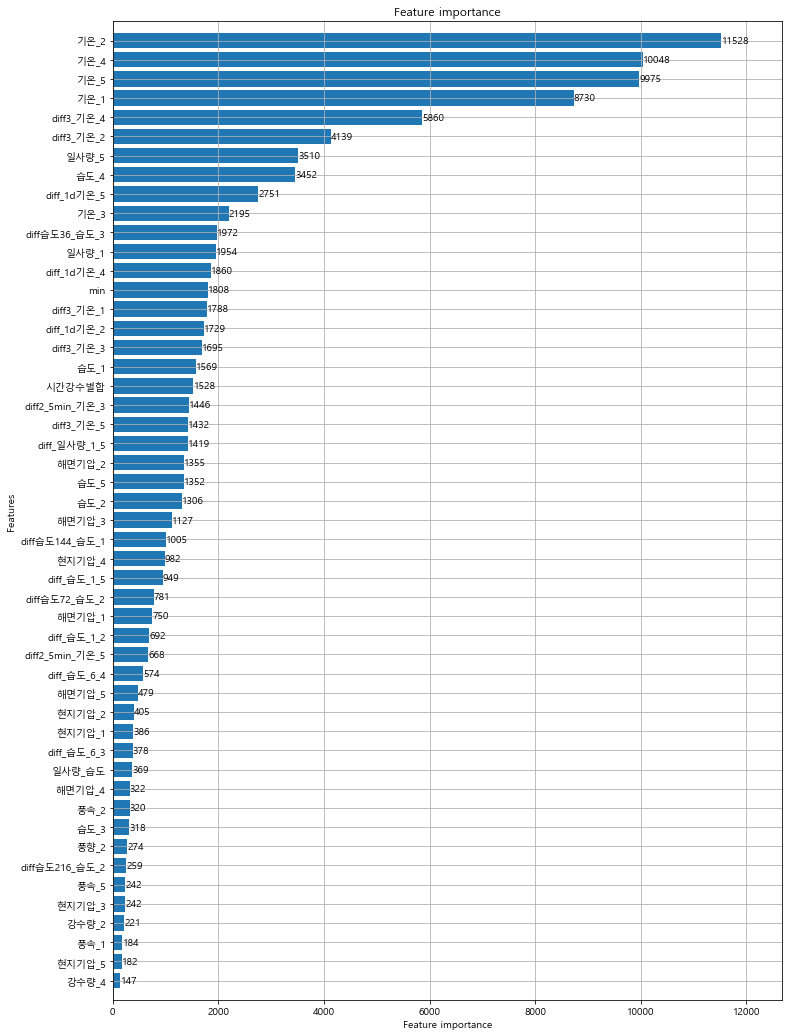

In [112]:
import lightgbm as lgb#0.217199

from sklearn.model_selection import train_test_split

train_x, train_cv, y, y_cv = train_test_split(X_train,y_train, test_size=0.15, random_state=1217)

def lgbm_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2284, num_rounds=20800):

    param = {}

    param['boosting'] = 'dart'
    
    param['objective'] = 'regression'

    param['learning_rate'] = 0.05

    param['max_depth'] = 10

    param['metric'] = 'rmse'
    
    param['is_training_metric'] = True
    
    param['min_child_weight'] = 1

    param['bagging_fraction'] = 0.8
    
    param['num_leaves'] = 128

    param['feature_fraction'] = 0.8

    param['bagging_freq'] = 6
    
    param['seed'] = seed_val
    
    param['min_split_gain'] = 0.01
    
    num_rounds = num_rounds

    plst = list(param.items())

    train_ds = lgb.Dataset(train_X, label=train_y)

    test_ds = lgb.Dataset(test_X, label=test_y)

    model = lgb.train(param, train_ds, num_rounds,test_ds, early_stopping_rounds=180)

    return model

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


model = lgbm_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)

from matplotlib import pylab as plt

fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)

plt.show()

In [113]:
y_test =  np.expm1(model.predict(X_test)) + 1

In [114]:
submission['Y18'] = y_test

In [115]:
submission.to_csv('data/Ensemble/col1_test.csv',index=False)

## COL2

In [116]:
X_train = data[COL2].iloc[:train.shape[0],:]
X_test = data[COL2].iloc[train.shape[0]:,:]

[1]	valid_0's rmse: 0.322282
[2]	valid_0's rmse: 0.306492
[3]	valid_0's rmse: 0.291551
[4]	valid_0's rmse: 0.277373
[5]	valid_0's rmse: 0.277656
[6]	valid_0's rmse: 0.26414
[7]	valid_0's rmse: 0.251247
[8]	valid_0's rmse: 0.239124
[9]	valid_0's rmse: 0.227604
[10]	valid_0's rmse: 0.216615
[11]	valid_0's rmse: 0.216616
[12]	valid_0's rmse: 0.206306
[13]	valid_0's rmse: 0.196367
[14]	valid_0's rmse: 0.198324
[15]	valid_0's rmse: 0.205152
[16]	valid_0's rmse: 0.195322
[17]	valid_0's rmse: 0.185877
[18]	valid_0's rmse: 0.177035
[19]	valid_0's rmse: 0.180657
[20]	valid_0's rmse: 0.17206
[21]	valid_0's rmse: 0.175049
[22]	valid_0's rmse: 0.166655
[23]	valid_0's rmse: 0.169759
[24]	valid_0's rmse: 0.161677
[25]	valid_0's rmse: 0.153971
[26]	valid_0's rmse: 0.146689
[27]	valid_0's rmse: 0.15047
[28]	valid_0's rmse: 0.143328
[29]	valid_0's rmse: 0.136545
[30]	valid_0's rmse: 0.395372
[31]	valid_0's rmse: 0.375778
[32]	valid_0's rmse: 0.357187
[33]	valid_0's rmse: 0.339562
[34]	valid_0's rmse: 0

[285]	valid_0's rmse: 0.270903
[286]	valid_0's rmse: 0.257555
[287]	valid_0's rmse: 0.267587
[288]	valid_0's rmse: 0.277923
[289]	valid_0's rmse: 0.264228
[290]	valid_0's rmse: 0.251224
[291]	valid_0's rmse: 0.2389
[292]	valid_0's rmse: 0.227183
[293]	valid_0's rmse: 0.216032
[294]	valid_0's rmse: 0.22551
[295]	valid_0's rmse: 0.235626
[296]	valid_0's rmse: 0.244788
[297]	valid_0's rmse: 0.254004
[298]	valid_0's rmse: 0.26243
[299]	valid_0's rmse: 0.271861
[300]	valid_0's rmse: 0.280175
[301]	valid_0's rmse: 0.266356
[302]	valid_0's rmse: 0.253281
[303]	valid_0's rmse: 0.262413
[304]	valid_0's rmse: 0.298626
[305]	valid_0's rmse: 0.303905
[306]	valid_0's rmse: 0.341937
[307]	valid_0's rmse: 0.35004
[308]	valid_0's rmse: 0.358777
[309]	valid_0's rmse: 0.341033
[310]	valid_0's rmse: 0.324166
[311]	valid_0's rmse: 0.308155
[312]	valid_0's rmse: 0.315822
[313]	valid_0's rmse: 0.300238
[314]	valid_0's rmse: 0.285435
[315]	valid_0's rmse: 0.292266
[316]	valid_0's rmse: 0.300677
[317]	valid_0

[554]	valid_0's rmse: 0.207768
[555]	valid_0's rmse: 0.213536
[556]	valid_0's rmse: 0.21918
[557]	valid_0's rmse: 0.225195
[558]	valid_0's rmse: 0.214169
[559]	valid_0's rmse: 0.203727
[560]	valid_0's rmse: 0.193793
[561]	valid_0's rmse: 0.200098
[562]	valid_0's rmse: 0.190336
[563]	valid_0's rmse: 0.197095
[564]	valid_0's rmse: 0.187473
[565]	valid_0's rmse: 0.193788
[566]	valid_0's rmse: 0.199349
[567]	valid_0's rmse: 0.189668
[568]	valid_0's rmse: 0.180487
[569]	valid_0's rmse: 0.171762
[570]	valid_0's rmse: 0.178914
[571]	valid_0's rmse: 0.184652
[572]	valid_0's rmse: 0.175696
[573]	valid_0's rmse: 0.167187
[574]	valid_0's rmse: 0.159115
[575]	valid_0's rmse: 0.151471
[576]	valid_0's rmse: 0.144229
[577]	valid_0's rmse: 0.137379
[578]	valid_0's rmse: 0.130881
[579]	valid_0's rmse: 0.137075
[580]	valid_0's rmse: 0.130572
[581]	valid_0's rmse: 0.135666
[582]	valid_0's rmse: 0.129237
[583]	valid_0's rmse: 0.135511
[584]	valid_0's rmse: 0.129085
[585]	valid_0's rmse: 0.149044
[586]	val

[845]	valid_0's rmse: 0.110718
[846]	valid_0's rmse: 0.105606
[847]	valid_0's rmse: 0.100755
[848]	valid_0's rmse: 0.105615
[849]	valid_0's rmse: 0.10988
[850]	valid_0's rmse: 0.104791
[851]	valid_0's rmse: 0.0999885
[852]	valid_0's rmse: 0.0954096
[853]	valid_0's rmse: 0.0999111
[854]	valid_0's rmse: 0.0953438
[855]	valid_0's rmse: 0.0993293
[856]	valid_0's rmse: 0.103361
[857]	valid_0's rmse: 0.0986196
[858]	valid_0's rmse: 0.0941429
[859]	valid_0's rmse: 0.0898892
[860]	valid_0's rmse: 0.0944761
[861]	valid_0's rmse: 0.0902221
[862]	valid_0's rmse: 0.0941795
[863]	valid_0's rmse: 0.0899359
[864]	valid_0's rmse: 0.0859297
[865]	valid_0's rmse: 0.0821281
[866]	valid_0's rmse: 0.0861815
[867]	valid_0's rmse: 0.0823748
[868]	valid_0's rmse: 0.0862493
[869]	valid_0's rmse: 0.0900429
[870]	valid_0's rmse: 0.0860141
[871]	valid_0's rmse: 0.0822147
[872]	valid_0's rmse: 0.0786117
[873]	valid_0's rmse: 0.0752089
[874]	valid_0's rmse: 0.0792728
[875]	valid_0's rmse: 0.0758404
[876]	valid_0's 

[1101]	valid_0's rmse: 0.0743213
[1102]	valid_0's rmse: 0.0770421
[1103]	valid_0's rmse: 0.0798744
[1104]	valid_0's rmse: 0.0832619
[1105]	valid_0's rmse: 0.086246
[1106]	valid_0's rmse: 0.0893212
[1107]	valid_0's rmse: 0.0919986
[1108]	valid_0's rmse: 0.0957249
[1109]	valid_0's rmse: 0.091372
[1110]	valid_0's rmse: 0.0872551
[1111]	valid_0's rmse: 0.0833685
[1112]	valid_0's rmse: 0.0954799
[1113]	valid_0's rmse: 0.0985957
[1114]	valid_0's rmse: 0.0941046
[1115]	valid_0's rmse: 0.0898326
[1116]	valid_0's rmse: 0.102022
[1117]	valid_0's rmse: 0.0973515
[1118]	valid_0's rmse: 0.100413
[1119]	valid_0's rmse: 0.103997
[1120]	valid_0's rmse: 0.107338
[1121]	valid_0's rmse: 0.102407
[1122]	valid_0's rmse: 0.104949
[1123]	valid_0's rmse: 0.100121
[1124]	valid_0's rmse: 0.103732
[1125]	valid_0's rmse: 0.106645
[1126]	valid_0's rmse: 0.109648
[1127]	valid_0's rmse: 0.121619
[1128]	valid_0's rmse: 0.125124
[1129]	valid_0's rmse: 0.128328
[1130]	valid_0's rmse: 0.131432
[1131]	valid_0's rmse: 0.1

[1379]	valid_0's rmse: 0.0595078
[1380]	valid_0's rmse: 0.0571919
[1381]	valid_0's rmse: 0.0550369
[1382]	valid_0's rmse: 0.053013
[1383]	valid_0's rmse: 0.0511159
[1384]	valid_0's rmse: 0.0530874
[1385]	valid_0's rmse: 0.0549371
[1386]	valid_0's rmse: 0.0574984
[1387]	valid_0's rmse: 0.0597559
[1388]	valid_0's rmse: 0.0574406
[1389]	valid_0's rmse: 0.0552726
[1390]	valid_0's rmse: 0.057524
[1391]	valid_0's rmse: 0.0602231
[1392]	valid_0's rmse: 0.0578904
[1393]	valid_0's rmse: 0.0603403
[1394]	valid_0's rmse: 0.0700104
[1395]	valid_0's rmse: 0.0671055
[1396]	valid_0's rmse: 0.0695086
[1397]	valid_0's rmse: 0.0719687
[1398]	valid_0's rmse: 0.0741802
[1399]	valid_0's rmse: 0.0710311
[1400]	valid_0's rmse: 0.0680684
[1401]	valid_0's rmse: 0.065272
[1402]	valid_0's rmse: 0.0626396
[1403]	valid_0's rmse: 0.0601541
[1404]	valid_0's rmse: 0.0578118
[1405]	valid_0's rmse: 0.0597504
[1406]	valid_0's rmse: 0.0618321
[1407]	valid_0's rmse: 0.0640747
[1408]	valid_0's rmse: 0.0615092
[1409]	valid_

[1650]	valid_0's rmse: 0.0647147
[1651]	valid_0's rmse: 0.0667679
[1652]	valid_0's rmse: 0.0640385
[1653]	valid_0's rmse: 0.0661635
[1654]	valid_0's rmse: 0.0634762
[1655]	valid_0's rmse: 0.0609356
[1656]	valid_0's rmse: 0.0630876
[1657]	valid_0's rmse: 0.0605804
[1658]	valid_0's rmse: 0.0582316
[1659]	valid_0's rmse: 0.0560105
[1660]	valid_0's rmse: 0.0539324
[1661]	valid_0's rmse: 0.0519857
[1662]	valid_0's rmse: 0.0536387
[1663]	valid_0's rmse: 0.0517098
[1664]	valid_0's rmse: 0.0597547
[1665]	valid_0's rmse: 0.0574487
[1666]	valid_0's rmse: 0.0593861
[1667]	valid_0's rmse: 0.0612491
[1668]	valid_0's rmse: 0.0630411
[1669]	valid_0's rmse: 0.0648311
[1670]	valid_0's rmse: 0.0668738
[1671]	valid_0's rmse: 0.0691923
[1672]	valid_0's rmse: 0.0711157
[1673]	valid_0's rmse: 0.0795833
[1674]	valid_0's rmse: 0.0761441
[1675]	valid_0's rmse: 0.0728654
[1676]	valid_0's rmse: 0.0748995
[1677]	valid_0's rmse: 0.0767732
[1678]	valid_0's rmse: 0.0788483
[1679]	valid_0's rmse: 0.0809077
[1680]	val

[1904]	valid_0's rmse: 0.0475918
[1905]	valid_0's rmse: 0.0489593
[1906]	valid_0's rmse: 0.0506265
[1907]	valid_0's rmse: 0.0489103
[1908]	valid_0's rmse: 0.0473076
[1909]	valid_0's rmse: 0.0540994
[1910]	valid_0's rmse: 0.0521459
[1911]	valid_0's rmse: 0.050316
[1912]	valid_0's rmse: 0.0517737
[1913]	valid_0's rmse: 0.0499743
[1914]	valid_0's rmse: 0.048291
[1915]	valid_0's rmse: 0.049593
[1916]	valid_0's rmse: 0.0479309
[1917]	valid_0's rmse: 0.0463808
[1918]	valid_0's rmse: 0.0449319
[1919]	valid_0's rmse: 0.0435801
[1920]	valid_0's rmse: 0.0448881
[1921]	valid_0's rmse: 0.0463215
[1922]	valid_0's rmse: 0.0482026
[1923]	valid_0's rmse: 0.0466191
[1924]	valid_0's rmse: 0.0451437
[1925]	valid_0's rmse: 0.0469574
[1926]	valid_0's rmse: 0.0454644
[1927]	valid_0's rmse: 0.0470447
[1928]	valid_0's rmse: 0.0486942
[1929]	valid_0's rmse: 0.0502822
[1930]	valid_0's rmse: 0.0567011
[1931]	valid_0's rmse: 0.0582957
[1932]	valid_0's rmse: 0.0560811
[1933]	valid_0's rmse: 0.0539895
[1934]	valid_

[2160]	valid_0's rmse: 0.054032
[2161]	valid_0's rmse: 0.0520886
[2162]	valid_0's rmse: 0.0502718
[2163]	valid_0's rmse: 0.0485714
[2164]	valid_0's rmse: 0.050138
[2165]	valid_0's rmse: 0.048448
[2166]	valid_0's rmse: 0.0498203
[2167]	valid_0's rmse: 0.0481483
[2168]	valid_0's rmse: 0.0465828
[2169]	valid_0's rmse: 0.0478357
[2170]	valid_0's rmse: 0.0492893
[2171]	valid_0's rmse: 0.0476665
[2172]	valid_0's rmse: 0.046144
[2173]	valid_0's rmse: 0.0474192
[2174]	valid_0's rmse: 0.045894
[2175]	valid_0's rmse: 0.0470873
[2176]	valid_0's rmse: 0.0481433
[2177]	valid_0's rmse: 0.0494252
[2178]	valid_0's rmse: 0.0509368
[2179]	valid_0's rmse: 0.0492009
[2180]	valid_0's rmse: 0.050679
[2181]	valid_0's rmse: 0.0566225
[2182]	valid_0's rmse: 0.0579205
[2183]	valid_0's rmse: 0.0593571
[2184]	valid_0's rmse: 0.0609845
[2185]	valid_0's rmse: 0.0622695
[2186]	valid_0's rmse: 0.0636747
[2187]	valid_0's rmse: 0.0611598
[2188]	valid_0's rmse: 0.0587903
[2189]	valid_0's rmse: 0.0565587
[2190]	valid_0's

[2421]	valid_0's rmse: 0.0446674
[2422]	valid_0's rmse: 0.0457505
[2423]	valid_0's rmse: 0.0471287
[2424]	valid_0's rmse: 0.048547
[2425]	valid_0's rmse: 0.0497884
[2426]	valid_0's rmse: 0.0481368
[2427]	valid_0's rmse: 0.0493247
[2428]	valid_0's rmse: 0.0508005
[2429]	valid_0's rmse: 0.0490831
[2430]	valid_0's rmse: 0.05461
[2431]	valid_0's rmse: 0.0558911
[2432]	valid_0's rmse: 0.0568442
[2433]	valid_0's rmse: 0.0581684
[2434]	valid_0's rmse: 0.0559681
[2435]	valid_0's rmse: 0.053908
[2436]	valid_0's rmse: 0.0519814
[2437]	valid_0's rmse: 0.0501745
[2438]	valid_0's rmse: 0.0555138
[2439]	valid_0's rmse: 0.0565664
[2440]	valid_0's rmse: 0.058204
[2441]	valid_0's rmse: 0.0560143
[2442]	valid_0's rmse: 0.0539526
[2443]	valid_0's rmse: 0.055167
[2444]	valid_0's rmse: 0.0563408
[2445]	valid_0's rmse: 0.0542594
[2446]	valid_0's rmse: 0.0551787
[2447]	valid_0's rmse: 0.0569733
[2448]	valid_0's rmse: 0.0583589
[2449]	valid_0's rmse: 0.0561328
[2450]	valid_0's rmse: 0.0540592
[2451]	valid_0's

[2673]	valid_0's rmse: 0.0415122
[2674]	valid_0's rmse: 0.042489
[2675]	valid_0's rmse: 0.0437016
[2676]	valid_0's rmse: 0.0446988
[2677]	valid_0's rmse: 0.045732
[2678]	valid_0's rmse: 0.0470029
[2679]	valid_0's rmse: 0.0455327
[2680]	valid_0's rmse: 0.0441577
[2681]	valid_0's rmse: 0.0428804
[2682]	valid_0's rmse: 0.0439555
[2683]	valid_0's rmse: 0.0447884
[2684]	valid_0's rmse: 0.0457026
[2685]	valid_0's rmse: 0.0443191
[2686]	valid_0's rmse: 0.0454726
[2687]	valid_0's rmse: 0.0465852
[2688]	valid_0's rmse: 0.0476393
[2689]	valid_0's rmse: 0.0488977
[2690]	valid_0's rmse: 0.0472934
[2691]	valid_0's rmse: 0.0458035
[2692]	valid_0's rmse: 0.0468048
[2693]	valid_0's rmse: 0.0476662
[2694]	valid_0's rmse: 0.0461635
[2695]	valid_0's rmse: 0.0447602
[2696]	valid_0's rmse: 0.046015
[2697]	valid_0's rmse: 0.0446231
[2698]	valid_0's rmse: 0.0433211
[2699]	valid_0's rmse: 0.0444924
[2700]	valid_0's rmse: 0.0455157
[2701]	valid_0's rmse: 0.0441482
[2702]	valid_0's rmse: 0.0453193
[2703]	valid_

[2945]	valid_0's rmse: 0.0540542
[2946]	valid_0's rmse: 0.054876
[2947]	valid_0's rmse: 0.0560609
[2948]	valid_0's rmse: 0.0540018
[2949]	valid_0's rmse: 0.0520624
[2950]	valid_0's rmse: 0.0529267
[2951]	valid_0's rmse: 0.051071
[2952]	valid_0's rmse: 0.0519967
[2953]	valid_0's rmse: 0.0530143
[2954]	valid_0's rmse: 0.0540595
[2955]	valid_0's rmse: 0.0549572
[2956]	valid_0's rmse: 0.0529762
[2957]	valid_0's rmse: 0.0540718
[2958]	valid_0's rmse: 0.0521441
[2959]	valid_0's rmse: 0.0503156
[2960]	valid_0's rmse: 0.0486098
[2961]	valid_0's rmse: 0.0496025
[2962]	valid_0's rmse: 0.0505651
[2963]	valid_0's rmse: 0.0514053
[2964]	valid_0's rmse: 0.0524054
[2965]	valid_0's rmse: 0.0505863
[2966]	valid_0's rmse: 0.0488933
[2967]	valid_0's rmse: 0.0472995
[2968]	valid_0's rmse: 0.0482955
[2969]	valid_0's rmse: 0.049287
[2970]	valid_0's rmse: 0.0500605
[2971]	valid_0's rmse: 0.048398
[2972]	valid_0's rmse: 0.0492136
[2973]	valid_0's rmse: 0.0502309
[2974]	valid_0's rmse: 0.0515093
[2975]	valid_0

[3222]	valid_0's rmse: 0.0371474
[3223]	valid_0's rmse: 0.036385
[3224]	valid_0's rmse: 0.035678
[3225]	valid_0's rmse: 0.0350269
[3226]	valid_0's rmse: 0.0344224
[3227]	valid_0's rmse: 0.033869
[3228]	valid_0's rmse: 0.0333625
[3229]	valid_0's rmse: 0.032892
[3230]	valid_0's rmse: 0.0324518
[3231]	valid_0's rmse: 0.0320546
[3232]	valid_0's rmse: 0.0325195
[3233]	valid_0's rmse: 0.0331174
[3234]	valid_0's rmse: 0.0326628
[3235]	valid_0's rmse: 0.0322468
[3236]	valid_0's rmse: 0.0318687
[3237]	valid_0's rmse: 0.0315188
[3238]	valid_0's rmse: 0.0312
[3239]	valid_0's rmse: 0.031608
[3240]	valid_0's rmse: 0.0312824
[3241]	valid_0's rmse: 0.0317597
[3242]	valid_0's rmse: 0.0314158
[3243]	valid_0's rmse: 0.0320649
[3244]	valid_0's rmse: 0.0326698
[3245]	valid_0's rmse: 0.0322518
[3246]	valid_0's rmse: 0.0329405
[3247]	valid_0's rmse: 0.0325018
[3248]	valid_0's rmse: 0.0321033
[3249]	valid_0's rmse: 0.0326833
[3250]	valid_0's rmse: 0.0322645
[3251]	valid_0's rmse: 0.031885
[3252]	valid_0's rm

[3494]	valid_0's rmse: 0.0371626
[3495]	valid_0's rmse: 0.0377186
[3496]	valid_0's rmse: 0.0383234
[3497]	valid_0's rmse: 0.0390264
[3498]	valid_0's rmse: 0.0381138
[3499]	valid_0's rmse: 0.0372683
[3500]	valid_0's rmse: 0.0382331
[3501]	valid_0's rmse: 0.0390554
[3502]	valid_0's rmse: 0.0381481
[3503]	valid_0's rmse: 0.0373057
[3504]	valid_0's rmse: 0.0365229
[3505]	valid_0's rmse: 0.0370773
[3506]	valid_0's rmse: 0.0375924
[3507]	valid_0's rmse: 0.0382088
[3508]	valid_0's rmse: 0.0373645
[3509]	valid_0's rmse: 0.0380158
[3510]	valid_0's rmse: 0.0371912
[3511]	valid_0's rmse: 0.0364167
[3512]	valid_0's rmse: 0.0369795
[3513]	valid_0's rmse: 0.0362219
[3514]	valid_0's rmse: 0.0355258
[3515]	valid_0's rmse: 0.0359395
[3516]	valid_0's rmse: 0.0352671
[3517]	valid_0's rmse: 0.0346546
[3518]	valid_0's rmse: 0.0351676
[3519]	valid_0's rmse: 0.0358833
[3520]	valid_0's rmse: 0.0365316
[3521]	valid_0's rmse: 0.0370902
[3522]	valid_0's rmse: 0.0377337
[3523]	valid_0's rmse: 0.0369149
[3524]	val

[3764]	valid_0's rmse: 0.0364728
[3765]	valid_0's rmse: 0.0357603
[3766]	valid_0's rmse: 0.0350988
[3767]	valid_0's rmse: 0.0355614
[3768]	valid_0's rmse: 0.0361086
[3769]	valid_0's rmse: 0.0367824
[3770]	valid_0's rmse: 0.0375188
[3771]	valid_0's rmse: 0.0385389
[3772]	valid_0's rmse: 0.0393058
[3773]	valid_0's rmse: 0.0383901
[3774]	valid_0's rmse: 0.0389162
[3775]	valid_0's rmse: 0.0380246
[3776]	valid_0's rmse: 0.0372066
[3777]	valid_0's rmse: 0.0364363
[3778]	valid_0's rmse: 0.0357141
[3779]	valid_0's rmse: 0.0350565
[3780]	valid_0's rmse: 0.0355514
[3781]	valid_0's rmse: 0.0348888
[3782]	valid_0's rmse: 0.0353439
[3783]	valid_0's rmse: 0.0358901
[3784]	valid_0's rmse: 0.0352222
[3785]	valid_0's rmse: 0.03461
[3786]	valid_0's rmse: 0.0351645
[3787]	valid_0's rmse: 0.0345551
[3788]	valid_0's rmse: 0.0350911
[3789]	valid_0's rmse: 0.0357305
[3790]	valid_0's rmse: 0.0362601
[3791]	valid_0's rmse: 0.0355602
[3792]	valid_0's rmse: 0.0349238
[3793]	valid_0's rmse: 0.0354799
[3794]	valid

[4021]	valid_0's rmse: 0.0358166
[4022]	valid_0's rmse: 0.0364034
[4023]	valid_0's rmse: 0.0357016
[4024]	valid_0's rmse: 0.0363249
[4025]	valid_0's rmse: 0.0356304
[4026]	valid_0's rmse: 0.034986
[4027]	valid_0's rmse: 0.0343801
[4028]	valid_0's rmse: 0.033833
[4029]	valid_0's rmse: 0.0333358
[4030]	valid_0's rmse: 0.0339345
[4031]	valid_0's rmse: 0.0344025
[4032]	valid_0's rmse: 0.033857
[4033]	valid_0's rmse: 0.0333661
[4034]	valid_0's rmse: 0.0329077
[4035]	valid_0's rmse: 0.033435
[4036]	valid_0's rmse: 0.0338082
[4037]	valid_0's rmse: 0.0333215
[4038]	valid_0's rmse: 0.0328629
[4039]	valid_0's rmse: 0.0324265
[4040]	valid_0's rmse: 0.0320402
[4041]	valid_0's rmse: 0.0324479
[4042]	valid_0's rmse: 0.0328341
[4043]	valid_0's rmse: 0.0334339
[4044]	valid_0's rmse: 0.0329672
[4045]	valid_0's rmse: 0.0335035
[4046]	valid_0's rmse: 0.0330348
[4047]	valid_0's rmse: 0.0335639
[4048]	valid_0's rmse: 0.0330908
[4049]	valid_0's rmse: 0.0335406
[4050]	valid_0's rmse: 0.0342075
[4051]	valid_0

[4277]	valid_0's rmse: 0.0349577
[4278]	valid_0's rmse: 0.035445
[4279]	valid_0's rmse: 0.0380185
[4280]	valid_0's rmse: 0.0371786
[4281]	valid_0's rmse: 0.036411
[4282]	valid_0's rmse: 0.0356984
[4283]	valid_0's rmse: 0.0350381
[4284]	valid_0's rmse: 0.0355933
[4285]	valid_0's rmse: 0.0349397
[4286]	valid_0's rmse: 0.0343299
[4287]	valid_0's rmse: 0.0347913
[4288]	valid_0's rmse: 0.0341994
[4289]	valid_0's rmse: 0.0336597
[4290]	valid_0's rmse: 0.0341423
[4291]	valid_0's rmse: 0.0335859
[4292]	valid_0's rmse: 0.0330937
[4293]	valid_0's rmse: 0.033668
[4294]	valid_0's rmse: 0.0341097
[4295]	valid_0's rmse: 0.0335772
[4296]	valid_0's rmse: 0.0340531
[4297]	valid_0's rmse: 0.0346333
[4298]	valid_0's rmse: 0.0340594
[4299]	valid_0's rmse: 0.0345402
[4300]	valid_0's rmse: 0.0339638
[4301]	valid_0's rmse: 0.0334405
[4302]	valid_0's rmse: 0.033939
[4303]	valid_0's rmse: 0.0334032
[4304]	valid_0's rmse: 0.0339408
[4305]	valid_0's rmse: 0.0334205
[4306]	valid_0's rmse: 0.0329382
[4307]	valid_0

[4532]	valid_0's rmse: 0.0375333
[4533]	valid_0's rmse: 0.0380394
[4534]	valid_0's rmse: 0.0372037
[4535]	valid_0's rmse: 0.0377368
[4536]	valid_0's rmse: 0.0369288
[4537]	valid_0's rmse: 0.0361825
[4538]	valid_0's rmse: 0.0366943
[4539]	valid_0's rmse: 0.0359566
[4540]	valid_0's rmse: 0.0363931
[4541]	valid_0's rmse: 0.0356837
[4542]	valid_0's rmse: 0.0361613
[4543]	valid_0's rmse: 0.0386108
[4544]	valid_0's rmse: 0.0391995
[4545]	valid_0's rmse: 0.0382809
[4546]	valid_0's rmse: 0.0374204
[4547]	valid_0's rmse: 0.037843
[4548]	valid_0's rmse: 0.0370192
[4549]	valid_0's rmse: 0.0375987
[4550]	valid_0's rmse: 0.0367928
[4551]	valid_0's rmse: 0.0371837
[4552]	valid_0's rmse: 0.0364124
[4553]	valid_0's rmse: 0.036873
[4554]	valid_0's rmse: 0.0373918
[4555]	valid_0's rmse: 0.0365888
[4556]	valid_0's rmse: 0.0369646
[4557]	valid_0's rmse: 0.0362165
[4558]	valid_0's rmse: 0.0367734
[4559]	valid_0's rmse: 0.0372902
[4560]	valid_0's rmse: 0.0377791
[4561]	valid_0's rmse: 0.0382238
[4562]	valid

[4802]	valid_0's rmse: 0.0359823
[4803]	valid_0's rmse: 0.035309
[4804]	valid_0's rmse: 0.0346913
[4805]	valid_0's rmse: 0.0341214
[4806]	valid_0's rmse: 0.034504
[4807]	valid_0's rmse: 0.0348514
[4808]	valid_0's rmse: 0.0352442
[4809]	valid_0's rmse: 0.0357159
[4810]	valid_0's rmse: 0.0350474
[4811]	valid_0's rmse: 0.0344337
[4812]	valid_0's rmse: 0.0338684
[4813]	valid_0's rmse: 0.0333573
[4814]	valid_0's rmse: 0.032894
[4815]	valid_0's rmse: 0.0332085
[4816]	valid_0's rmse: 0.0327508
[4817]	valid_0's rmse: 0.0323302
[4818]	valid_0's rmse: 0.0319516
[4819]	valid_0's rmse: 0.0315997
[4820]	valid_0's rmse: 0.0312775
[4821]	valid_0's rmse: 0.0309828
[4822]	valid_0's rmse: 0.0313145
[4823]	valid_0's rmse: 0.0316715
[4824]	valid_0's rmse: 0.0313441
[4825]	valid_0's rmse: 0.0316632
[4826]	valid_0's rmse: 0.0320354
[4827]	valid_0's rmse: 0.0323926
[4828]	valid_0's rmse: 0.032001
[4829]	valid_0's rmse: 0.0316425
[4830]	valid_0's rmse: 0.0319079
[4831]	valid_0's rmse: 0.0322393
[4832]	valid_0

[5068]	valid_0's rmse: 0.0344762
[5069]	valid_0's rmse: 0.0339165
[5070]	valid_0's rmse: 0.0334078
[5071]	valid_0's rmse: 0.0338124
[5072]	valid_0's rmse: 0.0332857
[5073]	valid_0's rmse: 0.0336488
[5074]	valid_0's rmse: 0.0340163
[5075]	valid_0's rmse: 0.034381
[5076]	valid_0's rmse: 0.0338254
[5077]	valid_0's rmse: 0.0342215
[5078]	valid_0's rmse: 0.0345311
[5079]	valid_0's rmse: 0.0339612
[5080]	valid_0's rmse: 0.0334418
[5081]	valid_0's rmse: 0.0329642
[5082]	valid_0's rmse: 0.0325262
[5083]	valid_0's rmse: 0.0328235
[5084]	valid_0's rmse: 0.033086
[5085]	valid_0's rmse: 0.0334496
[5086]	valid_0's rmse: 0.0339043
[5087]	valid_0's rmse: 0.0342313
[5088]	valid_0's rmse: 0.0336901
[5089]	valid_0's rmse: 0.0340276
[5090]	valid_0's rmse: 0.0343557
[5091]	valid_0's rmse: 0.0338006
[5092]	valid_0's rmse: 0.0341923
[5093]	valid_0's rmse: 0.034627
[5094]	valid_0's rmse: 0.0349901
[5095]	valid_0's rmse: 0.035393
[5096]	valid_0's rmse: 0.0347547
[5097]	valid_0's rmse: 0.035176
[5098]	valid_0'

[5598]	valid_0's rmse: 0.031643
[5599]	valid_0's rmse: 0.0312975
[5600]	valid_0's rmse: 0.0310026
[5601]	valid_0's rmse: 0.0312774
[5602]	valid_0's rmse: 0.0315212
[5603]	valid_0's rmse: 0.0312015
[5604]	valid_0's rmse: 0.0315202
[5605]	valid_0's rmse: 0.0311997
[5606]	valid_0's rmse: 0.0309077
[5607]	valid_0's rmse: 0.0311225
[5608]	valid_0's rmse: 0.0313909
[5609]	valid_0's rmse: 0.0315777
[5610]	valid_0's rmse: 0.0318502
[5611]	valid_0's rmse: 0.032075
[5612]	valid_0's rmse: 0.0317134
[5613]	valid_0's rmse: 0.0320219
[5614]	valid_0's rmse: 0.0324334
[5615]	valid_0's rmse: 0.0327734
[5616]	valid_0's rmse: 0.0330237
[5617]	valid_0's rmse: 0.0325804
[5618]	valid_0's rmse: 0.0321718
[5619]	valid_0's rmse: 0.0318001
[5620]	valid_0's rmse: 0.0314524
[5621]	valid_0's rmse: 0.0317893
[5622]	valid_0's rmse: 0.0314511
[5623]	valid_0's rmse: 0.0316756
[5624]	valid_0's rmse: 0.0318909
[5625]	valid_0's rmse: 0.0315439
[5626]	valid_0's rmse: 0.0312297
[5627]	valid_0's rmse: 0.0309361
[5628]	valid

[5852]	valid_0's rmse: 0.031556
[5853]	valid_0's rmse: 0.0312498
[5854]	valid_0's rmse: 0.031546
[5855]	valid_0's rmse: 0.0317549
[5856]	valid_0's rmse: 0.0314383
[5857]	valid_0's rmse: 0.0316586
[5858]	valid_0's rmse: 0.0319509
[5859]	valid_0's rmse: 0.0323343
[5860]	valid_0's rmse: 0.0326954
[5861]	valid_0's rmse: 0.0329511
[5862]	valid_0's rmse: 0.0325316
[5863]	valid_0's rmse: 0.0327709
[5864]	valid_0's rmse: 0.0323549
[5865]	valid_0's rmse: 0.0325924
[5866]	valid_0's rmse: 0.0321962
[5867]	valid_0's rmse: 0.0318305
[5868]	valid_0's rmse: 0.0321578
[5869]	valid_0's rmse: 0.0317978
[5870]	valid_0's rmse: 0.0314657
[5871]	valid_0's rmse: 0.0318316
[5872]	valid_0's rmse: 0.0315066
[5873]	valid_0's rmse: 0.0312117
[5874]	valid_0's rmse: 0.0315273
[5875]	valid_0's rmse: 0.0317814
[5876]	valid_0's rmse: 0.0320567
[5877]	valid_0's rmse: 0.031706
[5878]	valid_0's rmse: 0.0313767
[5879]	valid_0's rmse: 0.0310827
[5880]	valid_0's rmse: 0.0312899
[5881]	valid_0's rmse: 0.0310071
[5882]	valid_

[6114]	valid_0's rmse: 0.0326408
[6115]	valid_0's rmse: 0.0330651
[6116]	valid_0's rmse: 0.0335136
[6117]	valid_0's rmse: 0.0351998
[6118]	valid_0's rmse: 0.0345895
[6119]	valid_0's rmse: 0.0350239
[6120]	valid_0's rmse: 0.0353811
[6121]	valid_0's rmse: 0.0357094
[6122]	valid_0's rmse: 0.0359825
[6123]	valid_0's rmse: 0.0364053
[6124]	valid_0's rmse: 0.0357027
[6125]	valid_0's rmse: 0.0350525
[6126]	valid_0's rmse: 0.0353332
[6127]	valid_0's rmse: 0.0356247
[6128]	valid_0's rmse: 0.0360364
[6129]	valid_0's rmse: 0.0353699
[6130]	valid_0's rmse: 0.0347491
[6131]	valid_0's rmse: 0.0341758
[6132]	valid_0's rmse: 0.0336552
[6133]	valid_0's rmse: 0.0331753
[6134]	valid_0's rmse: 0.033534
[6135]	valid_0's rmse: 0.0330638
[6136]	valid_0's rmse: 0.033344
[6137]	valid_0's rmse: 0.0328949
[6138]	valid_0's rmse: 0.0333211
[6139]	valid_0's rmse: 0.032873
[6140]	valid_0's rmse: 0.032461
[6141]	valid_0's rmse: 0.0327556
[6142]	valid_0's rmse: 0.0330612
[6143]	valid_0's rmse: 0.0326335
[6144]	valid_0

[6369]	valid_0's rmse: 0.0319438
[6370]	valid_0's rmse: 0.0321465
[6371]	valid_0's rmse: 0.0325082
[6372]	valid_0's rmse: 0.0339922
[6373]	valid_0's rmse: 0.0334843
[6374]	valid_0's rmse: 0.0337351
[6375]	valid_0's rmse: 0.0341439
[6376]	valid_0's rmse: 0.0344377
[6377]	valid_0's rmse: 0.0339058
[6378]	valid_0's rmse: 0.0343301
[6379]	valid_0's rmse: 0.0338074
[6380]	valid_0's rmse: 0.0341324
[6381]	valid_0's rmse: 0.0336226
[6382]	valid_0's rmse: 0.03315
[6383]	valid_0's rmse: 0.0327149
[6384]	valid_0's rmse: 0.0330486
[6385]	valid_0's rmse: 0.0333836
[6386]	valid_0's rmse: 0.0329378
[6387]	valid_0's rmse: 0.0325141
[6388]	valid_0's rmse: 0.0321239
[6389]	valid_0's rmse: 0.0324431
[6390]	valid_0's rmse: 0.0320633
[6391]	valid_0's rmse: 0.0323346
[6392]	valid_0's rmse: 0.0325588
[6393]	valid_0's rmse: 0.0321668
[6394]	valid_0's rmse: 0.031815
[6395]	valid_0's rmse: 0.0314926
[6396]	valid_0's rmse: 0.0311949
[6397]	valid_0's rmse: 0.0311949
[6398]	valid_0's rmse: 0.0316368
[6399]	valid_

[6634]	valid_0's rmse: 0.0307825
[6635]	valid_0's rmse: 0.0305513
[6636]	valid_0's rmse: 0.0305513
[6637]	valid_0's rmse: 0.0308069
[6638]	valid_0's rmse: 0.0310335
[6639]	valid_0's rmse: 0.0307818
[6640]	valid_0's rmse: 0.0305407
[6641]	valid_0's rmse: 0.0307682
[6642]	valid_0's rmse: 0.0309891
[6643]	valid_0's rmse: 0.0307238
[6644]	valid_0's rmse: 0.0304871
[6645]	valid_0's rmse: 0.0307787
[6646]	valid_0's rmse: 0.0305345
[6647]	valid_0's rmse: 0.030815
[6648]	valid_0's rmse: 0.0310527
[6649]	valid_0's rmse: 0.0307915
[6650]	valid_0's rmse: 0.0310252
[6651]	valid_0's rmse: 0.0307751
[6652]	valid_0's rmse: 0.0305489
[6653]	valid_0's rmse: 0.0303464
[6654]	valid_0's rmse: 0.0301581
[6655]	valid_0's rmse: 0.0304116
[6656]	valid_0's rmse: 0.0305886
[6657]	valid_0's rmse: 0.0307975
[6658]	valid_0's rmse: 0.0310713
[6659]	valid_0's rmse: 0.0312827
[6660]	valid_0's rmse: 0.031006
[6661]	valid_0's rmse: 0.0312198
[6662]	valid_0's rmse: 0.0309531
[6663]	valid_0's rmse: 0.0309531
[6664]	valid

[6892]	valid_0's rmse: 0.0316811
[6893]	valid_0's rmse: 0.0313788
[6894]	valid_0's rmse: 0.0311043
[6895]	valid_0's rmse: 0.0314179
[6896]	valid_0's rmse: 0.031142
[6897]	valid_0's rmse: 0.0313048
[6898]	valid_0's rmse: 0.0313048
[6899]	valid_0's rmse: 0.0315764
[6900]	valid_0's rmse: 0.0315764
[6901]	valid_0's rmse: 0.0315764
[6902]	valid_0's rmse: 0.0318591
[6903]	valid_0's rmse: 0.0315472
[6904]	valid_0's rmse: 0.0318591
[6905]	valid_0's rmse: 0.0320913
[6906]	valid_0's rmse: 0.0317496
[6907]	valid_0's rmse: 0.0320293
[6908]	valid_0's rmse: 0.0316972
[6909]	valid_0's rmse: 0.0313943
[6910]	valid_0's rmse: 0.031695
[6911]	valid_0's rmse: 0.03201
[6912]	valid_0's rmse: 0.0316695
[6913]	valid_0's rmse: 0.0318754
[6914]	valid_0's rmse: 0.0315487
[6915]	valid_0's rmse: 0.031255
[6916]	valid_0's rmse: 0.030981
[6917]	valid_0's rmse: 0.031256
[6918]	valid_0's rmse: 0.0314822
[6919]	valid_0's rmse: 0.031673
[6920]	valid_0's rmse: 0.0313728
[6921]	valid_0's rmse: 0.0310951
[6922]	valid_0's r

[7176]	valid_0's rmse: 0.0318136
[7177]	valid_0's rmse: 0.0315139
[7178]	valid_0's rmse: 0.0316965
[7179]	valid_0's rmse: 0.032858
[7180]	valid_0's rmse: 0.0324624
[7181]	valid_0's rmse: 0.0321031
[7182]	valid_0's rmse: 0.0317724
[7183]	valid_0's rmse: 0.0314679
[7184]	valid_0's rmse: 0.0316367
[7185]	valid_0's rmse: 0.0313583
[7186]	valid_0's rmse: 0.0314839
[7187]	valid_0's rmse: 0.0316948
[7188]	valid_0's rmse: 0.0319819
[7189]	valid_0's rmse: 0.0316752
[7190]	valid_0's rmse: 0.0318938
[7191]	valid_0's rmse: 0.0320776
[7192]	valid_0's rmse: 0.0322729
[7193]	valid_0's rmse: 0.0325129
[7194]	valid_0's rmse: 0.0327488
[7195]	valid_0's rmse: 0.0323698
[7196]	valid_0's rmse: 0.0326306
[7197]	valid_0's rmse: 0.032878
[7198]	valid_0's rmse: 0.0324703
[7199]	valid_0's rmse: 0.0326472
[7200]	valid_0's rmse: 0.0322826
[7201]	valid_0's rmse: 0.032525
[7202]	valid_0's rmse: 0.0327376
[7203]	valid_0's rmse: 0.0329769
[7204]	valid_0's rmse: 0.0325831
[7205]	valid_0's rmse: 0.0327731
[7206]	valid_

[7444]	valid_0's rmse: 0.0324226
[7445]	valid_0's rmse: 0.0326285
[7446]	valid_0's rmse: 0.0322614
[7447]	valid_0's rmse: 0.032452
[7448]	valid_0's rmse: 0.0327294
[7449]	valid_0's rmse: 0.0323448
[7450]	valid_0's rmse: 0.0319971
[7451]	valid_0's rmse: 0.0321728
[7452]	valid_0's rmse: 0.0318382
[7453]	valid_0's rmse: 0.0320253
[7454]	valid_0's rmse: 0.032218
[7455]	valid_0's rmse: 0.0318798
[7456]	valid_0's rmse: 0.0320397
[7457]	valid_0's rmse: 0.0322184
[7458]	valid_0's rmse: 0.0318783
[7459]	valid_0's rmse: 0.0320642
[7460]	valid_0's rmse: 0.032208
[7461]	valid_0's rmse: 0.0324008
[7462]	valid_0's rmse: 0.0320443
[7463]	valid_0's rmse: 0.0331466
[7464]	valid_0's rmse: 0.0327304
[7465]	valid_0's rmse: 0.0329007
[7466]	valid_0's rmse: 0.0330902
[7467]	valid_0's rmse: 0.0333619
[7468]	valid_0's rmse: 0.0336535
[7469]	valid_0's rmse: 0.0331862
[7470]	valid_0's rmse: 0.0327618
[7471]	valid_0's rmse: 0.0330706
[7472]	valid_0's rmse: 0.0326655
[7473]	valid_0's rmse: 0.0328788
[7474]	valid_

[7713]	valid_0's rmse: 0.0312222
[7714]	valid_0's rmse: 0.0315269
[7715]	valid_0's rmse: 0.0312419
[7716]	valid_0's rmse: 0.0309853
[7717]	valid_0's rmse: 0.0311693
[7718]	valid_0's rmse: 0.0312782
[7719]	valid_0's rmse: 0.0314753
[7720]	valid_0's rmse: 0.0317619
[7721]	valid_0's rmse: 0.0319008
[7722]	valid_0's rmse: 0.0321373
[7723]	valid_0's rmse: 0.0323835
[7724]	valid_0's rmse: 0.0325928
[7725]	valid_0's rmse: 0.032835
[7726]	valid_0's rmse: 0.0324508
[7727]	valid_0's rmse: 0.0326256
[7728]	valid_0's rmse: 0.0327845
[7729]	valid_0's rmse: 0.0324085
[7730]	valid_0's rmse: 0.0325885
[7731]	valid_0's rmse: 0.0327744
[7732]	valid_0's rmse: 0.0323998
[7733]	valid_0's rmse: 0.0326948
[7734]	valid_0's rmse: 0.0329619
[7735]	valid_0's rmse: 0.0325723
[7736]	valid_0's rmse: 0.0322196
[7737]	valid_0's rmse: 0.0318851
[7738]	valid_0's rmse: 0.0320739
[7739]	valid_0's rmse: 0.03229
[7740]	valid_0's rmse: 0.0326385
[7741]	valid_0's rmse: 0.0322695
[7742]	valid_0's rmse: 0.0325766
[7743]	valid_

[7989]	valid_0's rmse: 0.0313706
[7990]	valid_0's rmse: 0.0313706
[7991]	valid_0's rmse: 0.0313706
[7992]	valid_0's rmse: 0.0313706
[7993]	valid_0's rmse: 0.0315389
[7994]	valid_0's rmse: 0.0317252
[7995]	valid_0's rmse: 0.0318582
[7996]	valid_0's rmse: 0.0315467
[7997]	valid_0's rmse: 0.0312723
[7998]	valid_0's rmse: 0.0310213
[7999]	valid_0's rmse: 0.0312113
[8000]	valid_0's rmse: 0.0313324
[8001]	valid_0's rmse: 0.0313324
[8002]	valid_0's rmse: 0.0315051
[8003]	valid_0's rmse: 0.031644
[8004]	valid_0's rmse: 0.0313597
[8005]	valid_0's rmse: 0.0313597
[8006]	valid_0's rmse: 0.0313597
[8007]	valid_0's rmse: 0.0313597
[8008]	valid_0's rmse: 0.0313597
[8009]	valid_0's rmse: 0.0313597
[8010]	valid_0's rmse: 0.0315224
[8011]	valid_0's rmse: 0.0312532
[8012]	valid_0's rmse: 0.0312532
[8013]	valid_0's rmse: 0.0312532
[8014]	valid_0's rmse: 0.0314187
[8015]	valid_0's rmse: 0.0315573
[8016]	valid_0's rmse: 0.0312633
[8017]	valid_0's rmse: 0.0310004
[8018]	valid_0's rmse: 0.0307653
[8019]	vali

[8273]	valid_0's rmse: 0.0310051
[8274]	valid_0's rmse: 0.031189
[8275]	valid_0's rmse: 0.0313
[8276]	valid_0's rmse: 0.0314552
[8277]	valid_0's rmse: 0.0316476
[8278]	valid_0's rmse: 0.0313731
[8279]	valid_0's rmse: 0.0315117
[8280]	valid_0's rmse: 0.0317286
[8281]	valid_0's rmse: 0.031909
[8282]	valid_0's rmse: 0.031599
[8283]	valid_0's rmse: 0.0317451
[8284]	valid_0's rmse: 0.0314687
[8285]	valid_0's rmse: 0.0316813
[8286]	valid_0's rmse: 0.0313937
[8287]	valid_0's rmse: 0.0311285
[8288]	valid_0's rmse: 0.0308926
[8289]	valid_0's rmse: 0.0306731
[8290]	valid_0's rmse: 0.0304772
[8291]	valid_0's rmse: 0.0302971
[8292]	valid_0's rmse: 0.0301402
[8293]	valid_0's rmse: 0.0303458
[8294]	valid_0's rmse: 0.0305734
[8295]	valid_0's rmse: 0.0307526
[8296]	valid_0's rmse: 0.0310092
[8297]	valid_0's rmse: 0.0307792
[8298]	valid_0's rmse: 0.0305697
[8299]	valid_0's rmse: 0.0305697
[8300]	valid_0's rmse: 0.0307389
[8301]	valid_0's rmse: 0.030856
[8302]	valid_0's rmse: 0.0306419
[8303]	valid_0's 

[8535]	valid_0's rmse: 0.0304539
[8536]	valid_0's rmse: 0.0305904
[8537]	valid_0's rmse: 0.0305904
[8538]	valid_0's rmse: 0.0308248
[8539]	valid_0's rmse: 0.0309797
[8540]	valid_0's rmse: 0.0312757
[8541]	valid_0's rmse: 0.0314179
[8542]	valid_0's rmse: 0.031687
[8543]	valid_0's rmse: 0.0318705
[8544]	valid_0's rmse: 0.032023
[8545]	valid_0's rmse: 0.0322134
[8546]	valid_0's rmse: 0.0323382
[8547]	valid_0's rmse: 0.0324954
[8548]	valid_0's rmse: 0.0321522
[8549]	valid_0's rmse: 0.0323195
[8550]	valid_0's rmse: 0.0319911
[8551]	valid_0's rmse: 0.0316931
[8552]	valid_0's rmse: 0.0316931
[8553]	valid_0's rmse: 0.0318608
[8554]	valid_0's rmse: 0.0320456
[8555]	valid_0's rmse: 0.0321707
[8556]	valid_0's rmse: 0.0323575
[8557]	valid_0's rmse: 0.0320094
[8558]	valid_0's rmse: 0.0321701
[8559]	valid_0's rmse: 0.0318446
[8560]	valid_0's rmse: 0.0319682
[8561]	valid_0's rmse: 0.0316642
[8562]	valid_0's rmse: 0.0318556
[8563]	valid_0's rmse: 0.0321243
[8564]	valid_0's rmse: 0.0324201
[8565]	valid

[8816]	valid_0's rmse: 0.0308582
[8817]	valid_0's rmse: 0.0308582
[8818]	valid_0's rmse: 0.0308582
[8819]	valid_0's rmse: 0.0308582
[8820]	valid_0's rmse: 0.0308582
[8821]	valid_0's rmse: 0.0308582
[8822]	valid_0's rmse: 0.0308582
[8823]	valid_0's rmse: 0.0308582
[8824]	valid_0's rmse: 0.0308582
[8825]	valid_0's rmse: 0.0308582
[8826]	valid_0's rmse: 0.0311251
[8827]	valid_0's rmse: 0.0312321
[8828]	valid_0's rmse: 0.0313621
[8829]	valid_0's rmse: 0.0311141
[8830]	valid_0's rmse: 0.0308882
[8831]	valid_0's rmse: 0.0310832
[8832]	valid_0's rmse: 0.0308596
[8833]	valid_0's rmse: 0.0310094
[8834]	valid_0's rmse: 0.0311151
[8835]	valid_0's rmse: 0.0312631
[8836]	valid_0's rmse: 0.0313712
[8837]	valid_0's rmse: 0.031639
[8838]	valid_0's rmse: 0.0313774
[8839]	valid_0's rmse: 0.0311375
[8840]	valid_0's rmse: 0.0309086
[8841]	valid_0's rmse: 0.0307032
[8842]	valid_0's rmse: 0.0305136
[8843]	valid_0's rmse: 0.030612
[8844]	valid_0's rmse: 0.0304274
[8845]	valid_0's rmse: 0.0302596
[8846]	valid

[9082]	valid_0's rmse: 0.0320036
[9083]	valid_0's rmse: 0.0317044
[9084]	valid_0's rmse: 0.0317044
[9085]	valid_0's rmse: 0.0319001
[9086]	valid_0's rmse: 0.0316052
[9087]	valid_0's rmse: 0.0316052
[9088]	valid_0's rmse: 0.0317169
[9089]	valid_0's rmse: 0.0317169
[9090]	valid_0's rmse: 0.0319314
[9091]	valid_0's rmse: 0.0319314
[9092]	valid_0's rmse: 0.032087
[9093]	valid_0's rmse: 0.0323349
[9094]	valid_0's rmse: 0.0320037
[9095]	valid_0's rmse: 0.032153
[9096]	valid_0's rmse: 0.0322706
[9097]	valid_0's rmse: 0.0324789
[9098]	valid_0's rmse: 0.032716
[9099]	valid_0's rmse: 0.0328709
[9100]	valid_0's rmse: 0.0330336
[9101]	valid_0's rmse: 0.0326449
[9102]	valid_0's rmse: 0.0323006
[9103]	valid_0's rmse: 0.0319649
[9104]	valid_0's rmse: 0.0316746
[9105]	valid_0's rmse: 0.0318277
[9106]	valid_0's rmse: 0.031545
[9107]	valid_0's rmse: 0.0318348
[9108]	valid_0's rmse: 0.0320634
[9109]	valid_0's rmse: 0.031758
[9110]	valid_0's rmse: 0.0318683
[9111]	valid_0's rmse: 0.0320537
[9112]	valid_0'

[9372]	valid_0's rmse: 0.0311011
[9373]	valid_0's rmse: 0.0308872
[9374]	valid_0's rmse: 0.0310223
[9375]	valid_0's rmse: 0.0308073
[9376]	valid_0's rmse: 0.0309796
[9377]	valid_0's rmse: 0.0311765
[9378]	valid_0's rmse: 0.0309518
[9379]	valid_0's rmse: 0.0311031
[9380]	valid_0's rmse: 0.0312287
[9381]	valid_0's rmse: 0.0310039
[9382]	valid_0's rmse: 0.0312061
[9383]	valid_0's rmse: 0.0309784
[9384]	valid_0's rmse: 0.0309784
[9385]	valid_0's rmse: 0.0309784
[9386]	valid_0's rmse: 0.0311374
[9387]	valid_0's rmse: 0.0313969
[9388]	valid_0's rmse: 0.0311593
[9389]	valid_0's rmse: 0.0309371
[9390]	valid_0's rmse: 0.0310452
[9391]	valid_0's rmse: 0.0308382
[9392]	valid_0's rmse: 0.0308382
[9393]	valid_0's rmse: 0.0309822
[9394]	valid_0's rmse: 0.0311036
[9395]	valid_0's rmse: 0.0308855
[9396]	valid_0's rmse: 0.0306936
[9397]	valid_0's rmse: 0.0308588
[9398]	valid_0's rmse: 0.0306678
[9399]	valid_0's rmse: 0.0304902
[9400]	valid_0's rmse: 0.0303295
[9401]	valid_0's rmse: 0.0304152
[9402]	val

[9644]	valid_0's rmse: 0.0305643
[9645]	valid_0's rmse: 0.0304026
[9646]	valid_0's rmse: 0.0304947
[9647]	valid_0's rmse: 0.0303406
[9648]	valid_0's rmse: 0.0302005
[9649]	valid_0's rmse: 0.0302005
[9650]	valid_0's rmse: 0.0302005
[9651]	valid_0's rmse: 0.0302005
[9652]	valid_0's rmse: 0.0302005
[9653]	valid_0's rmse: 0.0302005
[9654]	valid_0's rmse: 0.0302005
[9655]	valid_0's rmse: 0.0303045
[9656]	valid_0's rmse: 0.030164
[9657]	valid_0's rmse: 0.030164
[9658]	valid_0's rmse: 0.0303028
[9659]	valid_0's rmse: 0.0304087
[9660]	valid_0's rmse: 0.0305329
[9661]	valid_0's rmse: 0.0306321
[9662]	valid_0's rmse: 0.0307971
[9663]	valid_0's rmse: 0.0309578
[9664]	valid_0's rmse: 0.0310719
[9665]	valid_0's rmse: 0.03085
[9666]	valid_0's rmse: 0.0309618
[9667]	valid_0's rmse: 0.0307585
[9668]	valid_0's rmse: 0.0305732
[9669]	valid_0's rmse: 0.0304062
[9670]	valid_0's rmse: 0.0304062
[9671]	valid_0's rmse: 0.0305543
[9672]	valid_0's rmse: 0.0305543
[9673]	valid_0's rmse: 0.0306949
[9674]	valid_0

[9914]	valid_0's rmse: 0.0312218
[9915]	valid_0's rmse: 0.0310043
[9916]	valid_0's rmse: 0.0311532
[9917]	valid_0's rmse: 0.0313132
[9918]	valid_0's rmse: 0.0314503
[9919]	valid_0's rmse: 0.0316302
[9920]	valid_0's rmse: 0.0313783
[9921]	valid_0's rmse: 0.0311476
[9922]	valid_0's rmse: 0.031293
[9923]	valid_0's rmse: 0.0313992
[9924]	valid_0's rmse: 0.0315424
[9925]	valid_0's rmse: 0.0312934
[9926]	valid_0's rmse: 0.031068
[9927]	valid_0's rmse: 0.030861
[9928]	valid_0's rmse: 0.0309932
[9929]	valid_0's rmse: 0.0307872
[9930]	valid_0's rmse: 0.0309176
[9931]	valid_0's rmse: 0.0309923
[9932]	valid_0's rmse: 0.0307922
[9933]	valid_0's rmse: 0.0306124
[9934]	valid_0's rmse: 0.0304483
[9935]	valid_0's rmse: 0.0305554
[9936]	valid_0's rmse: 0.0303963
[9937]	valid_0's rmse: 0.0305218
[9938]	valid_0's rmse: 0.0306756
[9939]	valid_0's rmse: 0.0307735
[9940]	valid_0's rmse: 0.0309035
[9941]	valid_0's rmse: 0.0307009
[9942]	valid_0's rmse: 0.0305264
[9943]	valid_0's rmse: 0.0303669
[9944]	valid_

[10160]	valid_0's rmse: 0.0320149
[10161]	valid_0's rmse: 0.0321411
[10162]	valid_0's rmse: 0.0322799
[10163]	valid_0's rmse: 0.0319568
[10164]	valid_0's rmse: 0.0320505
[10165]	valid_0's rmse: 0.032875
[10166]	valid_0's rmse: 0.0330433
[10167]	valid_0's rmse: 0.0326707
[10168]	valid_0's rmse: 0.0323152
[10169]	valid_0's rmse: 0.0320014
[10170]	valid_0's rmse: 0.0321263
[10171]	valid_0's rmse: 0.0318318
[10172]	valid_0's rmse: 0.0319538
[10173]	valid_0's rmse: 0.0316608
[10174]	valid_0's rmse: 0.0317786
[10175]	valid_0's rmse: 0.0315136
[10176]	valid_0's rmse: 0.0312544
[10177]	valid_0's rmse: 0.031344
[10178]	valid_0's rmse: 0.031344
[10179]	valid_0's rmse: 0.0311041
[10180]	valid_0's rmse: 0.0312207
[10181]	valid_0's rmse: 0.0313564
[10182]	valid_0's rmse: 0.0314692
[10183]	valid_0's rmse: 0.0315857
[10184]	valid_0's rmse: 0.031752
[10185]	valid_0's rmse: 0.0318461
[10186]	valid_0's rmse: 0.0315722
[10187]	valid_0's rmse: 0.0313215
[10188]	valid_0's rmse: 0.0314348
[10189]	valid_0's 

[10410]	valid_0's rmse: 0.0315339
[10411]	valid_0's rmse: 0.0316526
[10412]	valid_0's rmse: 0.0317974
[10413]	valid_0's rmse: 0.0319773
[10414]	valid_0's rmse: 0.0321084
[10415]	valid_0's rmse: 0.0318161
[10416]	valid_0's rmse: 0.0319327
[10417]	valid_0's rmse: 0.0316576
[10418]	valid_0's rmse: 0.0318111
[10419]	valid_0's rmse: 0.0319016
[10420]	valid_0's rmse: 0.032
[10421]	valid_0's rmse: 0.0317167
[10422]	valid_0's rmse: 0.0317167
[10423]	valid_0's rmse: 0.0317167
[10424]	valid_0's rmse: 0.0319185
[10425]	valid_0's rmse: 0.0316414
[10426]	valid_0's rmse: 0.0316414
[10427]	valid_0's rmse: 0.0316414
[10428]	valid_0's rmse: 0.0316414
[10429]	valid_0's rmse: 0.0317564
[10430]	valid_0's rmse: 0.0317564
[10431]	valid_0's rmse: 0.0317564
[10432]	valid_0's rmse: 0.0318373
[10433]	valid_0's rmse: 0.0315686
[10434]	valid_0's rmse: 0.0313239
[10435]	valid_0's rmse: 0.0314258
[10436]	valid_0's rmse: 0.0315124
[10437]	valid_0's rmse: 0.0316228
[10438]	valid_0's rmse: 0.0318128
[10439]	valid_0's 

[10675]	valid_0's rmse: 0.0315751
[10676]	valid_0's rmse: 0.0317163
[10677]	valid_0's rmse: 0.031434
[10678]	valid_0's rmse: 0.03153
[10679]	valid_0's rmse: 0.0315971
[10680]	valid_0's rmse: 0.0316807
[10681]	valid_0's rmse: 0.0314181
[10682]	valid_0's rmse: 0.0315202
[10683]	valid_0's rmse: 0.0316235
[10684]	valid_0's rmse: 0.0313647
[10685]	valid_0's rmse: 0.0313647
[10686]	valid_0's rmse: 0.0314961
[10687]	valid_0's rmse: 0.0314961
[10688]	valid_0's rmse: 0.0314961
[10689]	valid_0's rmse: 0.0314961
[10690]	valid_0's rmse: 0.0316132
[10691]	valid_0's rmse: 0.0316132
[10692]	valid_0's rmse: 0.0317093
[10693]	valid_0's rmse: 0.0317093
[10694]	valid_0's rmse: 0.0314443
[10695]	valid_0's rmse: 0.0315433
[10696]	valid_0's rmse: 0.0316444
[10697]	valid_0's rmse: 0.0317526
[10698]	valid_0's rmse: 0.0319002
[10699]	valid_0's rmse: 0.0316291
[10700]	valid_0's rmse: 0.0317053
[10701]	valid_0's rmse: 0.031449
[10702]	valid_0's rmse: 0.0315507
[10703]	valid_0's rmse: 0.0312942
[10704]	valid_0's 

[10967]	valid_0's rmse: 0.0310213
[10968]	valid_0's rmse: 0.0308158
[10969]	valid_0's rmse: 0.0308158
[10970]	valid_0's rmse: 0.0308158
[10971]	valid_0's rmse: 0.0308158
[10972]	valid_0's rmse: 0.0308963
[10973]	valid_0's rmse: 0.0310542
[10974]	valid_0's rmse: 0.0308521
[10975]	valid_0's rmse: 0.0309645
[10976]	valid_0's rmse: 0.0310537
[10977]	valid_0's rmse: 0.0308527
[10978]	valid_0's rmse: 0.030669
[10979]	valid_0's rmse: 0.030669
[10980]	valid_0's rmse: 0.030669
[10981]	valid_0's rmse: 0.030669
[10982]	valid_0's rmse: 0.030669
[10983]	valid_0's rmse: 0.030669
[10984]	valid_0's rmse: 0.030669
[10985]	valid_0's rmse: 0.030669
[10986]	valid_0's rmse: 0.0307659
[10987]	valid_0's rmse: 0.0307659
[10988]	valid_0's rmse: 0.0308914
[10989]	valid_0's rmse: 0.0310178
[10990]	valid_0's rmse: 0.031093
[10991]	valid_0's rmse: 0.0312463
[10992]	valid_0's rmse: 0.0312463
[10993]	valid_0's rmse: 0.0314138
[10994]	valid_0's rmse: 0.0314793
[10995]	valid_0's rmse: 0.031236
[10996]	valid_0's rmse: 

[11213]	valid_0's rmse: 0.0306791
[11214]	valid_0's rmse: 0.0307588
[11215]	valid_0's rmse: 0.0305835
[11216]	valid_0's rmse: 0.0306932
[11217]	valid_0's rmse: 0.0305236
[11218]	valid_0's rmse: 0.0305874
[11219]	valid_0's rmse: 0.030651
[11220]	valid_0's rmse: 0.0307721
[11221]	valid_0's rmse: 0.0309037
[11222]	valid_0's rmse: 0.0310967
[11223]	valid_0's rmse: 0.0308904
[11224]	valid_0's rmse: 0.0307024
[11225]	valid_0's rmse: 0.0305288
[11226]	valid_0's rmse: 0.0306653
[11227]	valid_0's rmse: 0.0304932
[11228]	valid_0's rmse: 0.0303376
[11229]	valid_0's rmse: 0.0301957
[11230]	valid_0's rmse: 0.0300692
[11231]	valid_0's rmse: 0.0301564
[11232]	valid_0's rmse: 0.0302123
[11233]	valid_0's rmse: 0.0300844
[11234]	valid_0's rmse: 0.0300844
[11235]	valid_0's rmse: 0.0300844
[11236]	valid_0's rmse: 0.030136
[11237]	valid_0's rmse: 0.0302229
[11238]	valid_0's rmse: 0.0302229
[11239]	valid_0's rmse: 0.0303284
[11240]	valid_0's rmse: 0.0301907
[11241]	valid_0's rmse: 0.0302624
[11242]	valid_0'

[11469]	valid_0's rmse: 0.0300878
[11470]	valid_0's rmse: 0.030156
[11471]	valid_0's rmse: 0.0302389
[11472]	valid_0's rmse: 0.0303192
[11473]	valid_0's rmse: 0.0303192
[11474]	valid_0's rmse: 0.0303192
[11475]	valid_0's rmse: 0.0303872
[11476]	valid_0's rmse: 0.0303872
[11477]	valid_0's rmse: 0.0303872
[11478]	valid_0's rmse: 0.0303872
[11479]	valid_0's rmse: 0.0303872
[11480]	valid_0's rmse: 0.0305123
[11481]	valid_0's rmse: 0.0305123
[11482]	valid_0's rmse: 0.0305123
[11483]	valid_0's rmse: 0.0305123
[11484]	valid_0's rmse: 0.0305123
[11485]	valid_0's rmse: 0.0306174
[11486]	valid_0's rmse: 0.0306755
[11487]	valid_0's rmse: 0.0307684
[11488]	valid_0's rmse: 0.0307684
[11489]	valid_0's rmse: 0.0308439
[11490]	valid_0's rmse: 0.0306624
[11491]	valid_0's rmse: 0.0306624
[11492]	valid_0's rmse: 0.0306624
[11493]	valid_0's rmse: 0.0306624
[11494]	valid_0's rmse: 0.0307715
[11495]	valid_0's rmse: 0.0307715
[11496]	valid_0's rmse: 0.0309014
[11497]	valid_0's rmse: 0.0310067
[11498]	valid_0

[11728]	valid_0's rmse: 0.0317724
[11729]	valid_0's rmse: 0.031515
[11730]	valid_0's rmse: 0.0312797
[11731]	valid_0's rmse: 0.0310363
[11732]	valid_0's rmse: 0.0310363
[11733]	valid_0's rmse: 0.0311264
[11734]	valid_0's rmse: 0.0309137
[11735]	valid_0's rmse: 0.0309751
[11736]	valid_0's rmse: 0.0307756
[11737]	valid_0's rmse: 0.0307756
[11738]	valid_0's rmse: 0.0308585
[11739]	valid_0's rmse: 0.0310189
[11740]	valid_0's rmse: 0.0308296
[11741]	valid_0's rmse: 0.0306498
[11742]	valid_0's rmse: 0.0306498
[11743]	valid_0's rmse: 0.0307143
[11744]	valid_0's rmse: 0.0307143
[11745]	valid_0's rmse: 0.0307143
[11746]	valid_0's rmse: 0.0307143
[11747]	valid_0's rmse: 0.0307143
[11748]	valid_0's rmse: 0.0308372
[11749]	valid_0's rmse: 0.0308372
[11750]	valid_0's rmse: 0.0309226
[11751]	valid_0's rmse: 0.031038
[11752]	valid_0's rmse: 0.0308422
[11753]	valid_0's rmse: 0.0306655
[11754]	valid_0's rmse: 0.0305019
[11755]	valid_0's rmse: 0.0305712
[11756]	valid_0's rmse: 0.0306381
[11757]	valid_0'

[11990]	valid_0's rmse: 0.0307743
[11991]	valid_0's rmse: 0.0305941
[11992]	valid_0's rmse: 0.0306671
[11993]	valid_0's rmse: 0.0306671
[11994]	valid_0's rmse: 0.0307492
[11995]	valid_0's rmse: 0.0305725
[11996]	valid_0's rmse: 0.0306449
[11997]	valid_0's rmse: 0.0306449
[11998]	valid_0's rmse: 0.0306449
[11999]	valid_0's rmse: 0.0307054
[12000]	valid_0's rmse: 0.0307054
[12001]	valid_0's rmse: 0.0307054
[12002]	valid_0's rmse: 0.0307054
[12003]	valid_0's rmse: 0.0307054
[12004]	valid_0's rmse: 0.0307987
[12005]	valid_0's rmse: 0.0306179
[12006]	valid_0's rmse: 0.0307517
[12007]	valid_0's rmse: 0.0305802
[12008]	valid_0's rmse: 0.0304246
[12009]	valid_0's rmse: 0.0302814
[12010]	valid_0's rmse: 0.0302814
[12011]	valid_0's rmse: 0.0302814
[12012]	valid_0's rmse: 0.0302814
[12013]	valid_0's rmse: 0.0302814
[12014]	valid_0's rmse: 0.0302814
[12015]	valid_0's rmse: 0.0303288
[12016]	valid_0's rmse: 0.0303288
[12017]	valid_0's rmse: 0.0303288
[12018]	valid_0's rmse: 0.0304215
[12019]	valid_

[12248]	valid_0's rmse: 0.0306877
[12249]	valid_0's rmse: 0.0307757
[12250]	valid_0's rmse: 0.0308724
[12251]	valid_0's rmse: 0.0309417
[12252]	valid_0's rmse: 0.0310167
[12253]	valid_0's rmse: 0.0310167
[12254]	valid_0's rmse: 0.0310167
[12255]	valid_0's rmse: 0.0310849
[12256]	valid_0's rmse: 0.0310849
[12257]	valid_0's rmse: 0.0311501
[12258]	valid_0's rmse: 0.0311501
[12259]	valid_0's rmse: 0.0311501
[12260]	valid_0's rmse: 0.0311501
[12261]	valid_0's rmse: 0.0311501
[12262]	valid_0's rmse: 0.0311501
[12263]	valid_0's rmse: 0.0312357
[12264]	valid_0's rmse: 0.0313419
[12265]	valid_0's rmse: 0.0313419
[12266]	valid_0's rmse: 0.0313419
[12267]	valid_0's rmse: 0.0314237
[12268]	valid_0's rmse: 0.0315029
[12269]	valid_0's rmse: 0.0315837
[12270]	valid_0's rmse: 0.0315837
[12271]	valid_0's rmse: 0.0315837
[12272]	valid_0's rmse: 0.0316492
[12273]	valid_0's rmse: 0.0316492
[12274]	valid_0's rmse: 0.0317046
[12275]	valid_0's rmse: 0.0317933
[12276]	valid_0's rmse: 0.0315312
[12277]	valid_

[12549]	valid_0's rmse: 0.0309968
[12550]	valid_0's rmse: 0.0310919
[12551]	valid_0's rmse: 0.031183
[12552]	valid_0's rmse: 0.0309743
[12553]	valid_0's rmse: 0.0307762
[12554]	valid_0's rmse: 0.0308529
[12555]	valid_0's rmse: 0.0309243
[12556]	valid_0's rmse: 0.0309914
[12557]	valid_0's rmse: 0.0310558
[12558]	valid_0's rmse: 0.0310558
[12559]	valid_0's rmse: 0.0311499
[12560]	valid_0's rmse: 0.0312627
[12561]	valid_0's rmse: 0.0313167
[12562]	valid_0's rmse: 0.0314005
[12563]	valid_0's rmse: 0.0311792
[12564]	valid_0's rmse: 0.031236
[12565]	valid_0's rmse: 0.0312919
[12566]	valid_0's rmse: 0.0310799
[12567]	valid_0's rmse: 0.0311391
[12568]	valid_0's rmse: 0.0312303
[12569]	valid_0's rmse: 0.031305
[12570]	valid_0's rmse: 0.0314075
[12571]	valid_0's rmse: 0.0315222
[12572]	valid_0's rmse: 0.0316235
[12573]	valid_0's rmse: 0.0317015
[12574]	valid_0's rmse: 0.031766
[12575]	valid_0's rmse: 0.0314956
[12576]	valid_0's rmse: 0.0315759
[12577]	valid_0's rmse: 0.0316542
[12578]	valid_0's 

[12810]	valid_0's rmse: 0.0315727
[12811]	valid_0's rmse: 0.0316514
[12812]	valid_0's rmse: 0.0317747
[12813]	valid_0's rmse: 0.0315174
[12814]	valid_0's rmse: 0.031283
[12815]	valid_0's rmse: 0.0314112
[12816]	valid_0's rmse: 0.031556
[12817]	valid_0's rmse: 0.0316137
[12818]	valid_0's rmse: 0.0313717
[12819]	valid_0's rmse: 0.0311316
[12820]	valid_0's rmse: 0.0311902
[12821]	valid_0's rmse: 0.0309714
[12822]	valid_0's rmse: 0.030781
[12823]	valid_0's rmse: 0.0308709
[12824]	valid_0's rmse: 0.0309388
[12825]	valid_0's rmse: 0.0309994
[12826]	valid_0's rmse: 0.0310943
[12827]	valid_0's rmse: 0.0310943
[12828]	valid_0's rmse: 0.0312111
[12829]	valid_0's rmse: 0.0312728
[12830]	valid_0's rmse: 0.0312728
[12831]	valid_0's rmse: 0.0312728
[12832]	valid_0's rmse: 0.0313426
[12833]	valid_0's rmse: 0.0313426
[12834]	valid_0's rmse: 0.0314258
[12835]	valid_0's rmse: 0.0315041
[12836]	valid_0's rmse: 0.0315698
[12837]	valid_0's rmse: 0.0316312
[12838]	valid_0's rmse: 0.031382
[12839]	valid_0's 

[13072]	valid_0's rmse: 0.0310669
[13073]	valid_0's rmse: 0.031113
[13074]	valid_0's rmse: 0.0309158
[13075]	valid_0's rmse: 0.0309951
[13076]	valid_0's rmse: 0.0310694
[13077]	valid_0's rmse: 0.0310694
[13078]	valid_0's rmse: 0.0311826
[13079]	valid_0's rmse: 0.0312555
[13080]	valid_0's rmse: 0.0313976
[13081]	valid_0's rmse: 0.0311667
[13082]	valid_0's rmse: 0.0312282
[13083]	valid_0's rmse: 0.0312803
[13084]	valid_0's rmse: 0.0313487
[13085]	valid_0's rmse: 0.0311281
[13086]	valid_0's rmse: 0.0312253
[13087]	valid_0's rmse: 0.0310209
[13088]	valid_0's rmse: 0.0310209
[13089]	valid_0's rmse: 0.0310209
[13090]	valid_0's rmse: 0.0310714
[13091]	valid_0's rmse: 0.0311211
[13092]	valid_0's rmse: 0.0309193
[13093]	valid_0's rmse: 0.0309925
[13094]	valid_0's rmse: 0.0309925
[13095]	valid_0's rmse: 0.0309925
[13096]	valid_0's rmse: 0.0310632
[13097]	valid_0's rmse: 0.0310632
[13098]	valid_0's rmse: 0.0311095
[13099]	valid_0's rmse: 0.0309028
[13100]	valid_0's rmse: 0.0309028
[13101]	valid_0

[13371]	valid_0's rmse: 0.0311034
[13372]	valid_0's rmse: 0.0311929
[13373]	valid_0's rmse: 0.0311929
[13374]	valid_0's rmse: 0.0311929
[13375]	valid_0's rmse: 0.0312701
[13376]	valid_0's rmse: 0.031343
[13377]	valid_0's rmse: 0.031343
[13378]	valid_0's rmse: 0.031394
[13379]	valid_0's rmse: 0.031394
[13380]	valid_0's rmse: 0.0314498
[13381]	valid_0's rmse: 0.0315582
[13382]	valid_0's rmse: 0.0316467
[13383]	valid_0's rmse: 0.031742
[13384]	valid_0's rmse: 0.0318261
[13385]	valid_0's rmse: 0.0319513
[13386]	valid_0's rmse: 0.0316753
[13387]	valid_0's rmse: 0.0314186
[13388]	valid_0's rmse: 0.03119
[13389]	valid_0's rmse: 0.0309732
[13390]	valid_0's rmse: 0.0309732
[13391]	valid_0's rmse: 0.0309732
[13392]	valid_0's rmse: 0.0310594
[13393]	valid_0's rmse: 0.0311104
[13394]	valid_0's rmse: 0.0311745
[13395]	valid_0's rmse: 0.0311745
[13396]	valid_0's rmse: 0.0311745
[13397]	valid_0's rmse: 0.0311745
[13398]	valid_0's rmse: 0.0311745
[13399]	valid_0's rmse: 0.0312905
[13400]	valid_0's rms

[13857]	valid_0's rmse: 0.0307849
[13858]	valid_0's rmse: 0.0308648
[13859]	valid_0's rmse: 0.0308648
[13860]	valid_0's rmse: 0.0308648
[13861]	valid_0's rmse: 0.0309554
[13862]	valid_0's rmse: 0.0310128
[13863]	valid_0's rmse: 0.0310128
[13864]	valid_0's rmse: 0.0310128
[13865]	valid_0's rmse: 0.0310128
[13866]	valid_0's rmse: 0.0310801
[13867]	valid_0's rmse: 0.0311613
[13868]	valid_0's rmse: 0.031287
[13869]	valid_0's rmse: 0.031287
[13870]	valid_0's rmse: 0.0313543
[13871]	valid_0's rmse: 0.031423
[13872]	valid_0's rmse: 0.0311893
[13873]	valid_0's rmse: 0.0309764
[13874]	valid_0's rmse: 0.0310667
[13875]	valid_0's rmse: 0.0311133
[13876]	valid_0's rmse: 0.0312012
[13877]	valid_0's rmse: 0.0312985
[13878]	valid_0's rmse: 0.0313989
[13879]	valid_0's rmse: 0.0314461
[13880]	valid_0's rmse: 0.0312114
[13881]	valid_0's rmse: 0.0312738
[13882]	valid_0's rmse: 0.031333
[13883]	valid_0's rmse: 0.031422
[13884]	valid_0's rmse: 0.0314723
[13885]	valid_0's rmse: 0.0314723
[13886]	valid_0's r

[14146]	valid_0's rmse: 0.0312662
[14147]	valid_0's rmse: 0.0310499
[14148]	valid_0's rmse: 0.0311765
[14149]	valid_0's rmse: 0.0311765
[14150]	valid_0's rmse: 0.0309622
[14151]	valid_0's rmse: 0.0309622
[14152]	valid_0's rmse: 0.0309622
[14153]	valid_0's rmse: 0.0310445
[14154]	valid_0's rmse: 0.0310945
[14155]	valid_0's rmse: 0.0310945
[14156]	valid_0's rmse: 0.0310945
[14157]	valid_0's rmse: 0.0310945
[14158]	valid_0's rmse: 0.0310945
[14159]	valid_0's rmse: 0.0312175
[14160]	valid_0's rmse: 0.0313134
[14161]	valid_0's rmse: 0.0313134
[14162]	valid_0's rmse: 0.0313134
[14163]	valid_0's rmse: 0.0313982
[14164]	valid_0's rmse: 0.0314642
[14165]	valid_0's rmse: 0.0315145
[14166]	valid_0's rmse: 0.0316216
[14167]	valid_0's rmse: 0.0316894
[14168]	valid_0's rmse: 0.0314337
[14169]	valid_0's rmse: 0.0312003
[14170]	valid_0's rmse: 0.0312958
[14171]	valid_0's rmse: 0.0310686
[14172]	valid_0's rmse: 0.0311569
[14173]	valid_0's rmse: 0.030943
[14174]	valid_0's rmse: 0.0310048
[14175]	valid_0

[14445]	valid_0's rmse: 0.0304763
[14446]	valid_0's rmse: 0.030515
[14447]	valid_0's rmse: 0.0305909
[14448]	valid_0's rmse: 0.0305909
[14449]	valid_0's rmse: 0.0306967
[14450]	valid_0's rmse: 0.0306967
[14451]	valid_0's rmse: 0.0307759
[14452]	valid_0's rmse: 0.0307759
[14453]	valid_0's rmse: 0.0308395
[14454]	valid_0's rmse: 0.0306615
[14455]	valid_0's rmse: 0.0306615
[14456]	valid_0's rmse: 0.0307118
[14457]	valid_0's rmse: 0.0307762
[14458]	valid_0's rmse: 0.030826
[14459]	valid_0's rmse: 0.030826
[14460]	valid_0's rmse: 0.0308668
[14461]	valid_0's rmse: 0.0308668
[14462]	valid_0's rmse: 0.030921
[14463]	valid_0's rmse: 0.0307336
[14464]	valid_0's rmse: 0.0305591
[14465]	valid_0's rmse: 0.0306306
[14466]	valid_0's rmse: 0.0306839
[14467]	valid_0's rmse: 0.0307355
[14468]	valid_0's rmse: 0.0307766
[14469]	valid_0's rmse: 0.0306053
[14470]	valid_0's rmse: 0.0304538
[14471]	valid_0's rmse: 0.0303097
[14472]	valid_0's rmse: 0.0303513
[14473]	valid_0's rmse: 0.0302181
[14474]	valid_0's 

[14741]	valid_0's rmse: 0.0301894
[14742]	valid_0's rmse: 0.0301894
[14743]	valid_0's rmse: 0.030242
[14744]	valid_0's rmse: 0.0302969
[14745]	valid_0's rmse: 0.0302969
[14746]	valid_0's rmse: 0.0303822
[14747]	valid_0's rmse: 0.0303822
[14748]	valid_0's rmse: 0.0304646
[14749]	valid_0's rmse: 0.0304646
[14750]	valid_0's rmse: 0.0304646
[14751]	valid_0's rmse: 0.0305352
[14752]	valid_0's rmse: 0.0305352
[14753]	valid_0's rmse: 0.0305667
[14754]	valid_0's rmse: 0.0305667
[14755]	valid_0's rmse: 0.0306906
[14756]	valid_0's rmse: 0.0307267
[14757]	valid_0's rmse: 0.0307761
[14758]	valid_0's rmse: 0.0306081
[14759]	valid_0's rmse: 0.0306485
[14760]	valid_0's rmse: 0.0307032
[14761]	valid_0's rmse: 0.0307532
[14762]	valid_0's rmse: 0.0307532
[14763]	valid_0's rmse: 0.0308571
[14764]	valid_0's rmse: 0.0309222
[14765]	valid_0's rmse: 0.0309222
[14766]	valid_0's rmse: 0.0309891
[14767]	valid_0's rmse: 0.0310816
[14768]	valid_0's rmse: 0.0311274
[14769]	valid_0's rmse: 0.0312253
[14770]	valid_0

[15040]	valid_0's rmse: 0.0309179
[15041]	valid_0's rmse: 0.0310395
[15042]	valid_0's rmse: 0.0310999
[15043]	valid_0's rmse: 0.0309047
[15044]	valid_0's rmse: 0.0309606
[15045]	valid_0's rmse: 0.0310545
[15046]	valid_0's rmse: 0.0311339
[15047]	valid_0's rmse: 0.0311339
[15048]	valid_0's rmse: 0.0311339
[15049]	valid_0's rmse: 0.0311339
[15050]	valid_0's rmse: 0.0312039
[15051]	valid_0's rmse: 0.0312572
[15052]	valid_0's rmse: 0.0312572
[15053]	valid_0's rmse: 0.0312572
[15054]	valid_0's rmse: 0.0313098
[15055]	valid_0's rmse: 0.0313792
[15056]	valid_0's rmse: 0.0314407
[15057]	valid_0's rmse: 0.0315009
[15058]	valid_0's rmse: 0.0315009
[15059]	valid_0's rmse: 0.0315009
[15060]	valid_0's rmse: 0.0315546
[15061]	valid_0's rmse: 0.0313157
[15062]	valid_0's rmse: 0.0313997
[15063]	valid_0's rmse: 0.0314669
[15064]	valid_0's rmse: 0.0314669
[15065]	valid_0's rmse: 0.0315136
[15066]	valid_0's rmse: 0.0315136
[15067]	valid_0's rmse: 0.0316599
[15068]	valid_0's rmse: 0.0317402
[15069]	valid_

[15297]	valid_0's rmse: 0.0313181
[15298]	valid_0's rmse: 0.0313181
[15299]	valid_0's rmse: 0.0313181
[15300]	valid_0's rmse: 0.0314044
[15301]	valid_0's rmse: 0.0314044
[15302]	valid_0's rmse: 0.0314044
[15303]	valid_0's rmse: 0.0314044
[15304]	valid_0's rmse: 0.0314779
[15305]	valid_0's rmse: 0.0315215
[15306]	valid_0's rmse: 0.0312856
[15307]	valid_0's rmse: 0.031372
[15308]	valid_0's rmse: 0.0315143
[15309]	valid_0's rmse: 0.0315143
[15310]	valid_0's rmse: 0.0315143
[15311]	valid_0's rmse: 0.0315641
[15312]	valid_0's rmse: 0.0316904
[15313]	valid_0's rmse: 0.0317391
[15314]	valid_0's rmse: 0.0314863
[15315]	valid_0's rmse: 0.0314863
[15316]	valid_0's rmse: 0.0312525
[15317]	valid_0's rmse: 0.0313097
[15318]	valid_0's rmse: 0.0313097
[15319]	valid_0's rmse: 0.0313873
[15320]	valid_0's rmse: 0.0313873
[15321]	valid_0's rmse: 0.0313873
[15322]	valid_0's rmse: 0.0313873
[15323]	valid_0's rmse: 0.0313873
[15324]	valid_0's rmse: 0.0314938
[15325]	valid_0's rmse: 0.031263
[15326]	valid_0'

[15580]	valid_0's rmse: 0.0310312
[15581]	valid_0's rmse: 0.0310312
[15582]	valid_0's rmse: 0.031109
[15583]	valid_0's rmse: 0.0311477
[15584]	valid_0's rmse: 0.0311957
[15585]	valid_0's rmse: 0.0312388
[15586]	valid_0's rmse: 0.031026
[15587]	valid_0's rmse: 0.0310831
[15588]	valid_0's rmse: 0.0312349
[15589]	valid_0's rmse: 0.0313255
[15590]	valid_0's rmse: 0.0311044
[15591]	valid_0's rmse: 0.031173
[15592]	valid_0's rmse: 0.0312299
[15593]	valid_0's rmse: 0.0312695
[15594]	valid_0's rmse: 0.0313651
[15595]	valid_0's rmse: 0.0311431
[15596]	valid_0's rmse: 0.0312455
[15597]	valid_0's rmse: 0.0313437
[15598]	valid_0's rmse: 0.0314226
[15599]	valid_0's rmse: 0.0311961
[15600]	valid_0's rmse: 0.0309893
[15601]	valid_0's rmse: 0.0308024
[15602]	valid_0's rmse: 0.0306338
[15603]	valid_0's rmse: 0.0304805
[15604]	valid_0's rmse: 0.0305327
[15605]	valid_0's rmse: 0.0306192
[15606]	valid_0's rmse: 0.0304679
[15607]	valid_0's rmse: 0.0305552
[15608]	valid_0's rmse: 0.0305552
[15609]	valid_0's

[15849]	valid_0's rmse: 0.0312015
[15850]	valid_0's rmse: 0.0312321
[15851]	valid_0's rmse: 0.0312321
[15852]	valid_0's rmse: 0.0313084
[15853]	valid_0's rmse: 0.0313766
[15854]	valid_0's rmse: 0.0313766
[15855]	valid_0's rmse: 0.0313766
[15856]	valid_0's rmse: 0.0314448
[15857]	valid_0's rmse: 0.0315018
[15858]	valid_0's rmse: 0.0315018
[15859]	valid_0's rmse: 0.0315927
[15860]	valid_0's rmse: 0.0316854
[15861]	valid_0's rmse: 0.0316854
[15862]	valid_0's rmse: 0.0316854
[15863]	valid_0's rmse: 0.0317473
[15864]	valid_0's rmse: 0.0317473
[15865]	valid_0's rmse: 0.0317473
[15866]	valid_0's rmse: 0.0318223
[15867]	valid_0's rmse: 0.0318826
[15868]	valid_0's rmse: 0.0318826
[15869]	valid_0's rmse: 0.0319698
[15870]	valid_0's rmse: 0.032047
[15871]	valid_0's rmse: 0.0317751
[15872]	valid_0's rmse: 0.0315273
[15873]	valid_0's rmse: 0.0315659
[15874]	valid_0's rmse: 0.0313369
[15875]	valid_0's rmse: 0.0314208
[15876]	valid_0's rmse: 0.031487
[15877]	valid_0's rmse: 0.031548
[15878]	valid_0's

[16130]	valid_0's rmse: 0.0310023
[16131]	valid_0's rmse: 0.0308236
[16132]	valid_0's rmse: 0.0308899
[16133]	valid_0's rmse: 0.030926
[16134]	valid_0's rmse: 0.0307527
[16135]	valid_0's rmse: 0.0305951
[16136]	valid_0's rmse: 0.0304517
[16137]	valid_0's rmse: 0.0304517
[16138]	valid_0's rmse: 0.0304517
[16139]	valid_0's rmse: 0.0305364
[16140]	valid_0's rmse: 0.0305364
[16141]	valid_0's rmse: 0.0305364
[16142]	valid_0's rmse: 0.0305783
[16143]	valid_0's rmse: 0.0306194
[16144]	valid_0's rmse: 0.0306194
[16145]	valid_0's rmse: 0.0306194
[16146]	valid_0's rmse: 0.0306765
[16147]	valid_0's rmse: 0.0307033
[16148]	valid_0's rmse: 0.0307033
[16149]	valid_0's rmse: 0.0307377
[16150]	valid_0's rmse: 0.0305876
[16151]	valid_0's rmse: 0.0305876
[16152]	valid_0's rmse: 0.0306221
[16153]	valid_0's rmse: 0.0306221
[16154]	valid_0's rmse: 0.0306221
[16155]	valid_0's rmse: 0.0306221
[16156]	valid_0's rmse: 0.0306811
[16157]	valid_0's rmse: 0.0306811
[16158]	valid_0's rmse: 0.030751
[16159]	valid_0'

[16404]	valid_0's rmse: 0.030624
[16405]	valid_0's rmse: 0.0307306
[16406]	valid_0's rmse: 0.0307306
[16407]	valid_0's rmse: 0.0307306
[16408]	valid_0's rmse: 0.0308097
[16409]	valid_0's rmse: 0.0308097
[16410]	valid_0's rmse: 0.0308898
[16411]	valid_0's rmse: 0.0308898
[16412]	valid_0's rmse: 0.0308898
[16413]	valid_0's rmse: 0.0308898
[16414]	valid_0's rmse: 0.0308898
[16415]	valid_0's rmse: 0.0309619
[16416]	valid_0's rmse: 0.0309619
[16417]	valid_0's rmse: 0.0309619
[16418]	valid_0's rmse: 0.0309619
[16419]	valid_0's rmse: 0.0310049
[16420]	valid_0's rmse: 0.0310049
[16421]	valid_0's rmse: 0.0310049
[16422]	valid_0's rmse: 0.0310049
[16423]	valid_0's rmse: 0.0310049
[16424]	valid_0's rmse: 0.0310049
[16425]	valid_0's rmse: 0.0310049
[16426]	valid_0's rmse: 0.0310615
[16427]	valid_0's rmse: 0.0311348
[16428]	valid_0's rmse: 0.0311348
[16429]	valid_0's rmse: 0.0311348
[16430]	valid_0's rmse: 0.0312077
[16431]	valid_0's rmse: 0.0312612
[16432]	valid_0's rmse: 0.031315
[16433]	valid_0'

[16657]	valid_0's rmse: 0.031378
[16658]	valid_0's rmse: 0.031378
[16659]	valid_0's rmse: 0.0314214
[16660]	valid_0's rmse: 0.0314214
[16661]	valid_0's rmse: 0.0314727
[16662]	valid_0's rmse: 0.0315198
[16663]	valid_0's rmse: 0.0316372
[16664]	valid_0's rmse: 0.0317312
[16665]	valid_0's rmse: 0.0317312
[16666]	valid_0's rmse: 0.031803
[16667]	valid_0's rmse: 0.0318527
[16668]	valid_0's rmse: 0.0318912
[16669]	valid_0's rmse: 0.0319292
[16670]	valid_0's rmse: 0.0319292
[16671]	valid_0's rmse: 0.0319997
[16672]	valid_0's rmse: 0.0321292
[16673]	valid_0's rmse: 0.0321292
[16674]	valid_0's rmse: 0.0322339
[16675]	valid_0's rmse: 0.0322339
[16676]	valid_0's rmse: 0.0322995
[16677]	valid_0's rmse: 0.0320171
[16678]	valid_0's rmse: 0.03212
[16679]	valid_0's rmse: 0.0318452
[16680]	valid_0's rmse: 0.0315876
[16681]	valid_0's rmse: 0.0317002
[16682]	valid_0's rmse: 0.0318174
[16683]	valid_0's rmse: 0.0319124
[16684]	valid_0's rmse: 0.0319838
[16685]	valid_0's rmse: 0.0317223
[16686]	valid_0's r

[16911]	valid_0's rmse: 0.0315089
[16912]	valid_0's rmse: 0.0315865
[16913]	valid_0's rmse: 0.0316332
[16914]	valid_0's rmse: 0.0314023
[16915]	valid_0's rmse: 0.0311904
[16916]	valid_0's rmse: 0.0309975
[16917]	valid_0's rmse: 0.03082
[16918]	valid_0's rmse: 0.03082
[16919]	valid_0's rmse: 0.0308733
[16920]	valid_0's rmse: 0.0308733
[16921]	valid_0's rmse: 0.0309168
[16922]	valid_0's rmse: 0.0309643
[16923]	valid_0's rmse: 0.031042
[16924]	valid_0's rmse: 0.0308465
[16925]	valid_0's rmse: 0.0309108
[16926]	valid_0's rmse: 0.0309723
[16927]	valid_0's rmse: 0.0310454
[16928]	valid_0's rmse: 0.0311622
[16929]	valid_0's rmse: 0.0309697
[16930]	valid_0's rmse: 0.0310032
[16931]	valid_0's rmse: 0.0311102
[16932]	valid_0's rmse: 0.0309225
[16933]	valid_0's rmse: 0.0309959
[16934]	valid_0's rmse: 0.0310881
[16935]	valid_0's rmse: 0.0309047
[16936]	valid_0's rmse: 0.0309047
[16937]	valid_0's rmse: 0.0309732
[16938]	valid_0's rmse: 0.0310163
[16939]	valid_0's rmse: 0.031124
[16940]	valid_0's rm

[17173]	valid_0's rmse: 0.0311936
[17174]	valid_0's rmse: 0.0309629
[17175]	valid_0's rmse: 0.0310095
[17176]	valid_0's rmse: 0.0311149
[17177]	valid_0's rmse: 0.0311805
[17178]	valid_0's rmse: 0.0312589
[17179]	valid_0's rmse: 0.0313524
[17180]	valid_0's rmse: 0.0311417
[17181]	valid_0's rmse: 0.0309504
[17182]	valid_0's rmse: 0.0310237
[17183]	valid_0's rmse: 0.0310237
[17184]	valid_0's rmse: 0.0310876
[17185]	valid_0's rmse: 0.0308982
[17186]	valid_0's rmse: 0.0308982
[17187]	valid_0's rmse: 0.0308982
[17188]	valid_0's rmse: 0.0309626
[17189]	valid_0's rmse: 0.0310477
[17190]	valid_0's rmse: 0.0311035
[17191]	valid_0's rmse: 0.030909
[17192]	valid_0's rmse: 0.0309704
[17193]	valid_0's rmse: 0.0310033
[17194]	valid_0's rmse: 0.0310033
[17195]	valid_0's rmse: 0.0310033
[17196]	valid_0's rmse: 0.0310576
[17197]	valid_0's rmse: 0.0308753
[17198]	valid_0's rmse: 0.0309011
[17199]	valid_0's rmse: 0.0309542
[17200]	valid_0's rmse: 0.0309542
[17201]	valid_0's rmse: 0.0310501
[17202]	valid_0

[17463]	valid_0's rmse: 0.0309184
[17464]	valid_0's rmse: 0.0309184
[17465]	valid_0's rmse: 0.0309184
[17466]	valid_0's rmse: 0.0309184
[17467]	valid_0's rmse: 0.0309184
[17468]	valid_0's rmse: 0.0309628
[17469]	valid_0's rmse: 0.0310267
[17470]	valid_0's rmse: 0.0310267
[17471]	valid_0's rmse: 0.0310267
[17472]	valid_0's rmse: 0.0310267
[17473]	valid_0's rmse: 0.0310267
[17474]	valid_0's rmse: 0.0310795
[17475]	valid_0's rmse: 0.0311492
[17476]	valid_0's rmse: 0.0312067
[17477]	valid_0's rmse: 0.0312762
[17478]	valid_0's rmse: 0.0313319
[17479]	valid_0's rmse: 0.0311271
[17480]	valid_0's rmse: 0.0309385
[17481]	valid_0's rmse: 0.0307666
[17482]	valid_0's rmse: 0.0308262
[17483]	valid_0's rmse: 0.0308262
[17484]	valid_0's rmse: 0.0308262
[17485]	valid_0's rmse: 0.0308262
[17486]	valid_0's rmse: 0.0308262
[17487]	valid_0's rmse: 0.0308694
[17488]	valid_0's rmse: 0.0309666
[17489]	valid_0's rmse: 0.0310256
[17490]	valid_0's rmse: 0.030849
[17491]	valid_0's rmse: 0.0308935
[17492]	valid_0

[17717]	valid_0's rmse: 0.0312119
[17718]	valid_0's rmse: 0.0312119
[17719]	valid_0's rmse: 0.0312486
[17720]	valid_0's rmse: 0.0312817
[17721]	valid_0's rmse: 0.0313655
[17722]	valid_0's rmse: 0.0311663
[17723]	valid_0's rmse: 0.0311663
[17724]	valid_0's rmse: 0.0311663
[17725]	valid_0's rmse: 0.0311663
[17726]	valid_0's rmse: 0.0311663
[17727]	valid_0's rmse: 0.0312291
[17728]	valid_0's rmse: 0.0313576
[17729]	valid_0's rmse: 0.0313576
[17730]	valid_0's rmse: 0.0313576
[17731]	valid_0's rmse: 0.0314068
[17732]	valid_0's rmse: 0.0314627
[17733]	valid_0's rmse: 0.0315188
[17734]	valid_0's rmse: 0.0316005
[17735]	valid_0's rmse: 0.0316587
[17736]	valid_0's rmse: 0.031693
[17737]	valid_0's rmse: 0.0314628
[17738]	valid_0's rmse: 0.031255
[17739]	valid_0's rmse: 0.031255
[17740]	valid_0's rmse: 0.0313013
[17741]	valid_0's rmse: 0.0313637
[17742]	valid_0's rmse: 0.0314362
[17743]	valid_0's rmse: 0.0312309
[17744]	valid_0's rmse: 0.03131
[17745]	valid_0's rmse: 0.0313589
[17746]	valid_0's r

[17970]	valid_0's rmse: 0.0324643
[17971]	valid_0's rmse: 0.0325184
[17972]	valid_0's rmse: 0.0325184
[17973]	valid_0's rmse: 0.0325184
[17974]	valid_0's rmse: 0.0325184
[17975]	valid_0's rmse: 0.0325184
[17976]	valid_0's rmse: 0.0326452
[17977]	valid_0's rmse: 0.0326452
[17978]	valid_0's rmse: 0.0326452
[17979]	valid_0's rmse: 0.0326452
[17980]	valid_0's rmse: 0.0323318
[17981]	valid_0's rmse: 0.0320434
[17982]	valid_0's rmse: 0.0320942
[17983]	valid_0's rmse: 0.0321623
[17984]	valid_0's rmse: 0.031896
[17985]	valid_0's rmse: 0.0319367
[17986]	valid_0's rmse: 0.0316843
[17987]	valid_0's rmse: 0.0317674
[17988]	valid_0's rmse: 0.0317674
[17989]	valid_0's rmse: 0.0318541
[17990]	valid_0's rmse: 0.0319223
[17991]	valid_0's rmse: 0.0320029
[17992]	valid_0's rmse: 0.0321189
[17993]	valid_0's rmse: 0.0318475
[17994]	valid_0's rmse: 0.0319584
[17995]	valid_0's rmse: 0.0320096
[17996]	valid_0's rmse: 0.0320507
[17997]	valid_0's rmse: 0.0320923
[17998]	valid_0's rmse: 0.0321405
[17999]	valid_0

[18251]	valid_0's rmse: 0.0317841
[18252]	valid_0's rmse: 0.0317841
[18253]	valid_0's rmse: 0.0318219
[18254]	valid_0's rmse: 0.0318631
[18255]	valid_0's rmse: 0.0319132
[18256]	valid_0's rmse: 0.0319132
[18257]	valid_0's rmse: 0.0319132
[18258]	valid_0's rmse: 0.0319132
[18259]	valid_0's rmse: 0.0319609
[18260]	valid_0's rmse: 0.0320215
[18261]	valid_0's rmse: 0.0320592
[18262]	valid_0's rmse: 0.0321168
[18263]	valid_0's rmse: 0.0318442
[18264]	valid_0's rmse: 0.0318953
[18265]	valid_0's rmse: 0.0316418
[18266]	valid_0's rmse: 0.0314161
[18267]	valid_0's rmse: 0.0311947
[18268]	valid_0's rmse: 0.0310018
[18269]	valid_0's rmse: 0.0311074
[18270]	valid_0's rmse: 0.0309189
[18271]	valid_0's rmse: 0.031025
[18272]	valid_0's rmse: 0.0310546
[18273]	valid_0's rmse: 0.0310546
[18274]	valid_0's rmse: 0.0310546
[18275]	valid_0's rmse: 0.0311064
[18276]	valid_0's rmse: 0.0311558
[18277]	valid_0's rmse: 0.0312748
[18278]	valid_0's rmse: 0.0309775
[18279]	valid_0's rmse: 0.0310012
[18280]	valid_0

[18558]	valid_0's rmse: 0.0296138
[18559]	valid_0's rmse: 0.0296367
[18560]	valid_0's rmse: 0.0296367
[18561]	valid_0's rmse: 0.0296809
[18562]	valid_0's rmse: 0.029705
[18563]	valid_0's rmse: 0.029705
[18564]	valid_0's rmse: 0.029705
[18565]	valid_0's rmse: 0.029738
[18566]	valid_0's rmse: 0.029765
[18567]	valid_0's rmse: 0.0298058
[18568]	valid_0's rmse: 0.0298434
[18569]	valid_0's rmse: 0.0298896
[18570]	valid_0's rmse: 0.0299144
[18571]	valid_0's rmse: 0.0299754
[18572]	valid_0's rmse: 0.0298263
[18573]	valid_0's rmse: 0.0297044
[18574]	valid_0's rmse: 0.0297794
[18575]	valid_0's rmse: 0.0296483
[18576]	valid_0's rmse: 0.0296764
[18577]	valid_0's rmse: 0.029722
[18578]	valid_0's rmse: 0.0297429
[18579]	valid_0's rmse: 0.0297913
[18580]	valid_0's rmse: 0.0298224
[18581]	valid_0's rmse: 0.029865
[18582]	valid_0's rmse: 0.0298875
[18583]	valid_0's rmse: 0.0297513
[18584]	valid_0's rmse: 0.0297731
[18585]	valid_0's rmse: 0.029822
[18586]	valid_0's rmse: 0.029882
[18587]	valid_0's rmse:

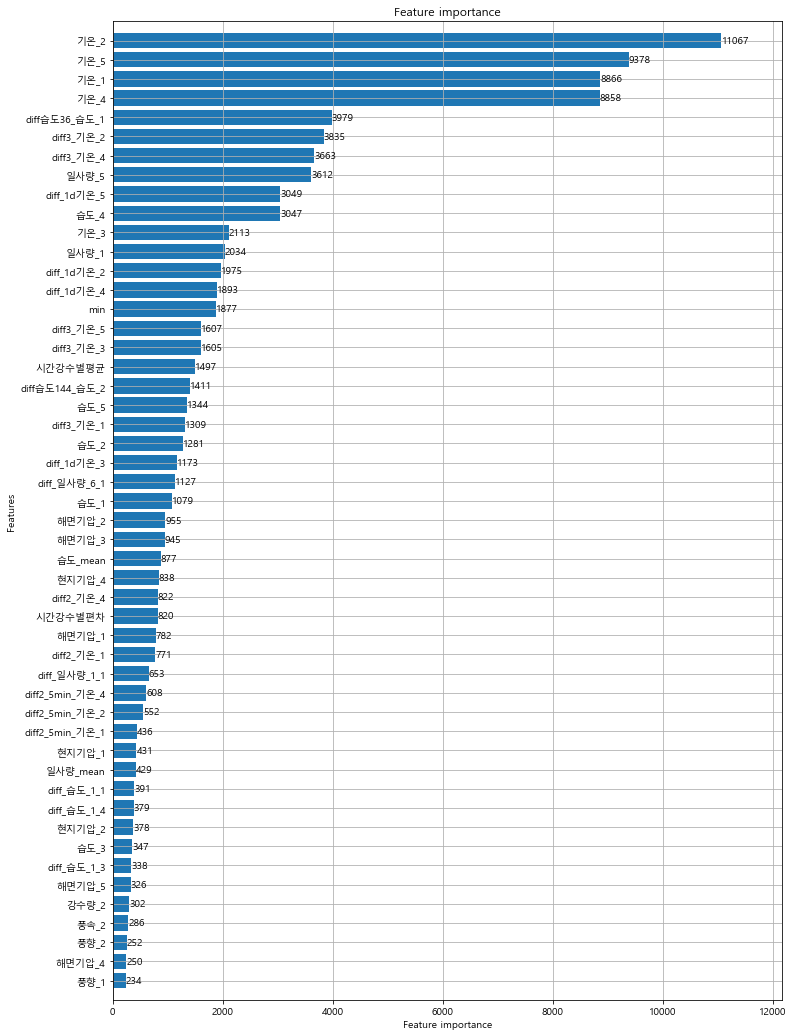

In [117]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

train_x, train_cv, y, y_cv = train_test_split(X_train,y_train, test_size=0.15, random_state=1217)

def lgbm_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2284, num_rounds=18707):

    param = {}

    param['boosting'] = 'dart'
    
    param['objective'] = 'regression'

    param['learning_rate'] = 0.05

    param['max_depth'] = 10

    param['metric'] = 'rmse'
    
    param['is_training_metric'] = True
    
    param['min_child_weight'] = 1

    param['bagging_fraction'] = 0.8
    
    param['num_leaves'] = 128

    param['feature_fraction'] = 0.8

    param['bagging_freq'] = 6
    
    param['seed'] = seed_val
    
    param['min_split_gain'] = 0.01

    num_rounds = num_rounds

    plst = list(param.items())

    train_ds = lgb.Dataset(train_X, label=train_y)

    test_ds = lgb.Dataset(test_X, label=test_y)

    model = lgb.train(param, train_ds, num_rounds,test_ds, early_stopping_rounds=180)

    return model

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


model = lgbm_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)

from matplotlib import pylab as plt

fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)

plt.show()

In [118]:
y_test =  np.expm1(model.predict(X_test))+1

In [119]:
submission['Y18'] = y_test

In [120]:
submission.to_csv('data/Ensemble/col2_test.csv',index=False)

## COL3

In [121]:
X_train = data[COL3].iloc[:train.shape[0],:]
X_test = data[COL3].iloc[train.shape[0]:,:]

[1]	valid_0's rmse: 0.322237
[2]	valid_0's rmse: 0.306465
[3]	valid_0's rmse: 0.291383
[4]	valid_0's rmse: 0.277237
[5]	valid_0's rmse: 0.277633
[6]	valid_0's rmse: 0.264047
[7]	valid_0's rmse: 0.251385
[8]	valid_0's rmse: 0.239178
[9]	valid_0's rmse: 0.227682
[10]	valid_0's rmse: 0.216782
[11]	valid_0's rmse: 0.216755
[12]	valid_0's rmse: 0.206454
[13]	valid_0's rmse: 0.196551
[14]	valid_0's rmse: 0.198521
[15]	valid_0's rmse: 0.205276
[16]	valid_0's rmse: 0.19543
[17]	valid_0's rmse: 0.186153
[18]	valid_0's rmse: 0.177305
[19]	valid_0's rmse: 0.180924
[20]	valid_0's rmse: 0.172382
[21]	valid_0's rmse: 0.175302
[22]	valid_0's rmse: 0.166989
[23]	valid_0's rmse: 0.170103
[24]	valid_0's rmse: 0.162052
[25]	valid_0's rmse: 0.154323
[26]	valid_0's rmse: 0.146981
[27]	valid_0's rmse: 0.150787
[28]	valid_0's rmse: 0.143603
[29]	valid_0's rmse: 0.136824
[30]	valid_0's rmse: 0.395786
[31]	valid_0's rmse: 0.376174
[32]	valid_0's rmse: 0.357598
[33]	valid_0's rmse: 0.339951
[34]	valid_0's rmse:

[539]	valid_0's rmse: 0.198983
[540]	valid_0's rmse: 0.189292
[541]	valid_0's rmse: 0.195116
[542]	valid_0's rmse: 0.202627
[543]	valid_0's rmse: 0.192726
[544]	valid_0's rmse: 0.183333
[545]	valid_0's rmse: 0.202589
[546]	valid_0's rmse: 0.222104
[547]	valid_0's rmse: 0.211195
[548]	valid_0's rmse: 0.200863
[549]	valid_0's rmse: 0.191091
[550]	valid_0's rmse: 0.198249
[551]	valid_0's rmse: 0.205122
[552]	valid_0's rmse: 0.212074
[553]	valid_0's rmse: 0.201723
[554]	valid_0's rmse: 0.207444
[555]	valid_0's rmse: 0.213213
[556]	valid_0's rmse: 0.218855
[557]	valid_0's rmse: 0.224873
[558]	valid_0's rmse: 0.213875
[559]	valid_0's rmse: 0.203401
[560]	valid_0's rmse: 0.193491
[561]	valid_0's rmse: 0.199796
[562]	valid_0's rmse: 0.190032
[563]	valid_0's rmse: 0.196791
[564]	valid_0's rmse: 0.187185
[565]	valid_0's rmse: 0.193498
[566]	valid_0's rmse: 0.199059
[567]	valid_0's rmse: 0.189336
[568]	valid_0's rmse: 0.180129
[569]	valid_0's rmse: 0.171393
[570]	valid_0's rmse: 0.178546
[571]	va

[827]	valid_0's rmse: 0.110175
[828]	valid_0's rmse: 0.114268
[829]	valid_0's rmse: 0.118503
[830]	valid_0's rmse: 0.112974
[831]	valid_0's rmse: 0.107738
[832]	valid_0's rmse: 0.112454
[833]	valid_0's rmse: 0.107236
[834]	valid_0's rmse: 0.102306
[835]	valid_0's rmse: 0.0976162
[836]	valid_0's rmse: 0.101861
[837]	valid_0's rmse: 0.10569
[838]	valid_0's rmse: 0.109766
[839]	valid_0's rmse: 0.104669
[840]	valid_0's rmse: 0.108656
[841]	valid_0's rmse: 0.103651
[842]	valid_0's rmse: 0.107726
[843]	valid_0's rmse: 0.111551
[844]	valid_0's rmse: 0.106363
[845]	valid_0's rmse: 0.110626
[846]	valid_0's rmse: 0.105508
[847]	valid_0's rmse: 0.100623
[848]	valid_0's rmse: 0.105479
[849]	valid_0's rmse: 0.109744
[850]	valid_0's rmse: 0.104658
[851]	valid_0's rmse: 0.0998392
[852]	valid_0's rmse: 0.0952986
[853]	valid_0's rmse: 0.0997967
[854]	valid_0's rmse: 0.0952555
[855]	valid_0's rmse: 0.0992385
[856]	valid_0's rmse: 0.103269
[857]	valid_0's rmse: 0.0985393
[858]	valid_0's rmse: 0.0940598
[

[1092]	valid_0's rmse: 0.0654692
[1093]	valid_0's rmse: 0.062816
[1094]	valid_0's rmse: 0.0654567
[1095]	valid_0's rmse: 0.0627862
[1096]	valid_0's rmse: 0.0603059
[1097]	valid_0's rmse: 0.063075
[1098]	valid_0's rmse: 0.0658351
[1099]	valid_0's rmse: 0.0685095
[1100]	valid_0's rmse: 0.0710176
[1101]	valid_0's rmse: 0.0741064
[1102]	valid_0's rmse: 0.0768257
[1103]	valid_0's rmse: 0.0796575
[1104]	valid_0's rmse: 0.0830398
[1105]	valid_0's rmse: 0.0860199
[1106]	valid_0's rmse: 0.0890934
[1107]	valid_0's rmse: 0.0917697
[1108]	valid_0's rmse: 0.0954949
[1109]	valid_0's rmse: 0.0911546
[1110]	valid_0's rmse: 0.0870255
[1111]	valid_0's rmse: 0.0831543
[1112]	valid_0's rmse: 0.0952552
[1113]	valid_0's rmse: 0.0983691
[1114]	valid_0's rmse: 0.0938881
[1115]	valid_0's rmse: 0.089633
[1116]	valid_0's rmse: 0.101816
[1117]	valid_0's rmse: 0.09716
[1118]	valid_0's rmse: 0.100221
[1119]	valid_0's rmse: 0.103804
[1120]	valid_0's rmse: 0.107144
[1121]	valid_0's rmse: 0.102206
[1122]	valid_0's rms

[1377]	valid_0's rmse: 0.0598322
[1378]	valid_0's rmse: 0.0575134
[1379]	valid_0's rmse: 0.0593741
[1380]	valid_0's rmse: 0.0570871
[1381]	valid_0's rmse: 0.05494
[1382]	valid_0's rmse: 0.0529283
[1383]	valid_0's rmse: 0.0510431
[1384]	valid_0's rmse: 0.053008
[1385]	valid_0's rmse: 0.0548527
[1386]	valid_0's rmse: 0.0574064
[1387]	valid_0's rmse: 0.0596589
[1388]	valid_0's rmse: 0.0573617
[1389]	valid_0's rmse: 0.0551896
[1390]	valid_0's rmse: 0.0574342
[1391]	valid_0's rmse: 0.0601276
[1392]	valid_0's rmse: 0.0577928
[1393]	valid_0's rmse: 0.0602373
[1394]	valid_0's rmse: 0.0698855
[1395]	valid_0's rmse: 0.0669568
[1396]	valid_0's rmse: 0.0693583
[1397]	valid_0's rmse: 0.0718157
[1398]	valid_0's rmse: 0.0740252
[1399]	valid_0's rmse: 0.0708908
[1400]	valid_0's rmse: 0.0679209
[1401]	valid_0's rmse: 0.0651209
[1402]	valid_0's rmse: 0.0624962
[1403]	valid_0's rmse: 0.0600172
[1404]	valid_0's rmse: 0.0576706
[1405]	valid_0's rmse: 0.059605
[1406]	valid_0's rmse: 0.0616822
[1407]	valid_0

[1634]	valid_0's rmse: 0.067172
[1635]	valid_0's rmse: 0.0644241
[1636]	valid_0's rmse: 0.0663465
[1637]	valid_0's rmse: 0.0682617
[1638]	valid_0's rmse: 0.0697885
[1639]	valid_0's rmse: 0.0668833
[1640]	valid_0's rmse: 0.0689327
[1641]	valid_0's rmse: 0.0711472
[1642]	valid_0's rmse: 0.0681675
[1643]	valid_0's rmse: 0.0703608
[1644]	valid_0's rmse: 0.0722499
[1645]	valid_0's rmse: 0.0691899
[1646]	valid_0's rmse: 0.066324
[1647]	valid_0's rmse: 0.0683901
[1648]	valid_0's rmse: 0.065571
[1649]	valid_0's rmse: 0.062923
[1650]	valid_0's rmse: 0.0646882
[1651]	valid_0's rmse: 0.0667375
[1652]	valid_0's rmse: 0.0640059
[1653]	valid_0's rmse: 0.0661235
[1654]	valid_0's rmse: 0.0634559
[1655]	valid_0's rmse: 0.0609329
[1656]	valid_0's rmse: 0.0630781
[1657]	valid_0's rmse: 0.0605889
[1658]	valid_0's rmse: 0.0582411
[1659]	valid_0's rmse: 0.0560335
[1660]	valid_0's rmse: 0.0539693
[1661]	valid_0's rmse: 0.0520327
[1662]	valid_0's rmse: 0.053676
[1663]	valid_0's rmse: 0.0517486
[1664]	valid_0'

[1896]	valid_0's rmse: 0.0481157
[1897]	valid_0's rmse: 0.0465549
[1898]	valid_0's rmse: 0.0479125
[1899]	valid_0's rmse: 0.0463639
[1900]	valid_0's rmse: 0.0476935
[1901]	valid_0's rmse: 0.0461506
[1902]	valid_0's rmse: 0.0447113
[1903]	valid_0's rmse: 0.0462002
[1904]	valid_0's rmse: 0.0475369
[1905]	valid_0's rmse: 0.0489001
[1906]	valid_0's rmse: 0.0505629
[1907]	valid_0's rmse: 0.0488592
[1908]	valid_0's rmse: 0.0472654
[1909]	valid_0's rmse: 0.0540311
[1910]	valid_0's rmse: 0.0520729
[1911]	valid_0's rmse: 0.0502377
[1912]	valid_0's rmse: 0.0516908
[1913]	valid_0's rmse: 0.0498969
[1914]	valid_0's rmse: 0.0481925
[1915]	valid_0's rmse: 0.0494929
[1916]	valid_0's rmse: 0.0478352
[1917]	valid_0's rmse: 0.0462923
[1918]	valid_0's rmse: 0.0448525
[1919]	valid_0's rmse: 0.0435087
[1920]	valid_0's rmse: 0.0448112
[1921]	valid_0's rmse: 0.0462395
[1922]	valid_0's rmse: 0.0481158
[1923]	valid_0's rmse: 0.0465523
[1924]	valid_0's rmse: 0.045084
[1925]	valid_0's rmse: 0.046893
[1926]	valid

[2145]	valid_0's rmse: 0.0488467
[2146]	valid_0's rmse: 0.0502471
[2147]	valid_0's rmse: 0.0521629
[2148]	valid_0's rmse: 0.0534847
[2149]	valid_0's rmse: 0.055191
[2150]	valid_0's rmse: 0.0531652
[2151]	valid_0's rmse: 0.0547817
[2152]	valid_0's rmse: 0.056225
[2153]	valid_0's rmse: 0.0541452
[2154]	valid_0's rmse: 0.0521903
[2155]	valid_0's rmse: 0.0536252
[2156]	valid_0's rmse: 0.051705
[2157]	valid_0's rmse: 0.0532082
[2158]	valid_0's rmse: 0.0542525
[2159]	valid_0's rmse: 0.0522942
[2160]	valid_0's rmse: 0.0538992
[2161]	valid_0's rmse: 0.0519775
[2162]	valid_0's rmse: 0.0501735
[2163]	valid_0's rmse: 0.048494
[2164]	valid_0's rmse: 0.0500549
[2165]	valid_0's rmse: 0.0483871
[2166]	valid_0's rmse: 0.0497544
[2167]	valid_0's rmse: 0.0480782
[2168]	valid_0's rmse: 0.046521
[2169]	valid_0's rmse: 0.0477679
[2170]	valid_0's rmse: 0.0492154
[2171]	valid_0's rmse: 0.0475715
[2172]	valid_0's rmse: 0.0460471
[2173]	valid_0's rmse: 0.0473161
[2174]	valid_0's rmse: 0.0458114
[2175]	valid_0'

[2395]	valid_0's rmse: 0.0418059
[2396]	valid_0's rmse: 0.0406794
[2397]	valid_0's rmse: 0.0418041
[2398]	valid_0's rmse: 0.0406707
[2399]	valid_0's rmse: 0.0417593
[2400]	valid_0's rmse: 0.0406217
[2401]	valid_0's rmse: 0.0418184
[2402]	valid_0's rmse: 0.04282
[2403]	valid_0's rmse: 0.0416301
[2404]	valid_0's rmse: 0.0430592
[2405]	valid_0's rmse: 0.0418521
[2406]	valid_0's rmse: 0.0428188
[2407]	valid_0's rmse: 0.0443053
[2408]	valid_0's rmse: 0.0430024
[2409]	valid_0's rmse: 0.0440517
[2410]	valid_0's rmse: 0.0449492
[2411]	valid_0's rmse: 0.04359
[2412]	valid_0's rmse: 0.0446472
[2413]	valid_0's rmse: 0.043335
[2414]	valid_0's rmse: 0.0447957
[2415]	valid_0's rmse: 0.0434683
[2416]	valid_0's rmse: 0.0443856
[2417]	valid_0's rmse: 0.0453244
[2418]	valid_0's rmse: 0.0463152
[2419]	valid_0's rmse: 0.0448926
[2420]	valid_0's rmse: 0.0435597
[2421]	valid_0's rmse: 0.0445607
[2422]	valid_0's rmse: 0.0456355
[2423]	valid_0's rmse: 0.0470046
[2424]	valid_0's rmse: 0.0484133
[2425]	valid_0'

[2673]	valid_0's rmse: 0.0413326
[2674]	valid_0's rmse: 0.0423011
[2675]	valid_0's rmse: 0.0435079
[2676]	valid_0's rmse: 0.0444992
[2677]	valid_0's rmse: 0.0455272
[2678]	valid_0's rmse: 0.0467908
[2679]	valid_0's rmse: 0.0453316
[2680]	valid_0's rmse: 0.0439642
[2681]	valid_0's rmse: 0.0426974
[2682]	valid_0's rmse: 0.0437666
[2683]	valid_0's rmse: 0.044596
[2684]	valid_0's rmse: 0.0455062
[2685]	valid_0's rmse: 0.0441324
[2686]	valid_0's rmse: 0.0452792
[2687]	valid_0's rmse: 0.0463861
[2688]	valid_0's rmse: 0.0474358
[2689]	valid_0's rmse: 0.0486891
[2690]	valid_0's rmse: 0.0471023
[2691]	valid_0's rmse: 0.0456149
[2692]	valid_0's rmse: 0.0466107
[2693]	valid_0's rmse: 0.0474674
[2694]	valid_0's rmse: 0.0459714
[2695]	valid_0's rmse: 0.0445762
[2696]	valid_0's rmse: 0.0458253
[2697]	valid_0's rmse: 0.0444436
[2698]	valid_0's rmse: 0.0431556
[2699]	valid_0's rmse: 0.0443202
[2700]	valid_0's rmse: 0.0453382
[2701]	valid_0's rmse: 0.0439807
[2702]	valid_0's rmse: 0.0451466
[2703]	vali

[2940]	valid_0's rmse: 0.051536
[2941]	valid_0's rmse: 0.0497571
[2942]	valid_0's rmse: 0.0509941
[2943]	valid_0's rmse: 0.0520875
[2944]	valid_0's rmse: 0.0528485
[2945]	valid_0's rmse: 0.0538505
[2946]	valid_0's rmse: 0.05467
[2947]	valid_0's rmse: 0.0558505
[2948]	valid_0's rmse: 0.053808
[2949]	valid_0's rmse: 0.0518919
[2950]	valid_0's rmse: 0.0527527
[2951]	valid_0's rmse: 0.0509063
[2952]	valid_0's rmse: 0.0518282
[2953]	valid_0's rmse: 0.0528411
[2954]	valid_0's rmse: 0.0538837
[2955]	valid_0's rmse: 0.0547784
[2956]	valid_0's rmse: 0.0527952
[2957]	valid_0's rmse: 0.0538866
[2958]	valid_0's rmse: 0.0519681
[2959]	valid_0's rmse: 0.0501509
[2960]	valid_0's rmse: 0.0484339
[2961]	valid_0's rmse: 0.0494228
[2962]	valid_0's rmse: 0.0503817
[2963]	valid_0's rmse: 0.0512181
[2964]	valid_0's rmse: 0.0522136
[2965]	valid_0's rmse: 0.0504031
[2966]	valid_0's rmse: 0.0487074
[2967]	valid_0's rmse: 0.0471241
[2968]	valid_0's rmse: 0.0481146
[2969]	valid_0's rmse: 0.0491023
[2970]	valid_0

[3208]	valid_0's rmse: 0.0374819
[3209]	valid_0's rmse: 0.0382252
[3210]	valid_0's rmse: 0.0373748
[3211]	valid_0's rmse: 0.0381274
[3212]	valid_0's rmse: 0.0372782
[3213]	valid_0's rmse: 0.0381644
[3214]	valid_0's rmse: 0.0373061
[3215]	valid_0's rmse: 0.0365171
[3216]	valid_0's rmse: 0.0357927
[3217]	valid_0's rmse: 0.0364984
[3218]	valid_0's rmse: 0.0372403
[3219]	valid_0's rmse: 0.0364527
[3220]	valid_0's rmse: 0.0371043
[3221]	valid_0's rmse: 0.0363195
[3222]	valid_0's rmse: 0.0370031
[3223]	valid_0's rmse: 0.0362503
[3224]	valid_0's rmse: 0.0355531
[3225]	valid_0's rmse: 0.0349094
[3226]	valid_0's rmse: 0.0343159
[3227]	valid_0's rmse: 0.0337707
[3228]	valid_0's rmse: 0.0332702
[3229]	valid_0's rmse: 0.0328042
[3230]	valid_0's rmse: 0.0323841
[3231]	valid_0's rmse: 0.0319845
[3232]	valid_0's rmse: 0.0324409
[3233]	valid_0's rmse: 0.0330271
[3234]	valid_0's rmse: 0.0325912
[3235]	valid_0's rmse: 0.0321817
[3236]	valid_0's rmse: 0.0318102
[3237]	valid_0's rmse: 0.0314577
[3238]	val

[3462]	valid_0's rmse: 0.0360225
[3463]	valid_0's rmse: 0.0365375
[3464]	valid_0's rmse: 0.0358205
[3465]	valid_0's rmse: 0.0351562
[3466]	valid_0's rmse: 0.0357444
[3467]	valid_0's rmse: 0.0364319
[3468]	valid_0's rmse: 0.0371052
[3469]	valid_0's rmse: 0.0379245
[3470]	valid_0's rmse: 0.0383893
[3471]	valid_0's rmse: 0.0390392
[3472]	valid_0's rmse: 0.0381255
[3473]	valid_0's rmse: 0.0372792
[3474]	valid_0's rmse: 0.0364936
[3475]	valid_0's rmse: 0.0357628
[3476]	valid_0's rmse: 0.0363226
[3477]	valid_0's rmse: 0.0356045
[3478]	valid_0's rmse: 0.0349394
[3479]	valid_0's rmse: 0.034334
[3480]	valid_0's rmse: 0.0337762
[3481]	valid_0's rmse: 0.0346329
[3482]	valid_0's rmse: 0.034043
[3483]	valid_0's rmse: 0.0344719
[3484]	valid_0's rmse: 0.0351385
[3485]	valid_0's rmse: 0.0360429
[3486]	valid_0's rmse: 0.0366046
[3487]	valid_0's rmse: 0.0371217
[3488]	valid_0's rmse: 0.0376261
[3489]	valid_0's rmse: 0.0383134
[3490]	valid_0's rmse: 0.0374581
[3491]	valid_0's rmse: 0.0366682
[3492]	valid

[3751]	valid_0's rmse: 0.0336685
[3752]	valid_0's rmse: 0.0331724
[3753]	valid_0's rmse: 0.0327209
[3754]	valid_0's rmse: 0.0323032
[3755]	valid_0's rmse: 0.0328717
[3756]	valid_0's rmse: 0.0333284
[3757]	valid_0's rmse: 0.0328678
[3758]	valid_0's rmse: 0.0333488
[3759]	valid_0's rmse: 0.0337982
[3760]	valid_0's rmse: 0.0344032
[3761]	valid_0's rmse: 0.0349511
[3762]	valid_0's rmse: 0.0343429
[3763]	valid_0's rmse: 0.0348325
[3764]	valid_0's rmse: 0.0342433
[3765]	valid_0's rmse: 0.033693
[3766]	valid_0's rmse: 0.0331972
[3767]	valid_0's rmse: 0.0327352
[3768]	valid_0's rmse: 0.033412
[3769]	valid_0's rmse: 0.0339258
[3770]	valid_0's rmse: 0.0343181
[3771]	valid_0's rmse: 0.0337624
[3772]	valid_0's rmse: 0.0342666
[3773]	valid_0's rmse: 0.0337185
[3774]	valid_0's rmse: 0.034189
[3775]	valid_0's rmse: 0.034642
[3776]	valid_0's rmse: 0.0353675
[3777]	valid_0's rmse: 0.0347455
[3778]	valid_0's rmse: 0.0351466
[3779]	valid_0's rmse: 0.0356246
[3780]	valid_0's rmse: 0.0363669
[3781]	valid_0

[4039]	valid_0's rmse: 0.0376535
[4040]	valid_0's rmse: 0.0380327
[4041]	valid_0's rmse: 0.0385525
[4042]	valid_0's rmse: 0.0376858
[4043]	valid_0's rmse: 0.038441
[4044]	valid_0's rmse: 0.0391545
[4045]	valid_0's rmse: 0.0382488
[4046]	valid_0's rmse: 0.0388442
[4047]	valid_0's rmse: 0.0379449
[4048]	valid_0's rmse: 0.0371275
[4049]	valid_0's rmse: 0.037781
[4050]	valid_0's rmse: 0.0385
[4051]	valid_0's rmse: 0.0391298
[4052]	valid_0's rmse: 0.0398257
[4053]	valid_0's rmse: 0.0388592
[4054]	valid_0's rmse: 0.0392914
[4055]	valid_0's rmse: 0.0383653
[4056]	valid_0's rmse: 0.0375073
[4057]	valid_0's rmse: 0.0382549
[4058]	valid_0's rmse: 0.0390194
[4059]	valid_0's rmse: 0.0397109
[4060]	valid_0's rmse: 0.0404362
[4061]	valid_0's rmse: 0.0394429
[4062]	valid_0's rmse: 0.0399206
[4063]	valid_0's rmse: 0.0405482
[4064]	valid_0's rmse: 0.0395387
[4065]	valid_0's rmse: 0.0402379
[4066]	valid_0's rmse: 0.0392374
[4067]	valid_0's rmse: 0.0383138
[4068]	valid_0's rmse: 0.0374603
[4069]	valid_0'

[4300]	valid_0's rmse: 0.0303497
[4301]	valid_0's rmse: 0.0303497
[4302]	valid_0's rmse: 0.0306345
[4303]	valid_0's rmse: 0.0303975
[4304]	valid_0's rmse: 0.030176
[4305]	valid_0's rmse: 0.0304072
[4306]	valid_0's rmse: 0.0301841
[4307]	valid_0's rmse: 0.0299837
[4308]	valid_0's rmse: 0.0298025
[4309]	valid_0's rmse: 0.0302312
[4310]	valid_0's rmse: 0.0305469
[4311]	valid_0's rmse: 0.030857
[4312]	valid_0's rmse: 0.0306033
[4313]	valid_0's rmse: 0.0303669
[4314]	valid_0's rmse: 0.0306452
[4315]	valid_0's rmse: 0.0309565
[4316]	valid_0's rmse: 0.0313246
[4317]	valid_0's rmse: 0.0316604
[4318]	valid_0's rmse: 0.0320325
[4319]	valid_0's rmse: 0.0316797
[4320]	valid_0's rmse: 0.0320212
[4321]	valid_0's rmse: 0.031659
[4322]	valid_0's rmse: 0.0313341
[4323]	valid_0's rmse: 0.0317096
[4324]	valid_0's rmse: 0.0321867
[4325]	valid_0's rmse: 0.031823
[4326]	valid_0's rmse: 0.0314799
[4327]	valid_0's rmse: 0.0311801
[4328]	valid_0's rmse: 0.0314588
[4329]	valid_0's rmse: 0.0319065
[4330]	valid_0

[4585]	valid_0's rmse: 0.0306426
[4586]	valid_0's rmse: 0.0309776
[4587]	valid_0's rmse: 0.0307242
[4588]	valid_0's rmse: 0.0304926
[4589]	valid_0's rmse: 0.0309209
[4590]	valid_0's rmse: 0.0312634
[4591]	valid_0's rmse: 0.0309864
[4592]	valid_0's rmse: 0.0307326
[4593]	valid_0's rmse: 0.030492
[4594]	valid_0's rmse: 0.030276
[4595]	valid_0's rmse: 0.0300815
[4596]	valid_0's rmse: 0.0303269
[4597]	valid_0's rmse: 0.0306459
[4598]	valid_0's rmse: 0.030421
[4599]	valid_0's rmse: 0.0307669
[4600]	valid_0's rmse: 0.0311355
[4601]	valid_0's rmse: 0.031416
[4602]	valid_0's rmse: 0.0317621
[4603]	valid_0's rmse: 0.0314368
[4604]	valid_0's rmse: 0.0311404
[4605]	valid_0's rmse: 0.0308378
[4606]	valid_0's rmse: 0.0305699
[4607]	valid_0's rmse: 0.0308855
[4608]	valid_0's rmse: 0.0312623
[4609]	valid_0's rmse: 0.0315849
[4610]	valid_0's rmse: 0.031967
[4611]	valid_0's rmse: 0.0316267
[4612]	valid_0's rmse: 0.0313114
[4613]	valid_0's rmse: 0.031686
[4614]	valid_0's rmse: 0.0321052
[4615]	valid_0's

[4859]	valid_0's rmse: 0.0335394
[4860]	valid_0's rmse: 0.0330646
[4861]	valid_0's rmse: 0.0334606
[4862]	valid_0's rmse: 0.0329809
[4863]	valid_0's rmse: 0.03255
[4864]	valid_0's rmse: 0.0329533
[4865]	valid_0's rmse: 0.0325167
[4866]	valid_0's rmse: 0.0328686
[4867]	valid_0's rmse: 0.0324404
[4868]	valid_0's rmse: 0.0320477
[4869]	valid_0's rmse: 0.0317013
[4870]	valid_0's rmse: 0.0319678
[4871]	valid_0's rmse: 0.0323448
[4872]	valid_0's rmse: 0.0326433
[4873]	valid_0's rmse: 0.0330658
[4874]	valid_0's rmse: 0.0326403
[4875]	valid_0's rmse: 0.0329873
[4876]	valid_0's rmse: 0.0333618
[4877]	valid_0's rmse: 0.0336994
[4878]	valid_0's rmse: 0.034172
[4879]	valid_0's rmse: 0.0344981
[4880]	valid_0's rmse: 0.033953
[4881]	valid_0's rmse: 0.034235
[4882]	valid_0's rmse: 0.0337077
[4883]	valid_0's rmse: 0.0332225
[4884]	valid_0's rmse: 0.0327737
[4885]	valid_0's rmse: 0.0331166
[4886]	valid_0's rmse: 0.0326805
[4887]	valid_0's rmse: 0.032276
[4888]	valid_0's rmse: 0.0326019
[4889]	valid_0's

[5148]	valid_0's rmse: 0.0306375
[5149]	valid_0's rmse: 0.0309066
[5150]	valid_0's rmse: 0.0306607
[5151]	valid_0's rmse: 0.0304253
[5152]	valid_0's rmse: 0.0302123
[5153]	valid_0's rmse: 0.0303968
[5154]	valid_0's rmse: 0.0307107
[5155]	valid_0's rmse: 0.0304708
[5156]	valid_0's rmse: 0.0302568
[5157]	valid_0's rmse: 0.0300616
[5158]	valid_0's rmse: 0.0303365
[5159]	valid_0's rmse: 0.0306079
[5160]	valid_0's rmse: 0.0308842
[5161]	valid_0's rmse: 0.0306346
[5162]	valid_0's rmse: 0.0309356
[5163]	valid_0's rmse: 0.0312565
[5164]	valid_0's rmse: 0.030977
[5165]	valid_0's rmse: 0.0313645
[5166]	valid_0's rmse: 0.0310681
[5167]	valid_0's rmse: 0.0307958
[5168]	valid_0's rmse: 0.030556
[5169]	valid_0's rmse: 0.0307917
[5170]	valid_0's rmse: 0.0305573
[5171]	valid_0's rmse: 0.0307731
[5172]	valid_0's rmse: 0.0310584
[5173]	valid_0's rmse: 0.0308019
[5174]	valid_0's rmse: 0.031029
[5175]	valid_0's rmse: 0.0307758
[5176]	valid_0's rmse: 0.0305446
[5177]	valid_0's rmse: 0.0308055
[5178]	valid_

[5438]	valid_0's rmse: 0.0309974
[5439]	valid_0's rmse: 0.0311943
[5440]	valid_0's rmse: 0.0314305
[5441]	valid_0's rmse: 0.0316327
[5442]	valid_0's rmse: 0.0318233
[5443]	valid_0's rmse: 0.0314877
[5444]	valid_0's rmse: 0.0316956
[5445]	valid_0's rmse: 0.032011
[5446]	valid_0's rmse: 0.031673
[5447]	valid_0's rmse: 0.0313686
[5448]	valid_0's rmse: 0.031564
[5449]	valid_0's rmse: 0.0312589
[5450]	valid_0's rmse: 0.0309877
[5451]	valid_0's rmse: 0.03074
[5452]	valid_0's rmse: 0.0309987
[5453]	valid_0's rmse: 0.0307499
[5454]	valid_0's rmse: 0.0310263
[5455]	valid_0's rmse: 0.0307739
[5456]	valid_0's rmse: 0.0305462
[5457]	valid_0's rmse: 0.0307706
[5458]	valid_0's rmse: 0.0309996
[5459]	valid_0's rmse: 0.0312481
[5460]	valid_0's rmse: 0.0309798
[5461]	valid_0's rmse: 0.030738
[5462]	valid_0's rmse: 0.0305185
[5463]	valid_0's rmse: 0.0307286
[5464]	valid_0's rmse: 0.0305093
[5465]	valid_0's rmse: 0.0306858
[5466]	valid_0's rmse: 0.0309447
[5467]	valid_0's rmse: 0.0307027
[5468]	valid_0's

[5714]	valid_0's rmse: 0.0320627
[5715]	valid_0's rmse: 0.0317278
[5716]	valid_0's rmse: 0.0319549
[5717]	valid_0's rmse: 0.0316166
[5718]	valid_0's rmse: 0.0319541
[5719]	valid_0's rmse: 0.0321573
[5720]	valid_0's rmse: 0.031807
[5721]	valid_0's rmse: 0.0321585
[5722]	valid_0's rmse: 0.0324889
[5723]	valid_0's rmse: 0.0321201
[5724]	valid_0's rmse: 0.032458
[5725]	valid_0's rmse: 0.0320856
[5726]	valid_0's rmse: 0.0317518
[5727]	valid_0's rmse: 0.0319905
[5728]	valid_0's rmse: 0.0316555
[5729]	valid_0's rmse: 0.032065
[5730]	valid_0's rmse: 0.0317204
[5731]	valid_0's rmse: 0.0319753
[5732]	valid_0's rmse: 0.0316505
[5733]	valid_0's rmse: 0.0313563
[5734]	valid_0's rmse: 0.0310843
[5735]	valid_0's rmse: 0.0312526
[5736]	valid_0's rmse: 0.0314555
[5737]	valid_0's rmse: 0.0317651
[5738]	valid_0's rmse: 0.0320209
[5739]	valid_0's rmse: 0.0323575
[5740]	valid_0's rmse: 0.0319979
[5741]	valid_0's rmse: 0.0316691
[5742]	valid_0's rmse: 0.0319678
[5743]	valid_0's rmse: 0.0323936
[5744]	valid_

[5974]	valid_0's rmse: 0.0305589
[5975]	valid_0's rmse: 0.0305589
[5976]	valid_0's rmse: 0.0307877
[5977]	valid_0's rmse: 0.0309815
[5978]	valid_0's rmse: 0.03074
[5979]	valid_0's rmse: 0.03074
[5980]	valid_0's rmse: 0.0309004
[5981]	valid_0's rmse: 0.0311675
[5982]	valid_0's rmse: 0.0309085
[5983]	valid_0's rmse: 0.0306805
[5984]	valid_0's rmse: 0.0306805
[5985]	valid_0's rmse: 0.0306805
[5986]	valid_0's rmse: 0.0309708
[5987]	valid_0's rmse: 0.0307347
[5988]	valid_0's rmse: 0.0307347
[5989]	valid_0's rmse: 0.0309266
[5990]	valid_0's rmse: 0.0306814
[5991]	valid_0's rmse: 0.0308432
[5992]	valid_0's rmse: 0.0311493
[5993]	valid_0's rmse: 0.0313321
[5994]	valid_0's rmse: 0.0315476
[5995]	valid_0's rmse: 0.0312572
[5996]	valid_0's rmse: 0.0314686
[5997]	valid_0's rmse: 0.0311871
[5998]	valid_0's rmse: 0.031457
[5999]	valid_0's rmse: 0.0311772
[6000]	valid_0's rmse: 0.0311772
[6001]	valid_0's rmse: 0.0311772
[6002]	valid_0's rmse: 0.0311772
[6003]	valid_0's rmse: 0.0313803
[6004]	valid_0'

[6262]	valid_0's rmse: 0.0314097
[6263]	valid_0's rmse: 0.0316706
[6264]	valid_0's rmse: 0.0319291
[6265]	valid_0's rmse: 0.0322432
[6266]	valid_0's rmse: 0.0319067
[6267]	valid_0's rmse: 0.0322297
[6268]	valid_0's rmse: 0.0322297
[6269]	valid_0's rmse: 0.0325725
[6270]	valid_0's rmse: 0.0322124
[6271]	valid_0's rmse: 0.032578
[6272]	valid_0's rmse: 0.0328575
[6273]	valid_0's rmse: 0.0324742
[6274]	valid_0's rmse: 0.032802
[6275]	valid_0's rmse: 0.0330404
[6276]	valid_0's rmse: 0.0326369
[6277]	valid_0's rmse: 0.0328755
[6278]	valid_0's rmse: 0.032472
[6279]	valid_0's rmse: 0.0328007
[6280]	valid_0's rmse: 0.0324034
[6281]	valid_0's rmse: 0.0327294
[6282]	valid_0's rmse: 0.0323538
[6283]	valid_0's rmse: 0.0320121
[6284]	valid_0's rmse: 0.0316927
[6285]	valid_0's rmse: 0.0319473
[6286]	valid_0's rmse: 0.0316409
[6287]	valid_0's rmse: 0.0319423
[6288]	valid_0's rmse: 0.0316239
[6289]	valid_0's rmse: 0.0318178
[6290]	valid_0's rmse: 0.032252
[6291]	valid_0's rmse: 0.0319137
[6292]	valid_0

[6540]	valid_0's rmse: 0.0327186
[6541]	valid_0's rmse: 0.0323483
[6542]	valid_0's rmse: 0.0319927
[6543]	valid_0's rmse: 0.0316781
[6544]	valid_0's rmse: 0.0319084
[6545]	valid_0's rmse: 0.0315953
[6546]	valid_0's rmse: 0.031308
[6547]	valid_0's rmse: 0.031308
[6548]	valid_0's rmse: 0.031308
[6549]	valid_0's rmse: 0.0314687
[6550]	valid_0's rmse: 0.0317468
[6551]	valid_0's rmse: 0.0319845
[6552]	valid_0's rmse: 0.0323019
[6553]	valid_0's rmse: 0.0319559
[6554]	valid_0's rmse: 0.0322162
[6555]	valid_0's rmse: 0.0324691
[6556]	valid_0's rmse: 0.0328107
[6557]	valid_0's rmse: 0.0331179
[6558]	valid_0's rmse: 0.032712
[6559]	valid_0's rmse: 0.0323456
[6560]	valid_0's rmse: 0.0325717
[6561]	valid_0's rmse: 0.0328878
[6562]	valid_0's rmse: 0.0324995
[6563]	valid_0's rmse: 0.0321399
[6564]	valid_0's rmse: 0.0324162
[6565]	valid_0's rmse: 0.0326558
[6566]	valid_0's rmse: 0.0330196
[6567]	valid_0's rmse: 0.0326241
[6568]	valid_0's rmse: 0.0322596
[6569]	valid_0's rmse: 0.0325131
[6570]	valid_0

[6836]	valid_0's rmse: 0.032143
[6837]	valid_0's rmse: 0.0318288
[6838]	valid_0's rmse: 0.0320868
[6839]	valid_0's rmse: 0.0317706
[6840]	valid_0's rmse: 0.0314763
[6841]	valid_0's rmse: 0.0316761
[6842]	valid_0's rmse: 0.0318699
[6843]	valid_0's rmse: 0.031571
[6844]	valid_0's rmse: 0.0313022
[6845]	valid_0's rmse: 0.0315242
[6846]	valid_0's rmse: 0.0318538
[6847]	valid_0's rmse: 0.0315613
[6848]	valid_0's rmse: 0.0318813
[6849]	valid_0's rmse: 0.0320627
[6850]	valid_0's rmse: 0.0317409
[6851]	valid_0's rmse: 0.0314528
[6852]	valid_0's rmse: 0.0316751
[6853]	valid_0's rmse: 0.0313867
[6854]	valid_0's rmse: 0.0311329
[6855]	valid_0's rmse: 0.0313805
[6856]	valid_0's rmse: 0.0316415
[6857]	valid_0's rmse: 0.0313685
[6858]	valid_0's rmse: 0.0315667
[6859]	valid_0's rmse: 0.0313007
[6860]	valid_0's rmse: 0.031503
[6861]	valid_0's rmse: 0.0312379
[6862]	valid_0's rmse: 0.0312379
[6863]	valid_0's rmse: 0.0314424
[6864]	valid_0's rmse: 0.0314424
[6865]	valid_0's rmse: 0.0311812
[6866]	valid_

[7128]	valid_0's rmse: 0.0309449
[7129]	valid_0's rmse: 0.0307264
[7130]	valid_0's rmse: 0.0308574
[7131]	valid_0's rmse: 0.0306532
[7132]	valid_0's rmse: 0.0304657
[7133]	valid_0's rmse: 0.0302957
[7134]	valid_0's rmse: 0.0305193
[7135]	valid_0's rmse: 0.0307032
[7136]	valid_0's rmse: 0.0305042
[7137]	valid_0's rmse: 0.0303282
[7138]	valid_0's rmse: 0.0305414
[7139]	valid_0's rmse: 0.030357
[7140]	valid_0's rmse: 0.0301897
[7141]	valid_0's rmse: 0.03039
[7142]	valid_0's rmse: 0.0305337
[7143]	valid_0's rmse: 0.0305337
[7144]	valid_0's rmse: 0.0307311
[7145]	valid_0's rmse: 0.0308923
[7146]	valid_0's rmse: 0.0308923
[7147]	valid_0's rmse: 0.0310749
[7148]	valid_0's rmse: 0.0310749
[7149]	valid_0's rmse: 0.03122
[7150]	valid_0's rmse: 0.03122
[7151]	valid_0's rmse: 0.03122
[7152]	valid_0's rmse: 0.0314607
[7153]	valid_0's rmse: 0.0316646
[7154]	valid_0's rmse: 0.0318551
[7155]	valid_0's rmse: 0.031992
[7156]	valid_0's rmse: 0.0316837
[7157]	valid_0's rmse: 0.0318971
[7158]	valid_0's rms

[7387]	valid_0's rmse: 0.0320151
[7388]	valid_0's rmse: 0.0321998
[7389]	valid_0's rmse: 0.0324446
[7390]	valid_0's rmse: 0.0321155
[7391]	valid_0's rmse: 0.0322666
[7392]	valid_0's rmse: 0.0319484
[7393]	valid_0's rmse: 0.0316483
[7394]	valid_0's rmse: 0.0313856
[7395]	valid_0's rmse: 0.0315212
[7396]	valid_0's rmse: 0.0312685
[7397]	valid_0's rmse: 0.0312685
[7398]	valid_0's rmse: 0.0314668
[7399]	valid_0's rmse: 0.0316411
[7400]	valid_0's rmse: 0.0313785
[7401]	valid_0's rmse: 0.0313785
[7402]	valid_0's rmse: 0.0315508
[7403]	valid_0's rmse: 0.0316996
[7404]	valid_0's rmse: 0.031892
[7405]	valid_0's rmse: 0.0320299
[7406]	valid_0's rmse: 0.0317356
[7407]	valid_0's rmse: 0.0317356
[7408]	valid_0's rmse: 0.0317356
[7409]	valid_0's rmse: 0.0319445
[7410]	valid_0's rmse: 0.0321325
[7411]	valid_0's rmse: 0.0321325
[7412]	valid_0's rmse: 0.0318291
[7413]	valid_0's rmse: 0.0319859
[7414]	valid_0's rmse: 0.0322027
[7415]	valid_0's rmse: 0.031878
[7416]	valid_0's rmse: 0.0321414
[7417]	valid

[7655]	valid_0's rmse: 0.0309405
[7656]	valid_0's rmse: 0.0307357
[7657]	valid_0's rmse: 0.0308951
[7658]	valid_0's rmse: 0.0306946
[7659]	valid_0's rmse: 0.0308469
[7660]	valid_0's rmse: 0.0309799
[7661]	valid_0's rmse: 0.0311938
[7662]	valid_0's rmse: 0.0313828
[7663]	valid_0's rmse: 0.0311453
[7664]	valid_0's rmse: 0.0309311
[7665]	valid_0's rmse: 0.0310778
[7666]	valid_0's rmse: 0.0308625
[7667]	valid_0's rmse: 0.0309728
[7668]	valid_0's rmse: 0.0311081
[7669]	valid_0's rmse: 0.0308866
[7670]	valid_0's rmse: 0.0309984
[7671]	valid_0's rmse: 0.0312151
[7672]	valid_0's rmse: 0.0309924
[7673]	valid_0's rmse: 0.0307859
[7674]	valid_0's rmse: 0.0307859
[7675]	valid_0's rmse: 0.0309325
[7676]	valid_0's rmse: 0.0307315
[7677]	valid_0's rmse: 0.0307315
[7678]	valid_0's rmse: 0.0310035
[7679]	valid_0's rmse: 0.0308018
[7680]	valid_0's rmse: 0.0309505
[7681]	valid_0's rmse: 0.0311386
[7682]	valid_0's rmse: 0.0313009
[7683]	valid_0's rmse: 0.031076
[7684]	valid_0's rmse: 0.0313854
[7685]	vali

[7908]	valid_0's rmse: 0.0321097
[7909]	valid_0's rmse: 0.0321097
[7910]	valid_0's rmse: 0.0321097
[7911]	valid_0's rmse: 0.032331
[7912]	valid_0's rmse: 0.0325432
[7913]	valid_0's rmse: 0.0322045
[7914]	valid_0's rmse: 0.0324806
[7915]	valid_0's rmse: 0.0324806
[7916]	valid_0's rmse: 0.0327056
[7917]	valid_0's rmse: 0.0329839
[7918]	valid_0's rmse: 0.0326055
[7919]	valid_0's rmse: 0.0322595
[7920]	valid_0's rmse: 0.0319434
[7921]	valid_0's rmse: 0.0322426
[7922]	valid_0's rmse: 0.0319197
[7923]	valid_0's rmse: 0.0316341
[7924]	valid_0's rmse: 0.0313736
[7925]	valid_0's rmse: 0.0314934
[7926]	valid_0's rmse: 0.0316637
[7927]	valid_0's rmse: 0.0314003
[7928]	valid_0's rmse: 0.0311602
[7929]	valid_0's rmse: 0.0313061
[7930]	valid_0's rmse: 0.031073
[7931]	valid_0's rmse: 0.0312285
[7932]	valid_0's rmse: 0.0312285
[7933]	valid_0's rmse: 0.0313803
[7934]	valid_0's rmse: 0.0311413
[7935]	valid_0's rmse: 0.0311413
[7936]	valid_0's rmse: 0.0312712
[7937]	valid_0's rmse: 0.0310363
[7938]	valid

[8170]	valid_0's rmse: 0.0312869
[8171]	valid_0's rmse: 0.0310602
[8172]	valid_0's rmse: 0.0311845
[8173]	valid_0's rmse: 0.0309644
[8174]	valid_0's rmse: 0.0311147
[8175]	valid_0's rmse: 0.0308969
[8176]	valid_0's rmse: 0.0306988
[8177]	valid_0's rmse: 0.0305208
[8178]	valid_0's rmse: 0.0303585
[8179]	valid_0's rmse: 0.0302055
[8180]	valid_0's rmse: 0.0304004
[8181]	valid_0's rmse: 0.0302447
[8182]	valid_0's rmse: 0.0304073
[8183]	valid_0's rmse: 0.0305803
[8184]	valid_0's rmse: 0.030409
[8185]	valid_0's rmse: 0.0305153
[8186]	valid_0's rmse: 0.0305153
[8187]	valid_0's rmse: 0.0305153
[8188]	valid_0's rmse: 0.030609
[8189]	valid_0's rmse: 0.0304416
[8190]	valid_0's rmse: 0.0304416
[8191]	valid_0's rmse: 0.0305645
[8192]	valid_0's rmse: 0.0305645
[8193]	valid_0's rmse: 0.0305645
[8194]	valid_0's rmse: 0.0305645
[8195]	valid_0's rmse: 0.0306817
[8196]	valid_0's rmse: 0.0306817
[8197]	valid_0's rmse: 0.0306817
[8198]	valid_0's rmse: 0.0309205
[8199]	valid_0's rmse: 0.0311122
[8200]	valid

[8429]	valid_0's rmse: 0.030602
[8430]	valid_0's rmse: 0.0307758
[8431]	valid_0's rmse: 0.0309244
[8432]	valid_0's rmse: 0.0307415
[8433]	valid_0's rmse: 0.030574
[8434]	valid_0's rmse: 0.030574
[8435]	valid_0's rmse: 0.0307157
[8436]	valid_0's rmse: 0.030852
[8437]	valid_0's rmse: 0.0309865
[8438]	valid_0's rmse: 0.0307983
[8439]	valid_0's rmse: 0.0307983
[8440]	valid_0's rmse: 0.0308933
[8441]	valid_0's rmse: 0.0307052
[8442]	valid_0's rmse: 0.0305336
[8443]	valid_0's rmse: 0.0303771
[8444]	valid_0's rmse: 0.0304996
[8445]	valid_0's rmse: 0.0306513
[8446]	valid_0's rmse: 0.0307858
[8447]	valid_0's rmse: 0.0306091
[8448]	valid_0's rmse: 0.0307612
[8449]	valid_0's rmse: 0.0309524
[8450]	valid_0's rmse: 0.0307643
[8451]	valid_0's rmse: 0.0309085
[8452]	valid_0's rmse: 0.03099
[8453]	valid_0's rmse: 0.0308027
[8454]	valid_0's rmse: 0.0317826
[8455]	valid_0's rmse: 0.0319168
[8456]	valid_0's rmse: 0.0316509
[8457]	valid_0's rmse: 0.0314076
[8458]	valid_0's rmse: 0.03163
[8459]	valid_0's r

[8705]	valid_0's rmse: 0.0328599
[8706]	valid_0's rmse: 0.0330143
[8707]	valid_0's rmse: 0.0326434
[8708]	valid_0's rmse: 0.0323003
[8709]	valid_0's rmse: 0.0325443
[8710]	valid_0's rmse: 0.0327853
[8711]	valid_0's rmse: 0.0324431
[8712]	valid_0's rmse: 0.0321268
[8713]	valid_0's rmse: 0.0318395
[8714]	valid_0's rmse: 0.0320048
[8715]	valid_0's rmse: 0.0317307
[8716]	valid_0's rmse: 0.0319565
[8717]	valid_0's rmse: 0.0316875
[8718]	valid_0's rmse: 0.0318761
[8719]	valid_0's rmse: 0.0321457
[8720]	valid_0's rmse: 0.0318611
[8721]	valid_0's rmse: 0.0316035
[8722]	valid_0's rmse: 0.0313542
[8723]	valid_0's rmse: 0.0315308
[8724]	valid_0's rmse: 0.03168
[8725]	valid_0's rmse: 0.0314245
[8726]	valid_0's rmse: 0.0315957
[8727]	valid_0's rmse: 0.0313543
[8728]	valid_0's rmse: 0.0311356
[8729]	valid_0's rmse: 0.0312673
[8730]	valid_0's rmse: 0.0310567
[8731]	valid_0's rmse: 0.0308616
[8732]	valid_0's rmse: 0.0310376
[8733]	valid_0's rmse: 0.030848
[8734]	valid_0's rmse: 0.0306747
[8735]	valid_

[8957]	valid_0's rmse: 0.0316635
[8958]	valid_0's rmse: 0.0318928
[8959]	valid_0's rmse: 0.0320126
[8960]	valid_0's rmse: 0.031733
[8961]	valid_0's rmse: 0.0314855
[8962]	valid_0's rmse: 0.0317032
[8963]	valid_0's rmse: 0.0319591
[8964]	valid_0's rmse: 0.0316873
[8965]	valid_0's rmse: 0.0314443
[8966]	valid_0's rmse: 0.0312131
[8967]	valid_0's rmse: 0.0313152
[8968]	valid_0's rmse: 0.0310954
[8969]	valid_0's rmse: 0.0312475
[8970]	valid_0's rmse: 0.0313573
[8971]	valid_0's rmse: 0.0316301
[8972]	valid_0's rmse: 0.0313852
[8973]	valid_0's rmse: 0.0311625
[8974]	valid_0's rmse: 0.0313999
[8975]	valid_0's rmse: 0.0311778
[8976]	valid_0's rmse: 0.0309748
[8977]	valid_0's rmse: 0.0309748
[8978]	valid_0's rmse: 0.0311142
[8979]	valid_0's rmse: 0.0312377
[8980]	valid_0's rmse: 0.0313957
[8981]	valid_0's rmse: 0.031564
[8982]	valid_0's rmse: 0.0316951
[8983]	valid_0's rmse: 0.0318408
[8984]	valid_0's rmse: 0.0329942
[8985]	valid_0's rmse: 0.0331111
[8986]	valid_0's rmse: 0.0327284
[8987]	valid

[9237]	valid_0's rmse: 0.0310642
[9238]	valid_0's rmse: 0.0310642
[9239]	valid_0's rmse: 0.0312382
[9240]	valid_0's rmse: 0.0313641
[9241]	valid_0's rmse: 0.0313641
[9242]	valid_0's rmse: 0.0315134
[9243]	valid_0's rmse: 0.0316281
[9244]	valid_0's rmse: 0.0317889
[9245]	valid_0's rmse: 0.0315392
[9246]	valid_0's rmse: 0.0316629
[9247]	valid_0's rmse: 0.0314219
[9248]	valid_0's rmse: 0.0311925
[9249]	valid_0's rmse: 0.0313734
[9250]	valid_0's rmse: 0.031537
[9251]	valid_0's rmse: 0.0312982
[9252]	valid_0's rmse: 0.0314895
[9253]	valid_0's rmse: 0.0316876
[9254]	valid_0's rmse: 0.0318194
[9255]	valid_0's rmse: 0.0320049
[9256]	valid_0's rmse: 0.0321655
[9257]	valid_0's rmse: 0.0318821
[9258]	valid_0's rmse: 0.0316243
[9259]	valid_0's rmse: 0.0316243
[9260]	valid_0's rmse: 0.0317433
[9261]	valid_0's rmse: 0.0315005
[9262]	valid_0's rmse: 0.0312762
[9263]	valid_0's rmse: 0.0312762
[9264]	valid_0's rmse: 0.0314047
[9265]	valid_0's rmse: 0.0314047
[9266]	valid_0's rmse: 0.031594
[9267]	valid

[9499]	valid_0's rmse: 0.0328071
[9500]	valid_0's rmse: 0.0329496
[9501]	valid_0's rmse: 0.0330791
[9502]	valid_0's rmse: 0.0332854
[9503]	valid_0's rmse: 0.0328803
[9504]	valid_0's rmse: 0.0325231
[9505]	valid_0's rmse: 0.0327061
[9506]	valid_0's rmse: 0.0328399
[9507]	valid_0's rmse: 0.0325052
[9508]	valid_0's rmse: 0.0321997
[9509]	valid_0's rmse: 0.0323269
[9510]	valid_0's rmse: 0.0320364
[9511]	valid_0's rmse: 0.0317716
[9512]	valid_0's rmse: 0.0315305
[9513]	valid_0's rmse: 0.0313095
[9514]	valid_0's rmse: 0.031387
[9515]	valid_0's rmse: 0.0315232
[9516]	valid_0's rmse: 0.0316414
[9517]	valid_0's rmse: 0.0317934
[9518]	valid_0's rmse: 0.0319602
[9519]	valid_0's rmse: 0.0317167
[9520]	valid_0's rmse: 0.0318271
[9521]	valid_0's rmse: 0.0315801
[9522]	valid_0's rmse: 0.0317873
[9523]	valid_0's rmse: 0.0315583
[9524]	valid_0's rmse: 0.0316882
[9525]	valid_0's rmse: 0.0314451
[9526]	valid_0's rmse: 0.0316094
[9527]	valid_0's rmse: 0.0317927
[9528]	valid_0's rmse: 0.0319585
[9529]	vali

[9770]	valid_0's rmse: 0.0304114
[9771]	valid_0's rmse: 0.0305185
[9772]	valid_0's rmse: 0.0306404
[9773]	valid_0's rmse: 0.0307484
[9774]	valid_0's rmse: 0.0305961
[9775]	valid_0's rmse: 0.0304593
[9776]	valid_0's rmse: 0.0304593
[9777]	valid_0's rmse: 0.0305735
[9778]	valid_0's rmse: 0.0305735
[9779]	valid_0's rmse: 0.0306656
[9780]	valid_0's rmse: 0.0307874
[9781]	valid_0's rmse: 0.0309012
[9782]	valid_0's rmse: 0.0309915
[9783]	valid_0's rmse: 0.0308163
[9784]	valid_0's rmse: 0.0306618
[9785]	valid_0's rmse: 0.0305171
[9786]	valid_0's rmse: 0.030388
[9787]	valid_0's rmse: 0.0304727
[9788]	valid_0's rmse: 0.030351
[9789]	valid_0's rmse: 0.0302399
[9790]	valid_0's rmse: 0.0303193
[9791]	valid_0's rmse: 0.0303976
[9792]	valid_0's rmse: 0.0305064
[9793]	valid_0's rmse: 0.0303776
[9794]	valid_0's rmse: 0.0304308
[9795]	valid_0's rmse: 0.0305451
[9796]	valid_0's rmse: 0.0306202
[9797]	valid_0's rmse: 0.0306202
[9798]	valid_0's rmse: 0.0306202
[9799]	valid_0's rmse: 0.0306202
[9800]	valid

[10036]	valid_0's rmse: 0.031684
[10037]	valid_0's rmse: 0.0314523
[10038]	valid_0's rmse: 0.0312454
[10039]	valid_0's rmse: 0.0313104
[10040]	valid_0's rmse: 0.0314229
[10041]	valid_0's rmse: 0.0315257
[10042]	valid_0's rmse: 0.0313109
[10043]	valid_0's rmse: 0.0313109
[10044]	valid_0's rmse: 0.0314238
[10045]	valid_0's rmse: 0.0315328
[10046]	valid_0's rmse: 0.0316763
[10047]	valid_0's rmse: 0.0318268
[10048]	valid_0's rmse: 0.0318268
[10049]	valid_0's rmse: 0.0318268
[10050]	valid_0's rmse: 0.0319649
[10051]	valid_0's rmse: 0.0319649
[10052]	valid_0's rmse: 0.0320923
[10053]	valid_0's rmse: 0.0318116
[10054]	valid_0's rmse: 0.0315722
[10055]	valid_0's rmse: 0.03168
[10056]	valid_0's rmse: 0.0318313
[10057]	valid_0's rmse: 0.0319555
[10058]	valid_0's rmse: 0.0316973
[10059]	valid_0's rmse: 0.0314588
[10060]	valid_0's rmse: 0.0312417
[10061]	valid_0's rmse: 0.0310435
[10062]	valid_0's rmse: 0.0310435
[10063]	valid_0's rmse: 0.0311739
[10064]	valid_0's rmse: 0.031317
[10065]	valid_0's 

[10294]	valid_0's rmse: 0.0319175
[10295]	valid_0's rmse: 0.0319175
[10296]	valid_0's rmse: 0.0319175
[10297]	valid_0's rmse: 0.0320318
[10298]	valid_0's rmse: 0.0321643
[10299]	valid_0's rmse: 0.0322981
[10300]	valid_0's rmse: 0.0323945
[10301]	valid_0's rmse: 0.0321075
[10302]	valid_0's rmse: 0.0318439
[10303]	valid_0's rmse: 0.0316047
[10304]	valid_0's rmse: 0.0317097
[10305]	valid_0's rmse: 0.0318251
[10306]	valid_0's rmse: 0.0319438
[10307]	valid_0's rmse: 0.0316986
[10308]	valid_0's rmse: 0.0314698
[10309]	valid_0's rmse: 0.031576
[10310]	valid_0's rmse: 0.0317007
[10311]	valid_0's rmse: 0.0314718
[10312]	valid_0's rmse: 0.0315711
[10313]	valid_0's rmse: 0.0313556
[10314]	valid_0's rmse: 0.0311498
[10315]	valid_0's rmse: 0.0312902
[10316]	valid_0's rmse: 0.0313728
[10317]	valid_0's rmse: 0.0311682
[10318]	valid_0's rmse: 0.0312684
[10319]	valid_0's rmse: 0.0314402
[10320]	valid_0's rmse: 0.0315263
[10321]	valid_0's rmse: 0.0315263
[10322]	valid_0's rmse: 0.0315263
[10323]	valid_0

[10536]	valid_0's rmse: 0.0307543
[10537]	valid_0's rmse: 0.0307543
[10538]	valid_0's rmse: 0.0308616
[10539]	valid_0's rmse: 0.0308616
[10540]	valid_0's rmse: 0.0309383
[10541]	valid_0's rmse: 0.0310397
[10542]	valid_0's rmse: 0.0310397
[10543]	valid_0's rmse: 0.0310397
[10544]	valid_0's rmse: 0.0310397
[10545]	valid_0's rmse: 0.0311621
[10546]	valid_0's rmse: 0.0311621
[10547]	valid_0's rmse: 0.0311621
[10548]	valid_0's rmse: 0.0311621
[10549]	valid_0's rmse: 0.0311621
[10550]	valid_0's rmse: 0.0311621
[10551]	valid_0's rmse: 0.031272
[10552]	valid_0's rmse: 0.0310902
[10553]	valid_0's rmse: 0.031166
[10554]	valid_0's rmse: 0.0313273
[10555]	valid_0's rmse: 0.0313273
[10556]	valid_0's rmse: 0.0313273
[10557]	valid_0's rmse: 0.0314038
[10558]	valid_0's rmse: 0.0312065
[10559]	valid_0's rmse: 0.0312065
[10560]	valid_0's rmse: 0.0312065
[10561]	valid_0's rmse: 0.0312065
[10562]	valid_0's rmse: 0.03129
[10563]	valid_0's rmse: 0.0313661
[10564]	valid_0's rmse: 0.0311707
[10565]	valid_0's 

[10795]	valid_0's rmse: 0.0306001
[10796]	valid_0's rmse: 0.030718
[10797]	valid_0's rmse: 0.0308479
[10798]	valid_0's rmse: 0.0306993
[10799]	valid_0's rmse: 0.030561
[10800]	valid_0's rmse: 0.0306368
[10801]	valid_0's rmse: 0.0305071
[10802]	valid_0's rmse: 0.0305071
[10803]	valid_0's rmse: 0.0305071
[10804]	valid_0's rmse: 0.0305071
[10805]	valid_0's rmse: 0.0305071
[10806]	valid_0's rmse: 0.0305629
[10807]	valid_0's rmse: 0.0306302
[10808]	valid_0's rmse: 0.0307127
[10809]	valid_0's rmse: 0.0305752
[10810]	valid_0's rmse: 0.030645
[10811]	valid_0's rmse: 0.0307641
[10812]	valid_0's rmse: 0.0308373
[10813]	valid_0's rmse: 0.0306893
[10814]	valid_0's rmse: 0.030749
[10815]	valid_0's rmse: 0.0308424
[10816]	valid_0's rmse: 0.0308994
[10817]	valid_0's rmse: 0.0309572
[10818]	valid_0's rmse: 0.0309572
[10819]	valid_0's rmse: 0.0309572
[10820]	valid_0's rmse: 0.0309572
[10821]	valid_0's rmse: 0.031098
[10822]	valid_0's rmse: 0.0311736
[10823]	valid_0's rmse: 0.0312824
[10824]	valid_0's r

[11045]	valid_0's rmse: 0.0316269
[11046]	valid_0's rmse: 0.0314065
[11047]	valid_0's rmse: 0.0315215
[11048]	valid_0's rmse: 0.0316454
[11049]	valid_0's rmse: 0.0314208
[11050]	valid_0's rmse: 0.0312181
[11051]	valid_0's rmse: 0.0313115
[11052]	valid_0's rmse: 0.0313115
[11053]	valid_0's rmse: 0.0311144
[11054]	valid_0's rmse: 0.0311144
[11055]	valid_0's rmse: 0.0312501
[11056]	valid_0's rmse: 0.0313498
[11057]	valid_0's rmse: 0.0313498
[11058]	valid_0's rmse: 0.0314469
[11059]	valid_0's rmse: 0.0314469
[11060]	valid_0's rmse: 0.0314469
[11061]	valid_0's rmse: 0.0314469
[11062]	valid_0's rmse: 0.0314469
[11063]	valid_0's rmse: 0.0314469
[11064]	valid_0's rmse: 0.0314469
[11065]	valid_0's rmse: 0.0314469
[11066]	valid_0's rmse: 0.0315112
[11067]	valid_0's rmse: 0.0316176
[11068]	valid_0's rmse: 0.0314063
[11069]	valid_0's rmse: 0.0315654
[11070]	valid_0's rmse: 0.0313529
[11071]	valid_0's rmse: 0.0314353
[11072]	valid_0's rmse: 0.0312359
[11073]	valid_0's rmse: 0.0310574
[11074]	valid_

[11315]	valid_0's rmse: 0.0312145
[11316]	valid_0's rmse: 0.0312145
[11317]	valid_0's rmse: 0.0312753
[11318]	valid_0's rmse: 0.0319733
[11319]	valid_0's rmse: 0.0320944
[11320]	valid_0's rmse: 0.0318339
[11321]	valid_0's rmse: 0.0316033
[11322]	valid_0's rmse: 0.0316721
[11323]	valid_0's rmse: 0.0317338
[11324]	valid_0's rmse: 0.0315134
[11325]	valid_0's rmse: 0.0315134
[11326]	valid_0's rmse: 0.0316653
[11327]	valid_0's rmse: 0.0316653
[11328]	valid_0's rmse: 0.0316653
[11329]	valid_0's rmse: 0.0317414
[11330]	valid_0's rmse: 0.0315102
[11331]	valid_0's rmse: 0.0316059
[11332]	valid_0's rmse: 0.0317221
[11333]	valid_0's rmse: 0.0318364
[11334]	valid_0's rmse: 0.031583
[11335]	valid_0's rmse: 0.0316669
[11336]	valid_0's rmse: 0.0317254
[11337]	valid_0's rmse: 0.0314961
[11338]	valid_0's rmse: 0.031287
[11339]	valid_0's rmse: 0.0314146
[11340]	valid_0's rmse: 0.031473
[11341]	valid_0's rmse: 0.0315485
[11342]	valid_0's rmse: 0.031618
[11343]	valid_0's rmse: 0.031618
[11344]	valid_0's r

[11566]	valid_0's rmse: 0.031373
[11567]	valid_0's rmse: 0.031486
[11568]	valid_0's rmse: 0.0315585
[11569]	valid_0's rmse: 0.0313365
[11570]	valid_0's rmse: 0.0314245
[11571]	valid_0's rmse: 0.0315207
[11572]	valid_0's rmse: 0.0315207
[11573]	valid_0's rmse: 0.0315207
[11574]	valid_0's rmse: 0.0315207
[11575]	valid_0's rmse: 0.0315207
[11576]	valid_0's rmse: 0.0315836
[11577]	valid_0's rmse: 0.0316421
[11578]	valid_0's rmse: 0.0316421
[11579]	valid_0's rmse: 0.0316421
[11580]	valid_0's rmse: 0.0316421
[11581]	valid_0's rmse: 0.0316421
[11582]	valid_0's rmse: 0.0316421
[11583]	valid_0's rmse: 0.0317587
[11584]	valid_0's rmse: 0.0317587
[11585]	valid_0's rmse: 0.0318897
[11586]	valid_0's rmse: 0.0318897
[11587]	valid_0's rmse: 0.0320294
[11588]	valid_0's rmse: 0.0317779
[11589]	valid_0's rmse: 0.0318471
[11590]	valid_0's rmse: 0.0318471
[11591]	valid_0's rmse: 0.0319167
[11592]	valid_0's rmse: 0.0319167
[11593]	valid_0's rmse: 0.0320069
[11594]	valid_0's rmse: 0.0317572
[11595]	valid_0'

[11831]	valid_0's rmse: 0.0309678
[11832]	valid_0's rmse: 0.0310339
[11833]	valid_0's rmse: 0.0308625
[11834]	valid_0's rmse: 0.030931
[11835]	valid_0's rmse: 0.0307703
[11836]	valid_0's rmse: 0.0307703
[11837]	valid_0's rmse: 0.030841
[11838]	valid_0's rmse: 0.0309117
[11839]	valid_0's rmse: 0.0309117
[11840]	valid_0's rmse: 0.0309921
[11841]	valid_0's rmse: 0.0310613
[11842]	valid_0's rmse: 0.0311617
[11843]	valid_0's rmse: 0.0311617
[11844]	valid_0's rmse: 0.0312329
[11845]	valid_0's rmse: 0.0313019
[11846]	valid_0's rmse: 0.031437
[11847]	valid_0's rmse: 0.0315032
[11848]	valid_0's rmse: 0.0316142
[11849]	valid_0's rmse: 0.0317013
[11850]	valid_0's rmse: 0.0317821
[11851]	valid_0's rmse: 0.0324906
[11852]	valid_0's rmse: 0.0321971
[11853]	valid_0's rmse: 0.0323487
[11854]	valid_0's rmse: 0.0320676
[11855]	valid_0's rmse: 0.0318147
[11856]	valid_0's rmse: 0.0319439
[11857]	valid_0's rmse: 0.0316882
[11858]	valid_0's rmse: 0.0317565
[11859]	valid_0's rmse: 0.0318141
[11860]	valid_0's

[12078]	valid_0's rmse: 0.030957
[12079]	valid_0's rmse: 0.030957
[12080]	valid_0's rmse: 0.030957
[12081]	valid_0's rmse: 0.030957
[12082]	valid_0's rmse: 0.030957
[12083]	valid_0's rmse: 0.030957
[12084]	valid_0's rmse: 0.030957
[12085]	valid_0's rmse: 0.0310044
[12086]	valid_0's rmse: 0.0310044
[12087]	valid_0's rmse: 0.0310655
[12088]	valid_0's rmse: 0.0310655
[12089]	valid_0's rmse: 0.0311699
[12090]	valid_0's rmse: 0.0311699
[12091]	valid_0's rmse: 0.031219
[12092]	valid_0's rmse: 0.031219
[12093]	valid_0's rmse: 0.031219
[12094]	valid_0's rmse: 0.031219
[12095]	valid_0's rmse: 0.031219
[12096]	valid_0's rmse: 0.031219
[12097]	valid_0's rmse: 0.031219
[12098]	valid_0's rmse: 0.031219
[12099]	valid_0's rmse: 0.031219
[12100]	valid_0's rmse: 0.0312939
[12101]	valid_0's rmse: 0.0313523
[12102]	valid_0's rmse: 0.0313523
[12103]	valid_0's rmse: 0.03141
[12104]	valid_0's rmse: 0.0315157
[12105]	valid_0's rmse: 0.0313109
[12106]	valid_0's rmse: 0.0313766
[12107]	valid_0's rmse: 0.031181

[12348]	valid_0's rmse: 0.0327404
[12349]	valid_0's rmse: 0.0327985
[12350]	valid_0's rmse: 0.0329181
[12351]	valid_0's rmse: 0.0325937
[12352]	valid_0's rmse: 0.0326632
[12353]	valid_0's rmse: 0.0323459
[12354]	valid_0's rmse: 0.0320639
[12355]	valid_0's rmse: 0.0318072
[12356]	valid_0's rmse: 0.0319137
[12357]	valid_0's rmse: 0.0316765
[12358]	valid_0's rmse: 0.0317657
[12359]	valid_0's rmse: 0.0315307
[12360]	valid_0's rmse: 0.031316
[12361]	valid_0's rmse: 0.0313664
[12362]	valid_0's rmse: 0.0314575
[12363]	valid_0's rmse: 0.0312498
[12364]	valid_0's rmse: 0.0310598
[12365]	valid_0's rmse: 0.0311166
[12366]	valid_0's rmse: 0.0312
[12367]	valid_0's rmse: 0.031018
[12368]	valid_0's rmse: 0.03084
[12369]	valid_0's rmse: 0.03084
[12370]	valid_0's rmse: 0.03084
[12371]	valid_0's rmse: 0.0308953
[12372]	valid_0's rmse: 0.0310145
[12373]	valid_0's rmse: 0.0310942
[12374]	valid_0's rmse: 0.0309202
[12375]	valid_0's rmse: 0.0309897
[12376]	valid_0's rmse: 0.0308178
[12377]	valid_0's rmse: 0

[12604]	valid_0's rmse: 0.031612
[12605]	valid_0's rmse: 0.0317039
[12606]	valid_0's rmse: 0.0314766
[12607]	valid_0's rmse: 0.0315826
[12608]	valid_0's rmse: 0.0317015
[12609]	valid_0's rmse: 0.0314748
[12610]	valid_0's rmse: 0.0315907
[12611]	valid_0's rmse: 0.0316943
[12612]	valid_0's rmse: 0.0318165
[12613]	valid_0's rmse: 0.0318946
[12614]	valid_0's rmse: 0.0320016
[12615]	valid_0's rmse: 0.0320851
[12616]	valid_0's rmse: 0.0322378
[12617]	valid_0's rmse: 0.0319521
[12618]	valid_0's rmse: 0.0316994
[12619]	valid_0's rmse: 0.0314745
[12620]	valid_0's rmse: 0.0312669
[12621]	valid_0's rmse: 0.0310787
[12622]	valid_0's rmse: 0.0309046
[12623]	valid_0's rmse: 0.0309046
[12624]	valid_0's rmse: 0.031003
[12625]	valid_0's rmse: 0.0310504
[12626]	valid_0's rmse: 0.0308854
[12627]	valid_0's rmse: 0.0308854
[12628]	valid_0's rmse: 0.0308854
[12629]	valid_0's rmse: 0.0309424
[12630]	valid_0's rmse: 0.0307818
[12631]	valid_0's rmse: 0.0308696
[12632]	valid_0's rmse: 0.0309077
[12633]	valid_0'

[12860]	valid_0's rmse: 0.0311127
[12861]	valid_0's rmse: 0.0311127
[12862]	valid_0's rmse: 0.031228
[12863]	valid_0's rmse: 0.0310433
[12864]	valid_0's rmse: 0.0310433
[12865]	valid_0's rmse: 0.0310433
[12866]	valid_0's rmse: 0.031113
[12867]	valid_0's rmse: 0.031113
[12868]	valid_0's rmse: 0.0312171
[12869]	valid_0's rmse: 0.0312751
[12870]	valid_0's rmse: 0.0313438
[12871]	valid_0's rmse: 0.0311437
[12872]	valid_0's rmse: 0.0312037
[12873]	valid_0's rmse: 0.0310156
[12874]	valid_0's rmse: 0.0311626
[12875]	valid_0's rmse: 0.0309883
[12876]	valid_0's rmse: 0.0310744
[12877]	valid_0's rmse: 0.0309093
[12878]	valid_0's rmse: 0.0307599
[12879]	valid_0's rmse: 0.0307993
[12880]	valid_0's rmse: 0.030659
[12881]	valid_0's rmse: 0.0305283
[12882]	valid_0's rmse: 0.0305283
[12883]	valid_0's rmse: 0.0305283
[12884]	valid_0's rmse: 0.0305283
[12885]	valid_0's rmse: 0.0305283
[12886]	valid_0's rmse: 0.0305762
[12887]	valid_0's rmse: 0.0306193
[12888]	valid_0's rmse: 0.0304927
[12889]	valid_0's 

[13127]	valid_0's rmse: 0.0313173
[13128]	valid_0's rmse: 0.0313963
[13129]	valid_0's rmse: 0.0312078
[13130]	valid_0's rmse: 0.0312078
[13131]	valid_0's rmse: 0.0312808
[13132]	valid_0's rmse: 0.0313288
[13133]	valid_0's rmse: 0.0313288
[13134]	valid_0's rmse: 0.0313726
[13135]	valid_0's rmse: 0.0314361
[13136]	valid_0's rmse: 0.0314361
[13137]	valid_0's rmse: 0.0320867
[13138]	valid_0's rmse: 0.0321403
[13139]	valid_0's rmse: 0.0318745
[13140]	valid_0's rmse: 0.0316267
[13141]	valid_0's rmse: 0.0314072
[13142]	valid_0's rmse: 0.03121
[13143]	valid_0's rmse: 0.0310264
[13144]	valid_0's rmse: 0.0310264
[13145]	valid_0's rmse: 0.0310264
[13146]	valid_0's rmse: 0.0310264
[13147]	valid_0's rmse: 0.0310264
[13148]	valid_0's rmse: 0.0311308
[13149]	valid_0's rmse: 0.0311308
[13150]	valid_0's rmse: 0.0312252
[13151]	valid_0's rmse: 0.0312252
[13152]	valid_0's rmse: 0.0312691
[13153]	valid_0's rmse: 0.0312691
[13154]	valid_0's rmse: 0.0312691
[13155]	valid_0's rmse: 0.0312691
[13156]	valid_0'

[13392]	valid_0's rmse: 0.0320151
[13393]	valid_0's rmse: 0.0320151
[13394]	valid_0's rmse: 0.032061
[13395]	valid_0's rmse: 0.032061
[13396]	valid_0's rmse: 0.0321536
[13397]	valid_0's rmse: 0.0321536
[13398]	valid_0's rmse: 0.0321536
[13399]	valid_0's rmse: 0.0321536
[13400]	valid_0's rmse: 0.0321536
[13401]	valid_0's rmse: 0.0322072
[13402]	valid_0's rmse: 0.0322656
[13403]	valid_0's rmse: 0.0319893
[13404]	valid_0's rmse: 0.031753
[13405]	valid_0's rmse: 0.0318722
[13406]	valid_0's rmse: 0.0319279
[13407]	valid_0's rmse: 0.0320024
[13408]	valid_0's rmse: 0.032129
[13409]	valid_0's rmse: 0.0322605
[13410]	valid_0's rmse: 0.0323203
[13411]	valid_0's rmse: 0.0323742
[13412]	valid_0's rmse: 0.0321035
[13413]	valid_0's rmse: 0.0321684
[13414]	valid_0's rmse: 0.031911
[13415]	valid_0's rmse: 0.0319806
[13416]	valid_0's rmse: 0.031739
[13417]	valid_0's rmse: 0.0318217
[13418]	valid_0's rmse: 0.0315936
[13419]	valid_0's rmse: 0.0317043
[13420]	valid_0's rmse: 0.0317043
[13421]	valid_0's rm

[13651]	valid_0's rmse: 0.031004
[13652]	valid_0's rmse: 0.0308477
[13653]	valid_0's rmse: 0.0309318
[13654]	valid_0's rmse: 0.0309318
[13655]	valid_0's rmse: 0.0309318
[13656]	valid_0's rmse: 0.0310047
[13657]	valid_0's rmse: 0.0310661
[13658]	valid_0's rmse: 0.0311426
[13659]	valid_0's rmse: 0.0311426
[13660]	valid_0's rmse: 0.0311426
[13661]	valid_0's rmse: 0.0312119
[13662]	valid_0's rmse: 0.0312119
[13663]	valid_0's rmse: 0.0312119
[13664]	valid_0's rmse: 0.0313304
[13665]	valid_0's rmse: 0.0313304
[13666]	valid_0's rmse: 0.0313304
[13667]	valid_0's rmse: 0.0314272
[13668]	valid_0's rmse: 0.0314845
[13669]	valid_0's rmse: 0.031286
[13670]	valid_0's rmse: 0.0311092
[13671]	valid_0's rmse: 0.0309448
[13672]	valid_0's rmse: 0.0309448
[13673]	valid_0's rmse: 0.0309448
[13674]	valid_0's rmse: 0.0309987
[13675]	valid_0's rmse: 0.0309987
[13676]	valid_0's rmse: 0.0309987
[13677]	valid_0's rmse: 0.0310474
[13678]	valid_0's rmse: 0.0311036
[13679]	valid_0's rmse: 0.0311543
[13680]	valid_0'

[13894]	valid_0's rmse: 0.0313646
[13895]	valid_0's rmse: 0.0313646
[13896]	valid_0's rmse: 0.0313646
[13897]	valid_0's rmse: 0.0314389
[13898]	valid_0's rmse: 0.0314389
[13899]	valid_0's rmse: 0.0314389
[13900]	valid_0's rmse: 0.0315256
[13901]	valid_0's rmse: 0.0315256
[13902]	valid_0's rmse: 0.0316074
[13903]	valid_0's rmse: 0.0316074
[13904]	valid_0's rmse: 0.0316074
[13905]	valid_0's rmse: 0.0317702
[13906]	valid_0's rmse: 0.0318308
[13907]	valid_0's rmse: 0.0319596
[13908]	valid_0's rmse: 0.032005
[13909]	valid_0's rmse: 0.0320508
[13910]	valid_0's rmse: 0.0321228
[13911]	valid_0's rmse: 0.0318825
[13912]	valid_0's rmse: 0.0320228
[13913]	valid_0's rmse: 0.0321046
[13914]	valid_0's rmse: 0.0318607
[13915]	valid_0's rmse: 0.0319464
[13916]	valid_0's rmse: 0.0320166
[13917]	valid_0's rmse: 0.0317806
[13918]	valid_0's rmse: 0.0315675
[13919]	valid_0's rmse: 0.0313684
[13920]	valid_0's rmse: 0.0311911
[13921]	valid_0's rmse: 0.0312561
[13922]	valid_0's rmse: 0.0312561
[13923]	valid_0

[14163]	valid_0's rmse: 0.0315726
[14164]	valid_0's rmse: 0.0313698
[14165]	valid_0's rmse: 0.0313698
[14166]	valid_0's rmse: 0.0311838
[14167]	valid_0's rmse: 0.0310146
[14168]	valid_0's rmse: 0.0308565
[14169]	valid_0's rmse: 0.0309542
[14170]	valid_0's rmse: 0.0310597
[14171]	valid_0's rmse: 0.0311535
[14172]	valid_0's rmse: 0.031197
[14173]	valid_0's rmse: 0.0310255
[14174]	valid_0's rmse: 0.0311402
[14175]	valid_0's rmse: 0.0311813
[14176]	valid_0's rmse: 0.0312447
[14177]	valid_0's rmse: 0.031363
[14178]	valid_0's rmse: 0.0314284
[14179]	valid_0's rmse: 0.0314907
[14180]	valid_0's rmse: 0.0312873
[14181]	valid_0's rmse: 0.0314086
[14182]	valid_0's rmse: 0.031519
[14183]	valid_0's rmse: 0.0315907
[14184]	valid_0's rmse: 0.0313788
[14185]	valid_0's rmse: 0.0314409
[14186]	valid_0's rmse: 0.0312484
[14187]	valid_0's rmse: 0.0313344
[14188]	valid_0's rmse: 0.0313344
[14189]	valid_0's rmse: 0.0313894
[14190]	valid_0's rmse: 0.0313894
[14191]	valid_0's rmse: 0.0313894
[14192]	valid_0's

[14420]	valid_0's rmse: 0.0326246
[14421]	valid_0's rmse: 0.0327252
[14422]	valid_0's rmse: 0.032406
[14423]	valid_0's rmse: 0.032556
[14424]	valid_0's rmse: 0.0326803
[14425]	valid_0's rmse: 0.0328147
[14426]	valid_0's rmse: 0.0324955
[14427]	valid_0's rmse: 0.0326116
[14428]	valid_0's rmse: 0.0323125
[14429]	valid_0's rmse: 0.0320407
[14430]	valid_0's rmse: 0.0317915
[14431]	valid_0's rmse: 0.0315585
[14432]	valid_0's rmse: 0.0316632
[14433]	valid_0's rmse: 0.031811
[14434]	valid_0's rmse: 0.0315794
[14435]	valid_0's rmse: 0.0316458
[14436]	valid_0's rmse: 0.0316458
[14437]	valid_0's rmse: 0.0316458
[14438]	valid_0's rmse: 0.0317182
[14439]	valid_0's rmse: 0.0314887
[14440]	valid_0's rmse: 0.0315717
[14441]	valid_0's rmse: 0.0316252
[14442]	valid_0's rmse: 0.0314047
[14443]	valid_0's rmse: 0.0312034
[14444]	valid_0's rmse: 0.0312508
[14445]	valid_0's rmse: 0.0313979
[14446]	valid_0's rmse: 0.0314784
[14447]	valid_0's rmse: 0.0315664
[14448]	valid_0's rmse: 0.0313619
[14449]	valid_0's

[14670]	valid_0's rmse: 0.0310892
[14671]	valid_0's rmse: 0.0310892
[14672]	valid_0's rmse: 0.0310892
[14673]	valid_0's rmse: 0.031149
[14674]	valid_0's rmse: 0.0312844
[14675]	valid_0's rmse: 0.0313612
[14676]	valid_0's rmse: 0.0313896
[14677]	valid_0's rmse: 0.0314585
[14678]	valid_0's rmse: 0.031508
[14679]	valid_0's rmse: 0.0312987
[14680]	valid_0's rmse: 0.0313324
[14681]	valid_0's rmse: 0.0311391
[14682]	valid_0's rmse: 0.030963
[14683]	valid_0's rmse: 0.0310152
[14684]	valid_0's rmse: 0.0310804
[14685]	valid_0's rmse: 0.0309098
[14686]	valid_0's rmse: 0.030754
[14687]	valid_0's rmse: 0.030754
[14688]	valid_0's rmse: 0.030853
[14689]	valid_0's rmse: 0.0309905
[14690]	valid_0's rmse: 0.0310483
[14691]	valid_0's rmse: 0.0310483
[14692]	valid_0's rmse: 0.0311621
[14693]	valid_0's rmse: 0.0312586
[14694]	valid_0's rmse: 0.0312586
[14695]	valid_0's rmse: 0.0312586
[14696]	valid_0's rmse: 0.0313348
[14697]	valid_0's rmse: 0.0311458
[14698]	valid_0's rmse: 0.0312103
[14699]	valid_0's rm

[14941]	valid_0's rmse: 0.0313288
[14942]	valid_0's rmse: 0.0311344
[14943]	valid_0's rmse: 0.0309565
[14944]	valid_0's rmse: 0.0310191
[14945]	valid_0's rmse: 0.0310191
[14946]	valid_0's rmse: 0.0311006
[14947]	valid_0's rmse: 0.0311349
[14948]	valid_0's rmse: 0.0311349
[14949]	valid_0's rmse: 0.0312001
[14950]	valid_0's rmse: 0.0312001
[14951]	valid_0's rmse: 0.0312442
[14952]	valid_0's rmse: 0.0313026
[14953]	valid_0's rmse: 0.0313026
[14954]	valid_0's rmse: 0.0313026
[14955]	valid_0's rmse: 0.0313779
[14956]	valid_0's rmse: 0.0314732
[14957]	valid_0's rmse: 0.0314732
[14958]	valid_0's rmse: 0.0314732
[14959]	valid_0's rmse: 0.0314732
[14960]	valid_0's rmse: 0.0315468
[14961]	valid_0's rmse: 0.0315468
[14962]	valid_0's rmse: 0.0316323
[14963]	valid_0's rmse: 0.031671
[14964]	valid_0's rmse: 0.0314379
[14965]	valid_0's rmse: 0.0315012
[14966]	valid_0's rmse: 0.031608
[14967]	valid_0's rmse: 0.0316742
[14968]	valid_0's rmse: 0.0314476
[14969]	valid_0's rmse: 0.0315847
[14970]	valid_0'

[15185]	valid_0's rmse: 0.0307653
[15186]	valid_0's rmse: 0.0307653
[15187]	valid_0's rmse: 0.0308165
[15188]	valid_0's rmse: 0.0308165
[15189]	valid_0's rmse: 0.0308165
[15190]	valid_0's rmse: 0.0308165
[15191]	valid_0's rmse: 0.0308896
[15192]	valid_0's rmse: 0.0309557
[15193]	valid_0's rmse: 0.0309557
[15194]	valid_0's rmse: 0.0309557
[15195]	valid_0's rmse: 0.0310108
[15196]	valid_0's rmse: 0.0310678
[15197]	valid_0's rmse: 0.0309017
[15198]	valid_0's rmse: 0.0309017
[15199]	valid_0's rmse: 0.0309017
[15200]	valid_0's rmse: 0.0309459
[15201]	valid_0's rmse: 0.0309459
[15202]	valid_0's rmse: 0.0310278
[15203]	valid_0's rmse: 0.0310699
[15204]	valid_0's rmse: 0.0311609
[15205]	valid_0's rmse: 0.0312146
[15206]	valid_0's rmse: 0.031282
[15207]	valid_0's rmse: 0.0313355
[15208]	valid_0's rmse: 0.0314961
[15209]	valid_0's rmse: 0.0316162
[15210]	valid_0's rmse: 0.0316616
[15211]	valid_0's rmse: 0.031717
[15212]	valid_0's rmse: 0.0314913
[15213]	valid_0's rmse: 0.031536
[15214]	valid_0's

[15443]	valid_0's rmse: 0.031153
[15444]	valid_0's rmse: 0.031153
[15445]	valid_0's rmse: 0.0312105
[15446]	valid_0's rmse: 0.031328
[15447]	valid_0's rmse: 0.0311414
[15448]	valid_0's rmse: 0.0311414
[15449]	valid_0's rmse: 0.0311969
[15450]	valid_0's rmse: 0.0312688
[15451]	valid_0's rmse: 0.0312688
[15452]	valid_0's rmse: 0.0312688
[15453]	valid_0's rmse: 0.0312688
[15454]	valid_0's rmse: 0.0312688
[15455]	valid_0's rmse: 0.0313502
[15456]	valid_0's rmse: 0.0313886
[15457]	valid_0's rmse: 0.0314973
[15458]	valid_0's rmse: 0.0313003
[15459]	valid_0's rmse: 0.0311225
[15460]	valid_0's rmse: 0.0311225
[15461]	valid_0's rmse: 0.0309508
[15462]	valid_0's rmse: 0.0307977
[15463]	valid_0's rmse: 0.0307977
[15464]	valid_0's rmse: 0.0308653
[15465]	valid_0's rmse: 0.0309307
[15466]	valid_0's rmse: 0.0307794
[15467]	valid_0's rmse: 0.0308398
[15468]	valid_0's rmse: 0.0307051
[15469]	valid_0's rmse: 0.0307698
[15470]	valid_0's rmse: 0.0306417
[15471]	valid_0's rmse: 0.0306417
[15472]	valid_0's

[15693]	valid_0's rmse: 0.0312244
[15694]	valid_0's rmse: 0.0312244
[15695]	valid_0's rmse: 0.0312905
[15696]	valid_0's rmse: 0.0312905
[15697]	valid_0's rmse: 0.0313882
[15698]	valid_0's rmse: 0.0313882
[15699]	valid_0's rmse: 0.0313882
[15700]	valid_0's rmse: 0.0313882
[15701]	valid_0's rmse: 0.0314444
[15702]	valid_0's rmse: 0.0314961
[15703]	valid_0's rmse: 0.0314961
[15704]	valid_0's rmse: 0.0315625
[15705]	valid_0's rmse: 0.0315625
[15706]	valid_0's rmse: 0.0316502
[15707]	valid_0's rmse: 0.0317038
[15708]	valid_0's rmse: 0.0317038
[15709]	valid_0's rmse: 0.0317038
[15710]	valid_0's rmse: 0.0317038
[15711]	valid_0's rmse: 0.0317038
[15712]	valid_0's rmse: 0.0318019
[15713]	valid_0's rmse: 0.0318019
[15714]	valid_0's rmse: 0.0318617
[15715]	valid_0's rmse: 0.0318617
[15716]	valid_0's rmse: 0.0319275
[15717]	valid_0's rmse: 0.0319275
[15718]	valid_0's rmse: 0.0319825
[15719]	valid_0's rmse: 0.0319825
[15720]	valid_0's rmse: 0.032031
[15721]	valid_0's rmse: 0.0317557
[15722]	valid_0

[15948]	valid_0's rmse: 0.0308832
[15949]	valid_0's rmse: 0.0307386
[15950]	valid_0's rmse: 0.0307735
[15951]	valid_0's rmse: 0.0308386
[15952]	valid_0's rmse: 0.0308386
[15953]	valid_0's rmse: 0.0308386
[15954]	valid_0's rmse: 0.0308386
[15955]	valid_0's rmse: 0.0308982
[15956]	valid_0's rmse: 0.0308982
[15957]	valid_0's rmse: 0.0308982
[15958]	valid_0's rmse: 0.0309498
[15959]	valid_0's rmse: 0.0310176
[15960]	valid_0's rmse: 0.0310176
[15961]	valid_0's rmse: 0.0310883
[15962]	valid_0's rmse: 0.0311356
[15963]	valid_0's rmse: 0.0311755
[15964]	valid_0's rmse: 0.031226
[15965]	valid_0's rmse: 0.0312647
[15966]	valid_0's rmse: 0.0313349
[15967]	valid_0's rmse: 0.0313349
[15968]	valid_0's rmse: 0.0313735
[15969]	valid_0's rmse: 0.0313735
[15970]	valid_0's rmse: 0.0313735
[15971]	valid_0's rmse: 0.0313735
[15972]	valid_0's rmse: 0.031451
[15973]	valid_0's rmse: 0.0315277
[15974]	valid_0's rmse: 0.0313247
[15975]	valid_0's rmse: 0.0311426
[15976]	valid_0's rmse: 0.0309739
[15977]	valid_0'

[16193]	valid_0's rmse: 0.0313899
[16194]	valid_0's rmse: 0.0314419
[16195]	valid_0's rmse: 0.0314419
[16196]	valid_0's rmse: 0.0315151
[16197]	valid_0's rmse: 0.0315853
[16198]	valid_0's rmse: 0.0315853
[16199]	valid_0's rmse: 0.0315853
[16200]	valid_0's rmse: 0.0315853
[16201]	valid_0's rmse: 0.0316339
[16202]	valid_0's rmse: 0.0316792
[16203]	valid_0's rmse: 0.0314588
[16204]	valid_0's rmse: 0.0315409
[16205]	valid_0's rmse: 0.0313327
[16206]	valid_0's rmse: 0.0314123
[16207]	valid_0's rmse: 0.0312154
[16208]	valid_0's rmse: 0.0310419
[16209]	valid_0's rmse: 0.031092
[16210]	valid_0's rmse: 0.0311379
[16211]	valid_0's rmse: 0.0311911
[16212]	valid_0's rmse: 0.0310201
[16213]	valid_0's rmse: 0.0310823
[16214]	valid_0's rmse: 0.0309065
[16215]	valid_0's rmse: 0.0307546
[16216]	valid_0's rmse: 0.0306237
[16217]	valid_0's rmse: 0.0306732
[16218]	valid_0's rmse: 0.030755
[16219]	valid_0's rmse: 0.0308279
[16220]	valid_0's rmse: 0.0308547
[16221]	valid_0's rmse: 0.0308958
[16222]	valid_0'

[16679]	valid_0's rmse: 0.0308581
[16680]	valid_0's rmse: 0.0308956
[16681]	valid_0's rmse: 0.0309499
[16682]	valid_0's rmse: 0.0309499
[16683]	valid_0's rmse: 0.0310493
[16684]	valid_0's rmse: 0.0310953
[16685]	valid_0's rmse: 0.0311379
[16686]	valid_0's rmse: 0.0311719
[16687]	valid_0's rmse: 0.0311719
[16688]	valid_0's rmse: 0.0312048
[16689]	valid_0's rmse: 0.0312048
[16690]	valid_0's rmse: 0.0312048
[16691]	valid_0's rmse: 0.0312048
[16692]	valid_0's rmse: 0.0312491
[16693]	valid_0's rmse: 0.0312491
[16694]	valid_0's rmse: 0.0312491
[16695]	valid_0's rmse: 0.031286
[16696]	valid_0's rmse: 0.031286
[16697]	valid_0's rmse: 0.0313267
[16698]	valid_0's rmse: 0.0313267
[16699]	valid_0's rmse: 0.0313267
[16700]	valid_0's rmse: 0.0313692
[16701]	valid_0's rmse: 0.0313692
[16702]	valid_0's rmse: 0.0314191
[16703]	valid_0's rmse: 0.0314191
[16704]	valid_0's rmse: 0.0314846
[16705]	valid_0's rmse: 0.0315678
[16706]	valid_0's rmse: 0.0315678
[16707]	valid_0's rmse: 0.0316223
[16708]	valid_0'

[16954]	valid_0's rmse: 0.0309857
[16955]	valid_0's rmse: 0.0309857
[16956]	valid_0's rmse: 0.0310803
[16957]	valid_0's rmse: 0.0311528
[16958]	valid_0's rmse: 0.0311528
[16959]	valid_0's rmse: 0.0311528
[16960]	valid_0's rmse: 0.0312039
[16961]	valid_0's rmse: 0.0312967
[16962]	valid_0's rmse: 0.0311164
[16963]	valid_0's rmse: 0.0311164
[16964]	valid_0's rmse: 0.031175
[16965]	valid_0's rmse: 0.0312683
[16966]	valid_0's rmse: 0.0312683
[16967]	valid_0's rmse: 0.0312683
[16968]	valid_0's rmse: 0.0313231
[16969]	valid_0's rmse: 0.0314098
[16970]	valid_0's rmse: 0.0314873
[16971]	valid_0's rmse: 0.0315579
[16972]	valid_0's rmse: 0.031649
[16973]	valid_0's rmse: 0.031441
[16974]	valid_0's rmse: 0.031481
[16975]	valid_0's rmse: 0.0312949
[16976]	valid_0's rmse: 0.0311188
[16977]	valid_0's rmse: 0.0311188
[16978]	valid_0's rmse: 0.0311188
[16979]	valid_0's rmse: 0.0311188
[16980]	valid_0's rmse: 0.0311188
[16981]	valid_0's rmse: 0.0311958
[16982]	valid_0's rmse: 0.0311958
[16983]	valid_0's 

[17227]	valid_0's rmse: 0.0316492
[17228]	valid_0's rmse: 0.0316883
[17229]	valid_0's rmse: 0.0317771
[17230]	valid_0's rmse: 0.0317771
[17231]	valid_0's rmse: 0.0317771
[17232]	valid_0's rmse: 0.031867
[17233]	valid_0's rmse: 0.0319067
[17234]	valid_0's rmse: 0.0319507
[17235]	valid_0's rmse: 0.0319507
[17236]	valid_0's rmse: 0.0319507
[17237]	valid_0's rmse: 0.0320817
[17238]	valid_0's rmse: 0.0321606
[17239]	valid_0's rmse: 0.0322394
[17240]	valid_0's rmse: 0.0319915
[17241]	valid_0's rmse: 0.0317699
[17242]	valid_0's rmse: 0.0317699
[17243]	valid_0's rmse: 0.0318986
[17244]	valid_0's rmse: 0.0320033
[17245]	valid_0's rmse: 0.0317714
[17246]	valid_0's rmse: 0.031852
[17247]	valid_0's rmse: 0.0319365
[17248]	valid_0's rmse: 0.031703
[17249]	valid_0's rmse: 0.0314951
[17250]	valid_0's rmse: 0.0313026
[17251]	valid_0's rmse: 0.0313584
[17252]	valid_0's rmse: 0.0311757
[17253]	valid_0's rmse: 0.0311757
[17254]	valid_0's rmse: 0.0312388
[17255]	valid_0's rmse: 0.0312388
[17256]	valid_0's

[17492]	valid_0's rmse: 0.0321108
[17493]	valid_0's rmse: 0.0318704
[17494]	valid_0's rmse: 0.0316516
[17495]	valid_0's rmse: 0.0316949
[17496]	valid_0's rmse: 0.0314921
[17497]	valid_0's rmse: 0.0313041
[17498]	valid_0's rmse: 0.0313298
[17499]	valid_0's rmse: 0.0313975
[17500]	valid_0's rmse: 0.0314363
[17501]	valid_0's rmse: 0.0315407
[17502]	valid_0's rmse: 0.0313466
[17503]	valid_0's rmse: 0.0314264
[17504]	valid_0's rmse: 0.0314771
[17505]	valid_0's rmse: 0.0315118
[17506]	valid_0's rmse: 0.0315982
[17507]	valid_0's rmse: 0.0316414
[17508]	valid_0's rmse: 0.0316975
[17509]	valid_0's rmse: 0.0316975
[17510]	valid_0's rmse: 0.031739
[17511]	valid_0's rmse: 0.0315285
[17512]	valid_0's rmse: 0.031614
[17513]	valid_0's rmse: 0.0316521
[17514]	valid_0's rmse: 0.0317286
[17515]	valid_0's rmse: 0.0315168
[17516]	valid_0's rmse: 0.0315903
[17517]	valid_0's rmse: 0.0316636
[17518]	valid_0's rmse: 0.0317154
[17519]	valid_0's rmse: 0.0317783
[17520]	valid_0's rmse: 0.0315699
[17521]	valid_0'

[17752]	valid_0's rmse: 0.031347
[17753]	valid_0's rmse: 0.0314121
[17754]	valid_0's rmse: 0.0314121
[17755]	valid_0's rmse: 0.0314121
[17756]	valid_0's rmse: 0.0314121
[17757]	valid_0's rmse: 0.0314774
[17758]	valid_0's rmse: 0.0314774
[17759]	valid_0's rmse: 0.0314774
[17760]	valid_0's rmse: 0.0315201
[17761]	valid_0's rmse: 0.0315623
[17762]	valid_0's rmse: 0.0315623
[17763]	valid_0's rmse: 0.0315623
[17764]	valid_0's rmse: 0.0315623
[17765]	valid_0's rmse: 0.0316508
[17766]	valid_0's rmse: 0.0317197
[17767]	valid_0's rmse: 0.0317197
[17768]	valid_0's rmse: 0.0317754
[17769]	valid_0's rmse: 0.0318177
[17770]	valid_0's rmse: 0.0319107
[17771]	valid_0's rmse: 0.0319377
[17772]	valid_0's rmse: 0.0320225
[17773]	valid_0's rmse: 0.0321052
[17774]	valid_0's rmse: 0.0318563
[17775]	valid_0's rmse: 0.0316344
[17776]	valid_0's rmse: 0.031706
[17777]	valid_0's rmse: 0.0317477
[17778]	valid_0's rmse: 0.0318144
[17779]	valid_0's rmse: 0.0318599
[17780]	valid_0's rmse: 0.0316435
[17781]	valid_0'

[18008]	valid_0's rmse: 0.0317092
[18009]	valid_0's rmse: 0.0317603
[18010]	valid_0's rmse: 0.0315479
[18011]	valid_0's rmse: 0.0315479
[18012]	valid_0's rmse: 0.0316095
[18013]	valid_0's rmse: 0.0316095
[18014]	valid_0's rmse: 0.0316095
[18015]	valid_0's rmse: 0.0316095
[18016]	valid_0's rmse: 0.0316095
[18017]	valid_0's rmse: 0.0316764
[18018]	valid_0's rmse: 0.0316764
[18019]	valid_0's rmse: 0.0316764
[18020]	valid_0's rmse: 0.0317365
[18021]	valid_0's rmse: 0.0317365
[18022]	valid_0's rmse: 0.0318078
[18023]	valid_0's rmse: 0.0318078
[18024]	valid_0's rmse: 0.0318078
[18025]	valid_0's rmse: 0.0318501
[18026]	valid_0's rmse: 0.0318921
[18027]	valid_0's rmse: 0.0319397
[18028]	valid_0's rmse: 0.0320201
[18029]	valid_0's rmse: 0.0320617
[18030]	valid_0's rmse: 0.0321099
[18031]	valid_0's rmse: 0.0321459
[18032]	valid_0's rmse: 0.0319026
[18033]	valid_0's rmse: 0.0316726
[18034]	valid_0's rmse: 0.0317253
[18035]	valid_0's rmse: 0.0315116
[18036]	valid_0's rmse: 0.0315644
[18037]	valid_

[18253]	valid_0's rmse: 0.0320369
[18254]	valid_0's rmse: 0.0317974
[18255]	valid_0's rmse: 0.0318979
[18256]	valid_0's rmse: 0.031952
[18257]	valid_0's rmse: 0.0320001
[18258]	valid_0's rmse: 0.0320001
[18259]	valid_0's rmse: 0.0320339
[18260]	valid_0's rmse: 0.0318035
[18261]	valid_0's rmse: 0.0318035
[18262]	valid_0's rmse: 0.0318035
[18263]	valid_0's rmse: 0.0318035
[18264]	valid_0's rmse: 0.0318035
[18265]	valid_0's rmse: 0.0318035
[18266]	valid_0's rmse: 0.0318035
[18267]	valid_0's rmse: 0.031839
[18268]	valid_0's rmse: 0.0318837
[18269]	valid_0's rmse: 0.0318837
[18270]	valid_0's rmse: 0.0318837
[18271]	valid_0's rmse: 0.0318837
[18272]	valid_0's rmse: 0.0318837
[18273]	valid_0's rmse: 0.0319245
[18274]	valid_0's rmse: 0.0319245
[18275]	valid_0's rmse: 0.0319734
[18276]	valid_0's rmse: 0.032049
[18277]	valid_0's rmse: 0.0320847
[18278]	valid_0's rmse: 0.0321324
[18279]	valid_0's rmse: 0.0318924
[18280]	valid_0's rmse: 0.0319721
[18281]	valid_0's rmse: 0.032043
[18282]	valid_0's 

[18504]	valid_0's rmse: 0.0318692
[18505]	valid_0's rmse: 0.0319315
[18506]	valid_0's rmse: 0.0319591
[18507]	valid_0's rmse: 0.0319917
[18508]	valid_0's rmse: 0.0317669
[18509]	valid_0's rmse: 0.0315619
[18510]	valid_0's rmse: 0.0316055
[18511]	valid_0's rmse: 0.0316055
[18512]	valid_0's rmse: 0.0316055
[18513]	valid_0's rmse: 0.0316055
[18514]	valid_0's rmse: 0.0316055
[18515]	valid_0's rmse: 0.0316055
[18516]	valid_0's rmse: 0.0316055
[18517]	valid_0's rmse: 0.0316351
[18518]	valid_0's rmse: 0.0316729
[18519]	valid_0's rmse: 0.0313785
[18520]	valid_0's rmse: 0.0313785
[18521]	valid_0's rmse: 0.031411
[18522]	valid_0's rmse: 0.031411
[18523]	valid_0's rmse: 0.0314376
[18524]	valid_0's rmse: 0.0315175
[18525]	valid_0's rmse: 0.0315587
[18526]	valid_0's rmse: 0.0312688
[18527]	valid_0's rmse: 0.0313201
[18528]	valid_0's rmse: 0.0313588
[18529]	valid_0's rmse: 0.0313927
[18530]	valid_0's rmse: 0.031118
[18531]	valid_0's rmse: 0.031118
[18532]	valid_0's rmse: 0.0311915
[18533]	valid_0's 

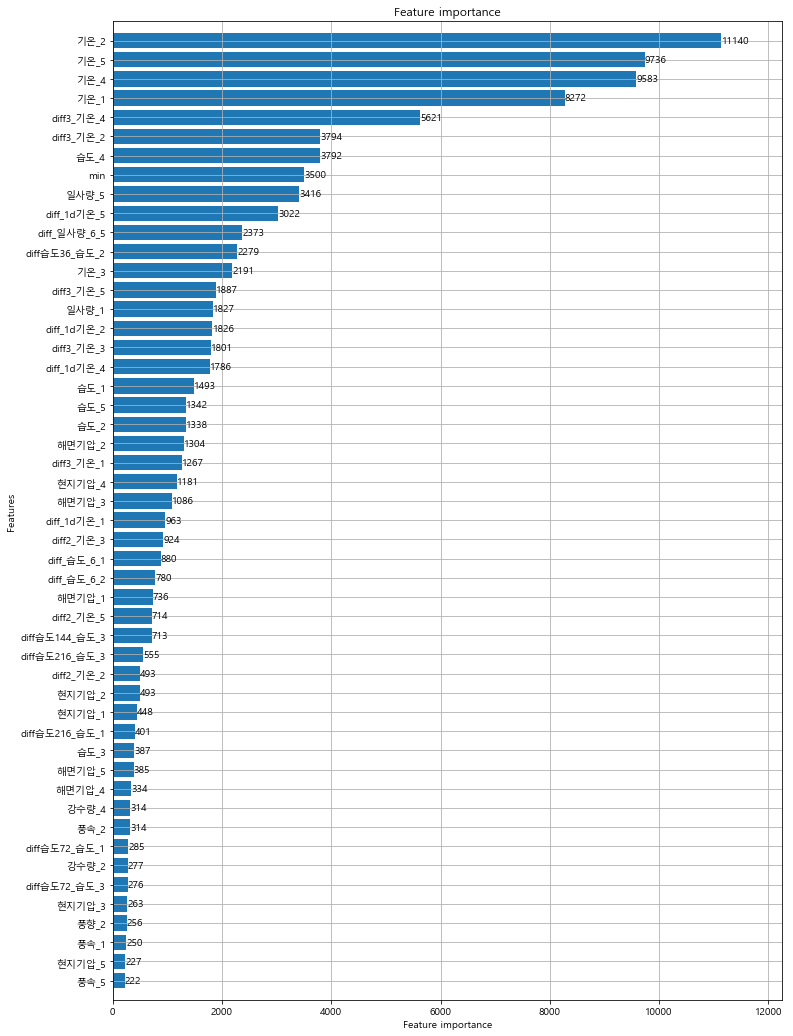

In [122]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

train_x, train_cv, y, y_cv = train_test_split(X_train,y_train, test_size=0.15, random_state=1217)

def lgbm_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2284, num_rounds=18703):

    param = {}

    param['boosting'] = 'dart'
    
    param['objective'] = 'regression'

    param['learning_rate'] = 0.05

    param['max_depth'] = 10

    param['metric'] = 'rmse'
    
    param['is_training_metric'] = True
    
    param['min_child_weight'] = 1

    param['bagging_fraction'] = 0.8
    
    param['num_leaves'] = 128

    param['feature_fraction'] = 0.8

    param['bagging_freq'] = 6
    
    param['seed'] = seed_val
    
    param['min_split_gain'] = 0.01

    num_rounds = num_rounds

    plst = list(param.items())

    train_ds = lgb.Dataset(train_X, label=train_y)

    test_ds = lgb.Dataset(test_X, label=test_y)

    model = lgb.train(param, train_ds, num_rounds,test_ds, early_stopping_rounds=180)

    return model

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


model = lgbm_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)

from matplotlib import pylab as plt

fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)

plt.show()

In [123]:
y_test =  np.expm1(model.predict(X_test)) + 1

In [124]:
submission['Y18'] = y_test

In [125]:
submission.to_csv('data/Ensemble/col3_test.csv',index=False)

In [1]:
import pandas as pd
import numpy as np
import os

folder = 'data/Ensemble'
nf = 0
for Q in os.listdir(folder):
    ext = os.path.splitext(Q)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+Q)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="id")
    nf += 1

p = 88.4  # 이 파라미터는 멱평균 앙상블에 있어 중요한 수치임. 최적의 수치를 찾기 바랍니다.   
if nf >= 2:
    pred_m = 0
    for J in range(nf): pred_m = pred_m + slist.iloc[:,J+1]**p 
    pred_m = pred_m / nf    
    pred_m = pred_m**(1/p)

    submit = pd.DataFrame({'id': slist.id, 'voted': pred_m})
    fname = "data/submission_PM.csv"
    submit.fillna(0).to_csv(fname, index=False)

In [127]:
COL4= ['기온_1', '현지기압_1', '풍속_1', '풍속_2', '강수량_1', '해면기압_1', '현지기압_2', '기온_2',
        '해면기압_2', '해면기압_3', '강수량_2', '일사량_1', '습도_1', '풍향_1', '일사량_2', '풍향_2',
        '일사량_3', '풍향_3', '풍속_3', '일사량_4', '습도_2', '강수량_3', '현지기압_3', '해면기압_4',
        '풍속_4', '풍향_4', '풍속_5', '현지기압_4', '기온_3', '현지기압_5', '습도_3', '기온_4',
        '기온_5', '해면기압_5', '일사량_5', '풍향_5', '강수량_4', '습도_4', '습도_5', '강수량_5',
        'min', '시간별합', '시간별평균', '시간별편차', 'rain', '시간강수별합', '시간강수별평균', '시간강수별편차',
        'time_cat_t1', 'time_cat_t2', 'time_cat_t3', 'time_cat_t4',
        'time_cat_t5', 'time_cat_t6', 'time_cat_t7', 'time_cat_t8',
        'time_cat_t9', 'diff_1d기온_1', 'diff_1d기온_2', 'diff_1d기온_3',
        'diff_1d기온_4', 'diff_1d기온_5', 'diff2_기온_1', 'diff2_기온_2', 'diff2_기온_3',
        'diff2_기온_4', 'diff2_기온_5', 'diff3_기온_1', 'diff3_기온_2', 'diff3_기온_3',
        'diff3_기온_4', 'diff3_기온_5', 'diff2_5min_기온_1', 'diff2_5min_기온_2',
        'diff2_5min_기온_3', 'diff2_5min_기온_4', 'diff2_5min_기온_5',
        'diff_습도_1_1', 'diff_습도_1_2', 'diff_습도_1_3', 'diff_습도_1_4',
        'diff_습도_1_5', 'diff_습도_6_1', 'diff_습도_6_2', 'diff_습도_6_3',
        'diff_습도_6_4', 'diff_습도_6_5', 'diff_일사량_1_1',
        'diff_일사량_1_2', 'diff_일사량_1_3', 'diff_일사량_1_4', 'diff_일사량_1_5',
        'diff_일사량_6_1', 'diff_일사량_6_2', 'diff_일사량_6_3', 'diff_일사량_6_4',
        'diff_일사량_6_5', '습도_mean', '일사량_mean', '일사량_습도']

In [128]:
X_train = data[COL4].iloc[:train.shape[0],:]
X_test = data[COL4].iloc[train.shape[0]:,:]

[1]	valid_0's rmse: 0.322299
[2]	valid_0's rmse: 0.306663
[3]	valid_0's rmse: 0.291758
[4]	valid_0's rmse: 0.277469
[5]	valid_0's rmse: 0.277824
[6]	valid_0's rmse: 0.264381
[7]	valid_0's rmse: 0.251583
[8]	valid_0's rmse: 0.239487
[9]	valid_0's rmse: 0.227901
[10]	valid_0's rmse: 0.21705
[11]	valid_0's rmse: 0.217055
[12]	valid_0's rmse: 0.206672
[13]	valid_0's rmse: 0.196755
[14]	valid_0's rmse: 0.198714
[15]	valid_0's rmse: 0.205546
[16]	valid_0's rmse: 0.19566
[17]	valid_0's rmse: 0.186329
[18]	valid_0's rmse: 0.177512
[19]	valid_0's rmse: 0.181123
[20]	valid_0's rmse: 0.172585
[21]	valid_0's rmse: 0.175512
[22]	valid_0's rmse: 0.167199
[23]	valid_0's rmse: 0.170298
[24]	valid_0's rmse: 0.162222
[25]	valid_0's rmse: 0.154497
[26]	valid_0's rmse: 0.14717
[27]	valid_0's rmse: 0.150923
[28]	valid_0's rmse: 0.143813
[29]	valid_0's rmse: 0.137012
[30]	valid_0's rmse: 0.395796
[31]	valid_0's rmse: 0.37616
[32]	valid_0's rmse: 0.357514
[33]	valid_0's rmse: 0.339885
[34]	valid_0's rmse: 0.

[287]	valid_0's rmse: 0.267552
[288]	valid_0's rmse: 0.277883
[289]	valid_0's rmse: 0.264156
[290]	valid_0's rmse: 0.251148
[291]	valid_0's rmse: 0.238789
[292]	valid_0's rmse: 0.227055
[293]	valid_0's rmse: 0.215936
[294]	valid_0's rmse: 0.225421
[295]	valid_0's rmse: 0.235537
[296]	valid_0's rmse: 0.244702
[297]	valid_0's rmse: 0.25392
[298]	valid_0's rmse: 0.26235
[299]	valid_0's rmse: 0.271781
[300]	valid_0's rmse: 0.280099
[301]	valid_0's rmse: 0.266288
[302]	valid_0's rmse: 0.253158
[303]	valid_0's rmse: 0.262292
[304]	valid_0's rmse: 0.298509
[305]	valid_0's rmse: 0.303794
[306]	valid_0's rmse: 0.341826
[307]	valid_0's rmse: 0.349932
[308]	valid_0's rmse: 0.358678
[309]	valid_0's rmse: 0.340919
[310]	valid_0's rmse: 0.324045
[311]	valid_0's rmse: 0.308018
[312]	valid_0's rmse: 0.315691
[313]	valid_0's rmse: 0.300113
[314]	valid_0's rmse: 0.285312
[315]	valid_0's rmse: 0.292146
[316]	valid_0's rmse: 0.300557
[317]	valid_0's rmse: 0.310235
[318]	valid_0's rmse: 0.294903
[319]	vali

[563]	valid_0's rmse: 0.19681
[564]	valid_0's rmse: 0.187206
[565]	valid_0's rmse: 0.193523
[566]	valid_0's rmse: 0.199084
[567]	valid_0's rmse: 0.1894
[568]	valid_0's rmse: 0.180192
[569]	valid_0's rmse: 0.171466
[570]	valid_0's rmse: 0.178621
[571]	valid_0's rmse: 0.184361
[572]	valid_0's rmse: 0.175388
[573]	valid_0's rmse: 0.166913
[574]	valid_0's rmse: 0.158856
[575]	valid_0's rmse: 0.151223
[576]	valid_0's rmse: 0.143961
[577]	valid_0's rmse: 0.137085
[578]	valid_0's rmse: 0.130568
[579]	valid_0's rmse: 0.136769
[580]	valid_0's rmse: 0.13027
[581]	valid_0's rmse: 0.135369
[582]	valid_0's rmse: 0.128934
[583]	valid_0's rmse: 0.135214
[584]	valid_0's rmse: 0.128771
[585]	valid_0's rmse: 0.14874
[586]	valid_0's rmse: 0.141606
[587]	valid_0's rmse: 0.134852
[588]	valid_0's rmse: 0.140749
[589]	valid_0's rmse: 0.159249
[590]	valid_0's rmse: 0.164937
[591]	valid_0's rmse: 0.171261
[592]	valid_0's rmse: 0.177398
[593]	valid_0's rmse: 0.168771
[594]	valid_0's rmse: 0.175511
[595]	valid_0

[837]	valid_0's rmse: 0.105517
[838]	valid_0's rmse: 0.109599
[839]	valid_0's rmse: 0.104511
[840]	valid_0's rmse: 0.108505
[841]	valid_0's rmse: 0.103474
[842]	valid_0's rmse: 0.107555
[843]	valid_0's rmse: 0.111388
[844]	valid_0's rmse: 0.106197
[845]	valid_0's rmse: 0.110467
[846]	valid_0's rmse: 0.105326
[847]	valid_0's rmse: 0.100459
[848]	valid_0's rmse: 0.105323
[849]	valid_0's rmse: 0.109593
[850]	valid_0's rmse: 0.104497
[851]	valid_0's rmse: 0.0996754
[852]	valid_0's rmse: 0.0950901
[853]	valid_0's rmse: 0.0995945
[854]	valid_0's rmse: 0.0950495
[855]	valid_0's rmse: 0.0990409
[856]	valid_0's rmse: 0.103078
[857]	valid_0's rmse: 0.0983257
[858]	valid_0's rmse: 0.0938352
[859]	valid_0's rmse: 0.089574
[860]	valid_0's rmse: 0.0941674
[861]	valid_0's rmse: 0.0898949
[862]	valid_0's rmse: 0.0938574
[863]	valid_0's rmse: 0.0896016
[864]	valid_0's rmse: 0.0855882
[865]	valid_0's rmse: 0.0817928
[866]	valid_0's rmse: 0.0858567
[867]	valid_0's rmse: 0.0820386
[868]	valid_0's rmse: 0.

[1104]	valid_0's rmse: 0.0830965
[1105]	valid_0's rmse: 0.0860837
[1106]	valid_0's rmse: 0.089162
[1107]	valid_0's rmse: 0.091843
[1108]	valid_0's rmse: 0.0955743
[1109]	valid_0's rmse: 0.0912104
[1110]	valid_0's rmse: 0.0871047
[1111]	valid_0's rmse: 0.0832081
[1112]	valid_0's rmse: 0.0953348
[1113]	valid_0's rmse: 0.0984541
[1114]	valid_0's rmse: 0.0939569
[1115]	valid_0's rmse: 0.089692
[1116]	valid_0's rmse: 0.101896
[1117]	valid_0's rmse: 0.0972278
[1118]	valid_0's rmse: 0.100293
[1119]	valid_0's rmse: 0.10388
[1120]	valid_0's rmse: 0.107224
[1121]	valid_0's rmse: 0.102277
[1122]	valid_0's rmse: 0.104823
[1123]	valid_0's rmse: 0.0999687
[1124]	valid_0's rmse: 0.103583
[1125]	valid_0's rmse: 0.1065
[1126]	valid_0's rmse: 0.109505
[1127]	valid_0's rmse: 0.121484
[1128]	valid_0's rmse: 0.124992
[1129]	valid_0's rmse: 0.128196
[1130]	valid_0's rmse: 0.131303
[1131]	valid_0's rmse: 0.134283
[1132]	valid_0's rmse: 0.127892
[1133]	valid_0's rmse: 0.121845
[1134]	valid_0's rmse: 0.116095


[1359]	valid_0's rmse: 0.0600436
[1360]	valid_0's rmse: 0.0624075
[1361]	valid_0's rmse: 0.0599254
[1362]	valid_0's rmse: 0.0575865
[1363]	valid_0's rmse: 0.0553824
[1364]	valid_0's rmse: 0.0533056
[1365]	valid_0's rmse: 0.0557696
[1366]	valid_0's rmse: 0.0581671
[1367]	valid_0's rmse: 0.0601776
[1368]	valid_0's rmse: 0.062358
[1369]	valid_0's rmse: 0.0599054
[1370]	valid_0's rmse: 0.0623002
[1371]	valid_0's rmse: 0.0649026
[1372]	valid_0's rmse: 0.067641
[1373]	valid_0's rmse: 0.0648686
[1374]	valid_0's rmse: 0.0622563
[1375]	valid_0's rmse: 0.0597784
[1376]	valid_0's rmse: 0.0574384
[1377]	valid_0's rmse: 0.0598138
[1378]	valid_0's rmse: 0.0574844
[1379]	valid_0's rmse: 0.0593563
[1380]	valid_0's rmse: 0.0570416
[1381]	valid_0's rmse: 0.0548735
[1382]	valid_0's rmse: 0.0528396
[1383]	valid_0's rmse: 0.050922
[1384]	valid_0's rmse: 0.0529011
[1385]	valid_0's rmse: 0.0547602
[1386]	valid_0's rmse: 0.0573324
[1387]	valid_0's rmse: 0.0595991
[1388]	valid_0's rmse: 0.0572874
[1389]	valid_

[1626]	valid_0's rmse: 0.0555165
[1627]	valid_0's rmse: 0.057557
[1628]	valid_0's rmse: 0.0594896
[1629]	valid_0's rmse: 0.0613778
[1630]	valid_0's rmse: 0.0633991
[1631]	valid_0's rmse: 0.0608608
[1632]	valid_0's rmse: 0.0627516
[1633]	valid_0's rmse: 0.0650397
[1634]	valid_0's rmse: 0.0671288
[1635]	valid_0's rmse: 0.0643725
[1636]	valid_0's rmse: 0.0663039
[1637]	valid_0's rmse: 0.0682279
[1638]	valid_0's rmse: 0.0697586
[1639]	valid_0's rmse: 0.0668453
[1640]	valid_0's rmse: 0.0689022
[1641]	valid_0's rmse: 0.0711229
[1642]	valid_0's rmse: 0.0681327
[1643]	valid_0's rmse: 0.0703359
[1644]	valid_0's rmse: 0.0722332
[1645]	valid_0's rmse: 0.0691557
[1646]	valid_0's rmse: 0.0662626
[1647]	valid_0's rmse: 0.0683379
[1648]	valid_0's rmse: 0.0654831
[1649]	valid_0's rmse: 0.0628147
[1650]	valid_0's rmse: 0.06459
[1651]	valid_0's rmse: 0.0666482
[1652]	valid_0's rmse: 0.0639025
[1653]	valid_0's rmse: 0.0660317
[1654]	valid_0's rmse: 0.063345
[1655]	valid_0's rmse: 0.060807
[1656]	valid_0'

[1891]	valid_0's rmse: 0.0503371
[1892]	valid_0's rmse: 0.0517932
[1893]	valid_0's rmse: 0.0499828
[1894]	valid_0's rmse: 0.0482802
[1895]	valid_0's rmse: 0.0496251
[1896]	valid_0's rmse: 0.0479568
[1897]	valid_0's rmse: 0.0463794
[1898]	valid_0's rmse: 0.0477467
[1899]	valid_0's rmse: 0.0461816
[1900]	valid_0's rmse: 0.0475233
[1901]	valid_0's rmse: 0.0459794
[1902]	valid_0's rmse: 0.0445169
[1903]	valid_0's rmse: 0.0460179
[1904]	valid_0's rmse: 0.0473667
[1905]	valid_0's rmse: 0.0487393
[1906]	valid_0's rmse: 0.0504128
[1907]	valid_0's rmse: 0.0486874
[1908]	valid_0's rmse: 0.0470766
[1909]	valid_0's rmse: 0.0538918
[1910]	valid_0's rmse: 0.0519339
[1911]	valid_0's rmse: 0.0500797
[1912]	valid_0's rmse: 0.0515442
[1913]	valid_0's rmse: 0.0497238
[1914]	valid_0's rmse: 0.0480325
[1915]	valid_0's rmse: 0.0493404
[1916]	valid_0's rmse: 0.0476779
[1917]	valid_0's rmse: 0.046125
[1918]	valid_0's rmse: 0.0446639
[1919]	valid_0's rmse: 0.0433112
[1920]	valid_0's rmse: 0.0446269
[1921]	vali

[2143]	valid_0's rmse: 0.0456695
[2144]	valid_0's rmse: 0.0471342
[2145]	valid_0's rmse: 0.0486989
[2146]	valid_0's rmse: 0.0501125
[2147]	valid_0's rmse: 0.052043
[2148]	valid_0's rmse: 0.0533754
[2149]	valid_0's rmse: 0.0550932
[2150]	valid_0's rmse: 0.0530556
[2151]	valid_0's rmse: 0.0546824
[2152]	valid_0's rmse: 0.0561348
[2153]	valid_0's rmse: 0.054012
[2154]	valid_0's rmse: 0.0520399
[2155]	valid_0's rmse: 0.0534857
[2156]	valid_0's rmse: 0.0515487
[2157]	valid_0's rmse: 0.0530639
[2158]	valid_0's rmse: 0.0541174
[2159]	valid_0's rmse: 0.0521465
[2160]	valid_0's rmse: 0.0537617
[2161]	valid_0's rmse: 0.0518165
[2162]	valid_0's rmse: 0.0499931
[2163]	valid_0's rmse: 0.0482933
[2164]	valid_0's rmse: 0.0498692
[2165]	valid_0's rmse: 0.0481684
[2166]	valid_0's rmse: 0.0495486
[2167]	valid_0's rmse: 0.0478601
[2168]	valid_0's rmse: 0.0462867
[2169]	valid_0's rmse: 0.0475466
[2170]	valid_0's rmse: 0.0490087
[2171]	valid_0's rmse: 0.0473689
[2172]	valid_0's rmse: 0.0458371
[2173]	valid

[2414]	valid_0's rmse: 0.0446415
[2415]	valid_0's rmse: 0.0432999
[2416]	valid_0's rmse: 0.0442317
[2417]	valid_0's rmse: 0.0451833
[2418]	valid_0's rmse: 0.0461864
[2419]	valid_0's rmse: 0.0447356
[2420]	valid_0's rmse: 0.0433891
[2421]	valid_0's rmse: 0.0444034
[2422]	valid_0's rmse: 0.0454918
[2423]	valid_0's rmse: 0.0468765
[2424]	valid_0's rmse: 0.0483002
[2425]	valid_0's rmse: 0.0495476
[2426]	valid_0's rmse: 0.0478764
[2427]	valid_0's rmse: 0.0490703
[2428]	valid_0's rmse: 0.0505534
[2429]	valid_0's rmse: 0.0488267
[2430]	valid_0's rmse: 0.054374
[2431]	valid_0's rmse: 0.0556598
[2432]	valid_0's rmse: 0.056616
[2433]	valid_0's rmse: 0.0579444
[2434]	valid_0's rmse: 0.055754
[2435]	valid_0's rmse: 0.053692
[2436]	valid_0's rmse: 0.0517618
[2437]	valid_0's rmse: 0.0499382
[2438]	valid_0's rmse: 0.0552954
[2439]	valid_0's rmse: 0.0563524
[2440]	valid_0's rmse: 0.0579955
[2441]	valid_0's rmse: 0.0557917
[2442]	valid_0's rmse: 0.053725
[2443]	valid_0's rmse: 0.0549439
[2444]	valid_0'

[2668]	valid_0's rmse: 0.0401522
[2669]	valid_0's rmse: 0.0412521
[2670]	valid_0's rmse: 0.0401269
[2671]	valid_0's rmse: 0.0411985
[2672]	valid_0's rmse: 0.040086
[2673]	valid_0's rmse: 0.0412103
[2674]	valid_0's rmse: 0.0421924
[2675]	valid_0's rmse: 0.0434139
[2676]	valid_0's rmse: 0.0444185
[2677]	valid_0's rmse: 0.045458
[2678]	valid_0's rmse: 0.0467346
[2679]	valid_0's rmse: 0.0452589
[2680]	valid_0's rmse: 0.043879
[2681]	valid_0's rmse: 0.042603
[2682]	valid_0's rmse: 0.0436839
[2683]	valid_0's rmse: 0.0445214
[2684]	valid_0's rmse: 0.0454407
[2685]	valid_0's rmse: 0.0440508
[2686]	valid_0's rmse: 0.0452108
[2687]	valid_0's rmse: 0.0463285
[2688]	valid_0's rmse: 0.0473887
[2689]	valid_0's rmse: 0.0486538
[2690]	valid_0's rmse: 0.0470492
[2691]	valid_0's rmse: 0.04556
[2692]	valid_0's rmse: 0.046566
[2693]	valid_0's rmse: 0.0474305
[2694]	valid_0's rmse: 0.0459112
[2695]	valid_0's rmse: 0.0445004
[2696]	valid_0's rmse: 0.0457626
[2697]	valid_0's rmse: 0.044352
[2698]	valid_0's r

[2932]	valid_0's rmse: 0.0487908
[2933]	valid_0's rmse: 0.0496524
[2934]	valid_0's rmse: 0.0506403
[2935]	valid_0's rmse: 0.0488997
[2936]	valid_0's rmse: 0.0472691
[2937]	valid_0's rmse: 0.0484677
[2938]	valid_0's rmse: 0.0493534
[2939]	valid_0's rmse: 0.0505174
[2940]	valid_0's rmse: 0.0514266
[2941]	valid_0's rmse: 0.0496352
[2942]	valid_0's rmse: 0.0508837
[2943]	valid_0's rmse: 0.0519869
[2944]	valid_0's rmse: 0.0527535
[2945]	valid_0's rmse: 0.053763
[2946]	valid_0's rmse: 0.0545877
[2947]	valid_0's rmse: 0.0557758
[2948]	valid_0's rmse: 0.0537093
[2949]	valid_0's rmse: 0.0517791
[2950]	valid_0's rmse: 0.0526457
[2951]	valid_0's rmse: 0.0507826
[2952]	valid_0's rmse: 0.0517122
[2953]	valid_0's rmse: 0.0527342
[2954]	valid_0's rmse: 0.0537832
[2955]	valid_0's rmse: 0.0546851
[2956]	valid_0's rmse: 0.0526967
[2957]	valid_0's rmse: 0.0537968
[2958]	valid_0's rmse: 0.0518652
[2959]	valid_0's rmse: 0.0500362
[2960]	valid_0's rmse: 0.0483206
[2961]	valid_0's rmse: 0.0493172
[2962]	vali

[3202]	valid_0's rmse: 0.0357829
[3203]	valid_0's rmse: 0.0364605
[3204]	valid_0's rmse: 0.0372482
[3205]	valid_0's rmse: 0.0364387
[3206]	valid_0's rmse: 0.037154
[3207]	valid_0's rmse: 0.0363565
[3208]	valid_0's rmse: 0.0371964
[3209]	valid_0's rmse: 0.0379501
[3210]	valid_0's rmse: 0.0370829
[3211]	valid_0's rmse: 0.0378479
[3212]	valid_0's rmse: 0.0369826
[3213]	valid_0's rmse: 0.0378814
[3214]	valid_0's rmse: 0.0370169
[3215]	valid_0's rmse: 0.0362186
[3216]	valid_0's rmse: 0.0354798
[3217]	valid_0's rmse: 0.0361967
[3218]	valid_0's rmse: 0.0369512
[3219]	valid_0's rmse: 0.0361508
[3220]	valid_0's rmse: 0.036812
[3221]	valid_0's rmse: 0.0360208
[3222]	valid_0's rmse: 0.0367134
[3223]	valid_0's rmse: 0.035946
[3224]	valid_0's rmse: 0.0352375
[3225]	valid_0's rmse: 0.0345823
[3226]	valid_0's rmse: 0.0339818
[3227]	valid_0's rmse: 0.0334256
[3228]	valid_0's rmse: 0.0329099
[3229]	valid_0's rmse: 0.0324358
[3230]	valid_0's rmse: 0.0319995
[3231]	valid_0's rmse: 0.0316027
[3232]	valid_

[3452]	valid_0's rmse: 0.0360335
[3453]	valid_0's rmse: 0.0367613
[3454]	valid_0's rmse: 0.0359964
[3455]	valid_0's rmse: 0.0352922
[3456]	valid_0's rmse: 0.0346278
[3457]	valid_0's rmse: 0.0340128
[3458]	valid_0's rmse: 0.0334558
[3459]	valid_0's rmse: 0.0340371
[3460]	valid_0's rmse: 0.0345126
[3461]	valid_0's rmse: 0.0350173
[3462]	valid_0's rmse: 0.0357413
[3463]	valid_0's rmse: 0.0362648
[3464]	valid_0's rmse: 0.0355363
[3465]	valid_0's rmse: 0.0348591
[3466]	valid_0's rmse: 0.035457
[3467]	valid_0's rmse: 0.0361551
[3468]	valid_0's rmse: 0.036839
[3469]	valid_0's rmse: 0.0376715
[3470]	valid_0's rmse: 0.0381421
[3471]	valid_0's rmse: 0.0387998
[3472]	valid_0's rmse: 0.0378738
[3473]	valid_0's rmse: 0.0370186
[3474]	valid_0's rmse: 0.0362203
[3475]	valid_0's rmse: 0.035483
[3476]	valid_0's rmse: 0.0360514
[3477]	valid_0's rmse: 0.0353261
[3478]	valid_0's rmse: 0.0346594
[3479]	valid_0's rmse: 0.0340441
[3480]	valid_0's rmse: 0.0334787
[3481]	valid_0's rmse: 0.0343484
[3482]	valid_

[3708]	valid_0's rmse: 0.032614
[3709]	valid_0's rmse: 0.0321735
[3710]	valid_0's rmse: 0.0325527
[3711]	valid_0's rmse: 0.0320916
[3712]	valid_0's rmse: 0.031679
[3713]	valid_0's rmse: 0.0312981
[3714]	valid_0's rmse: 0.031741
[3715]	valid_0's rmse: 0.0321246
[3716]	valid_0's rmse: 0.0317085
[3717]	valid_0's rmse: 0.0313302
[3718]	valid_0's rmse: 0.0309856
[3719]	valid_0's rmse: 0.0306693
[3720]	valid_0's rmse: 0.0331617
[3721]	valid_0's rmse: 0.0326637
[3722]	valid_0's rmse: 0.0333034
[3723]	valid_0's rmse: 0.0338322
[3724]	valid_0's rmse: 0.0343318
[3725]	valid_0's rmse: 0.0337478
[3726]	valid_0's rmse: 0.0332069
[3727]	valid_0's rmse: 0.0337788
[3728]	valid_0's rmse: 0.0343364
[3729]	valid_0's rmse: 0.0347773
[3730]	valid_0's rmse: 0.0341587
[3731]	valid_0's rmse: 0.0347564
[3732]	valid_0's rmse: 0.0351681
[3733]	valid_0's rmse: 0.03452
[3734]	valid_0's rmse: 0.0354343
[3735]	valid_0's rmse: 0.0360083
[3736]	valid_0's rmse: 0.0366996
[3737]	valid_0's rmse: 0.037288
[3738]	valid_0's

[3961]	valid_0's rmse: 0.0356069
[3962]	valid_0's rmse: 0.0363588
[3963]	valid_0's rmse: 0.0356185
[3964]	valid_0's rmse: 0.0349348
[3965]	valid_0's rmse: 0.0343126
[3966]	valid_0's rmse: 0.0350578
[3967]	valid_0's rmse: 0.0356515
[3968]	valid_0's rmse: 0.0385363
[3969]	valid_0's rmse: 0.0376422
[3970]	valid_0's rmse: 0.0382321
[3971]	valid_0's rmse: 0.0387276
[3972]	valid_0's rmse: 0.0378106
[3973]	valid_0's rmse: 0.0369802
[3974]	valid_0's rmse: 0.0377134
[3975]	valid_0's rmse: 0.0383836
[3976]	valid_0's rmse: 0.0375024
[3977]	valid_0's rmse: 0.0382192
[3978]	valid_0's rmse: 0.0391458
[3979]	valid_0's rmse: 0.0381938
[3980]	valid_0's rmse: 0.03862
[3981]	valid_0's rmse: 0.0377224
[3982]	valid_0's rmse: 0.0382652
[3983]	valid_0's rmse: 0.0374037
[3984]	valid_0's rmse: 0.0380729
[3985]	valid_0's rmse: 0.0372255
[3986]	valid_0's rmse: 0.0364445
[3987]	valid_0's rmse: 0.0356888
[3988]	valid_0's rmse: 0.0365376
[3989]	valid_0's rmse: 0.0357904
[3990]	valid_0's rmse: 0.0365909
[3991]	valid

[4231]	valid_0's rmse: 0.0323976
[4232]	valid_0's rmse: 0.0319871
[4233]	valid_0's rmse: 0.031602
[4234]	valid_0's rmse: 0.0312315
[4235]	valid_0's rmse: 0.0317445
[4236]	valid_0's rmse: 0.0313811
[4237]	valid_0's rmse: 0.0317986
[4238]	valid_0's rmse: 0.0322896
[4239]	valid_0's rmse: 0.0318765
[4240]	valid_0's rmse: 0.0323265
[4241]	valid_0's rmse: 0.0318939
[4242]	valid_0's rmse: 0.0315118
[4243]	valid_0's rmse: 0.0311643
[4244]	valid_0's rmse: 0.0308442
[4245]	valid_0's rmse: 0.0305476
[4246]	valid_0's rmse: 0.0305476
[4247]	valid_0's rmse: 0.0310229
[4248]	valid_0's rmse: 0.0307116
[4249]	valid_0's rmse: 0.0307116
[4250]	valid_0's rmse: 0.0310394
[4251]	valid_0's rmse: 0.0314497
[4252]	valid_0's rmse: 0.0318888
[4253]	valid_0's rmse: 0.0342176
[4254]	valid_0's rmse: 0.0336476
[4255]	valid_0's rmse: 0.0340588
[4256]	valid_0's rmse: 0.0335059
[4257]	valid_0's rmse: 0.0339994
[4258]	valid_0's rmse: 0.0346957
[4259]	valid_0's rmse: 0.0352804
[4260]	valid_0's rmse: 0.0346397
[4261]	vali

[4483]	valid_0's rmse: 0.0319062
[4484]	valid_0's rmse: 0.0322553
[4485]	valid_0's rmse: 0.0326117
[4486]	valid_0's rmse: 0.033035
[4487]	valid_0's rmse: 0.0325682
[4488]	valid_0's rmse: 0.032138
[4489]	valid_0's rmse: 0.03249
[4490]	valid_0's rmse: 0.0320564
[4491]	valid_0's rmse: 0.0316694
[4492]	valid_0's rmse: 0.032097
[4493]	valid_0's rmse: 0.0326354
[4494]	valid_0's rmse: 0.0331554
[4495]	valid_0's rmse: 0.0326623
[4496]	valid_0's rmse: 0.0331054
[4497]	valid_0's rmse: 0.0335105
[4498]	valid_0's rmse: 0.0339
[4499]	valid_0's rmse: 0.0344002
[4500]	valid_0's rmse: 0.0338056
[4501]	valid_0's rmse: 0.0332692
[4502]	valid_0's rmse: 0.0327687
[4503]	valid_0's rmse: 0.0332253
[4504]	valid_0's rmse: 0.0336211
[4505]	valid_0's rmse: 0.0331064
[4506]	valid_0's rmse: 0.0335712
[4507]	valid_0's rmse: 0.0330604
[4508]	valid_0's rmse: 0.0325898
[4509]	valid_0's rmse: 0.0330774
[4510]	valid_0's rmse: 0.0326114
[4511]	valid_0's rmse: 0.0321738
[4512]	valid_0's rmse: 0.031761
[4513]	valid_0's rm

[4764]	valid_0's rmse: 0.0326497
[4765]	valid_0's rmse: 0.0322012
[4766]	valid_0's rmse: 0.0326187
[4767]	valid_0's rmse: 0.0321794
[4768]	valid_0's rmse: 0.0317783
[4769]	valid_0's rmse: 0.0322038
[4770]	valid_0's rmse: 0.0325485
[4771]	valid_0's rmse: 0.0329459
[4772]	valid_0's rmse: 0.0324708
[4773]	valid_0's rmse: 0.0320328
[4774]	valid_0's rmse: 0.0316364
[4775]	valid_0's rmse: 0.0321091
[4776]	valid_0's rmse: 0.031711
[4777]	valid_0's rmse: 0.0321593
[4778]	valid_0's rmse: 0.0327139
[4779]	valid_0's rmse: 0.032256
[4780]	valid_0's rmse: 0.0326588
[4781]	valid_0's rmse: 0.0330404
[4782]	valid_0's rmse: 0.0325555
[4783]	valid_0's rmse: 0.032982
[4784]	valid_0's rmse: 0.0325078
[4785]	valid_0's rmse: 0.0320678
[4786]	valid_0's rmse: 0.0316707
[4787]	valid_0's rmse: 0.0313089
[4788]	valid_0's rmse: 0.0316465
[4789]	valid_0's rmse: 0.032022
[4790]	valid_0's rmse: 0.0316278
[4791]	valid_0's rmse: 0.031989
[4792]	valid_0's rmse: 0.0323515
[4793]	valid_0's rmse: 0.0319312
[4794]	valid_0'

[5057]	valid_0's rmse: 0.0320507
[5058]	valid_0's rmse: 0.0323412
[5059]	valid_0's rmse: 0.0327539
[5060]	valid_0's rmse: 0.0330564
[5061]	valid_0's rmse: 0.0334972
[5062]	valid_0's rmse: 0.0339953
[5063]	valid_0's rmse: 0.0344725
[5064]	valid_0's rmse: 0.0338887
[5065]	valid_0's rmse: 0.033349
[5066]	valid_0's rmse: 0.0328528
[5067]	valid_0's rmse: 0.033277
[5068]	valid_0's rmse: 0.0336647
[5069]	valid_0's rmse: 0.033139
[5070]	valid_0's rmse: 0.0335089
[5071]	valid_0's rmse: 0.0329865
[5072]	valid_0's rmse: 0.0325027
[5073]	valid_0's rmse: 0.0328454
[5074]	valid_0's rmse: 0.0332441
[5075]	valid_0's rmse: 0.0336022
[5076]	valid_0's rmse: 0.0339243
[5077]	valid_0's rmse: 0.0342733
[5078]	valid_0's rmse: 0.0346033
[5079]	valid_0's rmse: 0.0349722
[5080]	valid_0's rmse: 0.0354389
[5081]	valid_0's rmse: 0.035746
[5082]	valid_0's rmse: 0.0361193
[5083]	valid_0's rmse: 0.0353953
[5084]	valid_0's rmse: 0.0347327
[5085]	valid_0's rmse: 0.0350958
[5086]	valid_0's rmse: 0.0356087
[5087]	valid_0

[5321]	valid_0's rmse: 0.0330961
[5322]	valid_0's rmse: 0.0325991
[5323]	valid_0's rmse: 0.0328328
[5324]	valid_0's rmse: 0.0332095
[5325]	valid_0's rmse: 0.0327178
[5326]	valid_0's rmse: 0.0322671
[5327]	valid_0's rmse: 0.0325129
[5328]	valid_0's rmse: 0.0328918
[5329]	valid_0's rmse: 0.0331574
[5330]	valid_0's rmse: 0.0334323
[5331]	valid_0's rmse: 0.0329111
[5332]	valid_0's rmse: 0.0324405
[5333]	valid_0's rmse: 0.0320056
[5334]	valid_0's rmse: 0.0322955
[5335]	valid_0's rmse: 0.032559
[5336]	valid_0's rmse: 0.0329437
[5337]	valid_0's rmse: 0.0324807
[5338]	valid_0's rmse: 0.0329357
[5339]	valid_0's rmse: 0.0324736
[5340]	valid_0's rmse: 0.0320429
[5341]	valid_0's rmse: 0.0316405
[5342]	valid_0's rmse: 0.0312748
[5343]	valid_0's rmse: 0.0331091
[5344]	valid_0's rmse: 0.0333929
[5345]	valid_0's rmse: 0.0336737
[5346]	valid_0's rmse: 0.034123
[5347]	valid_0's rmse: 0.0335527
[5348]	valid_0's rmse: 0.0339438
[5349]	valid_0's rmse: 0.0344012
[5350]	valid_0's rmse: 0.0338082
[5351]	valid

[5608]	valid_0's rmse: 0.0308798
[5609]	valid_0's rmse: 0.0305834
[5610]	valid_0's rmse: 0.0308357
[5611]	valid_0's rmse: 0.0310378
[5612]	valid_0's rmse: 0.0307213
[5613]	valid_0's rmse: 0.0310439
[5614]	valid_0's rmse: 0.0314071
[5615]	valid_0's rmse: 0.0310875
[5616]	valid_0's rmse: 0.0307792
[5617]	valid_0's rmse: 0.0310174
[5618]	valid_0's rmse: 0.0307221
[5619]	valid_0's rmse: 0.0304387
[5620]	valid_0's rmse: 0.0301799
[5621]	valid_0's rmse: 0.0304642
[5622]	valid_0's rmse: 0.0306587
[5623]	valid_0's rmse: 0.0303852
[5624]	valid_0's rmse: 0.0307108
[5625]	valid_0's rmse: 0.0310372
[5626]	valid_0's rmse: 0.0312685
[5627]	valid_0's rmse: 0.0314825
[5628]	valid_0's rmse: 0.0317035
[5629]	valid_0's rmse: 0.0320653
[5630]	valid_0's rmse: 0.0316753
[5631]	valid_0's rmse: 0.0320249
[5632]	valid_0's rmse: 0.0316491
[5633]	valid_0's rmse: 0.0313029
[5634]	valid_0's rmse: 0.0315981
[5635]	valid_0's rmse: 0.0318786
[5636]	valid_0's rmse: 0.0315097
[5637]	valid_0's rmse: 0.0311573
[5638]	val

[5892]	valid_0's rmse: 0.0312327
[5893]	valid_0's rmse: 0.0309038
[5894]	valid_0's rmse: 0.031167
[5895]	valid_0's rmse: 0.0308446
[5896]	valid_0's rmse: 0.031067
[5897]	valid_0's rmse: 0.03076
[5898]	valid_0's rmse: 0.0304855
[5899]	valid_0's rmse: 0.030725
[5900]	valid_0's rmse: 0.030438
[5901]	valid_0's rmse: 0.030705
[5902]	valid_0's rmse: 0.0304146
[5903]	valid_0's rmse: 0.0306139
[5904]	valid_0's rmse: 0.0303428
[5905]	valid_0's rmse: 0.0305895
[5906]	valid_0's rmse: 0.0310184
[5907]	valid_0's rmse: 0.0313068
[5908]	valid_0's rmse: 0.0309785
[5909]	valid_0's rmse: 0.0312245
[5910]	valid_0's rmse: 0.031563
[5911]	valid_0's rmse: 0.0312175
[5912]	valid_0's rmse: 0.0309007
[5913]	valid_0's rmse: 0.030602
[5914]	valid_0's rmse: 0.0303248
[5915]	valid_0's rmse: 0.0305325
[5916]	valid_0's rmse: 0.0308282
[5917]	valid_0's rmse: 0.0310792
[5918]	valid_0's rmse: 0.030782
[5919]	valid_0's rmse: 0.0305062
[5920]	valid_0's rmse: 0.0309172
[5921]	valid_0's rmse: 0.0311504
[5922]	valid_0's rms

[6167]	valid_0's rmse: 0.0313804
[6168]	valid_0's rmse: 0.0310343
[6169]	valid_0's rmse: 0.0313374
[6170]	valid_0's rmse: 0.0309982
[6171]	valid_0's rmse: 0.0307003
[6172]	valid_0's rmse: 0.0309906
[6173]	valid_0's rmse: 0.0306677
[6174]	valid_0's rmse: 0.0308837
[6175]	valid_0's rmse: 0.0311094
[6176]	valid_0's rmse: 0.0307865
[6177]	valid_0's rmse: 0.0304862
[6178]	valid_0's rmse: 0.0302275
[6179]	valid_0's rmse: 0.0304665
[6180]	valid_0's rmse: 0.0302122
[6181]	valid_0's rmse: 0.0299797
[6182]	valid_0's rmse: 0.0302057
[6183]	valid_0's rmse: 0.0299742
[6184]	valid_0's rmse: 0.0302453
[6185]	valid_0's rmse: 0.0303896
[6186]	valid_0's rmse: 0.0301345
[6187]	valid_0's rmse: 0.0299031
[6188]	valid_0's rmse: 0.0301257
[6189]	valid_0's rmse: 0.0304694
[6190]	valid_0's rmse: 0.0302161
[6191]	valid_0's rmse: 0.0305302
[6192]	valid_0's rmse: 0.0308321
[6193]	valid_0's rmse: 0.0310633
[6194]	valid_0's rmse: 0.0307545
[6195]	valid_0's rmse: 0.0310051
[6196]	valid_0's rmse: 0.0313228
[6197]	val

[6428]	valid_0's rmse: 0.0300607
[6429]	valid_0's rmse: 0.0298519
[6430]	valid_0's rmse: 0.0296573
[6431]	valid_0's rmse: 0.0299467
[6432]	valid_0's rmse: 0.03015
[6433]	valid_0's rmse: 0.0299189
[6434]	valid_0's rmse: 0.029715
[6435]	valid_0's rmse: 0.0299145
[6436]	valid_0's rmse: 0.0301281
[6437]	valid_0's rmse: 0.0298997
[6438]	valid_0's rmse: 0.0296974
[6439]	valid_0's rmse: 0.0299447
[6440]	valid_0's rmse: 0.0297334
[6441]	valid_0's rmse: 0.030038
[6442]	valid_0's rmse: 0.0302906
[6443]	valid_0's rmse: 0.0300493
[6444]	valid_0's rmse: 0.0302604
[6445]	valid_0's rmse: 0.030027
[6446]	valid_0's rmse: 0.0302712
[6447]	valid_0's rmse: 0.0304829
[6448]	valid_0's rmse: 0.0308684
[6449]	valid_0's rmse: 0.0305844
[6450]	valid_0's rmse: 0.0303231
[6451]	valid_0's rmse: 0.030091
[6452]	valid_0's rmse: 0.0298807
[6453]	valid_0's rmse: 0.029687
[6454]	valid_0's rmse: 0.029863
[6455]	valid_0's rmse: 0.0296732
[6456]	valid_0's rmse: 0.029496
[6457]	valid_0's rmse: 0.0296677
[6458]	valid_0's rm

[6692]	valid_0's rmse: 0.0313675
[6693]	valid_0's rmse: 0.0310298
[6694]	valid_0's rmse: 0.0307279
[6695]	valid_0's rmse: 0.0304546
[6696]	valid_0's rmse: 0.0302029
[6697]	valid_0's rmse: 0.0299752
[6698]	valid_0's rmse: 0.029768
[6699]	valid_0's rmse: 0.029768
[6700]	valid_0's rmse: 0.029768
[6701]	valid_0's rmse: 0.0295726
[6702]	valid_0's rmse: 0.0293951
[6703]	valid_0's rmse: 0.0295617
[6704]	valid_0's rmse: 0.0298423
[6705]	valid_0's rmse: 0.0300612
[6706]	valid_0's rmse: 0.0303135
[6707]	valid_0's rmse: 0.0304974
[6708]	valid_0's rmse: 0.0307871
[6709]	valid_0's rmse: 0.0304958
[6710]	valid_0's rmse: 0.0302361
[6711]	valid_0's rmse: 0.0304852
[6712]	valid_0's rmse: 0.0307984
[6713]	valid_0's rmse: 0.0305187
[6714]	valid_0's rmse: 0.0307336
[6715]	valid_0's rmse: 0.0310695
[6716]	valid_0's rmse: 0.0313519
[6717]	valid_0's rmse: 0.0310223
[6718]	valid_0's rmse: 0.0307273
[6719]	valid_0's rmse: 0.0304538
[6720]	valid_0's rmse: 0.0302066
[6721]	valid_0's rmse: 0.02998
[6722]	valid_0'

[6975]	valid_0's rmse: 0.0300775
[6976]	valid_0's rmse: 0.0298648
[6977]	valid_0's rmse: 0.0296698
[6978]	valid_0's rmse: 0.0296698
[6979]	valid_0's rmse: 0.0296698
[6980]	valid_0's rmse: 0.0298973
[6981]	valid_0's rmse: 0.0296979
[6982]	valid_0's rmse: 0.0298525
[6983]	valid_0's rmse: 0.0298525
[6984]	valid_0's rmse: 0.0298525
[6985]	valid_0's rmse: 0.0300958
[6986]	valid_0's rmse: 0.0302274
[6987]	valid_0's rmse: 0.0304457
[6988]	valid_0's rmse: 0.0306706
[6989]	valid_0's rmse: 0.0304102
[6990]	valid_0's rmse: 0.0306427
[6991]	valid_0's rmse: 0.0308823
[6992]	valid_0's rmse: 0.0306044
[6993]	valid_0's rmse: 0.0308389
[6994]	valid_0's rmse: 0.0308389
[6995]	valid_0's rmse: 0.0308389
[6996]	valid_0's rmse: 0.0310381
[6997]	valid_0's rmse: 0.0312819
[6998]	valid_0's rmse: 0.0316021
[6999]	valid_0's rmse: 0.031899
[7000]	valid_0's rmse: 0.031899
[7001]	valid_0's rmse: 0.031899
[7002]	valid_0's rmse: 0.0320842
[7003]	valid_0's rmse: 0.0320842
[7004]	valid_0's rmse: 0.0320842
[7005]	valid_

[7225]	valid_0's rmse: 0.0321274
[7226]	valid_0's rmse: 0.0323619
[7227]	valid_0's rmse: 0.0319605
[7228]	valid_0's rmse: 0.0315914
[7229]	valid_0's rmse: 0.0317546
[7230]	valid_0's rmse: 0.0314056
[7231]	valid_0's rmse: 0.0316922
[7232]	valid_0's rmse: 0.0319435
[7233]	valid_0's rmse: 0.0322378
[7234]	valid_0's rmse: 0.0318506
[7235]	valid_0's rmse: 0.0314806
[7236]	valid_0's rmse: 0.0311568
[7237]	valid_0's rmse: 0.031411
[7238]	valid_0's rmse: 0.0310867
[7239]	valid_0's rmse: 0.0307979
[7240]	valid_0's rmse: 0.0305255
[7241]	valid_0's rmse: 0.0305255
[7242]	valid_0's rmse: 0.030767
[7243]	valid_0's rmse: 0.0309694
[7244]	valid_0's rmse: 0.0306877
[7245]	valid_0's rmse: 0.030436
[7246]	valid_0's rmse: 0.0305884
[7247]	valid_0's rmse: 0.0307974
[7248]	valid_0's rmse: 0.0305372
[7249]	valid_0's rmse: 0.0302963
[7250]	valid_0's rmse: 0.0304641
[7251]	valid_0's rmse: 0.0307253
[7252]	valid_0's rmse: 0.0308473
[7253]	valid_0's rmse: 0.031006
[7254]	valid_0's rmse: 0.0313244
[7255]	valid_0

[7484]	valid_0's rmse: 0.0321209
[7485]	valid_0's rmse: 0.032308
[7486]	valid_0's rmse: 0.0325639
[7487]	valid_0's rmse: 0.0327417
[7488]	valid_0's rmse: 0.0323113
[7489]	valid_0's rmse: 0.0319255
[7490]	valid_0's rmse: 0.0322572
[7491]	valid_0's rmse: 0.0324382
[7492]	valid_0's rmse: 0.0320423
[7493]	valid_0's rmse: 0.0323285
[7494]	valid_0's rmse: 0.0324739
[7495]	valid_0's rmse: 0.0320644
[7496]	valid_0's rmse: 0.0322497
[7497]	valid_0's rmse: 0.0318636
[7498]	valid_0's rmse: 0.0315113
[7499]	valid_0's rmse: 0.0316702
[7500]	valid_0's rmse: 0.0313443
[7501]	valid_0's rmse: 0.0310427
[7502]	valid_0's rmse: 0.0312866
[7503]	valid_0's rmse: 0.031548
[7504]	valid_0's rmse: 0.0317956
[7505]	valid_0's rmse: 0.0314549
[7506]	valid_0's rmse: 0.0316475
[7507]	valid_0's rmse: 0.0313205
[7508]	valid_0's rmse: 0.0314954
[7509]	valid_0's rmse: 0.0316665
[7510]	valid_0's rmse: 0.0318939
[7511]	valid_0's rmse: 0.0315469
[7512]	valid_0's rmse: 0.0312283
[7513]	valid_0's rmse: 0.0314734
[7514]	valid

[7746]	valid_0's rmse: 0.031952
[7747]	valid_0's rmse: 0.0315813
[7748]	valid_0's rmse: 0.0312561
[7749]	valid_0's rmse: 0.0314217
[7750]	valid_0's rmse: 0.0311031
[7751]	valid_0's rmse: 0.0312595
[7752]	valid_0's rmse: 0.0312595
[7753]	valid_0's rmse: 0.0312595
[7754]	valid_0's rmse: 0.0314894
[7755]	valid_0's rmse: 0.0316946
[7756]	valid_0's rmse: 0.0318771
[7757]	valid_0's rmse: 0.0315098
[7758]	valid_0's rmse: 0.0317282
[7759]	valid_0's rmse: 0.0318758
[7760]	valid_0's rmse: 0.0320818
[7761]	valid_0's rmse: 0.0317011
[7762]	valid_0's rmse: 0.0313628
[7763]	valid_0's rmse: 0.0310509
[7764]	valid_0's rmse: 0.0312932
[7765]	valid_0's rmse: 0.0309822
[7766]	valid_0's rmse: 0.031166
[7767]	valid_0's rmse: 0.03137
[7768]	valid_0's rmse: 0.0326654
[7769]	valid_0's rmse: 0.0322516
[7770]	valid_0's rmse: 0.0318728
[7771]	valid_0's rmse: 0.032031
[7772]	valid_0's rmse: 0.0321734
[7773]	valid_0's rmse: 0.0324916
[7774]	valid_0's rmse: 0.0327802
[7775]	valid_0's rmse: 0.0323417
[7776]	valid_0'

[8007]	valid_0's rmse: 0.0302764
[8008]	valid_0's rmse: 0.0302764
[8009]	valid_0's rmse: 0.0304512
[8010]	valid_0's rmse: 0.0305729
[8011]	valid_0's rmse: 0.0307467
[8012]	valid_0's rmse: 0.0309662
[8013]	valid_0's rmse: 0.0306888
[8014]	valid_0's rmse: 0.0308146
[8015]	valid_0's rmse: 0.0309811
[8016]	valid_0's rmse: 0.0307071
[8017]	valid_0's rmse: 0.0304553
[8018]	valid_0's rmse: 0.0306738
[8019]	valid_0's rmse: 0.0308589
[8020]	valid_0's rmse: 0.0310658
[8021]	valid_0's rmse: 0.0310658
[8022]	valid_0's rmse: 0.0310658
[8023]	valid_0's rmse: 0.0312271
[8024]	valid_0's rmse: 0.0312271
[8025]	valid_0's rmse: 0.0312271
[8026]	valid_0's rmse: 0.0312271
[8027]	valid_0's rmse: 0.0312271
[8028]	valid_0's rmse: 0.0314113
[8029]	valid_0's rmse: 0.0314113
[8030]	valid_0's rmse: 0.0315917
[8031]	valid_0's rmse: 0.0318203
[8032]	valid_0's rmse: 0.032025
[8033]	valid_0's rmse: 0.0322485
[8034]	valid_0's rmse: 0.0324529
[8035]	valid_0's rmse: 0.0320462
[8036]	valid_0's rmse: 0.031668
[8037]	valid

[8284]	valid_0's rmse: 0.0296465
[8285]	valid_0's rmse: 0.0296465
[8286]	valid_0's rmse: 0.0297502
[8287]	valid_0's rmse: 0.0298674
[8288]	valid_0's rmse: 0.0300083
[8289]	valid_0's rmse: 0.0301521
[8290]	valid_0's rmse: 0.0303014
[8291]	valid_0's rmse: 0.0303014
[8292]	valid_0's rmse: 0.0304368
[8293]	valid_0's rmse: 0.0306456
[8294]	valid_0's rmse: 0.0303937
[8295]	valid_0's rmse: 0.0305145
[8296]	valid_0's rmse: 0.030722
[8297]	valid_0's rmse: 0.030471
[8298]	valid_0's rmse: 0.0302374
[8299]	valid_0's rmse: 0.0300243
[8300]	valid_0's rmse: 0.0298381
[8301]	valid_0's rmse: 0.0296675
[8302]	valid_0's rmse: 0.0298794
[8303]	valid_0's rmse: 0.0300057
[8304]	valid_0's rmse: 0.0301893
[8305]	valid_0's rmse: 0.029973
[8306]	valid_0's rmse: 0.0301051
[8307]	valid_0's rmse: 0.0299042
[8308]	valid_0's rmse: 0.029716
[8309]	valid_0's rmse: 0.029716
[8310]	valid_0's rmse: 0.029716
[8311]	valid_0's rmse: 0.0299325
[8312]	valid_0's rmse: 0.0297466
[8313]	valid_0's rmse: 0.0295673
[8314]	valid_0's

[8570]	valid_0's rmse: 0.031328
[8571]	valid_0's rmse: 0.0314919
[8572]	valid_0's rmse: 0.0316525
[8573]	valid_0's rmse: 0.0313254
[8574]	valid_0's rmse: 0.0313254
[8575]	valid_0's rmse: 0.0313254
[8576]	valid_0's rmse: 0.0314414
[8577]	valid_0's rmse: 0.0311192
[8578]	valid_0's rmse: 0.0308349
[8579]	valid_0's rmse: 0.0308349
[8580]	valid_0's rmse: 0.0305738
[8581]	valid_0's rmse: 0.0305738
[8582]	valid_0's rmse: 0.0307266
[8583]	valid_0's rmse: 0.0309063
[8584]	valid_0's rmse: 0.031267
[8585]	valid_0's rmse: 0.0309767
[8586]	valid_0's rmse: 0.0310798
[8587]	valid_0's rmse: 0.0310798
[8588]	valid_0's rmse: 0.0313315
[8589]	valid_0's rmse: 0.0314597
[8590]	valid_0's rmse: 0.0311513
[8591]	valid_0's rmse: 0.0313139
[8592]	valid_0's rmse: 0.0316261
[8593]	valid_0's rmse: 0.0312924
[8594]	valid_0's rmse: 0.0309797
[8595]	valid_0's rmse: 0.0311441
[8596]	valid_0's rmse: 0.0308509
[8597]	valid_0's rmse: 0.0310193
[8598]	valid_0's rmse: 0.0312195
[8599]	valid_0's rmse: 0.0309301
[8600]	valid

[8845]	valid_0's rmse: 0.0305576
[8846]	valid_0's rmse: 0.0303227
[8847]	valid_0's rmse: 0.0304277
[8848]	valid_0's rmse: 0.030616
[8849]	valid_0's rmse: 0.0307934
[8850]	valid_0's rmse: 0.0305388
[8851]	valid_0's rmse: 0.0306879
[8852]	valid_0's rmse: 0.0308614
[8853]	valid_0's rmse: 0.0311204
[8854]	valid_0's rmse: 0.0313436
[8855]	valid_0's rmse: 0.0314767
[8856]	valid_0's rmse: 0.0311732
[8857]	valid_0's rmse: 0.0313089
[8858]	valid_0's rmse: 0.031508
[8859]	valid_0's rmse: 0.0316794
[8860]	valid_0's rmse: 0.0313448
[8861]	valid_0's rmse: 0.0310408
[8862]	valid_0's rmse: 0.0307599
[8863]	valid_0's rmse: 0.030511
[8864]	valid_0's rmse: 0.0306093
[8865]	valid_0's rmse: 0.0307904
[8866]	valid_0's rmse: 0.031
[8867]	valid_0's rmse: 0.0307331
[8868]	valid_0's rmse: 0.031013
[8869]	valid_0's rmse: 0.0312102
[8870]	valid_0's rmse: 0.0309194
[8871]	valid_0's rmse: 0.0311632
[8872]	valid_0's rmse: 0.0313485
[8873]	valid_0's rmse: 0.0314739
[8874]	valid_0's rmse: 0.0311652
[8875]	valid_0's r

[9095]	valid_0's rmse: 0.0306403
[9096]	valid_0's rmse: 0.0304027
[9097]	valid_0's rmse: 0.0305301
[9098]	valid_0's rmse: 0.0307098
[9099]	valid_0's rmse: 0.0307098
[9100]	valid_0's rmse: 0.0307098
[9101]	valid_0's rmse: 0.0307098
[9102]	valid_0's rmse: 0.0307098
[9103]	valid_0's rmse: 0.0307098
[9104]	valid_0's rmse: 0.0307098
[9105]	valid_0's rmse: 0.0307098
[9106]	valid_0's rmse: 0.0307098
[9107]	valid_0's rmse: 0.0307098
[9108]	valid_0's rmse: 0.0307098
[9109]	valid_0's rmse: 0.0308445
[9110]	valid_0's rmse: 0.0308445
[9111]	valid_0's rmse: 0.0308445
[9112]	valid_0's rmse: 0.0310557
[9113]	valid_0's rmse: 0.0307798
[9114]	valid_0's rmse: 0.0307798
[9115]	valid_0's rmse: 0.0307798
[9116]	valid_0's rmse: 0.0307798
[9117]	valid_0's rmse: 0.0309193
[9118]	valid_0's rmse: 0.0311509
[9119]	valid_0's rmse: 0.0312629
[9120]	valid_0's rmse: 0.030972
[9121]	valid_0's rmse: 0.0310942
[9122]	valid_0's rmse: 0.0313549
[9123]	valid_0's rmse: 0.0315464
[9124]	valid_0's rmse: 0.0317553
[9125]	vali

[9384]	valid_0's rmse: 0.0306468
[9385]	valid_0's rmse: 0.0308478
[9386]	valid_0's rmse: 0.0310104
[9387]	valid_0's rmse: 0.0307412
[9388]	valid_0's rmse: 0.0304867
[9389]	valid_0's rmse: 0.0302704
[9390]	valid_0's rmse: 0.030403
[9391]	valid_0's rmse: 0.0301843
[9392]	valid_0's rmse: 0.0299812
[9393]	valid_0's rmse: 0.0301245
[9394]	valid_0's rmse: 0.0299238
[9395]	valid_0's rmse: 0.0300883
[9396]	valid_0's rmse: 0.0300883
[9397]	valid_0's rmse: 0.0302544
[9398]	valid_0's rmse: 0.0304473
[9399]	valid_0's rmse: 0.0305715
[9400]	valid_0's rmse: 0.0307579
[9401]	valid_0's rmse: 0.0308557
[9402]	valid_0's rmse: 0.0306048
[9403]	valid_0's rmse: 0.0303808
[9404]	valid_0's rmse: 0.030175
[9405]	valid_0's rmse: 0.029981
[9406]	valid_0's rmse: 0.0301493
[9407]	valid_0's rmse: 0.0302641
[9408]	valid_0's rmse: 0.0300421
[9409]	valid_0's rmse: 0.0298514
[9410]	valid_0's rmse: 0.0296811
[9411]	valid_0's rmse: 0.0297851
[9412]	valid_0's rmse: 0.0297851
[9413]	valid_0's rmse: 0.029951
[9414]	valid_0

[9642]	valid_0's rmse: 0.0305324
[9643]	valid_0's rmse: 0.0305324
[9644]	valid_0's rmse: 0.0306436
[9645]	valid_0's rmse: 0.030815
[9646]	valid_0's rmse: 0.0309209
[9647]	valid_0's rmse: 0.030662
[9648]	valid_0's rmse: 0.0307987
[9649]	valid_0's rmse: 0.0305478
[9650]	valid_0's rmse: 0.0306761
[9651]	valid_0's rmse: 0.0308826
[9652]	valid_0's rmse: 0.0310725
[9653]	valid_0's rmse: 0.0307963
[9654]	valid_0's rmse: 0.0308993
[9655]	valid_0's rmse: 0.0310175
[9656]	valid_0's rmse: 0.0307474
[9657]	valid_0's rmse: 0.030928
[9658]	valid_0's rmse: 0.0306661
[9659]	valid_0's rmse: 0.0304232
[9660]	valid_0's rmse: 0.0302123
[9661]	valid_0's rmse: 0.0300203
[9662]	valid_0's rmse: 0.0298444
[9663]	valid_0's rmse: 0.0299737
[9664]	valid_0's rmse: 0.0300949
[9665]	valid_0's rmse: 0.0299138
[9666]	valid_0's rmse: 0.0300714
[9667]	valid_0's rmse: 0.0302007
[9668]	valid_0's rmse: 0.0300051
[9669]	valid_0's rmse: 0.0298264
[9670]	valid_0's rmse: 0.0298264
[9671]	valid_0's rmse: 0.0298264
[9672]	valid_

[9907]	valid_0's rmse: 0.0305524
[9908]	valid_0's rmse: 0.0306732
[9909]	valid_0's rmse: 0.0306732
[9910]	valid_0's rmse: 0.0306732
[9911]	valid_0's rmse: 0.0308625
[9912]	valid_0's rmse: 0.0310096
[9913]	valid_0's rmse: 0.0310096
[9914]	valid_0's rmse: 0.031129
[9915]	valid_0's rmse: 0.031129
[9916]	valid_0's rmse: 0.0312389
[9917]	valid_0's rmse: 0.0309528
[9918]	valid_0's rmse: 0.0310623
[9919]	valid_0's rmse: 0.0307927
[9920]	valid_0's rmse: 0.0305478
[9921]	valid_0's rmse: 0.0303273
[9922]	valid_0's rmse: 0.0301294
[9923]	valid_0's rmse: 0.0299469
[9924]	valid_0's rmse: 0.0300612
[9925]	valid_0's rmse: 0.0301914
[9926]	valid_0's rmse: 0.0303295
[9927]	valid_0's rmse: 0.0305052
[9928]	valid_0's rmse: 0.0306452
[9929]	valid_0's rmse: 0.0307767
[9930]	valid_0's rmse: 0.0305408
[9931]	valid_0's rmse: 0.0303251
[9932]	valid_0's rmse: 0.0303251
[9933]	valid_0's rmse: 0.0303251
[9934]	valid_0's rmse: 0.0303251
[9935]	valid_0's rmse: 0.0304509
[9936]	valid_0's rmse: 0.0304509
[9937]	valid

[10186]	valid_0's rmse: 0.0303439
[10187]	valid_0's rmse: 0.0303439
[10188]	valid_0's rmse: 0.0301307
[10189]	valid_0's rmse: 0.0302704
[10190]	valid_0's rmse: 0.0304249
[10191]	valid_0's rmse: 0.0305483
[10192]	valid_0's rmse: 0.0306971
[10193]	valid_0's rmse: 0.0308013
[10194]	valid_0's rmse: 0.0309228
[10195]	valid_0's rmse: 0.0306696
[10196]	valid_0's rmse: 0.0306696
[10197]	valid_0's rmse: 0.0307703
[10198]	valid_0's rmse: 0.0308871
[10199]	valid_0's rmse: 0.0306354
[10200]	valid_0's rmse: 0.0307388
[10201]	valid_0's rmse: 0.0305002
[10202]	valid_0's rmse: 0.0305878
[10203]	valid_0's rmse: 0.0303607
[10204]	valid_0's rmse: 0.030503
[10205]	valid_0's rmse: 0.030285
[10206]	valid_0's rmse: 0.030285
[10207]	valid_0's rmse: 0.0303889
[10208]	valid_0's rmse: 0.0304791
[10209]	valid_0's rmse: 0.03026
[10210]	valid_0's rmse: 0.0303561
[10211]	valid_0's rmse: 0.0304684
[10212]	valid_0's rmse: 0.0302381
[10213]	valid_0's rmse: 0.0300384
[10214]	valid_0's rmse: 0.0301244
[10215]	valid_0's r

[10472]	valid_0's rmse: 0.030899
[10473]	valid_0's rmse: 0.0309922
[10474]	valid_0's rmse: 0.031133
[10475]	valid_0's rmse: 0.0312344
[10476]	valid_0's rmse: 0.030933
[10477]	valid_0's rmse: 0.0306773
[10478]	valid_0's rmse: 0.0304373
[10479]	valid_0's rmse: 0.0305518
[10480]	valid_0's rmse: 0.030323
[10481]	valid_0's rmse: 0.0301109
[10482]	valid_0's rmse: 0.0299093
[10483]	valid_0's rmse: 0.0300582
[10484]	valid_0's rmse: 0.0298694
[10485]	valid_0's rmse: 0.0299746
[10486]	valid_0's rmse: 0.0300525
[10487]	valid_0's rmse: 0.0300525
[10488]	valid_0's rmse: 0.0300525
[10489]	valid_0's rmse: 0.0300525
[10490]	valid_0's rmse: 0.0301445
[10491]	valid_0's rmse: 0.0301445
[10492]	valid_0's rmse: 0.0302385
[10493]	valid_0's rmse: 0.0303777
[10494]	valid_0's rmse: 0.0304773
[10495]	valid_0's rmse: 0.0302597
[10496]	valid_0's rmse: 0.0302597
[10497]	valid_0's rmse: 0.030364
[10498]	valid_0's rmse: 0.0301548
[10499]	valid_0's rmse: 0.0303062
[10500]	valid_0's rmse: 0.0300952
[10501]	valid_0's r

[10727]	valid_0's rmse: 0.030756
[10728]	valid_0's rmse: 0.030756
[10729]	valid_0's rmse: 0.0308524
[10730]	valid_0's rmse: 0.0308524
[10731]	valid_0's rmse: 0.0309436
[10732]	valid_0's rmse: 0.0310415
[10733]	valid_0's rmse: 0.031131
[10734]	valid_0's rmse: 0.030862
[10735]	valid_0's rmse: 0.030862
[10736]	valid_0's rmse: 0.0309794
[10737]	valid_0's rmse: 0.0307198
[10738]	valid_0's rmse: 0.0308287
[10739]	valid_0's rmse: 0.0305832
[10740]	valid_0's rmse: 0.0306571
[10741]	valid_0's rmse: 0.0304196
[10742]	valid_0's rmse: 0.0305001
[10743]	valid_0's rmse: 0.0306332
[10744]	valid_0's rmse: 0.0307054
[10745]	valid_0's rmse: 0.0304757
[10746]	valid_0's rmse: 0.0304757
[10747]	valid_0's rmse: 0.0304757
[10748]	valid_0's rmse: 0.0304757
[10749]	valid_0's rmse: 0.030643
[10750]	valid_0's rmse: 0.030643
[10751]	valid_0's rmse: 0.0307823
[10752]	valid_0's rmse: 0.0309186
[10753]	valid_0's rmse: 0.0306714
[10754]	valid_0's rmse: 0.0308026
[10755]	valid_0's rmse: 0.0308026
[10756]	valid_0's rms

[10969]	valid_0's rmse: 0.0308879
[10970]	valid_0's rmse: 0.0306396
[10971]	valid_0's rmse: 0.0304027
[10972]	valid_0's rmse: 0.0301889
[10973]	valid_0's rmse: 0.0302699
[10974]	valid_0's rmse: 0.0300679
[10975]	valid_0's rmse: 0.0301634
[10976]	valid_0's rmse: 0.0302939
[10977]	valid_0's rmse: 0.0300934
[10978]	valid_0's rmse: 0.0302057
[10979]	valid_0's rmse: 0.0302824
[10980]	valid_0's rmse: 0.0300832
[10981]	valid_0's rmse: 0.0298958
[10982]	valid_0's rmse: 0.0297276
[10983]	valid_0's rmse: 0.0297276
[10984]	valid_0's rmse: 0.0298364
[10985]	valid_0's rmse: 0.0298364
[10986]	valid_0's rmse: 0.0299416
[10987]	valid_0's rmse: 0.0300597
[10988]	valid_0's rmse: 0.0298795
[10989]	valid_0's rmse: 0.029986
[10990]	valid_0's rmse: 0.0298046
[10991]	valid_0's rmse: 0.0296252
[10992]	valid_0's rmse: 0.0297183
[10993]	valid_0's rmse: 0.0297183
[10994]	valid_0's rmse: 0.0298076
[10995]	valid_0's rmse: 0.0298791
[10996]	valid_0's rmse: 0.029947
[10997]	valid_0's rmse: 0.0297748
[10998]	valid_0'

[11244]	valid_0's rmse: 0.0297921
[11245]	valid_0's rmse: 0.0299004
[11246]	valid_0's rmse: 0.0300028
[11247]	valid_0's rmse: 0.0298281
[11248]	valid_0's rmse: 0.0296751
[11249]	valid_0's rmse: 0.0295342
[11250]	valid_0's rmse: 0.0296024
[11251]	valid_0's rmse: 0.0296804
[11252]	valid_0's rmse: 0.0297773
[11253]	valid_0's rmse: 0.0298638
[11254]	valid_0's rmse: 0.0297033
[11255]	valid_0's rmse: 0.0297511
[11256]	valid_0's rmse: 0.0295999
[11257]	valid_0's rmse: 0.0294626
[11258]	valid_0's rmse: 0.0295795
[11259]	valid_0's rmse: 0.0294356
[11260]	valid_0's rmse: 0.0293078
[11261]	valid_0's rmse: 0.0293078
[11262]	valid_0's rmse: 0.0293078
[11263]	valid_0's rmse: 0.0293078
[11264]	valid_0's rmse: 0.0293078
[11265]	valid_0's rmse: 0.0293827
[11266]	valid_0's rmse: 0.0294782
[11267]	valid_0's rmse: 0.029565
[11268]	valid_0's rmse: 0.029565
[11269]	valid_0's rmse: 0.0296654
[11270]	valid_0's rmse: 0.0295145
[11271]	valid_0's rmse: 0.0295145
[11272]	valid_0's rmse: 0.0296174
[11273]	valid_0'

[11510]	valid_0's rmse: 0.0305763
[11511]	valid_0's rmse: 0.0306824
[11512]	valid_0's rmse: 0.0304596
[11513]	valid_0's rmse: 0.0302559
[11514]	valid_0's rmse: 0.0303441
[11515]	valid_0's rmse: 0.0304746
[11516]	valid_0's rmse: 0.030565
[11517]	valid_0's rmse: 0.0306484
[11518]	valid_0's rmse: 0.0307144
[11519]	valid_0's rmse: 0.0308382
[11520]	valid_0's rmse: 0.0309247
[11521]	valid_0's rmse: 0.0310417
[11522]	valid_0's rmse: 0.0307769
[11523]	valid_0's rmse: 0.030543
[11524]	valid_0's rmse: 0.0306827
[11525]	valid_0's rmse: 0.0304414
[11526]	valid_0's rmse: 0.0304414
[11527]	valid_0's rmse: 0.0305135
[11528]	valid_0's rmse: 0.0305135
[11529]	valid_0's rmse: 0.0305675
[11530]	valid_0's rmse: 0.0306977
[11531]	valid_0's rmse: 0.030783
[11532]	valid_0's rmse: 0.0305457
[11533]	valid_0's rmse: 0.0305457
[11534]	valid_0's rmse: 0.0306125
[11535]	valid_0's rmse: 0.0306996
[11536]	valid_0's rmse: 0.0307778
[11537]	valid_0's rmse: 0.0305424
[11538]	valid_0's rmse: 0.0306102
[11539]	valid_0's

[11752]	valid_0's rmse: 0.0304208
[11753]	valid_0's rmse: 0.0301929
[11754]	valid_0's rmse: 0.0301929
[11755]	valid_0's rmse: 0.0301929
[11756]	valid_0's rmse: 0.0302743
[11757]	valid_0's rmse: 0.0302743
[11758]	valid_0's rmse: 0.030329
[11759]	valid_0's rmse: 0.030329
[11760]	valid_0's rmse: 0.0304538
[11761]	valid_0's rmse: 0.0305218
[11762]	valid_0's rmse: 0.0305218
[11763]	valid_0's rmse: 0.0306529
[11764]	valid_0's rmse: 0.0308129
[11765]	valid_0's rmse: 0.0308129
[11766]	valid_0's rmse: 0.0309161
[11767]	valid_0's rmse: 0.0306581
[11768]	valid_0's rmse: 0.0306581
[11769]	valid_0's rmse: 0.0308061
[11770]	valid_0's rmse: 0.0309124
[11771]	valid_0's rmse: 0.0310427
[11772]	valid_0's rmse: 0.0311268
[11773]	valid_0's rmse: 0.0312211
[11774]	valid_0's rmse: 0.0309291
[11775]	valid_0's rmse: 0.0311122
[11776]	valid_0's rmse: 0.0308324
[11777]	valid_0's rmse: 0.0305725
[11778]	valid_0's rmse: 0.0306641
[11779]	valid_0's rmse: 0.0304231
[11780]	valid_0's rmse: 0.030206
[11781]	valid_0's

[12014]	valid_0's rmse: 0.0299118
[12015]	valid_0's rmse: 0.0299869
[12016]	valid_0's rmse: 0.0299869
[12017]	valid_0's rmse: 0.0300715
[12018]	valid_0's rmse: 0.0300715
[12019]	valid_0's rmse: 0.0300715
[12020]	valid_0's rmse: 0.0301511
[12021]	valid_0's rmse: 0.0301511
[12022]	valid_0's rmse: 0.0302226
[12023]	valid_0's rmse: 0.0302226
[12024]	valid_0's rmse: 0.0302226
[12025]	valid_0's rmse: 0.0303123
[12026]	valid_0's rmse: 0.0301157
[12027]	valid_0's rmse: 0.0301784
[12028]	valid_0's rmse: 0.0299918
[12029]	valid_0's rmse: 0.0298221
[12030]	valid_0's rmse: 0.0296686
[12031]	valid_0's rmse: 0.0296686
[12032]	valid_0's rmse: 0.0296686
[12033]	valid_0's rmse: 0.0296686
[12034]	valid_0's rmse: 0.0296686
[12035]	valid_0's rmse: 0.0297596
[12036]	valid_0's rmse: 0.0298752
[12037]	valid_0's rmse: 0.0296994
[12038]	valid_0's rmse: 0.0297495
[12039]	valid_0's rmse: 0.0295885
[12040]	valid_0's rmse: 0.0296481
[12041]	valid_0's rmse: 0.0294954
[12042]	valid_0's rmse: 0.0294954
[12043]	valid_

[12266]	valid_0's rmse: 0.0304183
[12267]	valid_0's rmse: 0.0302054
[12268]	valid_0's rmse: 0.0300099
[12269]	valid_0's rmse: 0.0298394
[12270]	valid_0's rmse: 0.0299084
[12271]	valid_0's rmse: 0.0297473
[12272]	valid_0's rmse: 0.0297473
[12273]	valid_0's rmse: 0.0297473
[12274]	valid_0's rmse: 0.030328
[12275]	valid_0's rmse: 0.0304045
[12276]	valid_0's rmse: 0.0310702
[12277]	valid_0's rmse: 0.0310702
[12278]	valid_0's rmse: 0.0310702
[12279]	valid_0's rmse: 0.031201
[12280]	valid_0's rmse: 0.030923
[12281]	valid_0's rmse: 0.030923
[12282]	valid_0's rmse: 0.031599
[12283]	valid_0's rmse: 0.031599
[12284]	valid_0's rmse: 0.0317008
[12285]	valid_0's rmse: 0.0317994
[12286]	valid_0's rmse: 0.0318855
[12287]	valid_0's rmse: 0.0315456
[12288]	valid_0's rmse: 0.0316311
[12289]	valid_0's rmse: 0.0313139
[12290]	valid_0's rmse: 0.0314022
[12291]	valid_0's rmse: 0.0314022
[12292]	valid_0's rmse: 0.0314022
[12293]	valid_0's rmse: 0.0315712
[12294]	valid_0's rmse: 0.03167
[12295]	valid_0's rmse

[12522]	valid_0's rmse: 0.0309641
[12523]	valid_0's rmse: 0.031116
[12524]	valid_0's rmse: 0.031116
[12525]	valid_0's rmse: 0.031116
[12526]	valid_0's rmse: 0.031116
[12527]	valid_0's rmse: 0.0311965
[12528]	valid_0's rmse: 0.031284
[12529]	valid_0's rmse: 0.0313636
[12530]	valid_0's rmse: 0.0314307
[12531]	valid_0's rmse: 0.0315452
[12532]	valid_0's rmse: 0.031246
[12533]	valid_0's rmse: 0.0309702
[12534]	valid_0's rmse: 0.0307117
[12535]	valid_0's rmse: 0.0308358
[12536]	valid_0's rmse: 0.0308996
[12537]	valid_0's rmse: 0.0306497
[12538]	valid_0's rmse: 0.0304219
[12539]	valid_0's rmse: 0.0305394
[12540]	valid_0's rmse: 0.0306131
[12541]	valid_0's rmse: 0.0307187
[12542]	valid_0's rmse: 0.0307858
[12543]	valid_0's rmse: 0.0308691
[12544]	valid_0's rmse: 0.0309335
[12545]	valid_0's rmse: 0.0306778
[12546]	valid_0's rmse: 0.0307938
[12547]	valid_0's rmse: 0.0305479
[12548]	valid_0's rmse: 0.0306386
[12549]	valid_0's rmse: 0.0304125
[12550]	valid_0's rmse: 0.0302018
[12551]	valid_0's rm

[12777]	valid_0's rmse: 0.030103
[12778]	valid_0's rmse: 0.030177
[12779]	valid_0's rmse: 0.030177
[12780]	valid_0's rmse: 0.030177
[12781]	valid_0's rmse: 0.0302801
[12782]	valid_0's rmse: 0.0302801
[12783]	valid_0's rmse: 0.0302801
[12784]	valid_0's rmse: 0.0302801
[12785]	valid_0's rmse: 0.0303362
[12786]	valid_0's rmse: 0.0304558
[12787]	valid_0's rmse: 0.0304558
[12788]	valid_0's rmse: 0.0305048
[12789]	valid_0's rmse: 0.0305048
[12790]	valid_0's rmse: 0.0305829
[12791]	valid_0's rmse: 0.0306675
[12792]	valid_0's rmse: 0.0307418
[12793]	valid_0's rmse: 0.0308639
[12794]	valid_0's rmse: 0.0306207
[12795]	valid_0's rmse: 0.0307142
[12796]	valid_0's rmse: 0.0307756
[12797]	valid_0's rmse: 0.0308755
[12798]	valid_0's rmse: 0.0306383
[12799]	valid_0's rmse: 0.0304176
[12800]	valid_0's rmse: 0.0304957
[12801]	valid_0's rmse: 0.0302874
[12802]	valid_0's rmse: 0.0303805
[12803]	valid_0's rmse: 0.030437
[12804]	valid_0's rmse: 0.0302283
[12805]	valid_0's rmse: 0.0300336
[12806]	valid_0's r

[13062]	valid_0's rmse: 0.0305195
[13063]	valid_0's rmse: 0.0303094
[13064]	valid_0's rmse: 0.0303094
[13065]	valid_0's rmse: 0.0303094
[13066]	valid_0's rmse: 0.0303577
[13067]	valid_0's rmse: 0.0303577
[13068]	valid_0's rmse: 0.0304178
[13069]	valid_0's rmse: 0.0302136
[13070]	valid_0's rmse: 0.0302136
[13071]	valid_0's rmse: 0.0302136
[13072]	valid_0's rmse: 0.0302136
[13073]	valid_0's rmse: 0.0302136
[13074]	valid_0's rmse: 0.0303219
[13075]	valid_0's rmse: 0.0303988
[13076]	valid_0's rmse: 0.0303988
[13077]	valid_0's rmse: 0.0304701
[13078]	valid_0's rmse: 0.0305349
[13079]	valid_0's rmse: 0.0306775
[13080]	valid_0's rmse: 0.0304452
[13081]	valid_0's rmse: 0.0305413
[13082]	valid_0's rmse: 0.030321
[13083]	valid_0's rmse: 0.030321
[13084]	valid_0's rmse: 0.030321
[13085]	valid_0's rmse: 0.030321
[13086]	valid_0's rmse: 0.030321
[13087]	valid_0's rmse: 0.0304133
[13088]	valid_0's rmse: 0.0304133
[13089]	valid_0's rmse: 0.0304133
[13090]	valid_0's rmse: 0.0304724
[13091]	valid_0's r

[13334]	valid_0's rmse: 0.0310508
[13335]	valid_0's rmse: 0.0311959
[13336]	valid_0's rmse: 0.0312597
[13337]	valid_0's rmse: 0.0313661
[13338]	valid_0's rmse: 0.0313661
[13339]	valid_0's rmse: 0.031079
[13340]	valid_0's rmse: 0.0311514
[13341]	valid_0's rmse: 0.0312864
[13342]	valid_0's rmse: 0.0313969
[13343]	valid_0's rmse: 0.0311121
[13344]	valid_0's rmse: 0.0308547
[13345]	valid_0's rmse: 0.0306174
[13346]	valid_0's rmse: 0.0304007
[13347]	valid_0's rmse: 0.0304931
[13348]	valid_0's rmse: 0.0304931
[13349]	valid_0's rmse: 0.0304931
[13350]	valid_0's rmse: 0.0304931
[13351]	valid_0's rmse: 0.0306161
[13352]	valid_0's rmse: 0.0307338
[13353]	valid_0's rmse: 0.0305028
[13354]	valid_0's rmse: 0.0305622
[13355]	valid_0's rmse: 0.0305622
[13356]	valid_0's rmse: 0.0305622
[13357]	valid_0's rmse: 0.0306643
[13358]	valid_0's rmse: 0.0304435
[13359]	valid_0's rmse: 0.0304435
[13360]	valid_0's rmse: 0.0304435
[13361]	valid_0's rmse: 0.0305449
[13362]	valid_0's rmse: 0.0305449
[13363]	valid_0

[13616]	valid_0's rmse: 0.0304885
[13617]	valid_0's rmse: 0.0304885
[13618]	valid_0's rmse: 0.0305988
[13619]	valid_0's rmse: 0.0306649
[13620]	valid_0's rmse: 0.0307376
[13621]	valid_0's rmse: 0.0307931
[13622]	valid_0's rmse: 0.0308959
[13623]	valid_0's rmse: 0.0309587
[13624]	valid_0's rmse: 0.0309587
[13625]	valid_0's rmse: 0.0309587
[13626]	valid_0's rmse: 0.0309587
[13627]	valid_0's rmse: 0.0309587
[13628]	valid_0's rmse: 0.0309587
[13629]	valid_0's rmse: 0.0309587
[13630]	valid_0's rmse: 0.0309587
[13631]	valid_0's rmse: 0.031011
[13632]	valid_0's rmse: 0.031011
[13633]	valid_0's rmse: 0.031011
[13634]	valid_0's rmse: 0.0310743
[13635]	valid_0's rmse: 0.0311927
[13636]	valid_0's rmse: 0.0312714
[13637]	valid_0's rmse: 0.0309957
[13638]	valid_0's rmse: 0.0310627
[13639]	valid_0's rmse: 0.0308002
[13640]	valid_0's rmse: 0.0305733
[13641]	valid_0's rmse: 0.0303471
[13642]	valid_0's rmse: 0.0301516
[13643]	valid_0's rmse: 0.0302285
[13644]	valid_0's rmse: 0.0303385
[13645]	valid_0's

[13875]	valid_0's rmse: 0.0301427
[13876]	valid_0's rmse: 0.0299646
[13877]	valid_0's rmse: 0.0300253
[13878]	valid_0's rmse: 0.0300893
[13879]	valid_0's rmse: 0.030157
[13880]	valid_0's rmse: 0.030157
[13881]	valid_0's rmse: 0.030157
[13882]	valid_0's rmse: 0.0302175
[13883]	valid_0's rmse: 0.0302175
[13884]	valid_0's rmse: 0.0302175
[13885]	valid_0's rmse: 0.0302175
[13886]	valid_0's rmse: 0.0302175
[13887]	valid_0's rmse: 0.0302927
[13888]	valid_0's rmse: 0.0302927
[13889]	valid_0's rmse: 0.0303596
[13890]	valid_0's rmse: 0.0301593
[13891]	valid_0's rmse: 0.0299768
[13892]	valid_0's rmse: 0.0300384
[13893]	valid_0's rmse: 0.0300384
[13894]	valid_0's rmse: 0.0300384
[13895]	valid_0's rmse: 0.0300883
[13896]	valid_0's rmse: 0.0301675
[13897]	valid_0's rmse: 0.0302695
[13898]	valid_0's rmse: 0.0303184
[13899]	valid_0's rmse: 0.0304113
[13900]	valid_0's rmse: 0.0304113
[13901]	valid_0's rmse: 0.0304869
[13902]	valid_0's rmse: 0.0304869
[13903]	valid_0's rmse: 0.0304869
[13904]	valid_0's

[14133]	valid_0's rmse: 0.030392
[14134]	valid_0's rmse: 0.030478
[14135]	valid_0's rmse: 0.0305262
[14136]	valid_0's rmse: 0.0303246
[14137]	valid_0's rmse: 0.0304096
[14138]	valid_0's rmse: 0.0304096
[14139]	valid_0's rmse: 0.0304096
[14140]	valid_0's rmse: 0.0304096
[14141]	valid_0's rmse: 0.0304096
[14142]	valid_0's rmse: 0.0304096
[14143]	valid_0's rmse: 0.0304776
[14144]	valid_0's rmse: 0.0305454
[14145]	valid_0's rmse: 0.0306415
[14146]	valid_0's rmse: 0.0307042
[14147]	valid_0's rmse: 0.0307657
[14148]	valid_0's rmse: 0.0307657
[14149]	valid_0's rmse: 0.0308401
[14150]	valid_0's rmse: 0.0308401
[14151]	valid_0's rmse: 0.0308401
[14152]	valid_0's rmse: 0.0308401
[14153]	valid_0's rmse: 0.0308401
[14154]	valid_0's rmse: 0.0308401
[14155]	valid_0's rmse: 0.0308401
[14156]	valid_0's rmse: 0.0308401
[14157]	valid_0's rmse: 0.0308903
[14158]	valid_0's rmse: 0.0309748
[14159]	valid_0's rmse: 0.0310625
[14160]	valid_0's rmse: 0.0308229
[14161]	valid_0's rmse: 0.0309063
[14162]	valid_0'

[14379]	valid_0's rmse: 0.0298851
[14380]	valid_0's rmse: 0.0298851
[14381]	valid_0's rmse: 0.0298851
[14382]	valid_0's rmse: 0.0299541
[14383]	valid_0's rmse: 0.0299541
[14384]	valid_0's rmse: 0.0300105
[14385]	valid_0's rmse: 0.0300599
[14386]	valid_0's rmse: 0.0300599
[14387]	valid_0's rmse: 0.0301153
[14388]	valid_0's rmse: 0.0301153
[14389]	valid_0's rmse: 0.0301753
[14390]	valid_0's rmse: 0.0301753
[14391]	valid_0's rmse: 0.0301753
[14392]	valid_0's rmse: 0.0301753
[14393]	valid_0's rmse: 0.0302274
[14394]	valid_0's rmse: 0.0302274
[14395]	valid_0's rmse: 0.0302274
[14396]	valid_0's rmse: 0.030281
[14397]	valid_0's rmse: 0.030319
[14398]	valid_0's rmse: 0.0304283
[14399]	valid_0's rmse: 0.0304868
[14400]	valid_0's rmse: 0.0305717
[14401]	valid_0's rmse: 0.0306516
[14402]	valid_0's rmse: 0.0304359
[14403]	valid_0's rmse: 0.0302394
[14404]	valid_0's rmse: 0.0300554
[14405]	valid_0's rmse: 0.030104
[14406]	valid_0's rmse: 0.0299322
[14407]	valid_0's rmse: 0.0299975
[14408]	valid_0's

[14653]	valid_0's rmse: 0.0306427
[14654]	valid_0's rmse: 0.0306916
[14655]	valid_0's rmse: 0.0304676
[14656]	valid_0's rmse: 0.0305436
[14657]	valid_0's rmse: 0.0306299
[14658]	valid_0's rmse: 0.0304131
[14659]	valid_0's rmse: 0.0302157
[14660]	valid_0's rmse: 0.0302727
[14661]	valid_0's rmse: 0.0300831
[14662]	valid_0's rmse: 0.0301374
[14663]	valid_0's rmse: 0.0302807
[14664]	valid_0's rmse: 0.0300945
[14665]	valid_0's rmse: 0.0299248
[14666]	valid_0's rmse: 0.0299248
[14667]	valid_0's rmse: 0.0299248
[14668]	valid_0's rmse: 0.0299248
[14669]	valid_0's rmse: 0.0299667
[14670]	valid_0's rmse: 0.0297996
[14671]	valid_0's rmse: 0.0298466
[14672]	valid_0's rmse: 0.0299514
[14673]	valid_0's rmse: 0.0300201
[14674]	valid_0's rmse: 0.0300201
[14675]	valid_0's rmse: 0.0300201
[14676]	valid_0's rmse: 0.0300201
[14677]	valid_0's rmse: 0.0300201
[14678]	valid_0's rmse: 0.0300201
[14679]	valid_0's rmse: 0.0300201
[14680]	valid_0's rmse: 0.0300201
[14681]	valid_0's rmse: 0.0300745
[14682]	valid_

[14937]	valid_0's rmse: 0.0298429
[14938]	valid_0's rmse: 0.0299407
[14939]	valid_0's rmse: 0.0300217
[14940]	valid_0's rmse: 0.0298549
[14941]	valid_0's rmse: 0.0299437
[14942]	valid_0's rmse: 0.0300074
[14943]	valid_0's rmse: 0.0298428
[14944]	valid_0's rmse: 0.0298428
[14945]	valid_0's rmse: 0.0298776
[14946]	valid_0's rmse: 0.0298776
[14947]	valid_0's rmse: 0.0299282
[14948]	valid_0's rmse: 0.0299282
[14949]	valid_0's rmse: 0.0299282
[14950]	valid_0's rmse: 0.0299282
[14951]	valid_0's rmse: 0.0299282
[14952]	valid_0's rmse: 0.0299282
[14953]	valid_0's rmse: 0.0299713
[14954]	valid_0's rmse: 0.0300343
[14955]	valid_0's rmse: 0.0300343
[14956]	valid_0's rmse: 0.0300343
[14957]	valid_0's rmse: 0.0300343
[14958]	valid_0's rmse: 0.0300343
[14959]	valid_0's rmse: 0.0300343
[14960]	valid_0's rmse: 0.0300343
[14961]	valid_0's rmse: 0.0300343
[14962]	valid_0's rmse: 0.0300666
[14963]	valid_0's rmse: 0.0301284
[14964]	valid_0's rmse: 0.0301284
[14965]	valid_0's rmse: 0.0301284
[14966]	valid_

[15206]	valid_0's rmse: 0.0307738
[15207]	valid_0's rmse: 0.0307738
[15208]	valid_0's rmse: 0.0309019
[15209]	valid_0's rmse: 0.0306532
[15210]	valid_0's rmse: 0.0306868
[15211]	valid_0's rmse: 0.0304524
[15212]	valid_0's rmse: 0.0305253
[15213]	valid_0's rmse: 0.0305927
[15214]	valid_0's rmse: 0.0303585
[15215]	valid_0's rmse: 0.0304492
[15216]	valid_0's rmse: 0.0305187
[15217]	valid_0's rmse: 0.030573
[15218]	valid_0's rmse: 0.030573
[15219]	valid_0's rmse: 0.030573
[15220]	valid_0's rmse: 0.030573
[15221]	valid_0's rmse: 0.030573
[15222]	valid_0's rmse: 0.0306427
[15223]	valid_0's rmse: 0.0304317
[15224]	valid_0's rmse: 0.0304317
[15225]	valid_0's rmse: 0.0304317
[15226]	valid_0's rmse: 0.0304317
[15227]	valid_0's rmse: 0.0304317
[15228]	valid_0's rmse: 0.0304317
[15229]	valid_0's rmse: 0.0305047
[15230]	valid_0's rmse: 0.0305873
[15231]	valid_0's rmse: 0.0303711
[15232]	valid_0's rmse: 0.0301686
[15233]	valid_0's rmse: 0.0299909
[15234]	valid_0's rmse: 0.0298198
[15235]	valid_0's r

[15479]	valid_0's rmse: 0.0307075
[15480]	valid_0's rmse: 0.030795
[15481]	valid_0's rmse: 0.0308618
[15482]	valid_0's rmse: 0.0309816
[15483]	valid_0's rmse: 0.0307367
[15484]	valid_0's rmse: 0.0305103
[15485]	valid_0's rmse: 0.0305485
[15486]	valid_0's rmse: 0.0303444
[15487]	valid_0's rmse: 0.0301585
[15488]	valid_0's rmse: 0.0302207
[15489]	valid_0's rmse: 0.0302745
[15490]	valid_0's rmse: 0.0300943
[15491]	valid_0's rmse: 0.0299266
[15492]	valid_0's rmse: 0.0297679
[15493]	valid_0's rmse: 0.0296214
[15494]	valid_0's rmse: 0.0296569
[15495]	valid_0's rmse: 0.0297043
[15496]	valid_0's rmse: 0.0295665
[15497]	valid_0's rmse: 0.0296456
[15498]	valid_0's rmse: 0.0297012
[15499]	valid_0's rmse: 0.0297713
[15500]	valid_0's rmse: 0.0298391
[15501]	valid_0's rmse: 0.0299179
[15502]	valid_0's rmse: 0.0299742
[15503]	valid_0's rmse: 0.0300185
[15504]	valid_0's rmse: 0.0301657
[15505]	valid_0's rmse: 0.03026
[15506]	valid_0's rmse: 0.0304046
[15507]	valid_0's rmse: 0.0302109
[15508]	valid_0's

[15725]	valid_0's rmse: 0.0299699
[15726]	valid_0's rmse: 0.0299699
[15727]	valid_0's rmse: 0.0300371
[15728]	valid_0's rmse: 0.0300718
[15729]	valid_0's rmse: 0.0301407
[15730]	valid_0's rmse: 0.0302174
[15731]	valid_0's rmse: 0.0300321
[15732]	valid_0's rmse: 0.0300321
[15733]	valid_0's rmse: 0.0300321
[15734]	valid_0's rmse: 0.0300321
[15735]	valid_0's rmse: 0.0300906
[15736]	valid_0's rmse: 0.0300906
[15737]	valid_0's rmse: 0.0300906
[15738]	valid_0's rmse: 0.0300906
[15739]	valid_0's rmse: 0.0301839
[15740]	valid_0's rmse: 0.0302619
[15741]	valid_0's rmse: 0.0302619
[15742]	valid_0's rmse: 0.030316
[15743]	valid_0's rmse: 0.0304412
[15744]	valid_0's rmse: 0.0302418
[15745]	valid_0's rmse: 0.0300592
[15746]	valid_0's rmse: 0.0301302
[15747]	valid_0's rmse: 0.0299579
[15748]	valid_0's rmse: 0.0298009
[15749]	valid_0's rmse: 0.0298009
[15750]	valid_0's rmse: 0.0298685
[15751]	valid_0's rmse: 0.0299529
[15752]	valid_0's rmse: 0.0299979
[15753]	valid_0's rmse: 0.0299979
[15754]	valid_0

[15986]	valid_0's rmse: 0.0313955
[15987]	valid_0's rmse: 0.0314459
[15988]	valid_0's rmse: 0.0315228
[15989]	valid_0's rmse: 0.0312342
[15990]	valid_0's rmse: 0.0313216
[15991]	valid_0's rmse: 0.0310492
[15992]	valid_0's rmse: 0.0308017
[15993]	valid_0's rmse: 0.0305772
[15994]	valid_0's rmse: 0.0306458
[15995]	valid_0's rmse: 0.0306458
[15996]	valid_0's rmse: 0.0306458
[15997]	valid_0's rmse: 0.0306458
[15998]	valid_0's rmse: 0.0307241
[15999]	valid_0's rmse: 0.030846
[16000]	valid_0's rmse: 0.0309227
[16001]	valid_0's rmse: 0.0309906
[16002]	valid_0's rmse: 0.0309906
[16003]	valid_0's rmse: 0.0309906
[16004]	valid_0's rmse: 0.0311283
[16005]	valid_0's rmse: 0.0308699
[16006]	valid_0's rmse: 0.0306455
[16007]	valid_0's rmse: 0.0307083
[16008]	valid_0's rmse: 0.0307572
[16009]	valid_0's rmse: 0.0307572
[16010]	valid_0's rmse: 0.0308606
[16011]	valid_0's rmse: 0.0308606
[16012]	valid_0's rmse: 0.0309128
[16013]	valid_0's rmse: 0.0309128
[16014]	valid_0's rmse: 0.0310033
[16015]	valid_0

[16270]	valid_0's rmse: 0.0314855
[16271]	valid_0's rmse: 0.0314855
[16272]	valid_0's rmse: 0.0316651
[16273]	valid_0's rmse: 0.0313571
[16274]	valid_0's rmse: 0.0314304
[16275]	valid_0's rmse: 0.0311467
[16276]	valid_0's rmse: 0.0312095
[16277]	valid_0's rmse: 0.0309409
[16278]	valid_0's rmse: 0.0306993
[16279]	valid_0's rmse: 0.0304814
[16280]	valid_0's rmse: 0.0302856
[16281]	valid_0's rmse: 0.0301044
[16282]	valid_0's rmse: 0.0299421
[16283]	valid_0's rmse: 0.030051
[16284]	valid_0's rmse: 0.030051
[16285]	valid_0's rmse: 0.030051
[16286]	valid_0's rmse: 0.0301002
[16287]	valid_0's rmse: 0.0301002
[16288]	valid_0's rmse: 0.0301002
[16289]	valid_0's rmse: 0.0301002
[16290]	valid_0's rmse: 0.0301002
[16291]	valid_0's rmse: 0.0301422
[16292]	valid_0's rmse: 0.0302121
[16293]	valid_0's rmse: 0.0302759
[16294]	valid_0's rmse: 0.0302759
[16295]	valid_0's rmse: 0.0303498
[16296]	valid_0's rmse: 0.0303498
[16297]	valid_0's rmse: 0.0304483
[16298]	valid_0's rmse: 0.0304483
[16299]	valid_0's

[16552]	valid_0's rmse: 0.0293616
[16553]	valid_0's rmse: 0.0293871
[16554]	valid_0's rmse: 0.0292268
[16555]	valid_0's rmse: 0.0292711
[16556]	valid_0's rmse: 0.0293212
[16557]	valid_0's rmse: 0.0293889
[16558]	valid_0's rmse: 0.0294156
[16559]	valid_0's rmse: 0.0292476
[16560]	valid_0's rmse: 0.0291015
[16561]	valid_0's rmse: 0.0291371
[16562]	valid_0's rmse: 0.0292296
[16563]	valid_0's rmse: 0.0290935
[16564]	valid_0's rmse: 0.0291322
[16565]	valid_0's rmse: 0.0290071
[16566]	valid_0's rmse: 0.0290591
[16567]	valid_0's rmse: 0.0289361
[16568]	valid_0's rmse: 0.0289952
[16569]	valid_0's rmse: 0.0290424
[16570]	valid_0's rmse: 0.0289236
[16571]	valid_0's rmse: 0.0289514
[16572]	valid_0's rmse: 0.0288459
[16573]	valid_0's rmse: 0.0288998
[16574]	valid_0's rmse: 0.028955
[16575]	valid_0's rmse: 0.0289861
[16576]	valid_0's rmse: 0.0290359
[16577]	valid_0's rmse: 0.0289142
[16578]	valid_0's rmse: 0.0288145
[16579]	valid_0's rmse: 0.0288145
[16580]	valid_0's rmse: 0.0288145
[16581]	valid_0

[16813]	valid_0's rmse: 0.0293855
[16814]	valid_0's rmse: 0.0294221
[16815]	valid_0's rmse: 0.0292638
[16816]	valid_0's rmse: 0.0291253
[16817]	valid_0's rmse: 0.0292263
[16818]	valid_0's rmse: 0.0290837
[16819]	valid_0's rmse: 0.0290837
[16820]	valid_0's rmse: 0.0291307
[16821]	valid_0's rmse: 0.0289999
[16822]	valid_0's rmse: 0.0290446
[16823]	valid_0's rmse: 0.0290446
[16824]	valid_0's rmse: 0.029065
[16825]	valid_0's rmse: 0.0291065
[16826]	valid_0's rmse: 0.0291967
[16827]	valid_0's rmse: 0.0290638
[16828]	valid_0's rmse: 0.0290964
[16829]	valid_0's rmse: 0.0290964
[16830]	valid_0's rmse: 0.0291224
[16831]	valid_0's rmse: 0.0291224
[16832]	valid_0's rmse: 0.0291732
[16833]	valid_0's rmse: 0.0290479
[16834]	valid_0's rmse: 0.0289379
[16835]	valid_0's rmse: 0.0289379
[16836]	valid_0's rmse: 0.0289379
[16837]	valid_0's rmse: 0.0289379
[16838]	valid_0's rmse: 0.0289768
[16839]	valid_0's rmse: 0.0290248
[16840]	valid_0's rmse: 0.0290248
[16841]	valid_0's rmse: 0.0290248
[16842]	valid_0

[17085]	valid_0's rmse: 0.0286897
[17086]	valid_0's rmse: 0.0286897
[17087]	valid_0's rmse: 0.028739
[17088]	valid_0's rmse: 0.028739
[17089]	valid_0's rmse: 0.028739
[17090]	valid_0's rmse: 0.0287756
[17091]	valid_0's rmse: 0.028817
[17092]	valid_0's rmse: 0.028817
[17093]	valid_0's rmse: 0.0288483
[17094]	valid_0's rmse: 0.0288483
[17095]	valid_0's rmse: 0.0288742
[17096]	valid_0's rmse: 0.0288946
[17097]	valid_0's rmse: 0.0288946
[17098]	valid_0's rmse: 0.0288946
[17099]	valid_0's rmse: 0.0289264
[17100]	valid_0's rmse: 0.0289533
[17101]	valid_0's rmse: 0.0288557
[17102]	valid_0's rmse: 0.028771
[17103]	valid_0's rmse: 0.02869
[17104]	valid_0's rmse: 0.0287295
[17105]	valid_0's rmse: 0.0287295
[17106]	valid_0's rmse: 0.0287295
[17107]	valid_0's rmse: 0.0287546
[17108]	valid_0's rmse: 0.0287795
[17109]	valid_0's rmse: 0.0287795
[17110]	valid_0's rmse: 0.0288146
[17111]	valid_0's rmse: 0.0288825
[17112]	valid_0's rmse: 0.0288825
[17113]	valid_0's rmse: 0.0288825
[17114]	valid_0's rmse

[17360]	valid_0's rmse: 0.0292814
[17361]	valid_0's rmse: 0.0292814
[17362]	valid_0's rmse: 0.029339
[17363]	valid_0's rmse: 0.0294147
[17364]	valid_0's rmse: 0.0294498
[17365]	valid_0's rmse: 0.0294498
[17366]	valid_0's rmse: 0.0294925
[17367]	valid_0's rmse: 0.0295152
[17368]	valid_0's rmse: 0.029348
[17369]	valid_0's rmse: 0.0291953
[17370]	valid_0's rmse: 0.0292279
[17371]	valid_0's rmse: 0.0290869
[17372]	valid_0's rmse: 0.0290869
[17373]	valid_0's rmse: 0.0289702
[17374]	valid_0's rmse: 0.0289702
[17375]	valid_0's rmse: 0.0289702
[17376]	valid_0's rmse: 0.0290149
[17377]	valid_0's rmse: 0.0290149
[17378]	valid_0's rmse: 0.0290149
[17379]	valid_0's rmse: 0.0290615
[17380]	valid_0's rmse: 0.0290615
[17381]	valid_0's rmse: 0.0290615
[17382]	valid_0's rmse: 0.0290615
[17383]	valid_0's rmse: 0.0291073
[17384]	valid_0's rmse: 0.028987
[17385]	valid_0's rmse: 0.0290254
[17386]	valid_0's rmse: 0.0290708
[17387]	valid_0's rmse: 0.0291098
[17388]	valid_0's rmse: 0.0291098
[17389]	valid_0's

[17649]	valid_0's rmse: 0.0290148
[17650]	valid_0's rmse: 0.0290148
[17651]	valid_0's rmse: 0.0290148
[17652]	valid_0's rmse: 0.0290148
[17653]	valid_0's rmse: 0.0290625
[17654]	valid_0's rmse: 0.0289554
[17655]	valid_0's rmse: 0.0290061
[17656]	valid_0's rmse: 0.0289079
[17657]	valid_0's rmse: 0.02893
[17658]	valid_0's rmse: 0.0289743
[17659]	valid_0's rmse: 0.0290069
[17660]	valid_0's rmse: 0.0290207
[17661]	valid_0's rmse: 0.028921
[17662]	valid_0's rmse: 0.0288299
[17663]	valid_0's rmse: 0.0287545
[17664]	valid_0's rmse: 0.0287886
[17665]	valid_0's rmse: 0.0288103
[17666]	valid_0's rmse: 0.0288103
[17667]	valid_0's rmse: 0.0288349
[17668]	valid_0's rmse: 0.0288349
[17669]	valid_0's rmse: 0.0288634
[17670]	valid_0's rmse: 0.0288634
[17671]	valid_0's rmse: 0.0288833
[17672]	valid_0's rmse: 0.0288833
[17673]	valid_0's rmse: 0.0288833
[17674]	valid_0's rmse: 0.0288833
[17675]	valid_0's rmse: 0.0290974
[17676]	valid_0's rmse: 0.0290974
[17677]	valid_0's rmse: 0.0290974
[17678]	valid_0's

[17931]	valid_0's rmse: 0.0290828
[17932]	valid_0's rmse: 0.0289876
[17933]	valid_0's rmse: 0.0289056
[17934]	valid_0's rmse: 0.0289224
[17935]	valid_0's rmse: 0.0289224
[17936]	valid_0's rmse: 0.0289493
[17937]	valid_0's rmse: 0.0289493
[17938]	valid_0's rmse: 0.0289493
[17939]	valid_0's rmse: 0.0289493
[17940]	valid_0's rmse: 0.0289971
[17941]	valid_0's rmse: 0.0289082
[17942]	valid_0's rmse: 0.0289082
[17943]	valid_0's rmse: 0.0289373
[17944]	valid_0's rmse: 0.028958
[17945]	valid_0's rmse: 0.0289924
[17946]	valid_0's rmse: 0.0289924
[17947]	valid_0's rmse: 0.0290263
[17948]	valid_0's rmse: 0.0290263
[17949]	valid_0's rmse: 0.0290718
[17950]	valid_0's rmse: 0.0290973
[17951]	valid_0's rmse: 0.0291527
[17952]	valid_0's rmse: 0.0291743
[17953]	valid_0's rmse: 0.0292068
[17954]	valid_0's rmse: 0.0292555
[17955]	valid_0's rmse: 0.0293012
[17956]	valid_0's rmse: 0.0293274
[17957]	valid_0's rmse: 0.0293647
[17958]	valid_0's rmse: 0.0293926
[17959]	valid_0's rmse: 0.0292558
[17960]	valid_0

[18199]	valid_0's rmse: 0.02898
[18200]	valid_0's rmse: 0.0289967
[18201]	valid_0's rmse: 0.029021
[18202]	valid_0's rmse: 0.029021
[18203]	valid_0's rmse: 0.029021
[18204]	valid_0's rmse: 0.0290554
[18205]	valid_0's rmse: 0.0290554
[18206]	valid_0's rmse: 0.029083
[18207]	valid_0's rmse: 0.029083
[18208]	valid_0's rmse: 0.029083
[18209]	valid_0's rmse: 0.029083
[18210]	valid_0's rmse: 0.0291
[18211]	valid_0's rmse: 0.0291218
[18212]	valid_0's rmse: 0.0291745
[18213]	valid_0's rmse: 0.0292084
[18214]	valid_0's rmse: 0.0292509
[18215]	valid_0's rmse: 0.0292509
[18216]	valid_0's rmse: 0.0292912
[18217]	valid_0's rmse: 0.0293137
[18218]	valid_0's rmse: 0.0293137
[18219]	valid_0's rmse: 0.029355
[18220]	valid_0's rmse: 0.029355
[18221]	valid_0's rmse: 0.029355
[18222]	valid_0's rmse: 0.029355
[18223]	valid_0's rmse: 0.029355
[18224]	valid_0's rmse: 0.0293768
[18225]	valid_0's rmse: 0.0293768
[18226]	valid_0's rmse: 0.0293768
[18227]	valid_0's rmse: 0.0294334
[18228]	valid_0's rmse: 0.02929

[18464]	valid_0's rmse: 0.0285548
[18465]	valid_0's rmse: 0.0285548
[18466]	valid_0's rmse: 0.0285627
[18467]	valid_0's rmse: 0.0285736
[18468]	valid_0's rmse: 0.0285833
[18469]	valid_0's rmse: 0.028589
[18470]	valid_0's rmse: 0.0285427
[18471]	valid_0's rmse: 0.0285524
[18472]	valid_0's rmse: 0.0285602
[18473]	valid_0's rmse: 0.0285214
[18474]	valid_0's rmse: 0.0285292
[18475]	valid_0's rmse: 0.0285292
[18476]	valid_0's rmse: 0.0285292
[18477]	valid_0's rmse: 0.0285292
[18478]	valid_0's rmse: 0.0285344
[18479]	valid_0's rmse: 0.0285344
[18480]	valid_0's rmse: 0.0285424
[18481]	valid_0's rmse: 0.0285551
[18482]	valid_0's rmse: 0.0285551
[18483]	valid_0's rmse: 0.0285796
[18484]	valid_0's rmse: 0.0285941
[18485]	valid_0's rmse: 0.0286067
[18486]	valid_0's rmse: 0.0285503
[18487]	valid_0's rmse: 0.0285191
[18488]	valid_0's rmse: 0.0284925
[18489]	valid_0's rmse: 0.0285039
[18490]	valid_0's rmse: 0.0285083
[18491]	valid_0's rmse: 0.0284907
[18492]	valid_0's rmse: 0.0284949
[18493]	valid_0

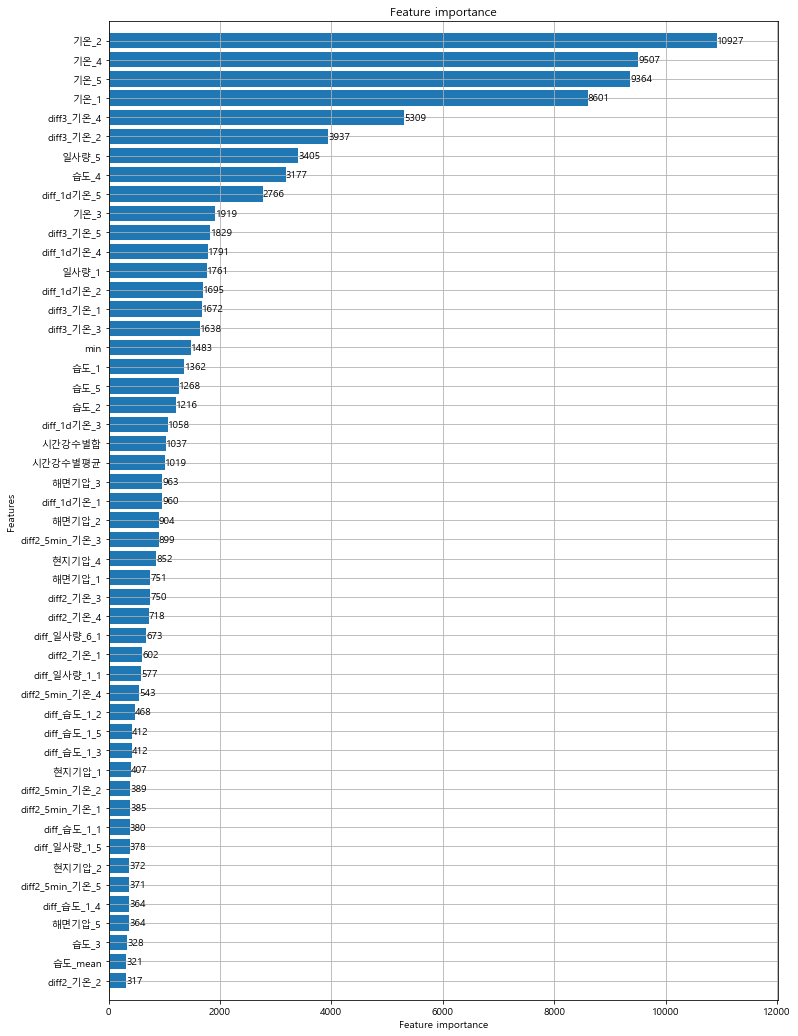

In [129]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

train_x, train_cv, y, y_cv = train_test_split(X_train,y_train, test_size=0.15, random_state=1217)

def lgbm_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2284, num_rounds=18692):

    param = {}

    param['boosting'] = 'dart'
    
    param['objective'] = 'regression'

    param['learning_rate'] = 0.05

    param['max_depth'] = 10

    param['metric'] = 'rmse'
    
    param['is_training_metric'] = True
    
    param['min_child_weight'] = 1

    param['bagging_fraction'] = 0.8
    
    param['num_leaves'] = 128

    param['feature_fraction'] = 0.8

    param['bagging_freq'] = 6
    
    param['seed'] = seed_val
    
    param['min_split_gain'] = 0.01
    
    num_rounds = num_rounds

    plst = list(param.items())

    train_ds = lgb.Dataset(train_X, label=train_y)

    test_ds = lgb.Dataset(test_X, label=test_y)

    model = lgb.train(param, train_ds, num_rounds,test_ds, early_stopping_rounds=180)

    return model

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


model = lgbm_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)

from matplotlib import pylab as plt

fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)

plt.show()

In [130]:
y_test =  np.expm1(model.predict(X_test)) + 1

submission['Y18'] = y_test

submission.to_csv('data/0409_test.csv',index=False)

In [131]:
COL5 =['기온_1', '풍속_1', '풍속_2', '강수량_1', '기온_2', '강수량_2', '일사량_1', '습도_1',
       '풍향_1', '일사량_2', '풍향_2', '일사량_3', '풍향_3', '풍속_3', '일사량_4', '습도_2',
       '강수량_3', '풍속_4', '풍향_4', '풍속_5', '기온_3', '습도_3', '기온_4', '기온_5',
       '일사량_5', '풍향_5', '강수량_4', '습도_4', '습도_5', '강수량_5', 'min', '시간별합',
       '시간별평균', '시간별편차', 'rain', '시간강수별합', '시간강수별평균', '시간강수별편차', 'time_cat_t1',
       'time_cat_t2', 'time_cat_t3', 'time_cat_t4', 'time_cat_t5',
       'time_cat_t6', 'time_cat_t7', 'time_cat_t8', 'time_cat_t9',
       'diff_36_기온_1', 'diff_72_기온_1', 'diff_144_기온_1', 'diff_216_기온_1',
       'diff_36_기온_2', 'diff_72_기온_2', 'diff_144_기온_2', 'diff_216_기온_2',
       'diff_36_기온_3', 'diff_72_기온_3', 'diff_144_기온_3', 'diff_216_기온_3',
       'diff_36_기온_4', 'diff_72_기온_4', 'diff_144_기온_4', 'diff_216_기온_4',
       'diff_36_기온_5', 'diff_72_기온_5', 'diff_144_기온_5', 'diff_216_기온_5',
       'diff_습도_1_1', 'diff_습도_1_2', 'diff_습도_1_3', 'diff_습도_1_4',
       'diff_습도_1_5', 'diff_습도_6_1', 'diff_습도_6_2', 'diff_습도_6_3',
       'diff_습도_6_4', 'diff_습도_6_5', 'diff_일사량_1_1', 'diff_일사량_1_2',
       'diff_일사량_1_3', 'diff_일사량_1_4', 'diff_일사량_1_5', 'diff_일사량_6_1',
       'diff_일사량_6_2', 'diff_일사량_6_3', 'diff_일사량_6_4', 'diff_일사량_6_5',
       '습도_mean', '일사량_mean', '일사량_습도']

In [132]:
X_train = data[COL5].iloc[:train.shape[0],:]
X_test = data[COL5].iloc[train.shape[0]:,:]

[1]	valid_0's rmse: 0.322359
[2]	valid_0's rmse: 0.306598
[3]	valid_0's rmse: 0.291745
[4]	valid_0's rmse: 0.277483
[5]	valid_0's rmse: 0.277787
[6]	valid_0's rmse: 0.264156
[7]	valid_0's rmse: 0.251291
[8]	valid_0's rmse: 0.239161
[9]	valid_0's rmse: 0.227573
[10]	valid_0's rmse: 0.216661
[11]	valid_0's rmse: 0.216657
[12]	valid_0's rmse: 0.206235
[13]	valid_0's rmse: 0.19626
[14]	valid_0's rmse: 0.198253
[15]	valid_0's rmse: 0.205099
[16]	valid_0's rmse: 0.195324
[17]	valid_0's rmse: 0.185931
[18]	valid_0's rmse: 0.177098
[19]	valid_0's rmse: 0.180741
[20]	valid_0's rmse: 0.172106
[21]	valid_0's rmse: 0.175073
[22]	valid_0's rmse: 0.166821
[23]	valid_0's rmse: 0.169918
[24]	valid_0's rmse: 0.161885
[25]	valid_0's rmse: 0.154168
[26]	valid_0's rmse: 0.14681
[27]	valid_0's rmse: 0.150606
[28]	valid_0's rmse: 0.143459
[29]	valid_0's rmse: 0.136714
[30]	valid_0's rmse: 0.395421
[31]	valid_0's rmse: 0.375866
[32]	valid_0's rmse: 0.35728
[33]	valid_0's rmse: 0.339631
[34]	valid_0's rmse: 0

[274]	valid_0's rmse: 0.266493
[275]	valid_0's rmse: 0.253362
[276]	valid_0's rmse: 0.240923
[277]	valid_0's rmse: 0.289218
[278]	valid_0's rmse: 0.299262
[279]	valid_0's rmse: 0.284505
[280]	valid_0's rmse: 0.270491
[281]	valid_0's rmse: 0.257177
[282]	valid_0's rmse: 0.26573
[283]	valid_0's rmse: 0.275238
[284]	valid_0's rmse: 0.28476
[285]	valid_0's rmse: 0.270735
[286]	valid_0's rmse: 0.257401
[287]	valid_0's rmse: 0.267436
[288]	valid_0's rmse: 0.277772
[289]	valid_0's rmse: 0.264102
[290]	valid_0's rmse: 0.251084
[291]	valid_0's rmse: 0.238738
[292]	valid_0's rmse: 0.227024
[293]	valid_0's rmse: 0.215919
[294]	valid_0's rmse: 0.225401
[295]	valid_0's rmse: 0.23552
[296]	valid_0's rmse: 0.244681
[297]	valid_0's rmse: 0.253897
[298]	valid_0's rmse: 0.262324
[299]	valid_0's rmse: 0.271757
[300]	valid_0's rmse: 0.280074
[301]	valid_0's rmse: 0.266245
[302]	valid_0's rmse: 0.253145
[303]	valid_0's rmse: 0.262283
[304]	valid_0's rmse: 0.2985
[305]	valid_0's rmse: 0.303782
[306]	valid_0

[551]	valid_0's rmse: 0.205193
[552]	valid_0's rmse: 0.212143
[553]	valid_0's rmse: 0.201802
[554]	valid_0's rmse: 0.207521
[555]	valid_0's rmse: 0.21329
[556]	valid_0's rmse: 0.218931
[557]	valid_0's rmse: 0.224945
[558]	valid_0's rmse: 0.213918
[559]	valid_0's rmse: 0.203459
[560]	valid_0's rmse: 0.19352
[561]	valid_0's rmse: 0.199824
[562]	valid_0's rmse: 0.190078
[563]	valid_0's rmse: 0.196839
[564]	valid_0's rmse: 0.18723
[565]	valid_0's rmse: 0.193544
[566]	valid_0's rmse: 0.199104
[567]	valid_0's rmse: 0.189423
[568]	valid_0's rmse: 0.180231
[569]	valid_0's rmse: 0.171514
[570]	valid_0's rmse: 0.178664
[571]	valid_0's rmse: 0.184401
[572]	valid_0's rmse: 0.175433
[573]	valid_0's rmse: 0.166925
[574]	valid_0's rmse: 0.158856
[575]	valid_0's rmse: 0.151228
[576]	valid_0's rmse: 0.143978
[577]	valid_0's rmse: 0.137127
[578]	valid_0's rmse: 0.13061
[579]	valid_0's rmse: 0.136801
[580]	valid_0's rmse: 0.130314
[581]	valid_0's rmse: 0.135407
[582]	valid_0's rmse: 0.128991
[583]	valid_

[840]	valid_0's rmse: 0.1088
[841]	valid_0's rmse: 0.103782
[842]	valid_0's rmse: 0.107855
[843]	valid_0's rmse: 0.111681
[844]	valid_0's rmse: 0.106504
[845]	valid_0's rmse: 0.110765
[846]	valid_0's rmse: 0.105658
[847]	valid_0's rmse: 0.100802
[848]	valid_0's rmse: 0.105656
[849]	valid_0's rmse: 0.109921
[850]	valid_0's rmse: 0.104843
[851]	valid_0's rmse: 0.10004
[852]	valid_0's rmse: 0.0954575
[853]	valid_0's rmse: 0.099955
[854]	valid_0's rmse: 0.0954036
[855]	valid_0's rmse: 0.099386
[856]	valid_0's rmse: 0.103414
[857]	valid_0's rmse: 0.0986859
[858]	valid_0's rmse: 0.0942157
[859]	valid_0's rmse: 0.0899712
[860]	valid_0's rmse: 0.094554
[861]	valid_0's rmse: 0.090302
[862]	valid_0's rmse: 0.0942526
[863]	valid_0's rmse: 0.090008
[864]	valid_0's rmse: 0.0859915
[865]	valid_0's rmse: 0.0821951
[866]	valid_0's rmse: 0.0862446
[867]	valid_0's rmse: 0.0824446
[868]	valid_0's rmse: 0.0863128
[869]	valid_0's rmse: 0.0901032
[870]	valid_0's rmse: 0.0860939
[871]	valid_0's rmse: 0.08228

[1113]	valid_0's rmse: 0.098693
[1114]	valid_0's rmse: 0.0941995
[1115]	valid_0's rmse: 0.0899294
[1116]	valid_0's rmse: 0.102112
[1117]	valid_0's rmse: 0.0974572
[1118]	valid_0's rmse: 0.100518
[1119]	valid_0's rmse: 0.104098
[1120]	valid_0's rmse: 0.107436
[1121]	valid_0's rmse: 0.102488
[1122]	valid_0's rmse: 0.10503
[1123]	valid_0's rmse: 0.100186
[1124]	valid_0's rmse: 0.103793
[1125]	valid_0's rmse: 0.106704
[1126]	valid_0's rmse: 0.109704
[1127]	valid_0's rmse: 0.121669
[1128]	valid_0's rmse: 0.12517
[1129]	valid_0's rmse: 0.128371
[1130]	valid_0's rmse: 0.131473
[1131]	valid_0's rmse: 0.134453
[1132]	valid_0's rmse: 0.128055
[1133]	valid_0's rmse: 0.122025
[1134]	valid_0's rmse: 0.116288
[1135]	valid_0's rmse: 0.119222
[1136]	valid_0's rmse: 0.113636
[1137]	valid_0's rmse: 0.108346
[1138]	valid_0's rmse: 0.111176
[1139]	valid_0's rmse: 0.11389
[1140]	valid_0's rmse: 0.116795
[1141]	valid_0's rmse: 0.111343
[1142]	valid_0's rmse: 0.10617
[1143]	valid_0's rmse: 0.101284
[1144]	va

[1395]	valid_0's rmse: 0.0673531
[1396]	valid_0's rmse: 0.0697505
[1397]	valid_0's rmse: 0.0722043
[1398]	valid_0's rmse: 0.0744111
[1399]	valid_0's rmse: 0.0712692
[1400]	valid_0's rmse: 0.0683032
[1401]	valid_0's rmse: 0.0655099
[1402]	valid_0's rmse: 0.062875
[1403]	valid_0's rmse: 0.0604017
[1404]	valid_0's rmse: 0.0580669
[1405]	valid_0's rmse: 0.0599995
[1406]	valid_0's rmse: 0.0620734
[1407]	valid_0's rmse: 0.0643095
[1408]	valid_0's rmse: 0.061742
[1409]	valid_0's rmse: 0.0642285
[1410]	valid_0's rmse: 0.0616688
[1411]	valid_0's rmse: 0.0592648
[1412]	valid_0's rmse: 0.0570037
[1413]	valid_0's rmse: 0.0548948
[1414]	valid_0's rmse: 0.0638722
[1415]	valid_0's rmse: 0.0613427
[1416]	valid_0's rmse: 0.0635504
[1417]	valid_0's rmse: 0.0654646
[1418]	valid_0's rmse: 0.0677796
[1419]	valid_0's rmse: 0.0706152
[1420]	valid_0's rmse: 0.0728919
[1421]	valid_0's rmse: 0.0751862
[1422]	valid_0's rmse: 0.077336
[1423]	valid_0's rmse: 0.074023
[1424]	valid_0's rmse: 0.0759827
[1425]	valid_0

[1663]	valid_0's rmse: 0.0520706
[1664]	valid_0's rmse: 0.0600825
[1665]	valid_0's rmse: 0.0577868
[1666]	valid_0's rmse: 0.0597154
[1667]	valid_0's rmse: 0.0615713
[1668]	valid_0's rmse: 0.0633578
[1669]	valid_0's rmse: 0.0651422
[1670]	valid_0's rmse: 0.0671788
[1671]	valid_0's rmse: 0.0694887
[1672]	valid_0's rmse: 0.0714067
[1673]	valid_0's rmse: 0.0798556
[1674]	valid_0's rmse: 0.0764159
[1675]	valid_0's rmse: 0.0731507
[1676]	valid_0's rmse: 0.0751779
[1677]	valid_0's rmse: 0.077048
[1678]	valid_0's rmse: 0.0791177
[1679]	valid_0's rmse: 0.0811728
[1680]	valid_0's rmse: 0.0776471
[1681]	valid_0's rmse: 0.0743271
[1682]	valid_0's rmse: 0.0762436
[1683]	valid_0's rmse: 0.078426
[1684]	valid_0's rmse: 0.0803286
[1685]	valid_0's rmse: 0.076857
[1686]	valid_0's rmse: 0.0735901
[1687]	valid_0's rmse: 0.0705019
[1688]	valid_0's rmse: 0.0789112
[1689]	valid_0's rmse: 0.0755207
[1690]	valid_0's rmse: 0.0723263
[1691]	valid_0's rmse: 0.0742178
[1692]	valid_0's rmse: 0.0710864
[1693]	valid_

[1945]	valid_0's rmse: 0.0522433
[1946]	valid_0's rmse: 0.0535326
[1947]	valid_0's rmse: 0.0516467
[1948]	valid_0's rmse: 0.0532374
[1949]	valid_0's rmse: 0.0548474
[1950]	valid_0's rmse: 0.0528743
[1951]	valid_0's rmse: 0.0543284
[1952]	valid_0's rmse: 0.0560157
[1953]	valid_0's rmse: 0.0539858
[1954]	valid_0's rmse: 0.0520784
[1955]	valid_0's rmse: 0.0538642
[1956]	valid_0's rmse: 0.0552748
[1957]	valid_0's rmse: 0.0532953
[1958]	valid_0's rmse: 0.0514457
[1959]	valid_0's rmse: 0.0497117
[1960]	valid_0's rmse: 0.0480933
[1961]	valid_0's rmse: 0.049696
[1962]	valid_0's rmse: 0.0480862
[1963]	valid_0's rmse: 0.0494296
[1964]	valid_0's rmse: 0.0478006
[1965]	valid_0's rmse: 0.0495635
[1966]	valid_0's rmse: 0.0511897
[1967]	valid_0's rmse: 0.0526212
[1968]	valid_0's rmse: 0.0507775
[1969]	valid_0's rmse: 0.0520229
[1970]	valid_0's rmse: 0.0538663
[1971]	valid_0's rmse: 0.0519394
[1972]	valid_0's rmse: 0.0533048
[1973]	valid_0's rmse: 0.0597473
[1974]	valid_0's rmse: 0.0611369
[1975]	vali

[2197]	valid_0's rmse: 0.0539096
[2198]	valid_0's rmse: 0.0555247
[2199]	valid_0's rmse: 0.0535116
[2200]	valid_0's rmse: 0.0548978
[2201]	valid_0's rmse: 0.0529006
[2202]	valid_0's rmse: 0.0543242
[2203]	valid_0's rmse: 0.0557516
[2204]	valid_0's rmse: 0.0573806
[2205]	valid_0's rmse: 0.0589439
[2206]	valid_0's rmse: 0.0602498
[2207]	valid_0's rmse: 0.0579608
[2208]	valid_0's rmse: 0.0558012
[2209]	valid_0's rmse: 0.0575282
[2210]	valid_0's rmse: 0.0590062
[2211]	valid_0's rmse: 0.0607133
[2212]	valid_0's rmse: 0.0622321
[2213]	valid_0's rmse: 0.0638605
[2214]	valid_0's rmse: 0.065256
[2215]	valid_0's rmse: 0.0626516
[2216]	valid_0's rmse: 0.0640336
[2217]	valid_0's rmse: 0.0615006
[2218]	valid_0's rmse: 0.0591208
[2219]	valid_0's rmse: 0.0568847
[2220]	valid_0's rmse: 0.0547776
[2221]	valid_0's rmse: 0.0528019
[2222]	valid_0's rmse: 0.0509533
[2223]	valid_0's rmse: 0.0523114
[2224]	valid_0's rmse: 0.0504863
[2225]	valid_0's rmse: 0.0487877
[2226]	valid_0's rmse: 0.0543733
[2227]	vali

[2481]	valid_0's rmse: 0.0523535
[2482]	valid_0's rmse: 0.0505381
[2483]	valid_0's rmse: 0.0488494
[2484]	valid_0's rmse: 0.0472795
[2485]	valid_0's rmse: 0.0458034
[2486]	valid_0's rmse: 0.046926
[2487]	valid_0's rmse: 0.0479108
[2488]	valid_0's rmse: 0.0491277
[2489]	valid_0's rmse: 0.0475286
[2490]	valid_0's rmse: 0.0460376
[2491]	valid_0's rmse: 0.0476657
[2492]	valid_0's rmse: 0.0490254
[2493]	valid_0's rmse: 0.0474276
[2494]	valid_0's rmse: 0.0487585
[2495]	valid_0's rmse: 0.0502009
[2496]	valid_0's rmse: 0.0485313
[2497]	valid_0's rmse: 0.0494879
[2498]	valid_0's rmse: 0.0478669
[2499]	valid_0's rmse: 0.0463533
[2500]	valid_0's rmse: 0.047608
[2501]	valid_0's rmse: 0.0489535
[2502]	valid_0's rmse: 0.0473658
[2503]	valid_0's rmse: 0.048455
[2504]	valid_0's rmse: 0.0499786
[2505]	valid_0's rmse: 0.0483044
[2506]	valid_0's rmse: 0.0467478
[2507]	valid_0's rmse: 0.0480465
[2508]	valid_0's rmse: 0.0465217
[2509]	valid_0's rmse: 0.0475841
[2510]	valid_0's rmse: 0.0460844
[2511]	valid_

[2734]	valid_0's rmse: 0.0475792
[2735]	valid_0's rmse: 0.048757
[2736]	valid_0's rmse: 0.0499777
[2737]	valid_0's rmse: 0.0483265
[2738]	valid_0's rmse: 0.0467832
[2739]	valid_0's rmse: 0.0453383
[2740]	valid_0's rmse: 0.0439973
[2741]	valid_0's rmse: 0.0449105
[2742]	valid_0's rmse: 0.0436009
[2743]	valid_0's rmse: 0.0423609
[2744]	valid_0's rmse: 0.0432981
[2745]	valid_0's rmse: 0.0442545
[2746]	valid_0's rmse: 0.0429832
[2747]	valid_0's rmse: 0.0417862
[2748]	valid_0's rmse: 0.0427563
[2749]	valid_0's rmse: 0.0437816
[2750]	valid_0's rmse: 0.0425613
[2751]	valid_0's rmse: 0.0434641
[2752]	valid_0's rmse: 0.0422665
[2753]	valid_0's rmse: 0.0411466
[2754]	valid_0's rmse: 0.0421772
[2755]	valid_0's rmse: 0.0431416
[2756]	valid_0's rmse: 0.0441579
[2757]	valid_0's rmse: 0.0429062
[2758]	valid_0's rmse: 0.0417338
[2759]	valid_0's rmse: 0.0428632
[2760]	valid_0's rmse: 0.0439484
[2761]	valid_0's rmse: 0.0426718
[2762]	valid_0's rmse: 0.0436854
[2763]	valid_0's rmse: 0.0446873
[2764]	vali

[2989]	valid_0's rmse: 0.0439961
[2990]	valid_0's rmse: 0.0448972
[2991]	valid_0's rmse: 0.0456442
[2992]	valid_0's rmse: 0.0442677
[2993]	valid_0's rmse: 0.0450585
[2994]	valid_0's rmse: 0.0461714
[2995]	valid_0's rmse: 0.0447811
[2996]	valid_0's rmse: 0.0456317
[2997]	valid_0's rmse: 0.0468943
[2998]	valid_0's rmse: 0.0478086
[2999]	valid_0's rmse: 0.0463062
[3000]	valid_0's rmse: 0.0471424
[3001]	valid_0's rmse: 0.0481861
[3002]	valid_0's rmse: 0.0466604
[3003]	valid_0's rmse: 0.0473635
[3004]	valid_0's rmse: 0.0482242
[3005]	valid_0's rmse: 0.0466852
[3006]	valid_0's rmse: 0.0476733
[3007]	valid_0's rmse: 0.0487984
[3008]	valid_0's rmse: 0.0498406
[3009]	valid_0's rmse: 0.0510091
[3010]	valid_0's rmse: 0.0519832
[3011]	valid_0's rmse: 0.0502059
[3012]	valid_0's rmse: 0.0512706
[3013]	valid_0's rmse: 0.0520458
[3014]	valid_0's rmse: 0.0528092
[3015]	valid_0's rmse: 0.0509878
[3016]	valid_0's rmse: 0.049282
[3017]	valid_0's rmse: 0.0505466
[3018]	valid_0's rmse: 0.0514702
[3019]	vali

[3244]	valid_0's rmse: 0.0328313
[3245]	valid_0's rmse: 0.0324106
[3246]	valid_0's rmse: 0.0330958
[3247]	valid_0's rmse: 0.0326657
[3248]	valid_0's rmse: 0.0322681
[3249]	valid_0's rmse: 0.0328451
[3250]	valid_0's rmse: 0.0324309
[3251]	valid_0's rmse: 0.032055
[3252]	valid_0's rmse: 0.0317108
[3253]	valid_0's rmse: 0.0313821
[3254]	valid_0's rmse: 0.0310813
[3255]	valid_0's rmse: 0.0308015
[3256]	valid_0's rmse: 0.0305493
[3257]	valid_0's rmse: 0.0310678
[3258]	valid_0's rmse: 0.0315946
[3259]	valid_0's rmse: 0.0312771
[3260]	valid_0's rmse: 0.0309886
[3261]	valid_0's rmse: 0.0307244
[3262]	valid_0's rmse: 0.0304809
[3263]	valid_0's rmse: 0.0309443
[3264]	valid_0's rmse: 0.0315455
[3265]	valid_0's rmse: 0.0319794
[3266]	valid_0's rmse: 0.0325351
[3267]	valid_0's rmse: 0.0330495
[3268]	valid_0's rmse: 0.0335566
[3269]	valid_0's rmse: 0.0339875
[3270]	valid_0's rmse: 0.0345556
[3271]	valid_0's rmse: 0.0339916
[3272]	valid_0's rmse: 0.0344285
[3273]	valid_0's rmse: 0.0351323
[3274]	vali

[3532]	valid_0's rmse: 0.0348298
[3533]	valid_0's rmse: 0.0342583
[3534]	valid_0's rmse: 0.0337218
[3535]	valid_0's rmse: 0.0332329
[3536]	valid_0's rmse: 0.0338545
[3537]	valid_0's rmse: 0.0343899
[3538]	valid_0's rmse: 0.0338532
[3539]	valid_0's rmse: 0.0333504
[3540]	valid_0's rmse: 0.0339298
[3541]	valid_0's rmse: 0.0334292
[3542]	valid_0's rmse: 0.0329564
[3543]	valid_0's rmse: 0.0325331
[3544]	valid_0's rmse: 0.0321336
[3545]	valid_0's rmse: 0.0317826
[3546]	valid_0's rmse: 0.0314465
[3547]	valid_0's rmse: 0.031933
[3548]	valid_0's rmse: 0.0315941
[3549]	valid_0's rmse: 0.0312707
[3550]	valid_0's rmse: 0.0317493
[3551]	valid_0's rmse: 0.0321768
[3552]	valid_0's rmse: 0.03284
[3553]	valid_0's rmse: 0.033297
[3554]	valid_0's rmse: 0.0337623
[3555]	valid_0's rmse: 0.0342994
[3556]	valid_0's rmse: 0.0337699
[3557]	valid_0's rmse: 0.0342407
[3558]	valid_0's rmse: 0.0337172
[3559]	valid_0's rmse: 0.0332269
[3560]	valid_0's rmse: 0.0337054
[3561]	valid_0's rmse: 0.0332067
[3562]	valid_0

[3797]	valid_0's rmse: 0.0421502
[3798]	valid_0's rmse: 0.0410468
[3799]	valid_0's rmse: 0.0415235
[3800]	valid_0's rmse: 0.0404669
[3801]	valid_0's rmse: 0.0411574
[3802]	valid_0's rmse: 0.041727
[3803]	valid_0's rmse: 0.0406561
[3804]	valid_0's rmse: 0.0411902
[3805]	valid_0's rmse: 0.0418217
[3806]	valid_0's rmse: 0.0423453
[3807]	valid_0's rmse: 0.042989
[3808]	valid_0's rmse: 0.0418048
[3809]	valid_0's rmse: 0.0424187
[3810]	valid_0's rmse: 0.0432662
[3811]	valid_0's rmse: 0.043853
[3812]	valid_0's rmse: 0.0447662
[3813]	valid_0's rmse: 0.0434767
[3814]	valid_0's rmse: 0.0440813
[3815]	valid_0's rmse: 0.0428421
[3816]	valid_0's rmse: 0.0416643
[3817]	valid_0's rmse: 0.0421918
[3818]	valid_0's rmse: 0.0428891
[3819]	valid_0's rmse: 0.0417217
[3820]	valid_0's rmse: 0.0423662
[3821]	valid_0's rmse: 0.0456557
[3822]	valid_0's rmse: 0.0464657
[3823]	valid_0's rmse: 0.0450564
[3824]	valid_0's rmse: 0.04589
[3825]	valid_0's rmse: 0.0445311
[3826]	valid_0's rmse: 0.0451409
[3827]	valid_0'

[4078]	valid_0's rmse: 0.0328623
[4079]	valid_0's rmse: 0.0333412
[4080]	valid_0's rmse: 0.0338398
[4081]	valid_0's rmse: 0.0344005
[4082]	valid_0's rmse: 0.0338771
[4083]	valid_0's rmse: 0.0333881
[4084]	valid_0's rmse: 0.0329506
[4085]	valid_0's rmse: 0.0334533
[4086]	valid_0's rmse: 0.0330061
[4087]	valid_0's rmse: 0.0334712
[4088]	valid_0's rmse: 0.033917
[4089]	valid_0's rmse: 0.033426
[4090]	valid_0's rmse: 0.0339237
[4091]	valid_0's rmse: 0.0344133
[4092]	valid_0's rmse: 0.0338708
[4093]	valid_0's rmse: 0.0333826
[4094]	valid_0's rmse: 0.0329354
[4095]	valid_0's rmse: 0.0353168
[4096]	valid_0's rmse: 0.0358722
[4097]	valid_0's rmse: 0.0352208
[4098]	valid_0's rmse: 0.0346261
[4099]	valid_0's rmse: 0.0352331
[4100]	valid_0's rmse: 0.0356635
[4101]	valid_0's rmse: 0.0350373
[4102]	valid_0's rmse: 0.0355194
[4103]	valid_0's rmse: 0.0349013
[4104]	valid_0's rmse: 0.0355085
[4105]	valid_0's rmse: 0.0359226
[4106]	valid_0's rmse: 0.0352793
[4107]	valid_0's rmse: 0.0346812
[4108]	valid

[4599]	valid_0's rmse: 0.0330798
[4600]	valid_0's rmse: 0.0326417
[4601]	valid_0's rmse: 0.0322503
[4602]	valid_0's rmse: 0.0326046
[4603]	valid_0's rmse: 0.0322169
[4604]	valid_0's rmse: 0.0318519
[4605]	valid_0's rmse: 0.0322635
[4606]	valid_0's rmse: 0.0319056
[4607]	valid_0's rmse: 0.0315729
[4608]	valid_0's rmse: 0.0312347
[4609]	valid_0's rmse: 0.0315699
[4610]	valid_0's rmse: 0.0312629
[4611]	valid_0's rmse: 0.0309475
[4612]	valid_0's rmse: 0.0313554
[4613]	valid_0's rmse: 0.0316852
[4614]	valid_0's rmse: 0.0321143
[4615]	valid_0's rmse: 0.0325996
[4616]	valid_0's rmse: 0.0322056
[4617]	valid_0's rmse: 0.0318528
[4618]	valid_0's rmse: 0.0315234
[4619]	valid_0's rmse: 0.0319134
[4620]	valid_0's rmse: 0.0322691
[4621]	valid_0's rmse: 0.0318946
[4622]	valid_0's rmse: 0.0315535
[4623]	valid_0's rmse: 0.0319883
[4624]	valid_0's rmse: 0.0323603
[4625]	valid_0's rmse: 0.0319887
[4626]	valid_0's rmse: 0.0316485
[4627]	valid_0's rmse: 0.0320025
[4628]	valid_0's rmse: 0.032432
[4629]	vali

[4878]	valid_0's rmse: 0.0325152
[4879]	valid_0's rmse: 0.0330145
[4880]	valid_0's rmse: 0.032592
[4881]	valid_0's rmse: 0.0322091
[4882]	valid_0's rmse: 0.0327025
[4883]	valid_0's rmse: 0.032311
[4884]	valid_0's rmse: 0.0319451
[4885]	valid_0's rmse: 0.0323685
[4886]	valid_0's rmse: 0.0327213
[4887]	valid_0's rmse: 0.0332047
[4888]	valid_0's rmse: 0.032768
[4889]	valid_0's rmse: 0.0323664
[4890]	valid_0's rmse: 0.0326761
[4891]	valid_0's rmse: 0.0330687
[4892]	valid_0's rmse: 0.0334761
[4893]	valid_0's rmse: 0.0337967
[4894]	valid_0's rmse: 0.0333117
[4895]	valid_0's rmse: 0.0337054
[4896]	valid_0's rmse: 0.0339873
[4897]	valid_0's rmse: 0.034523
[4898]	valid_0's rmse: 0.0348584
[4899]	valid_0's rmse: 0.0353296
[4900]	valid_0's rmse: 0.0347282
[4901]	valid_0's rmse: 0.0354194
[4902]	valid_0's rmse: 0.0359561
[4903]	valid_0's rmse: 0.0353064
[4904]	valid_0's rmse: 0.0357176
[4905]	valid_0's rmse: 0.0350891
[4906]	valid_0's rmse: 0.0345043
[4907]	valid_0's rmse: 0.0339691
[4908]	valid_0

[5139]	valid_0's rmse: 0.0360448
[5140]	valid_0's rmse: 0.0364877
[5141]	valid_0's rmse: 0.036943
[5142]	valid_0's rmse: 0.0362072
[5143]	valid_0's rmse: 0.0366852
[5144]	valid_0's rmse: 0.037008
[5145]	valid_0's rmse: 0.0373193
[5146]	valid_0's rmse: 0.0377058
[5147]	valid_0's rmse: 0.0382211
[5148]	valid_0's rmse: 0.0373908
[5149]	valid_0's rmse: 0.0378483
[5150]	valid_0's rmse: 0.0383184
[5151]	valid_0's rmse: 0.0374784
[5152]	valid_0's rmse: 0.0366854
[5153]	valid_0's rmse: 0.0371727
[5154]	valid_0's rmse: 0.0376518
[5155]	valid_0's rmse: 0.0368617
[5156]	valid_0's rmse: 0.0361323
[5157]	valid_0's rmse: 0.0354615
[5158]	valid_0's rmse: 0.034841
[5159]	valid_0's rmse: 0.0351434
[5160]	valid_0's rmse: 0.0345446
[5161]	valid_0's rmse: 0.0340025
[5162]	valid_0's rmse: 0.0360551
[5163]	valid_0's rmse: 0.0365292
[5164]	valid_0's rmse: 0.035816
[5165]	valid_0's rmse: 0.0351602
[5166]	valid_0's rmse: 0.0345402
[5167]	valid_0's rmse: 0.0339843
[5168]	valid_0's rmse: 0.0334865
[5169]	valid_0

[5416]	valid_0's rmse: 0.0339532
[5417]	valid_0's rmse: 0.0334562
[5418]	valid_0's rmse: 0.0329969
[5419]	valid_0's rmse: 0.0325821
[5420]	valid_0's rmse: 0.0329236
[5421]	valid_0's rmse: 0.0333643
[5422]	valid_0's rmse: 0.0337033
[5423]	valid_0's rmse: 0.0332308
[5424]	valid_0's rmse: 0.0327894
[5425]	valid_0's rmse: 0.0323897
[5426]	valid_0's rmse: 0.0320386
[5427]	valid_0's rmse: 0.0316967
[5428]	valid_0's rmse: 0.0319237
[5429]	valid_0's rmse: 0.0315914
[5430]	valid_0's rmse: 0.0312917
[5431]	valid_0's rmse: 0.0315814
[5432]	valid_0's rmse: 0.0312791
[5433]	valid_0's rmse: 0.0315517
[5434]	valid_0's rmse: 0.0317929
[5435]	valid_0's rmse: 0.031473
[5436]	valid_0's rmse: 0.0316913
[5437]	valid_0's rmse: 0.0313775
[5438]	valid_0's rmse: 0.0310927
[5439]	valid_0's rmse: 0.0313305
[5440]	valid_0's rmse: 0.0310432
[5441]	valid_0's rmse: 0.0307879
[5442]	valid_0's rmse: 0.0305537
[5443]	valid_0's rmse: 0.0303353
[5444]	valid_0's rmse: 0.0301476
[5445]	valid_0's rmse: 0.0303439
[5446]	vali

[5709]	valid_0's rmse: 0.0331412
[5710]	valid_0's rmse: 0.0327188
[5711]	valid_0's rmse: 0.0323275
[5712]	valid_0's rmse: 0.0325381
[5713]	valid_0's rmse: 0.0321563
[5714]	valid_0's rmse: 0.032461
[5715]	valid_0's rmse: 0.0327838
[5716]	valid_0's rmse: 0.033035
[5717]	valid_0's rmse: 0.0334017
[5718]	valid_0's rmse: 0.0338142
[5719]	valid_0's rmse: 0.0341707
[5720]	valid_0's rmse: 0.0344445
[5721]	valid_0's rmse: 0.0338948
[5722]	valid_0's rmse: 0.0342807
[5723]	valid_0's rmse: 0.0337553
[5724]	valid_0's rmse: 0.0332644
[5725]	valid_0's rmse: 0.032827
[5726]	valid_0's rmse: 0.03326
[5727]	valid_0's rmse: 0.0328293
[5728]	valid_0's rmse: 0.0324358
[5729]	valid_0's rmse: 0.0320738
[5730]	valid_0's rmse: 0.0323491
[5731]	valid_0's rmse: 0.0319959
[5732]	valid_0's rmse: 0.0316668
[5733]	valid_0's rmse: 0.0313658
[5734]	valid_0's rmse: 0.0310931
[5735]	valid_0's rmse: 0.0313189
[5736]	valid_0's rmse: 0.0310475
[5737]	valid_0's rmse: 0.0312663
[5738]	valid_0's rmse: 0.0316043
[5739]	valid_0'

[5961]	valid_0's rmse: 0.0328888
[5962]	valid_0's rmse: 0.03315
[5963]	valid_0's rmse: 0.0327363
[5964]	valid_0's rmse: 0.0323472
[5965]	valid_0's rmse: 0.0319863
[5966]	valid_0's rmse: 0.0323628
[5967]	valid_0's rmse: 0.032899
[5968]	valid_0's rmse: 0.0331518
[5969]	valid_0's rmse: 0.0327333
[5970]	valid_0's rmse: 0.0330388
[5971]	valid_0's rmse: 0.0326285
[5972]	valid_0's rmse: 0.0322538
[5973]	valid_0's rmse: 0.0324752
[5974]	valid_0's rmse: 0.0321117
[5975]	valid_0's rmse: 0.0317795
[5976]	valid_0's rmse: 0.0321001
[5977]	valid_0's rmse: 0.0317726
[5978]	valid_0's rmse: 0.0314618
[5979]	valid_0's rmse: 0.0317993
[5980]	valid_0's rmse: 0.0321948
[5981]	valid_0's rmse: 0.0324729
[5982]	valid_0's rmse: 0.0321072
[5983]	valid_0's rmse: 0.0323688
[5984]	valid_0's rmse: 0.0327187
[5985]	valid_0's rmse: 0.0330922
[5986]	valid_0's rmse: 0.033601
[5987]	valid_0's rmse: 0.0340037
[5988]	valid_0's rmse: 0.0335143
[5989]	valid_0's rmse: 0.0338278
[5990]	valid_0's rmse: 0.0333549
[5991]	valid_0

[6223]	valid_0's rmse: 0.0339191
[6224]	valid_0's rmse: 0.0334333
[6225]	valid_0's rmse: 0.0329934
[6226]	valid_0's rmse: 0.0325852
[6227]	valid_0's rmse: 0.0330308
[6228]	valid_0's rmse: 0.032623
[6229]	valid_0's rmse: 0.0328732
[6230]	valid_0's rmse: 0.0324722
[6231]	valid_0's rmse: 0.0327454
[6232]	valid_0's rmse: 0.0323637
[6233]	valid_0's rmse: 0.0327751
[6234]	valid_0's rmse: 0.0323896
[6235]	valid_0's rmse: 0.0320404
[6236]	valid_0's rmse: 0.0323131
[6237]	valid_0's rmse: 0.0326652
[6238]	valid_0's rmse: 0.0322937
[6239]	valid_0's rmse: 0.0319532
[6240]	valid_0's rmse: 0.0322812
[6241]	valid_0's rmse: 0.0319234
[6242]	valid_0's rmse: 0.0321271
[6243]	valid_0's rmse: 0.0317892
[6244]	valid_0's rmse: 0.032031
[6245]	valid_0's rmse: 0.0323718
[6246]	valid_0's rmse: 0.0320121
[6247]	valid_0's rmse: 0.0321646
[6248]	valid_0's rmse: 0.0318327
[6249]	valid_0's rmse: 0.033358
[6250]	valid_0's rmse: 0.033825
[6251]	valid_0's rmse: 0.0333657
[6252]	valid_0's rmse: 0.03294
[6253]	valid_0's

[6499]	valid_0's rmse: 0.0344587
[6500]	valid_0's rmse: 0.0348632
[6501]	valid_0's rmse: 0.0352179
[6502]	valid_0's rmse: 0.0346265
[6503]	valid_0's rmse: 0.0340882
[6504]	valid_0's rmse: 0.0343011
[6505]	valid_0's rmse: 0.034682
[6506]	valid_0's rmse: 0.0350045
[6507]	valid_0's rmse: 0.0344446
[6508]	valid_0's rmse: 0.0339305
[6509]	valid_0's rmse: 0.0334587
[6510]	valid_0's rmse: 0.0337529
[6511]	valid_0's rmse: 0.0332967
[6512]	valid_0's rmse: 0.0328762
[6513]	valid_0's rmse: 0.0330431
[6514]	valid_0's rmse: 0.0334421
[6515]	valid_0's rmse: 0.0337592
[6516]	valid_0's rmse: 0.0333028
[6517]	valid_0's rmse: 0.0328817
[6518]	valid_0's rmse: 0.0331824
[6519]	valid_0's rmse: 0.0327675
[6520]	valid_0's rmse: 0.0323927
[6521]	valid_0's rmse: 0.0320482
[6522]	valid_0's rmse: 0.0323105
[6523]	valid_0's rmse: 0.0319736
[6524]	valid_0's rmse: 0.0316573
[6525]	valid_0's rmse: 0.031378
[6526]	valid_0's rmse: 0.0316967
[6527]	valid_0's rmse: 0.0320692
[6528]	valid_0's rmse: 0.0323425
[6529]	valid

[6774]	valid_0's rmse: 0.0334166
[6775]	valid_0's rmse: 0.0329822
[6776]	valid_0's rmse: 0.0332064
[6777]	valid_0's rmse: 0.0335343
[6778]	valid_0's rmse: 0.0330998
[6779]	valid_0's rmse: 0.0335066
[6780]	valid_0's rmse: 0.0330809
[6781]	valid_0's rmse: 0.0326875
[6782]	valid_0's rmse: 0.0323257
[6783]	valid_0's rmse: 0.0325585
[6784]	valid_0's rmse: 0.0328191
[6785]	valid_0's rmse: 0.0324375
[6786]	valid_0's rmse: 0.032711
[6787]	valid_0's rmse: 0.033061
[6788]	valid_0's rmse: 0.0334797
[6789]	valid_0's rmse: 0.0337312
[6790]	valid_0's rmse: 0.0339716
[6791]	valid_0's rmse: 0.0342837
[6792]	valid_0's rmse: 0.0346474
[6793]	valid_0's rmse: 0.0348701
[6794]	valid_0's rmse: 0.0351408
[6795]	valid_0's rmse: 0.0355928
[6796]	valid_0's rmse: 0.0349858
[6797]	valid_0's rmse: 0.0353568
[6798]	valid_0's rmse: 0.0358111
[6799]	valid_0's rmse: 0.0351785
[6800]	valid_0's rmse: 0.035445
[6801]	valid_0's rmse: 0.0348571
[6802]	valid_0's rmse: 0.0343142
[6803]	valid_0's rmse: 0.0346775
[6804]	valid_

[7055]	valid_0's rmse: 0.0318542
[7056]	valid_0's rmse: 0.0321634
[7057]	valid_0's rmse: 0.0318376
[7058]	valid_0's rmse: 0.0315408
[7059]	valid_0's rmse: 0.0317303
[7060]	valid_0's rmse: 0.0319854
[7061]	valid_0's rmse: 0.0316757
[7062]	valid_0's rmse: 0.0318948
[7063]	valid_0's rmse: 0.0321048
[7064]	valid_0's rmse: 0.0317848
[7065]	valid_0's rmse: 0.0319399
[7066]	valid_0's rmse: 0.0322245
[7067]	valid_0's rmse: 0.0324611
[7068]	valid_0's rmse: 0.0321117
[7069]	valid_0's rmse: 0.0323806
[7070]	valid_0's rmse: 0.0320412
[7071]	valid_0's rmse: 0.0317307
[7072]	valid_0's rmse: 0.0319228
[7073]	valid_0's rmse: 0.0316223
[7074]	valid_0's rmse: 0.031817
[7075]	valid_0's rmse: 0.0320554
[7076]	valid_0's rmse: 0.0317334
[7077]	valid_0's rmse: 0.0314445
[7078]	valid_0's rmse: 0.0316257
[7079]	valid_0's rmse: 0.031338
[7080]	valid_0's rmse: 0.0315825
[7081]	valid_0's rmse: 0.0313108
[7082]	valid_0's rmse: 0.0315081
[7083]	valid_0's rmse: 0.0316808
[7084]	valid_0's rmse: 0.0314039
[7085]	valid

[7317]	valid_0's rmse: 0.0312419
[7318]	valid_0's rmse: 0.0314354
[7319]	valid_0's rmse: 0.0316142
[7320]	valid_0's rmse: 0.0313507
[7321]	valid_0's rmse: 0.0311096
[7322]	valid_0's rmse: 0.0308891
[7323]	valid_0's rmse: 0.0310325
[7324]	valid_0's rmse: 0.0308202
[7325]	valid_0's rmse: 0.030624
[7326]	valid_0's rmse: 0.0307773
[7327]	valid_0's rmse: 0.0310544
[7328]	valid_0's rmse: 0.0308309
[7329]	valid_0's rmse: 0.0306289
[7330]	valid_0's rmse: 0.0304432
[7331]	valid_0's rmse: 0.0306172
[7332]	valid_0's rmse: 0.0304318
[7333]	valid_0's rmse: 0.0302629
[7334]	valid_0's rmse: 0.0301091
[7335]	valid_0's rmse: 0.0299716
[7336]	valid_0's rmse: 0.0298439
[7337]	valid_0's rmse: 0.0299719
[7338]	valid_0's rmse: 0.0301068
[7339]	valid_0's rmse: 0.029963
[7340]	valid_0's rmse: 0.0298358
[7341]	valid_0's rmse: 0.0298358
[7342]	valid_0's rmse: 0.0298358
[7343]	valid_0's rmse: 0.0299644
[7344]	valid_0's rmse: 0.0301249
[7345]	valid_0's rmse: 0.0303042
[7346]	valid_0's rmse: 0.0304418
[7347]	valid

[7598]	valid_0's rmse: 0.0329953
[7599]	valid_0's rmse: 0.0326122
[7600]	valid_0's rmse: 0.0329601
[7601]	valid_0's rmse: 0.0325727
[7602]	valid_0's rmse: 0.0327716
[7603]	valid_0's rmse: 0.0324003
[7604]	valid_0's rmse: 0.0320653
[7605]	valid_0's rmse: 0.032474
[7606]	valid_0's rmse: 0.0326539
[7607]	valid_0's rmse: 0.0322987
[7608]	valid_0's rmse: 0.0319696
[7609]	valid_0's rmse: 0.0316781
[7610]	valid_0's rmse: 0.0318393
[7611]	valid_0's rmse: 0.0320633
[7612]	valid_0's rmse: 0.0317626
[7613]	valid_0's rmse: 0.0319762
[7614]	valid_0's rmse: 0.0316851
[7615]	valid_0's rmse: 0.0314168
[7616]	valid_0's rmse: 0.0315907
[7617]	valid_0's rmse: 0.031331
[7618]	valid_0's rmse: 0.0310954
[7619]	valid_0's rmse: 0.0312309
[7620]	valid_0's rmse: 0.0314759
[7621]	valid_0's rmse: 0.0312161
[7622]	valid_0's rmse: 0.0314447
[7623]	valid_0's rmse: 0.0311881
[7624]	valid_0's rmse: 0.0323284
[7625]	valid_0's rmse: 0.032604
[7626]	valid_0's rmse: 0.0328661
[7627]	valid_0's rmse: 0.0324951
[7628]	valid_

[7879]	valid_0's rmse: 0.0317135
[7880]	valid_0's rmse: 0.031938
[7881]	valid_0's rmse: 0.032202
[7882]	valid_0's rmse: 0.0318812
[7883]	valid_0's rmse: 0.0320283
[7884]	valid_0's rmse: 0.0317204
[7885]	valid_0's rmse: 0.0319871
[7886]	valid_0's rmse: 0.0321171
[7887]	valid_0's rmse: 0.0317987
[7888]	valid_0's rmse: 0.0319445
[7889]	valid_0's rmse: 0.0316468
[7890]	valid_0's rmse: 0.0313737
[7891]	valid_0's rmse: 0.031606
[7892]	valid_0's rmse: 0.0313335
[7893]	valid_0's rmse: 0.0310935
[7894]	valid_0's rmse: 0.030868
[7895]	valid_0's rmse: 0.031024
[7896]	valid_0's rmse: 0.0312611
[7897]	valid_0's rmse: 0.0314385
[7898]	valid_0's rmse: 0.0316928
[7899]	valid_0's rmse: 0.0318071
[7900]	valid_0's rmse: 0.0315225
[7901]	valid_0's rmse: 0.0316769
[7902]	valid_0's rmse: 0.031406
[7903]	valid_0's rmse: 0.0311566
[7904]	valid_0's rmse: 0.0313993
[7905]	valid_0's rmse: 0.0324262
[7906]	valid_0's rmse: 0.0320839
[7907]	valid_0's rmse: 0.0322343
[7908]	valid_0's rmse: 0.0324934
[7909]	valid_0's

[8143]	valid_0's rmse: 0.0308449
[8144]	valid_0's rmse: 0.0310702
[8145]	valid_0's rmse: 0.0308499
[8146]	valid_0's rmse: 0.0308499
[8147]	valid_0's rmse: 0.0308499
[8148]	valid_0's rmse: 0.0308499
[8149]	valid_0's rmse: 0.0309605
[8150]	valid_0's rmse: 0.0311253
[8151]	valid_0's rmse: 0.0309009
[8152]	valid_0's rmse: 0.0309009
[8153]	valid_0's rmse: 0.0309009
[8154]	valid_0's rmse: 0.030999
[8155]	valid_0's rmse: 0.0307767
[8156]	valid_0's rmse: 0.0307767
[8157]	valid_0's rmse: 0.0309165
[8158]	valid_0's rmse: 0.0309165
[8159]	valid_0's rmse: 0.031121
[8160]	valid_0's rmse: 0.0312903
[8161]	valid_0's rmse: 0.0310517
[8162]	valid_0's rmse: 0.0312374
[8163]	valid_0's rmse: 0.0309895
[8164]	valid_0's rmse: 0.031181
[8165]	valid_0's rmse: 0.0313487
[8166]	valid_0's rmse: 0.031464
[8167]	valid_0's rmse: 0.0311976
[8168]	valid_0's rmse: 0.0313903
[8169]	valid_0's rmse: 0.031143
[8170]	valid_0's rmse: 0.0309113
[8171]	valid_0's rmse: 0.0306994
[8172]	valid_0's rmse: 0.0308705
[8173]	valid_0'

[8404]	valid_0's rmse: 0.0313987
[8405]	valid_0's rmse: 0.0311527
[8406]	valid_0's rmse: 0.0312732
[8407]	valid_0's rmse: 0.0314341
[8408]	valid_0's rmse: 0.0311855
[8409]	valid_0's rmse: 0.0311855
[8410]	valid_0's rmse: 0.0314696
[8411]	valid_0's rmse: 0.0316404
[8412]	valid_0's rmse: 0.031767
[8413]	valid_0's rmse: 0.0314859
[8414]	valid_0's rmse: 0.0316991
[8415]	valid_0's rmse: 0.0314267
[8416]	valid_0's rmse: 0.0316071
[8417]	valid_0's rmse: 0.0317844
[8418]	valid_0's rmse: 0.0319381
[8419]	valid_0's rmse: 0.0319381
[8420]	valid_0's rmse: 0.0319381
[8421]	valid_0's rmse: 0.0321307
[8422]	valid_0's rmse: 0.0318276
[8423]	valid_0's rmse: 0.0319895
[8424]	valid_0's rmse: 0.032193
[8425]	valid_0's rmse: 0.0318721
[8426]	valid_0's rmse: 0.0315828
[8427]	valid_0's rmse: 0.0317467
[8428]	valid_0's rmse: 0.0319137
[8429]	valid_0's rmse: 0.0316207
[8430]	valid_0's rmse: 0.0317513
[8431]	valid_0's rmse: 0.0319005
[8432]	valid_0's rmse: 0.032127
[8433]	valid_0's rmse: 0.0318221
[8434]	valid_

[8688]	valid_0's rmse: 0.0310134
[8689]	valid_0's rmse: 0.0308063
[8690]	valid_0's rmse: 0.0308063
[8691]	valid_0's rmse: 0.0308063
[8692]	valid_0's rmse: 0.0310233
[8693]	valid_0's rmse: 0.0310233
[8694]	valid_0's rmse: 0.0310233
[8695]	valid_0's rmse: 0.0310233
[8696]	valid_0's rmse: 0.0311373
[8697]	valid_0's rmse: 0.0311373
[8698]	valid_0's rmse: 0.0313761
[8699]	valid_0's rmse: 0.0313761
[8700]	valid_0's rmse: 0.0313761
[8701]	valid_0's rmse: 0.0314685
[8702]	valid_0's rmse: 0.0314685
[8703]	valid_0's rmse: 0.0317093
[8704]	valid_0's rmse: 0.0314325
[8705]	valid_0's rmse: 0.0315574
[8706]	valid_0's rmse: 0.031296
[8707]	valid_0's rmse: 0.0310653
[8708]	valid_0's rmse: 0.030847
[8709]	valid_0's rmse: 0.0309822
[8710]	valid_0's rmse: 0.0307791
[8711]	valid_0's rmse: 0.030888
[8712]	valid_0's rmse: 0.0310211
[8713]	valid_0's rmse: 0.0312354
[8714]	valid_0's rmse: 0.0310017
[8715]	valid_0's rmse: 0.03124
[8716]	valid_0's rmse: 0.0314396
[8717]	valid_0's rmse: 0.0316685
[8718]	valid_0'

[8970]	valid_0's rmse: 0.0312699
[8971]	valid_0's rmse: 0.0310499
[8972]	valid_0's rmse: 0.0308509
[8973]	valid_0's rmse: 0.0308509
[8974]	valid_0's rmse: 0.0310162
[8975]	valid_0's rmse: 0.0311389
[8976]	valid_0's rmse: 0.0313517
[8977]	valid_0's rmse: 0.0311188
[8978]	valid_0's rmse: 0.0309092
[8979]	valid_0's rmse: 0.0310227
[8980]	valid_0's rmse: 0.0312071
[8981]	valid_0's rmse: 0.0309902
[8982]	valid_0's rmse: 0.0307926
[8983]	valid_0's rmse: 0.0309118
[8984]	valid_0's rmse: 0.0310793
[8985]	valid_0's rmse: 0.0312106
[8986]	valid_0's rmse: 0.0314248
[8987]	valid_0's rmse: 0.0311876
[8988]	valid_0's rmse: 0.0309589
[8989]	valid_0's rmse: 0.0307536
[8990]	valid_0's rmse: 0.0309173
[8991]	valid_0's rmse: 0.0307107
[8992]	valid_0's rmse: 0.0308915
[8993]	valid_0's rmse: 0.0310877
[8994]	valid_0's rmse: 0.0308663
[8995]	valid_0's rmse: 0.0309623
[8996]	valid_0's rmse: 0.0311151
[8997]	valid_0's rmse: 0.0312547
[8998]	valid_0's rmse: 0.0313807
[8999]	valid_0's rmse: 0.0315942
[9000]	val

[9250]	valid_0's rmse: 0.0307691
[9251]	valid_0's rmse: 0.0308724
[9252]	valid_0's rmse: 0.031033
[9253]	valid_0's rmse: 0.031206
[9254]	valid_0's rmse: 0.0313812
[9255]	valid_0's rmse: 0.0311425
[9256]	valid_0's rmse: 0.0312949
[9257]	valid_0's rmse: 0.0314411
[9258]	valid_0's rmse: 0.0311985
[9259]	valid_0's rmse: 0.0313464
[9260]	valid_0's rmse: 0.0311103
[9261]	valid_0's rmse: 0.0312859
[9262]	valid_0's rmse: 0.0314806
[9263]	valid_0's rmse: 0.0316991
[9264]	valid_0's rmse: 0.0314333
[9265]	valid_0's rmse: 0.0311914
[9266]	valid_0's rmse: 0.0313361
[9267]	valid_0's rmse: 0.0311002
[9268]	valid_0's rmse: 0.0313017
[9269]	valid_0's rmse: 0.0321415
[9270]	valid_0's rmse: 0.0323464
[9271]	valid_0's rmse: 0.0320121
[9272]	valid_0's rmse: 0.0322141
[9273]	valid_0's rmse: 0.0318554
[9274]	valid_0's rmse: 0.0320636
[9275]	valid_0's rmse: 0.0322766
[9276]	valid_0's rmse: 0.0323843
[9277]	valid_0's rmse: 0.0320505
[9278]	valid_0's rmse: 0.0320505
[9279]	valid_0's rmse: 0.032285
[9280]	valid_

[9554]	valid_0's rmse: 0.0306783
[9555]	valid_0's rmse: 0.0306783
[9556]	valid_0's rmse: 0.0306783
[9557]	valid_0's rmse: 0.0306783
[9558]	valid_0's rmse: 0.0308585
[9559]	valid_0's rmse: 0.0309933
[9560]	valid_0's rmse: 0.0307854
[9561]	valid_0's rmse: 0.0305947
[9562]	valid_0's rmse: 0.0307284
[9563]	valid_0's rmse: 0.0308826
[9564]	valid_0's rmse: 0.0306827
[9565]	valid_0's rmse: 0.0307931
[9566]	valid_0's rmse: 0.0309239
[9567]	valid_0's rmse: 0.0309239
[9568]	valid_0's rmse: 0.0309239
[9569]	valid_0's rmse: 0.0309239
[9570]	valid_0's rmse: 0.0309239
[9571]	valid_0's rmse: 0.0309239
[9572]	valid_0's rmse: 0.0309239
[9573]	valid_0's rmse: 0.0309239
[9574]	valid_0's rmse: 0.0309239
[9575]	valid_0's rmse: 0.0309239
[9576]	valid_0's rmse: 0.0309239
[9577]	valid_0's rmse: 0.0309239
[9578]	valid_0's rmse: 0.0309239
[9579]	valid_0's rmse: 0.0309239
[9580]	valid_0's rmse: 0.0310714
[9581]	valid_0's rmse: 0.0310714
[9582]	valid_0's rmse: 0.0312492
[9583]	valid_0's rmse: 0.0310256
[9584]	val

[9843]	valid_0's rmse: 0.031094
[9844]	valid_0's rmse: 0.0308903
[9845]	valid_0's rmse: 0.0307002
[9846]	valid_0's rmse: 0.0308469
[9847]	valid_0's rmse: 0.0308469
[9848]	valid_0's rmse: 0.0309483
[9849]	valid_0's rmse: 0.0311048
[9850]	valid_0's rmse: 0.0312553
[9851]	valid_0's rmse: 0.0310335
[9852]	valid_0's rmse: 0.030833
[9853]	valid_0's rmse: 0.0306473
[9854]	valid_0's rmse: 0.0306473
[9855]	valid_0's rmse: 0.0306473
[9856]	valid_0's rmse: 0.0306473
[9857]	valid_0's rmse: 0.0306473
[9858]	valid_0's rmse: 0.0306473
[9859]	valid_0's rmse: 0.0306473
[9860]	valid_0's rmse: 0.0306473
[9861]	valid_0's rmse: 0.0307879
[9862]	valid_0's rmse: 0.0306024
[9863]	valid_0's rmse: 0.0304327
[9864]	valid_0's rmse: 0.0302782
[9865]	valid_0's rmse: 0.0303742
[9866]	valid_0's rmse: 0.0304943
[9867]	valid_0's rmse: 0.0304943
[9868]	valid_0's rmse: 0.030633
[9869]	valid_0's rmse: 0.0307467
[9870]	valid_0's rmse: 0.0308626
[9871]	valid_0's rmse: 0.0310003
[9872]	valid_0's rmse: 0.0311141
[9873]	valid_

[10119]	valid_0's rmse: 0.0314308
[10120]	valid_0's rmse: 0.0315212
[10121]	valid_0's rmse: 0.0312789
[10122]	valid_0's rmse: 0.0313833
[10123]	valid_0's rmse: 0.0311382
[10124]	valid_0's rmse: 0.0312734
[10125]	valid_0's rmse: 0.0313638
[10126]	valid_0's rmse: 0.0314859
[10127]	valid_0's rmse: 0.0316578
[10128]	valid_0's rmse: 0.0313919
[10129]	valid_0's rmse: 0.0311589
[10130]	valid_0's rmse: 0.031264
[10131]	valid_0's rmse: 0.0310364
[10132]	valid_0's rmse: 0.0311447
[10133]	valid_0's rmse: 0.0309238
[10134]	valid_0's rmse: 0.0307234
[10135]	valid_0's rmse: 0.0307234
[10136]	valid_0's rmse: 0.0307234
[10137]	valid_0's rmse: 0.0307234
[10138]	valid_0's rmse: 0.0308318
[10139]	valid_0's rmse: 0.0309519
[10140]	valid_0's rmse: 0.0307535
[10141]	valid_0's rmse: 0.0308932
[10142]	valid_0's rmse: 0.0310203
[10143]	valid_0's rmse: 0.0308189
[10144]	valid_0's rmse: 0.0308189
[10145]	valid_0's rmse: 0.0308189
[10146]	valid_0's rmse: 0.0308926
[10147]	valid_0's rmse: 0.0308926
[10148]	valid_0

[10402]	valid_0's rmse: 0.0305769
[10403]	valid_0's rmse: 0.0307106
[10404]	valid_0's rmse: 0.0307106
[10405]	valid_0's rmse: 0.0308769
[10406]	valid_0's rmse: 0.0308769
[10407]	valid_0's rmse: 0.0309565
[10408]	valid_0's rmse: 0.0310455
[10409]	valid_0's rmse: 0.0311333
[10410]	valid_0's rmse: 0.0311333
[10411]	valid_0's rmse: 0.0312615
[10412]	valid_0's rmse: 0.0310459
[10413]	valid_0's rmse: 0.0311354
[10414]	valid_0's rmse: 0.030931
[10415]	valid_0's rmse: 0.0310714
[10416]	valid_0's rmse: 0.031156
[10417]	valid_0's rmse: 0.0309427
[10418]	valid_0's rmse: 0.0307501
[10419]	valid_0's rmse: 0.0307501
[10420]	valid_0's rmse: 0.0309497
[10421]	valid_0's rmse: 0.0307542
[10422]	valid_0's rmse: 0.0308813
[10423]	valid_0's rmse: 0.0310155
[10424]	valid_0's rmse: 0.0310155
[10425]	valid_0's rmse: 0.0308179
[10426]	valid_0's rmse: 0.0308179
[10427]	valid_0's rmse: 0.0308179
[10428]	valid_0's rmse: 0.0308179
[10429]	valid_0's rmse: 0.0308179
[10430]	valid_0's rmse: 0.0308998
[10431]	valid_0'

[10671]	valid_0's rmse: 0.0312737
[10672]	valid_0's rmse: 0.0319831
[10673]	valid_0's rmse: 0.0319831
[10674]	valid_0's rmse: 0.0320619
[10675]	valid_0's rmse: 0.0321542
[10676]	valid_0's rmse: 0.0322733
[10677]	valid_0's rmse: 0.0324616
[10678]	valid_0's rmse: 0.0324616
[10679]	valid_0's rmse: 0.0326823
[10680]	valid_0's rmse: 0.0327669
[10681]	valid_0's rmse: 0.0327669
[10682]	valid_0's rmse: 0.0328926
[10683]	valid_0's rmse: 0.032531
[10684]	valid_0's rmse: 0.0322013
[10685]	valid_0's rmse: 0.032321
[10686]	valid_0's rmse: 0.0324102
[10687]	valid_0's rmse: 0.0325681
[10688]	valid_0's rmse: 0.0322341
[10689]	valid_0's rmse: 0.0319341
[10690]	valid_0's rmse: 0.0316565
[10691]	valid_0's rmse: 0.031728
[10692]	valid_0's rmse: 0.0314728
[10693]	valid_0's rmse: 0.0316078
[10694]	valid_0's rmse: 0.0316974
[10695]	valid_0's rmse: 0.0318409
[10696]	valid_0's rmse: 0.0319847
[10697]	valid_0's rmse: 0.0321223
[10698]	valid_0's rmse: 0.0322367
[10699]	valid_0's rmse: 0.0319195
[10700]	valid_0's

[10931]	valid_0's rmse: 0.0315598
[10932]	valid_0's rmse: 0.0316966
[10933]	valid_0's rmse: 0.0316966
[10934]	valid_0's rmse: 0.0317973
[10935]	valid_0's rmse: 0.0315323
[10936]	valid_0's rmse: 0.0316486
[10937]	valid_0's rmse: 0.0317556
[10938]	valid_0's rmse: 0.0318716
[10939]	valid_0's rmse: 0.0315931
[10940]	valid_0's rmse: 0.0315931
[10941]	valid_0's rmse: 0.0316957
[10942]	valid_0's rmse: 0.0318093
[10943]	valid_0's rmse: 0.0315331
[10944]	valid_0's rmse: 0.0315331
[10945]	valid_0's rmse: 0.0315331
[10946]	valid_0's rmse: 0.0315331
[10947]	valid_0's rmse: 0.0315331
[10948]	valid_0's rmse: 0.0315331
[10949]	valid_0's rmse: 0.0316714
[10950]	valid_0's rmse: 0.0316714
[10951]	valid_0's rmse: 0.0316714
[10952]	valid_0's rmse: 0.0317712
[10953]	valid_0's rmse: 0.0318501
[10954]	valid_0's rmse: 0.0318501
[10955]	valid_0's rmse: 0.0318501
[10956]	valid_0's rmse: 0.0319938
[10957]	valid_0's rmse: 0.0317023
[10958]	valid_0's rmse: 0.0314421
[10959]	valid_0's rmse: 0.0315286
[10960]	valid_

[11204]	valid_0's rmse: 0.0305768
[11205]	valid_0's rmse: 0.0306577
[11206]	valid_0's rmse: 0.0307434
[11207]	valid_0's rmse: 0.03057
[11208]	valid_0's rmse: 0.03057
[11209]	valid_0's rmse: 0.03057
[11210]	valid_0's rmse: 0.03057
[11211]	valid_0's rmse: 0.0306477
[11212]	valid_0's rmse: 0.0304765
[11213]	valid_0's rmse: 0.0305591
[11214]	valid_0's rmse: 0.0303988
[11215]	valid_0's rmse: 0.0302527
[11216]	valid_0's rmse: 0.0303177
[11217]	valid_0's rmse: 0.0304171
[11218]	valid_0's rmse: 0.0305129
[11219]	valid_0's rmse: 0.0306355
[11220]	valid_0's rmse: 0.0307273
[11221]	valid_0's rmse: 0.0308114
[11222]	valid_0's rmse: 0.0306305
[11223]	valid_0's rmse: 0.0307601
[11224]	valid_0's rmse: 0.0308584
[11225]	valid_0's rmse: 0.0306749
[11226]	valid_0's rmse: 0.0307462
[11227]	valid_0's rmse: 0.0305739
[11228]	valid_0's rmse: 0.0306474
[11229]	valid_0's rmse: 0.0306474
[11230]	valid_0's rmse: 0.0306474
[11231]	valid_0's rmse: 0.0306474
[11232]	valid_0's rmse: 0.0306474
[11233]	valid_0's rmse

[11460]	valid_0's rmse: 0.0311011
[11461]	valid_0's rmse: 0.0312132
[11462]	valid_0's rmse: 0.0312132
[11463]	valid_0's rmse: 0.0312132
[11464]	valid_0's rmse: 0.0313003
[11465]	valid_0's rmse: 0.0313836
[11466]	valid_0's rmse: 0.0314726
[11467]	valid_0's rmse: 0.0321943
[11468]	valid_0's rmse: 0.0322808
[11469]	valid_0's rmse: 0.0323974
[11470]	valid_0's rmse: 0.0323974
[11471]	valid_0's rmse: 0.0325203
[11472]	valid_0's rmse: 0.0325203
[11473]	valid_0's rmse: 0.0325203
[11474]	valid_0's rmse: 0.0325203
[11475]	valid_0's rmse: 0.0325203
[11476]	valid_0's rmse: 0.0325203
[11477]	valid_0's rmse: 0.0325203
[11478]	valid_0's rmse: 0.0325203
[11479]	valid_0's rmse: 0.0326345
[11480]	valid_0's rmse: 0.0326345
[11481]	valid_0's rmse: 0.0323016
[11482]	valid_0's rmse: 0.0323016
[11483]	valid_0's rmse: 0.0324202
[11484]	valid_0's rmse: 0.0324202
[11485]	valid_0's rmse: 0.0324202
[11486]	valid_0's rmse: 0.0325751
[11487]	valid_0's rmse: 0.0326842
[11488]	valid_0's rmse: 0.0323331
[11489]	valid_

[11738]	valid_0's rmse: 0.030543
[11739]	valid_0's rmse: 0.0306456
[11740]	valid_0's rmse: 0.0307297
[11741]	valid_0's rmse: 0.0307979
[11742]	valid_0's rmse: 0.0307979
[11743]	valid_0's rmse: 0.0306234
[11744]	valid_0's rmse: 0.0306904
[11745]	valid_0's rmse: 0.0306904
[11746]	valid_0's rmse: 0.0306904
[11747]	valid_0's rmse: 0.0306904
[11748]	valid_0's rmse: 0.0307442
[11749]	valid_0's rmse: 0.0308204
[11750]	valid_0's rmse: 0.0306517
[11751]	valid_0's rmse: 0.0306517
[11752]	valid_0's rmse: 0.0306517
[11753]	valid_0's rmse: 0.0306517
[11754]	valid_0's rmse: 0.030722
[11755]	valid_0's rmse: 0.030722
[11756]	valid_0's rmse: 0.030722
[11757]	valid_0's rmse: 0.0307709
[11758]	valid_0's rmse: 0.0306068
[11759]	valid_0's rmse: 0.0306068
[11760]	valid_0's rmse: 0.0306068
[11761]	valid_0's rmse: 0.0306703
[11762]	valid_0's rmse: 0.0306703
[11763]	valid_0's rmse: 0.0307428
[11764]	valid_0's rmse: 0.03082
[11765]	valid_0's rmse: 0.03082
[11766]	valid_0's rmse: 0.03082
[11767]	valid_0's rmse: 

[12020]	valid_0's rmse: 0.0307683
[12021]	valid_0's rmse: 0.0306027
[12022]	valid_0's rmse: 0.0306677
[12023]	valid_0's rmse: 0.0305126
[12024]	valid_0's rmse: 0.0303706
[12025]	valid_0's rmse: 0.030233
[12026]	valid_0's rmse: 0.030233
[12027]	valid_0's rmse: 0.030233
[12028]	valid_0's rmse: 0.030233
[12029]	valid_0's rmse: 0.030233
[12030]	valid_0's rmse: 0.030233
[12031]	valid_0's rmse: 0.030233
[12032]	valid_0's rmse: 0.0302948
[12033]	valid_0's rmse: 0.030394
[12034]	valid_0's rmse: 0.0302508
[12035]	valid_0's rmse: 0.0303385
[12036]	valid_0's rmse: 0.0303385
[12037]	valid_0's rmse: 0.0304133
[12038]	valid_0's rmse: 0.0304862
[12039]	valid_0's rmse: 0.0304862
[12040]	valid_0's rmse: 0.0304862
[12041]	valid_0's rmse: 0.0304862
[12042]	valid_0's rmse: 0.0305621
[12043]	valid_0's rmse: 0.0306516
[12044]	valid_0's rmse: 0.0306516
[12045]	valid_0's rmse: 0.0307195
[12046]	valid_0's rmse: 0.0307195
[12047]	valid_0's rmse: 0.0307954
[12048]	valid_0's rmse: 0.0307954
[12049]	valid_0's rmse

[12270]	valid_0's rmse: 0.0310073
[12271]	valid_0's rmse: 0.0310802
[12272]	valid_0's rmse: 0.0311408
[12273]	valid_0's rmse: 0.0312222
[12274]	valid_0's rmse: 0.0312222
[12275]	valid_0's rmse: 0.0312222
[12276]	valid_0's rmse: 0.0312222
[12277]	valid_0's rmse: 0.0313011
[12278]	valid_0's rmse: 0.0314602
[12279]	valid_0's rmse: 0.0312392
[12280]	valid_0's rmse: 0.0312392
[12281]	valid_0's rmse: 0.0312392
[12282]	valid_0's rmse: 0.0312392
[12283]	valid_0's rmse: 0.0313117
[12284]	valid_0's rmse: 0.0313982
[12285]	valid_0's rmse: 0.0314685
[12286]	valid_0's rmse: 0.0315546
[12287]	valid_0's rmse: 0.031657
[12288]	valid_0's rmse: 0.0314189
[12289]	valid_0's rmse: 0.0312013
[12290]	valid_0's rmse: 0.031281
[12291]	valid_0's rmse: 0.0313261
[12292]	valid_0's rmse: 0.0313261
[12293]	valid_0's rmse: 0.0314174
[12294]	valid_0's rmse: 0.0314174
[12295]	valid_0's rmse: 0.0314174
[12296]	valid_0's rmse: 0.0314824
[12297]	valid_0's rmse: 0.0315555
[12298]	valid_0's rmse: 0.0315555
[12299]	valid_0'

[12548]	valid_0's rmse: 0.0311435
[12549]	valid_0's rmse: 0.030948
[12550]	valid_0's rmse: 0.0310269
[12551]	valid_0's rmse: 0.0310269
[12552]	valid_0's rmse: 0.0310269
[12553]	valid_0's rmse: 0.0310909
[12554]	valid_0's rmse: 0.0311782
[12555]	valid_0's rmse: 0.0311782
[12556]	valid_0's rmse: 0.0311782
[12557]	valid_0's rmse: 0.0311782
[12558]	valid_0's rmse: 0.0311782
[12559]	valid_0's rmse: 0.0312594
[12560]	valid_0's rmse: 0.0312594
[12561]	valid_0's rmse: 0.0313611
[12562]	valid_0's rmse: 0.0313611
[12563]	valid_0's rmse: 0.0314158
[12564]	valid_0's rmse: 0.0315357
[12565]	valid_0's rmse: 0.0316802
[12566]	valid_0's rmse: 0.0314401
[12567]	valid_0's rmse: 0.0315053
[12568]	valid_0's rmse: 0.0315747
[12569]	valid_0's rmse: 0.0313416
[12570]	valid_0's rmse: 0.031128
[12571]	valid_0's rmse: 0.0311914
[12572]	valid_0's rmse: 0.0312542
[12573]	valid_0's rmse: 0.0313113
[12574]	valid_0's rmse: 0.0313763
[12575]	valid_0's rmse: 0.031168
[12576]	valid_0's rmse: 0.0309742
[12577]	valid_0's

[12809]	valid_0's rmse: 0.0307348
[12810]	valid_0's rmse: 0.0308134
[12811]	valid_0's rmse: 0.0314286
[12812]	valid_0's rmse: 0.0315177
[12813]	valid_0's rmse: 0.0312616
[12814]	valid_0's rmse: 0.0313417
[12815]	valid_0's rmse: 0.0311199
[12816]	valid_0's rmse: 0.0312242
[12817]	valid_0's rmse: 0.0312773
[12818]	valid_0's rmse: 0.0310615
[12819]	valid_0's rmse: 0.0308653
[12820]	valid_0's rmse: 0.0309142
[12821]	valid_0's rmse: 0.030985
[12822]	valid_0's rmse: 0.030798
[12823]	valid_0's rmse: 0.030859
[12824]	valid_0's rmse: 0.0306883
[12825]	valid_0's rmse: 0.0307664
[12826]	valid_0's rmse: 0.0307664
[12827]	valid_0's rmse: 0.0307664
[12828]	valid_0's rmse: 0.0307664
[12829]	valid_0's rmse: 0.0308479
[12830]	valid_0's rmse: 0.0309091
[12831]	valid_0's rmse: 0.0307316
[12832]	valid_0's rmse: 0.0307316
[12833]	valid_0's rmse: 0.0307316
[12834]	valid_0's rmse: 0.0309002
[12835]	valid_0's rmse: 0.0309002
[12836]	valid_0's rmse: 0.0307258
[12837]	valid_0's rmse: 0.0307258
[12838]	valid_0's

[13052]	valid_0's rmse: 0.0311207
[13053]	valid_0's rmse: 0.0312253
[13054]	valid_0's rmse: 0.0313081
[13055]	valid_0's rmse: 0.0310956
[13056]	valid_0's rmse: 0.0311425
[13057]	valid_0's rmse: 0.0309444
[13058]	valid_0's rmse: 0.0311037
[13059]	valid_0's rmse: 0.0309093
[13060]	valid_0's rmse: 0.0307312
[13061]	valid_0's rmse: 0.0307805
[13062]	valid_0's rmse: 0.030869
[13063]	valid_0's rmse: 0.030869
[13064]	valid_0's rmse: 0.030869
[13065]	valid_0's rmse: 0.0309698
[13066]	valid_0's rmse: 0.0311099
[13067]	valid_0's rmse: 0.0311099
[13068]	valid_0's rmse: 0.0311099
[13069]	valid_0's rmse: 0.0311881
[13070]	valid_0's rmse: 0.0313544
[13071]	valid_0's rmse: 0.0311282
[13072]	valid_0's rmse: 0.0311702
[13073]	valid_0's rmse: 0.0311702
[13074]	valid_0's rmse: 0.0312477
[13075]	valid_0's rmse: 0.0312477
[13076]	valid_0's rmse: 0.0313993
[13077]	valid_0's rmse: 0.0311694
[13078]	valid_0's rmse: 0.0312521
[13079]	valid_0's rmse: 0.0312521
[13080]	valid_0's rmse: 0.0313232
[13081]	valid_0's

[13318]	valid_0's rmse: 0.0321048
[13319]	valid_0's rmse: 0.0318185
[13320]	valid_0's rmse: 0.0319124
[13321]	valid_0's rmse: 0.031655
[13322]	valid_0's rmse: 0.0314191
[13323]	valid_0's rmse: 0.0312003
[13324]	valid_0's rmse: 0.0312003
[13325]	valid_0's rmse: 0.0312003
[13326]	valid_0's rmse: 0.0312003
[13327]	valid_0's rmse: 0.0312003
[13328]	valid_0's rmse: 0.0312446
[13329]	valid_0's rmse: 0.0312446
[13330]	valid_0's rmse: 0.0313225
[13331]	valid_0's rmse: 0.0311144
[13332]	valid_0's rmse: 0.0312445
[13333]	valid_0's rmse: 0.031297
[13334]	valid_0's rmse: 0.0310902
[13335]	valid_0's rmse: 0.0312267
[13336]	valid_0's rmse: 0.0310338
[13337]	valid_0's rmse: 0.0311237
[13338]	valid_0's rmse: 0.0312382
[13339]	valid_0's rmse: 0.0310338
[13340]	valid_0's rmse: 0.0310338
[13341]	valid_0's rmse: 0.0310969
[13342]	valid_0's rmse: 0.0310969
[13343]	valid_0's rmse: 0.0310969
[13344]	valid_0's rmse: 0.0311562
[13345]	valid_0's rmse: 0.0312238
[13346]	valid_0's rmse: 0.0310227
[13347]	valid_0'

[13571]	valid_0's rmse: 0.0305415
[13572]	valid_0's rmse: 0.0304068
[13573]	valid_0's rmse: 0.0302842
[13574]	valid_0's rmse: 0.0302842
[13575]	valid_0's rmse: 0.0303703
[13576]	valid_0's rmse: 0.0304531
[13577]	valid_0's rmse: 0.0305144
[13578]	valid_0's rmse: 0.0305144
[13579]	valid_0's rmse: 0.0305144
[13580]	valid_0's rmse: 0.0305816
[13581]	valid_0's rmse: 0.0306634
[13582]	valid_0's rmse: 0.0307287
[13583]	valid_0's rmse: 0.0305673
[13584]	valid_0's rmse: 0.03042
[13585]	valid_0's rmse: 0.0305177
[13586]	valid_0's rmse: 0.0305686
[13587]	valid_0's rmse: 0.0306856
[13588]	valid_0's rmse: 0.0305281
[13589]	valid_0's rmse: 0.0306299
[13590]	valid_0's rmse: 0.0306831
[13591]	valid_0's rmse: 0.0305293
[13592]	valid_0's rmse: 0.0305293
[13593]	valid_0's rmse: 0.0306008
[13594]	valid_0's rmse: 0.0306916
[13595]	valid_0's rmse: 0.030759
[13596]	valid_0's rmse: 0.0305922
[13597]	valid_0's rmse: 0.0307045
[13598]	valid_0's rmse: 0.0305427
[13599]	valid_0's rmse: 0.0305909
[13600]	valid_0's

[13860]	valid_0's rmse: 0.0313456
[13861]	valid_0's rmse: 0.0313456
[13862]	valid_0's rmse: 0.0313456
[13863]	valid_0's rmse: 0.0313456
[13864]	valid_0's rmse: 0.0313456
[13865]	valid_0's rmse: 0.031398
[13866]	valid_0's rmse: 0.031398
[13867]	valid_0's rmse: 0.031398
[13868]	valid_0's rmse: 0.031398
[13869]	valid_0's rmse: 0.031398
[13870]	valid_0's rmse: 0.0314683
[13871]	valid_0's rmse: 0.0315482
[13872]	valid_0's rmse: 0.0315482
[13873]	valid_0's rmse: 0.0316569
[13874]	valid_0's rmse: 0.0317257
[13875]	valid_0's rmse: 0.0318606
[13876]	valid_0's rmse: 0.0319293
[13877]	valid_0's rmse: 0.0316615
[13878]	valid_0's rmse: 0.0317752
[13879]	valid_0's rmse: 0.0315312
[13880]	valid_0's rmse: 0.0316331
[13881]	valid_0's rmse: 0.0313821
[13882]	valid_0's rmse: 0.0311632
[13883]	valid_0's rmse: 0.0309568
[13884]	valid_0's rmse: 0.0307758
[13885]	valid_0's rmse: 0.0307758
[13886]	valid_0's rmse: 0.0307758
[13887]	valid_0's rmse: 0.0307758
[13888]	valid_0's rmse: 0.0308555
[13889]	valid_0's r

[14102]	valid_0's rmse: 0.0307672
[14103]	valid_0's rmse: 0.0308658
[14104]	valid_0's rmse: 0.0308658
[14105]	valid_0's rmse: 0.0308658
[14106]	valid_0's rmse: 0.0306957
[14107]	valid_0's rmse: 0.0306957
[14108]	valid_0's rmse: 0.0307647
[14109]	valid_0's rmse: 0.0307647
[14110]	valid_0's rmse: 0.0307647
[14111]	valid_0's rmse: 0.0308475
[14112]	valid_0's rmse: 0.0308966
[14113]	valid_0's rmse: 0.0309649
[14114]	valid_0's rmse: 0.0310716
[14115]	valid_0's rmse: 0.0311084
[14116]	valid_0's rmse: 0.0309201
[14117]	valid_0's rmse: 0.0307448
[14118]	valid_0's rmse: 0.0307448
[14119]	valid_0's rmse: 0.0308283
[14120]	valid_0's rmse: 0.0309239
[14121]	valid_0's rmse: 0.0310043
[14122]	valid_0's rmse: 0.0310808
[14123]	valid_0's rmse: 0.0311268
[14124]	valid_0's rmse: 0.0312014
[14125]	valid_0's rmse: 0.0312014
[14126]	valid_0's rmse: 0.0312448
[14127]	valid_0's rmse: 0.0310429
[14128]	valid_0's rmse: 0.0310905
[14129]	valid_0's rmse: 0.031192
[14130]	valid_0's rmse: 0.030995
[14131]	valid_0'

[14345]	valid_0's rmse: 0.0309339
[14346]	valid_0's rmse: 0.0309881
[14347]	valid_0's rmse: 0.0310733
[14348]	valid_0's rmse: 0.0310733
[14349]	valid_0's rmse: 0.0310733
[14350]	valid_0's rmse: 0.0311535
[14351]	valid_0's rmse: 0.0311535
[14352]	valid_0's rmse: 0.0312422
[14353]	valid_0's rmse: 0.0313158
[14354]	valid_0's rmse: 0.0314091
[14355]	valid_0's rmse: 0.0314091
[14356]	valid_0's rmse: 0.0314713
[14357]	valid_0's rmse: 0.0312488
[14358]	valid_0's rmse: 0.0310529
[14359]	valid_0's rmse: 0.0310529
[14360]	valid_0's rmse: 0.0310529
[14361]	valid_0's rmse: 0.0311153
[14362]	valid_0's rmse: 0.0311677
[14363]	valid_0's rmse: 0.0312335
[14364]	valid_0's rmse: 0.0312335
[14365]	valid_0's rmse: 0.0313142
[14366]	valid_0's rmse: 0.0313142
[14367]	valid_0's rmse: 0.0314004
[14368]	valid_0's rmse: 0.0311831
[14369]	valid_0's rmse: 0.0311831
[14370]	valid_0's rmse: 0.0312838
[14371]	valid_0's rmse: 0.0312838
[14372]	valid_0's rmse: 0.0312838
[14373]	valid_0's rmse: 0.0313523
[14374]	valid_

[14597]	valid_0's rmse: 0.031344
[14598]	valid_0's rmse: 0.0313929
[14599]	valid_0's rmse: 0.0313929
[14600]	valid_0's rmse: 0.0314772
[14601]	valid_0's rmse: 0.0315874
[14602]	valid_0's rmse: 0.0316954
[14603]	valid_0's rmse: 0.0317781
[14604]	valid_0's rmse: 0.0315181
[14605]	valid_0's rmse: 0.0315903
[14606]	valid_0's rmse: 0.0316837
[14607]	valid_0's rmse: 0.0314325
[14608]	valid_0's rmse: 0.0312141
[14609]	valid_0's rmse: 0.0312965
[14610]	valid_0's rmse: 0.0310699
[14611]	valid_0's rmse: 0.0308783
[14612]	valid_0's rmse: 0.0307003
[14613]	valid_0's rmse: 0.0305413
[14614]	valid_0's rmse: 0.0305413
[14615]	valid_0's rmse: 0.0306299
[14616]	valid_0's rmse: 0.0304751
[14617]	valid_0's rmse: 0.0303397
[14618]	valid_0's rmse: 0.0303397
[14619]	valid_0's rmse: 0.030402
[14620]	valid_0's rmse: 0.0304717
[14621]	valid_0's rmse: 0.0304717
[14622]	valid_0's rmse: 0.0304717
[14623]	valid_0's rmse: 0.0305225
[14624]	valid_0's rmse: 0.0306166
[14625]	valid_0's rmse: 0.0306166
[14626]	valid_0'

[14848]	valid_0's rmse: 0.0311408
[14849]	valid_0's rmse: 0.0311408
[14850]	valid_0's rmse: 0.0312051
[14851]	valid_0's rmse: 0.0312051
[14852]	valid_0's rmse: 0.0312051
[14853]	valid_0's rmse: 0.0312051
[14854]	valid_0's rmse: 0.0312855
[14855]	valid_0's rmse: 0.031333
[14856]	valid_0's rmse: 0.0313905
[14857]	valid_0's rmse: 0.0314634
[14858]	valid_0's rmse: 0.0312487
[14859]	valid_0's rmse: 0.0312487
[14860]	valid_0's rmse: 0.0312487
[14861]	valid_0's rmse: 0.0312487
[14862]	valid_0's rmse: 0.0313111
[14863]	valid_0's rmse: 0.0313111
[14864]	valid_0's rmse: 0.0313111
[14865]	valid_0's rmse: 0.0313985
[14866]	valid_0's rmse: 0.0315007
[14867]	valid_0's rmse: 0.0316258
[14868]	valid_0's rmse: 0.0316711
[14869]	valid_0's rmse: 0.0317499
[14870]	valid_0's rmse: 0.0318138
[14871]	valid_0's rmse: 0.0315445
[14872]	valid_0's rmse: 0.0313211
[14873]	valid_0's rmse: 0.0314287
[14874]	valid_0's rmse: 0.0315047
[14875]	valid_0's rmse: 0.0315566
[14876]	valid_0's rmse: 0.031612
[14877]	valid_0'

[15115]	valid_0's rmse: 0.0317919
[15116]	valid_0's rmse: 0.031861
[15117]	valid_0's rmse: 0.031861
[15118]	valid_0's rmse: 0.0319445
[15119]	valid_0's rmse: 0.0319445
[15120]	valid_0's rmse: 0.0316867
[15121]	valid_0's rmse: 0.0318107
[15122]	valid_0's rmse: 0.0319372
[15123]	valid_0's rmse: 0.0316721
[15124]	valid_0's rmse: 0.0314275
[15125]	valid_0's rmse: 0.0314681
[15126]	valid_0's rmse: 0.0312392
[15127]	valid_0's rmse: 0.0310339
[15128]	valid_0's rmse: 0.0310994
[15129]	valid_0's rmse: 0.0312203
[15130]	valid_0's rmse: 0.0310175
[15131]	valid_0's rmse: 0.0308328
[15132]	valid_0's rmse: 0.0306647
[15133]	valid_0's rmse: 0.0306647
[15134]	valid_0's rmse: 0.030724
[15135]	valid_0's rmse: 0.030724
[15136]	valid_0's rmse: 0.0308354
[15137]	valid_0's rmse: 0.0306596
[15138]	valid_0's rmse: 0.0306596
[15139]	valid_0's rmse: 0.0307273
[15140]	valid_0's rmse: 0.0307273
[15141]	valid_0's rmse: 0.0308627
[15142]	valid_0's rmse: 0.0309149
[15143]	valid_0's rmse: 0.0309149
[15144]	valid_0's 

[15380]	valid_0's rmse: 0.0316047
[15381]	valid_0's rmse: 0.0313752
[15382]	valid_0's rmse: 0.0311649
[15383]	valid_0's rmse: 0.0312197
[15384]	valid_0's rmse: 0.0312501
[15385]	valid_0's rmse: 0.0310507
[15386]	valid_0's rmse: 0.0311674
[15387]	valid_0's rmse: 0.0312156
[15388]	valid_0's rmse: 0.0312764
[15389]	valid_0's rmse: 0.0313618
[15390]	valid_0's rmse: 0.0311362
[15391]	valid_0's rmse: 0.0309447
[15392]	valid_0's rmse: 0.0307663
[15393]	valid_0's rmse: 0.0308216
[15394]	valid_0's rmse: 0.0308216
[15395]	valid_0's rmse: 0.0308216
[15396]	valid_0's rmse: 0.0308216
[15397]	valid_0's rmse: 0.0309277
[15398]	valid_0's rmse: 0.0309277
[15399]	valid_0's rmse: 0.0309277
[15400]	valid_0's rmse: 0.0310447
[15401]	valid_0's rmse: 0.0310447
[15402]	valid_0's rmse: 0.0311048
[15403]	valid_0's rmse: 0.0312355
[15404]	valid_0's rmse: 0.0312967
[15405]	valid_0's rmse: 0.0310845
[15406]	valid_0's rmse: 0.0308898
[15407]	valid_0's rmse: 0.0307161
[15408]	valid_0's rmse: 0.0307761
[15409]	valid_

[15651]	valid_0's rmse: 0.0310275
[15652]	valid_0's rmse: 0.0310644
[15653]	valid_0's rmse: 0.0311409
[15654]	valid_0's rmse: 0.0309499
[15655]	valid_0's rmse: 0.0309499
[15656]	valid_0's rmse: 0.0309499
[15657]	valid_0's rmse: 0.031086
[15658]	valid_0's rmse: 0.031086
[15659]	valid_0's rmse: 0.031086
[15660]	valid_0's rmse: 0.031086
[15661]	valid_0's rmse: 0.0311246
[15662]	valid_0's rmse: 0.0311246
[15663]	valid_0's rmse: 0.0311858
[15664]	valid_0's rmse: 0.031239
[15665]	valid_0's rmse: 0.0312962
[15666]	valid_0's rmse: 0.0312962
[15667]	valid_0's rmse: 0.0314102
[15668]	valid_0's rmse: 0.0314102
[15669]	valid_0's rmse: 0.0314958
[15670]	valid_0's rmse: 0.0314958
[15671]	valid_0's rmse: 0.0316268
[15672]	valid_0's rmse: 0.0316268
[15673]	valid_0's rmse: 0.0316268
[15674]	valid_0's rmse: 0.0317117
[15675]	valid_0's rmse: 0.0314642
[15676]	valid_0's rmse: 0.0312393
[15677]	valid_0's rmse: 0.031031
[15678]	valid_0's rmse: 0.0308438
[15679]	valid_0's rmse: 0.0308438
[15680]	valid_0's rm

[15923]	valid_0's rmse: 0.0307254
[15924]	valid_0's rmse: 0.0307663
[15925]	valid_0's rmse: 0.030855
[15926]	valid_0's rmse: 0.030855
[15927]	valid_0's rmse: 0.030855
[15928]	valid_0's rmse: 0.0309214
[15929]	valid_0's rmse: 0.0310423
[15930]	valid_0's rmse: 0.0310778
[15931]	valid_0's rmse: 0.0309064
[15932]	valid_0's rmse: 0.0309564
[15933]	valid_0's rmse: 0.0310444
[15934]	valid_0's rmse: 0.0311019
[15935]	valid_0's rmse: 0.0311617
[15936]	valid_0's rmse: 0.0312234
[15937]	valid_0's rmse: 0.0310354
[15938]	valid_0's rmse: 0.0310934
[15939]	valid_0's rmse: 0.0309173
[15940]	valid_0's rmse: 0.030756
[15941]	valid_0's rmse: 0.0306104
[15942]	valid_0's rmse: 0.0306489
[15943]	valid_0's rmse: 0.0307181
[15944]	valid_0's rmse: 0.0307181
[15945]	valid_0's rmse: 0.0308212
[15946]	valid_0's rmse: 0.0308212
[15947]	valid_0's rmse: 0.0308212
[15948]	valid_0's rmse: 0.0308212
[15949]	valid_0's rmse: 0.030868
[15950]	valid_0's rmse: 0.030963
[15951]	valid_0's rmse: 0.030963
[15952]	valid_0's rms

[16177]	valid_0's rmse: 0.0311228
[16178]	valid_0's rmse: 0.0309442
[16179]	valid_0's rmse: 0.0307848
[16180]	valid_0's rmse: 0.0308529
[16181]	valid_0's rmse: 0.030892
[16182]	valid_0's rmse: 0.0309367
[16183]	valid_0's rmse: 0.0307696
[16184]	valid_0's rmse: 0.0306243
[16185]	valid_0's rmse: 0.0307121
[16186]	valid_0's rmse: 0.0307121
[16187]	valid_0's rmse: 0.0307121
[16188]	valid_0's rmse: 0.0307121
[16189]	valid_0's rmse: 0.0307532
[16190]	valid_0's rmse: 0.0307923
[16191]	valid_0's rmse: 0.0308306
[16192]	valid_0's rmse: 0.0308306
[16193]	valid_0's rmse: 0.0308306
[16194]	valid_0's rmse: 0.030961
[16195]	valid_0's rmse: 0.030961
[16196]	valid_0's rmse: 0.030961
[16197]	valid_0's rmse: 0.0310481
[16198]	valid_0's rmse: 0.0310792
[16199]	valid_0's rmse: 0.0311193
[16200]	valid_0's rmse: 0.0311806
[16201]	valid_0's rmse: 0.0310012
[16202]	valid_0's rmse: 0.0310858
[16203]	valid_0's rmse: 0.0310858
[16204]	valid_0's rmse: 0.0310858
[16205]	valid_0's rmse: 0.0311348
[16206]	valid_0's 

[16440]	valid_0's rmse: 0.0311327
[16441]	valid_0's rmse: 0.0311327
[16442]	valid_0's rmse: 0.0311327
[16443]	valid_0's rmse: 0.0311327
[16444]	valid_0's rmse: 0.0312398
[16445]	valid_0's rmse: 0.0313634
[16446]	valid_0's rmse: 0.0313634
[16447]	valid_0's rmse: 0.0313634
[16448]	valid_0's rmse: 0.0313634
[16449]	valid_0's rmse: 0.0314202
[16450]	valid_0's rmse: 0.0314202
[16451]	valid_0's rmse: 0.0314659
[16452]	valid_0's rmse: 0.0314659
[16453]	valid_0's rmse: 0.0314659
[16454]	valid_0's rmse: 0.0314659
[16455]	valid_0's rmse: 0.0314659
[16456]	valid_0's rmse: 0.0314659
[16457]	valid_0's rmse: 0.0315336
[16458]	valid_0's rmse: 0.0315336
[16459]	valid_0's rmse: 0.0315777
[16460]	valid_0's rmse: 0.0316616
[16461]	valid_0's rmse: 0.0316616
[16462]	valid_0's rmse: 0.0317471
[16463]	valid_0's rmse: 0.0317471
[16464]	valid_0's rmse: 0.0317471
[16465]	valid_0's rmse: 0.0317947
[16466]	valid_0's rmse: 0.0318435
[16467]	valid_0's rmse: 0.0316141
[16468]	valid_0's rmse: 0.0316959
[16469]	valid_

[16699]	valid_0's rmse: 0.0322637
[16700]	valid_0's rmse: 0.0323775
[16701]	valid_0's rmse: 0.0324489
[16702]	valid_0's rmse: 0.0325079
[16703]	valid_0's rmse: 0.0325637
[16704]	valid_0's rmse: 0.0322739
[16705]	valid_0's rmse: 0.0320067
[16706]	valid_0's rmse: 0.0320934
[16707]	valid_0's rmse: 0.0318468
[16708]	valid_0's rmse: 0.0316161
[16709]	valid_0's rmse: 0.0314094
[16710]	valid_0's rmse: 0.0314595
[16711]	valid_0's rmse: 0.0315177
[16712]	valid_0's rmse: 0.0315177
[16713]	valid_0's rmse: 0.0315647
[16714]	valid_0's rmse: 0.0315647
[16715]	valid_0's rmse: 0.0316053
[16716]	valid_0's rmse: 0.0316053
[16717]	valid_0's rmse: 0.0316525
[16718]	valid_0's rmse: 0.0317141
[16719]	valid_0's rmse: 0.0314944
[16720]	valid_0's rmse: 0.0315812
[16721]	valid_0's rmse: 0.0316652
[16722]	valid_0's rmse: 0.0317224
[16723]	valid_0's rmse: 0.0318483
[16724]	valid_0's rmse: 0.0318853
[16725]	valid_0's rmse: 0.031643
[16726]	valid_0's rmse: 0.0317024
[16727]	valid_0's rmse: 0.0314765
[16728]	valid_0

[16951]	valid_0's rmse: 0.0315827
[16952]	valid_0's rmse: 0.031677
[16953]	valid_0's rmse: 0.0314658
[16954]	valid_0's rmse: 0.0314658
[16955]	valid_0's rmse: 0.0314658
[16956]	valid_0's rmse: 0.0314658
[16957]	valid_0's rmse: 0.031507
[16958]	valid_0's rmse: 0.0315824
[16959]	valid_0's rmse: 0.0315824
[16960]	valid_0's rmse: 0.0315824
[16961]	valid_0's rmse: 0.0315824
[16962]	valid_0's rmse: 0.0315824
[16963]	valid_0's rmse: 0.0316794
[16964]	valid_0's rmse: 0.0318062
[16965]	valid_0's rmse: 0.0319161
[16966]	valid_0's rmse: 0.0319161
[16967]	valid_0's rmse: 0.0319909
[16968]	valid_0's rmse: 0.0320527
[16969]	valid_0's rmse: 0.0321416
[16970]	valid_0's rmse: 0.0321416
[16971]	valid_0's rmse: 0.0321416
[16972]	valid_0's rmse: 0.0322034
[16973]	valid_0's rmse: 0.0319442
[16974]	valid_0's rmse: 0.0319903
[16975]	valid_0's rmse: 0.0317499
[16976]	valid_0's rmse: 0.0318496
[16977]	valid_0's rmse: 0.0319637
[16978]	valid_0's rmse: 0.0317258
[16979]	valid_0's rmse: 0.0315146
[16980]	valid_0'

[17218]	valid_0's rmse: 0.0325416
[17219]	valid_0's rmse: 0.0322524
[17220]	valid_0's rmse: 0.0319918
[17221]	valid_0's rmse: 0.0320802
[17222]	valid_0's rmse: 0.0318331
[17223]	valid_0's rmse: 0.0318331
[17224]	valid_0's rmse: 0.0318751
[17225]	valid_0's rmse: 0.0319213
[17226]	valid_0's rmse: 0.0316835
[17227]	valid_0's rmse: 0.0317707
[17228]	valid_0's rmse: 0.0315503
[17229]	valid_0's rmse: 0.0315503
[17230]	valid_0's rmse: 0.0316195
[17231]	valid_0's rmse: 0.0316195
[17232]	valid_0's rmse: 0.0316588
[17233]	valid_0's rmse: 0.0316588
[17234]	valid_0's rmse: 0.0317056
[17235]	valid_0's rmse: 0.0317056
[17236]	valid_0's rmse: 0.0317056
[17237]	valid_0's rmse: 0.0317056
[17238]	valid_0's rmse: 0.0317056
[17239]	valid_0's rmse: 0.0317454
[17240]	valid_0's rmse: 0.0317454
[17241]	valid_0's rmse: 0.0318083
[17242]	valid_0's rmse: 0.0315845
[17243]	valid_0's rmse: 0.0316635
[17244]	valid_0's rmse: 0.0317427
[17245]	valid_0's rmse: 0.0317427
[17246]	valid_0's rmse: 0.0318048
[17247]	valid_

[17485]	valid_0's rmse: 0.0314896
[17486]	valid_0's rmse: 0.0315374
[17487]	valid_0's rmse: 0.0315374
[17488]	valid_0's rmse: 0.0315374
[17489]	valid_0's rmse: 0.0315374
[17490]	valid_0's rmse: 0.0315823
[17491]	valid_0's rmse: 0.0315823
[17492]	valid_0's rmse: 0.0316375
[17493]	valid_0's rmse: 0.0316375
[17494]	valid_0's rmse: 0.0316375
[17495]	valid_0's rmse: 0.0317189
[17496]	valid_0's rmse: 0.0317189
[17497]	valid_0's rmse: 0.0317631
[17498]	valid_0's rmse: 0.0315492
[17499]	valid_0's rmse: 0.0316043
[17500]	valid_0's rmse: 0.0316416
[17501]	valid_0's rmse: 0.0314449
[17502]	valid_0's rmse: 0.0315132
[17503]	valid_0's rmse: 0.0315694
[17504]	valid_0's rmse: 0.0316501
[17505]	valid_0's rmse: 0.0314435
[17506]	valid_0's rmse: 0.0312567
[17507]	valid_0's rmse: 0.0310864
[17508]	valid_0's rmse: 0.0310864
[17509]	valid_0's rmse: 0.0310864
[17510]	valid_0's rmse: 0.0311311
[17511]	valid_0's rmse: 0.0311727
[17512]	valid_0's rmse: 0.0310023
[17513]	valid_0's rmse: 0.0308451
[17514]	valid_

[17728]	valid_0's rmse: 0.0319418
[17729]	valid_0's rmse: 0.0320209
[17730]	valid_0's rmse: 0.0320743
[17731]	valid_0's rmse: 0.0318374
[17732]	valid_0's rmse: 0.0318776
[17733]	valid_0's rmse: 0.0319589
[17734]	valid_0's rmse: 0.0320004
[17735]	valid_0's rmse: 0.032066
[17736]	valid_0's rmse: 0.0318251
[17737]	valid_0's rmse: 0.0318675
[17738]	valid_0's rmse: 0.0316465
[17739]	valid_0's rmse: 0.0316944
[17740]	valid_0's rmse: 0.0317335
[17741]	valid_0's rmse: 0.0317815
[17742]	valid_0's rmse: 0.031568
[17743]	valid_0's rmse: 0.0313716
[17744]	valid_0's rmse: 0.031195
[17745]	valid_0's rmse: 0.0312414
[17746]	valid_0's rmse: 0.0312414
[17747]	valid_0's rmse: 0.0312821
[17748]	valid_0's rmse: 0.0312821
[17749]	valid_0's rmse: 0.0313316
[17750]	valid_0's rmse: 0.0313316
[17751]	valid_0's rmse: 0.0313728
[17752]	valid_0's rmse: 0.0314168
[17753]	valid_0's rmse: 0.0314625
[17754]	valid_0's rmse: 0.0314625
[17755]	valid_0's rmse: 0.0314625
[17756]	valid_0's rmse: 0.0314625
[17757]	valid_0's

[17976]	valid_0's rmse: 0.0313388
[17977]	valid_0's rmse: 0.0313388
[17978]	valid_0's rmse: 0.0313388
[17979]	valid_0's rmse: 0.0313388
[17980]	valid_0's rmse: 0.0313963
[17981]	valid_0's rmse: 0.0313963
[17982]	valid_0's rmse: 0.0313963
[17983]	valid_0's rmse: 0.0313963
[17984]	valid_0's rmse: 0.0313963
[17985]	valid_0's rmse: 0.0314307
[17986]	valid_0's rmse: 0.0311424
[17987]	valid_0's rmse: 0.0308869
[17988]	valid_0's rmse: 0.0308869
[17989]	valid_0's rmse: 0.030911
[17990]	valid_0's rmse: 0.030911
[17991]	valid_0's rmse: 0.030975
[17992]	valid_0's rmse: 0.0310108
[17993]	valid_0's rmse: 0.0307647
[17994]	valid_0's rmse: 0.0307977
[17995]	valid_0's rmse: 0.0308223
[17996]	valid_0's rmse: 0.0308515
[17997]	valid_0's rmse: 0.0306093
[17998]	valid_0's rmse: 0.0304025
[17999]	valid_0's rmse: 0.0304181
[18000]	valid_0's rmse: 0.0304767
[18001]	valid_0's rmse: 0.0305103
[18002]	valid_0's rmse: 0.0303168
[18003]	valid_0's rmse: 0.0303387
[18004]	valid_0's rmse: 0.0301637
[18005]	valid_0's

[18240]	valid_0's rmse: 0.0301224
[18241]	valid_0's rmse: 0.0299769
[18242]	valid_0's rmse: 0.0300116
[18243]	valid_0's rmse: 0.0298802
[18244]	valid_0's rmse: 0.0297683
[18245]	valid_0's rmse: 0.0297847
[18246]	valid_0's rmse: 0.0298095
[18247]	valid_0's rmse: 0.0298095
[18248]	valid_0's rmse: 0.0298095
[18249]	valid_0's rmse: 0.0298267
[18250]	valid_0's rmse: 0.0298469
[18251]	valid_0's rmse: 0.0298469
[18252]	valid_0's rmse: 0.029863
[18253]	valid_0's rmse: 0.0297556
[18254]	valid_0's rmse: 0.0297674
[18255]	valid_0's rmse: 0.0296735
[18256]	valid_0's rmse: 0.0296909
[18257]	valid_0's rmse: 0.0296909
[18258]	valid_0's rmse: 0.0296909
[18259]	valid_0's rmse: 0.0297042
[18260]	valid_0's rmse: 0.0297196
[18261]	valid_0's rmse: 0.0296257
[18262]	valid_0's rmse: 0.0296394
[18263]	valid_0's rmse: 0.0296394
[18264]	valid_0's rmse: 0.029652
[18265]	valid_0's rmse: 0.029652
[18266]	valid_0's rmse: 0.029652
[18267]	valid_0's rmse: 0.029652
[18268]	valid_0's rmse: 0.0296679
[18269]	valid_0's r

[18522]	valid_0's rmse: 0.0294046
[18523]	valid_0's rmse: 0.0294046
[18524]	valid_0's rmse: 0.0294046
[18525]	valid_0's rmse: 0.0294046
[18526]	valid_0's rmse: 0.0294046
[18527]	valid_0's rmse: 0.0294146
[18528]	valid_0's rmse: 0.0294287
[18529]	valid_0's rmse: 0.0294415
[18530]	valid_0's rmse: 0.0293314
[18531]	valid_0's rmse: 0.0293444
[18532]	valid_0's rmse: 0.0293554
[18533]	valid_0's rmse: 0.0293554
[18534]	valid_0's rmse: 0.0293554
[18535]	valid_0's rmse: 0.0293635
[18536]	valid_0's rmse: 0.0293759
[18537]	valid_0's rmse: 0.0293134
[18538]	valid_0's rmse: 0.029259
[18539]	valid_0's rmse: 0.0292274
[18540]	valid_0's rmse: 0.0292274
[18541]	valid_0's rmse: 0.0292356
[18542]	valid_0's rmse: 0.0292447
[18543]	valid_0's rmse: 0.0292484
[18544]	valid_0's rmse: 0.0292564
[18545]	valid_0's rmse: 0.0292644
[18546]	valid_0's rmse: 0.0292766
[18547]	valid_0's rmse: 0.0292409
[18548]	valid_0's rmse: 0.0292483
[18549]	valid_0's rmse: 0.029259
[18550]	valid_0's rmse: 0.0292695
[18551]	valid_0'

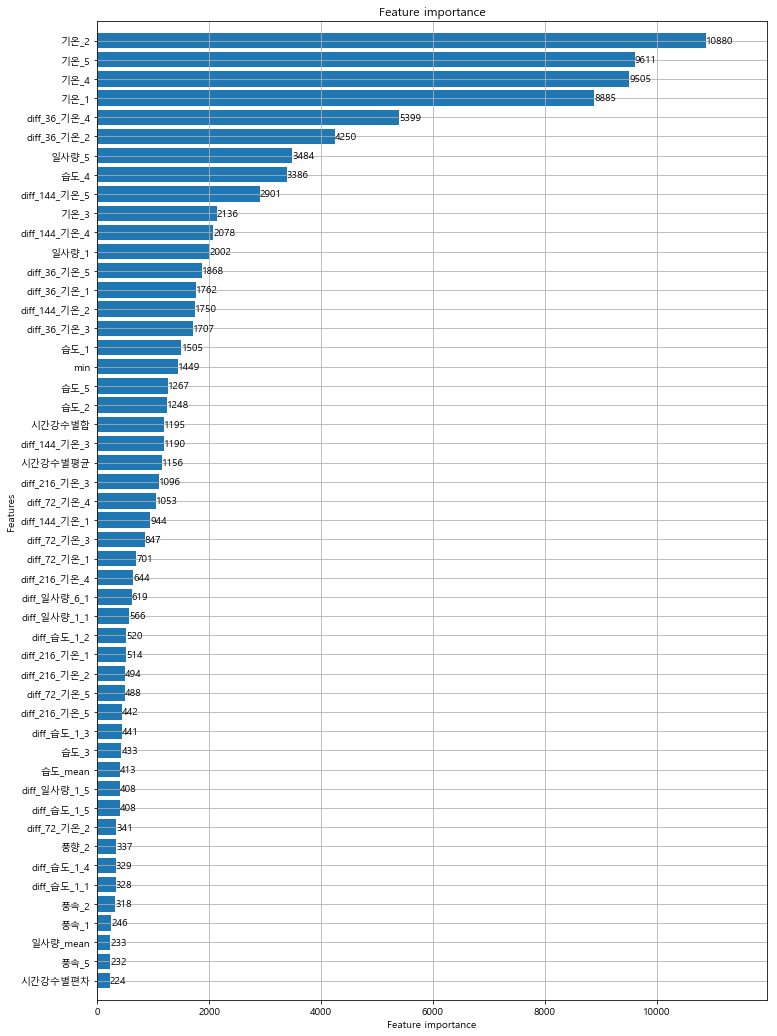

In [133]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

train_x, train_cv, y, y_cv = train_test_split(X_train,y_train, test_size=0.15, random_state=1217)

def lgbm_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2284, num_rounds=18714):

    param = {}

    param['boosting'] = 'dart'
    
    param['objective'] = 'regression'

    param['learning_rate'] = 0.05

    param['max_depth'] = 10

    param['metric'] = 'rmse'
    
    param['is_training_metric'] = True
    
    param['min_child_weight'] = 1

    param['bagging_fraction'] = 0.8
    
    param['num_leaves'] = 128

    param['feature_fraction'] = 0.8

    param['bagging_freq'] = 6
    
    param['seed'] = seed_val
    
    param['min_split_gain'] = 0.01

    num_rounds = num_rounds

    plst = list(param.items())

    train_ds = lgb.Dataset(train_X, label=train_y)

    test_ds = lgb.Dataset(test_X, label=test_y)

    watchlist = [test_ds]

    model = lgb.train(param, train_ds, num_rounds,test_ds, early_stopping_rounds=180)

    return model

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


model = lgbm_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)

from matplotlib import pylab as plt

fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)

plt.show()

In [134]:
y_test =  np.expm1(model.predict(X_test)) + 1

In [135]:
submission['Y18'] = y_test

In [136]:
submission.to_csv('data/0413_test.csv',index=False)

In [141]:
a = pd.read_csv('data/submission_PM.csv')['Y18']
b = pd.read_csv('data/0409_test.csv')['Y18']
c = pd.read_csv('data/0413_test.csv')['Y18']

##### 최종 제출 파일

In [142]:
w1 = 0.5
w2 = 0.1
w3 = 0.4

pd.DataFrame({'id': slist.id, 'Y18': (w1*a+w2*b+w3*c)}).to_csv('data/sanbest4_test.csv',index=False)

## 6. 결과 및 결언
## Conclusion & Discussion

- Y값 결정이 성능을 크게 좌우했다. 
- Y18과 상관관계가 컸던 Y15와 Y16으로 회귀식을 만들어 Y18값을 만들어 보려고 했으나 public 성능이 좋지 못했다.
- columns은 시간의 흐름에 따른 변화량을 넣어주는 것이 성능에 좋은 영향을 보였다.
- columns은 기온을 활용해서(X00,X07.... 등) 만든 경우 성능이 좋았다.
- np.expm1에서 편향을 더해주는 것이 성능이 더 좋았습니다.